In [1]:
import pandas as pd
import numpy as np
from itertools import product

from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model

from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('vodafone_data.csv')

In [3]:
data.head()

Date       Open       High        Low      Close   Volume
0  2016-02-11  29.330000  29.510000  29.030001  29.270000  4805000
1  2016-02-12  29.520000  29.950001  29.410000  29.900000  3116500
2  2016-02-16  29.950001  30.420000  29.900000  30.260000  4037900
3  2016-02-17  31.000000  31.320000  30.900000  31.090000  4313800
4  2016-02-18  31.090000  31.150000  30.920000  30.959999  3522800

## Підготовка даних

In [4]:
def dataset_preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date_index'] = pd.DatetimeIndex(df['Date']) 
    
    data_no_missing = df.copy(deep=True)

    data_no_missing = data_no_missing.set_index('Date_index').asfreq('D')

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        data_no_missing[col] = data_no_missing[col].interpolate()

    data_no_missing = data_no_missing.reset_index(drop=False)

    data_no_missing['Date'] = pd.to_datetime(data_no_missing['Date_index']).dt.date
    data_no_missing['year'] = pd.to_datetime(data_no_missing['Date']).dt.year
    data_no_missing['quarter'] = pd.to_datetime(data_no_missing['Date']).dt.quarter
    data_no_missing['month'] = pd.to_datetime(data_no_missing['Date']).dt.month
    
    return df, data_no_missing

In [5]:
df, data_no_missing = dataset_preprocess(data)

### Перевірка на стаціонарність

#### Тест Дікі-Фулера

In [6]:
stationarity_test(data_no_missing.Close, smt.adfuller)

{'adfuller_statistics': -1.2810249204236712,
 'adfuller_p_value': 0.6378081111339106,
 'adfuller_critical_values': {'1%': -3.4339382310452033,
  '5%': -2.863125003847544,
  '10%': -2.56761380228936}}

#### KPSS тест

In [7]:
stationarity_test(data_no_missing.Close, smt.kpss)

{'kpss_statistics': 5.98948825089506,
 'kpss_p_value': 0.01,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Бачимо, що вихідний часовий ряд не є стаціонарним

## Побудова моделей за допомогою крос-валідації для різних наборів порядків

In [8]:
data_no_missing = data_no_missing.reset_index(drop=False)

In [9]:
data_no_missing.head(2)

index Date_index        Date   Open       High        Low  Close  \
0      0 2016-02-11  2016-02-11  29.33  29.510000  29.030001  29.27   
1      1 2016-02-12  2016-02-12  29.52  29.950001  29.410000  29.90   

      Volume  year  quarter  month  
0  4805000.0  2016        1      2  
1  3116500.0  2016        1      2

In [20]:
ORDERS_RANGE = range(1, 20)

In [21]:
N_SPLITS = 7

In [22]:
INDEX = pd.MultiIndex.from_product((ORDERS_RANGE, ORDERS_RANGE, list(range(N_SPLITS))))

In [23]:
df_stationary, data_diffed, data_logged = to_stationary(data_no_missing)

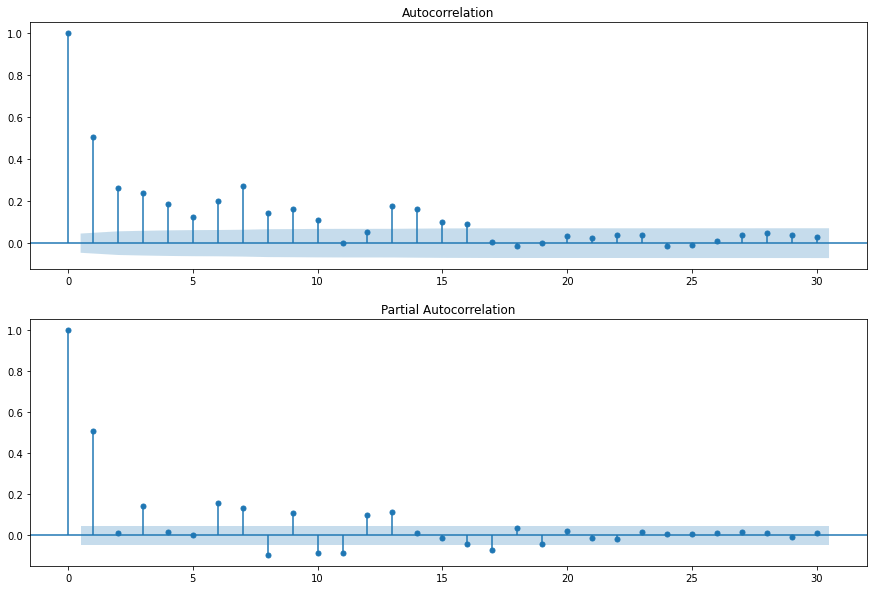

In [24]:
plot_pacf_acf(np.power(df_stationary, 2), figsize = (15,10), lags=30)
plt.show();

In [25]:
def get_observed_metrics(df, predictions, arch, metrics_list=METRICS, titles_list=METRICS_TITLES):
    
    metrics_df = pd.DataFrame()
    
    for metric, title in zip(metrics_list, titles_list):
        calculated_metric = metric(df, predictions)
        metrics_df.loc[0, title] = calculated_metric
    
    metrics_df['AIC'] = aic(df.shape[0], mean_squared_error(df, predictions),
                                         arch.num_params
                                        )

    metrics_df['BIC'] = bic(df.shape[0], mean_squared_error(df, predictions),
                                         arch.num_params
                                        )
    
    return metrics_df

In [26]:
def make_cross_validation(df, target_column='Close', n_splits=5, test_size=30, p=1, q=1, vol='ARCH',
                          lags=12, folds_plots_size=(10, 30), stat_plot_size=(10, 8), plot=False
                          ):
    ts = df[target_column]

    folds_indexes = list(TimeSeriesSplit(n_splits=n_splits, test_size=test_size).split(ts))
    min_fold_len = min([len(fold[0]) for fold in folds_indexes])

    for i in range(len(folds_indexes)):
        folds_indexes[i] = (folds_indexes[i][0][-min_fold_len:], folds_indexes[i][1])

    if plot:
        plot_data_by_fold(df, folds_indexes, folds_plots_size)

    all_metrics_df_test_arch = pd.DataFrame()

    for fold_index, fold in enumerate(folds_indexes):
        train_indexes = fold[0]
        test_indexes = fold[1]

        train_df_tmp = df.loc[train_indexes, :]
        test_df_tmp = df.loc[test_indexes, :]
        
        df_stationary, data_diffed, data_logged = to_stationary(train_df_tmp)
        df_stationary_test, data_diffed_test, data_logged_test = to_stationary(test_df_tmp)
        
        try:
            arch = arch_model(np.power(df_stationary, 2), mean='Zero', vol=vol, p=p, q=q)
            arch_fitted = arch.fit()

            preds = pd.Series(arch_fitted.forecast(horizon=df_stationary_test.shape[0]).variance.values[-1], copy=True)
            y_true = pd.Series(np.array([np.power(df_stationary_test, 2).std() ** 2] * df_stationary_test.shape[0]))
        
            metrics_df_test_arch = get_observed_metrics(y_true, preds, arch_fitted)
        except ValueError:
            metrics_df_test_arch = pd.DataFrame()
        
        if not metrics_df_test_arch.empty:
            metrics_df_test_arch.index = pd.Series(str((p, q, vol, fold_index)))

        all_metrics_df_test_arch = pd.concat((all_metrics_df_test_arch, metrics_df_test_arch), axis=0)

    return all_metrics_df_test_arch

In [27]:
def get_cross_val_results(data, n_splits, test_size, lags, orders_range=ORDERS_RANGE, 
                          models_list=['ARCH', 'GARCH', 'EGARCH', 'FIARCH'],
                          plot=False):
    
    all_metrics_df_test = pd.DataFrame()
    
    for vol in ['ARCH', 'GARCH', 'EGARCH', 'FIARCH']:
        for p, q in product(ORDERS_RANGE, ORDERS_RANGE):
            test_metrics_df_arch = make_cross_validation(data, p=p, q=q, vol=vol)
            all_metrics_df_test = pd.concat((all_metrics_df_test, test_metrics_df_arch))
    
    return all_metrics_df_test

In [28]:
all_metrics_df_test_arch_models = get_cross_val_results(data_no_missing, N_SPLITS, 100, 30)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -7178.91301690086
Iteration:      2,   Func. Count:      9,   Neg. LLF: -8873.305738864805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8873.305737758796
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8875.573460294092
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8875.573459051164
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8870.367426866673
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8870.367425659511
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8865.695747883714
Optimization te

Iteration:      1,   Func. Count:      4,   Neg. LLF: -7178.91301690086
Iteration:      2,   Func. Count:      9,   Neg. LLF: -8873.305738864805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8873.305737758796
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8875.573460294092
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8875.573459051164
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8870.367426866673
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8870.367425659511
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8865.695747883714
Optimization te

Iteration:      1,   Func. Count:      4,   Neg. LLF: -7178.91301690086
Iteration:      2,   Func. Count:      9,   Neg. LLF: -8873.305738864805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8873.305737758796
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8875.573460294092
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8875.573459051164
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8870.367426866673
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8870.367425659511
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8865.695747883714
Optimization te

Iteration:      1,   Func. Count:      3,   Neg. LLF: -8865.695747883714
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8865.69574670866
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8866.475904304489
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8866.47590312814
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -7178.91301690086
Iteration:      2,   Func. Count:      9,   Neg. LLF: -8873.305738864805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8873.305737758796
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8875.573460294092
Optimization term

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -7176.99803451129
Iteration:      2,   Func. Count:     11,   Neg. LLF: -8886.735335484253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.73533625405
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8886.5101803021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.510181089583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8890.805884726919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8890.805885523368
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization term

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     16,   Neg. LLF: -8897.10793772167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8897.107938397528
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7176.99803451129
Iteration:      2,   Func. Count:     11,   Neg. LLF: -8886.735335484253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.73533625405
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8886.5101803021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.510181089583
            Iterations: 5
            Functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     16,   Neg. LLF: -8897.10793772167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8897.107938397528
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7176.99803451129
Iteration:      2,   Func. Count:     11,   Neg. LLF: -8886.735335484253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.73533625405
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8886.5101803021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.510181089583
            Iterations: 5
            Functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8894.27948551339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     16,   Neg. LLF: -8897.10793772167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8897.107938397528
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7176.99803451129
Iteration:      2,   Func. Count:     11,   Neg. LLF: -8886.735335484253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.73533625405
            Iterations: 6
            Functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -8890.805884726919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8890.805885523368
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8894.27948551339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     16,   Neg. LLF: -8897.10793772167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8897.107938397528
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -8886.5101803021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.510181089583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8890.805884726919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8890.805885523368
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8894.27948551339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -7176.99803451129
Iteration:      2,   Func. Count:     11,   Neg. LLF: -8886.735335484253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.73533625405
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8886.5101803021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.510181089583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8890.805884726919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8890.805885523368
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization term

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8894.27948551339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     16,   Neg. LLF: -8897.10793772167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8897.107938397528
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7176.99803451129
Iteration:      2,   Func. Count:     11,   Neg. LLF: -8886.735335484253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.73533625405
            Iterations: 6
            Functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -8890.805884726919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8890.805885523368
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8894.27948551339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     16,   Neg. LLF: -8897.10793772167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8897.107938397528
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     21,   Neg. LLF: -7167.846156807691
Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9529.758605037532
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9501.810002449984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.809999330835
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      3,   Func. Count:     20,   Neg. LLF: -9541.40583545758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.405833474797
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7167.846156807691
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64538655.09088434
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7167.846156807691
Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9529.758605037532
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9501.810002449984
Opti

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      3,   Func. Count:     20,   Neg. LLF: -9541.40583545758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.405833474797
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7167.846156807691
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64538655.09088434
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7167.846156807691
Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      3,   Func. Count:     20,   Neg. LLF: -9541.40583545758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.405833474797
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9501.810002449984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.809999330835
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: -7167.846156807691
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64538655.09088434
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7167.846156807691
Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9529.758605037532
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9501.810002449984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.809999330835
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            F

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      3,   Func. Count:     20,   Neg. LLF: -9541.40583545758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.405833474797
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7167.846156807691
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64538655.09088434
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7167.846156807691
Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      3,   Func. Count:     20,   Neg. LLF: -9541.40583545758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.405833474797
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9529.758605037532
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9501.810002449984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.809999330835
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function val

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      3,   Func. Count:     20,   Neg. LLF: -9541.40583545758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.405833474797
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7167.846156807691
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64538655.09088434
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7167.846156807691
Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.886723875916
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.914108393932
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.886723875916
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -952

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.914108393932
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.886723875916
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -952

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.914108393932
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.886723875916
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -951

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.914108393932
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -950

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.914108393932
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -950

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9538.478853231289
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7162.446206223677
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9498.336390302084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9498.336390980021
            Iterations: 6
            

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      2,   Func. Count:     19,   Neg. LLF: 23398282.915979404
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.113958190512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.113958867936
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9538.478853231289
            Iterations: 7
  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      8,   Neg. LLF: -7162.446206223677
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9498.336390302084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9498.336390980021
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.284442131334
Iteration:      2,   Func. Count:     19,   Neg. LLF: 21071290.92875328
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.788649751343
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.78865040654
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.4407614460815
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23398282.915979404
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.1139

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.4407614460815
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23398282.915979404
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.113958190512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.113958867936
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
         

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.4407614460815
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23398282.915979404
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.113958190512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.113958867936
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
         

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9538.478853231289
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7162.446206223677
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9498.336390302084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9498.336390980021
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.284442131334
Iteration:      2,   Func. Count:     19,   Neg. LLF: 21071290.92875328
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.788649751343
P

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9538.478853231289
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7162.446206223677
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9498.336390302084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9498.336390980021
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.284442131334
Iteration:      2,   Func. Count:     19,   Neg. LLF: 21071290.92875328
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.788649751343
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.78865040654
            Iterations: 7
   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.4407614460815
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23398282.915979404
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.113958190512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.113958867936
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
         

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      8,   Neg. LLF: -7162.446206223677
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9498.336390302084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9498.336390980021
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.284442131334
Iteration:      2,   Func. Count:     19,   Neg. LLF: 21071290.92875328
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.788649751343
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.78865040654
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.4407614460815
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23398282.915979404
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.1139

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  w

Iteration:      1,   Func. Count:      8,   Neg. LLF: -7156.4407614460815
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23398282.915979404
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9529.113958190512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.113958867936
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9557.492884160849
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.001143681631
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iterat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.68230619001
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.507207624996
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.507205729878
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9557.492884160849
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -95

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9560.632940169175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.632938171459
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.68230619001
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.507207624996
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.507205729878
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9557.492884160849
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.001143681631
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9560.632940169175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.632938171459
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.507207624996
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.507205729878
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9557.492884160849
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.001143681631
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9560.632940169175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -95

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.68230619001
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.507207624996
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.507205729878
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9557.492884160849
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -95

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9560.632940169175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.632938171459
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.68230619001
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.507207624996
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.507205729878
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.001143681631
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9560.632940169175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.632938171459
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.68230619001
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.507207624996
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9557.492884160849
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.001143681631
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9560.632940169175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.632938171459
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9557.49288609867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9557.492884160849
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9566.00114562042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.001143681631
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9560.632940169175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.632938171459
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9547.682308116873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.506570935338
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.113688804
Iteration:      5,   Func. Count:     52,   Neg. LLF: -9621.341837233118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9621.341839246572
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9547.284141373668
Optimization terminated successfully    (Exit mode 0)
            Cu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9547.284141373668
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.284143020668
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 5504845.561153105
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5504845.561153105
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9630.054227071232
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9630.054228967067
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9623.669210899574
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.506570935338
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.113688804
Iteration:      5,   Func. Count:     52,   Neg. LLF: -9621.341837233118
Positive directional derivative for linesearch    (Exit mode 8)
    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.113688804
Iteration:      5,   Func. Count:     52,   Neg. LLF: -9621.341837233118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9621.341839246572
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9547.284141373668
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.284143020668
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 5504845.561153105
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5504845.5611531

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9547.284141373668
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.284143020668
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 5504845.561153105
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5504845.561153105
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9630.054227071232
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9630.054228967067
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9623.669210899574
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.506570935338
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.11368

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9623.669210899574
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.506570935338
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.11368

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9623.669210899574
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.506570935338
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.11368

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9547.284141373668
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.284143020668
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 5504845.561153105
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5504845.561153105
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9630.054227071232
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9630.054228967067
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9623.669210899574
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.506570935338
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.11368

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.113688804
Iteration:      5,   Func. Count:     52,   Neg. LLF: -9621.341837233118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9621.341839246572
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9547.284141373668
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9547.284143020668
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 5504845.561153105
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5504845.5611531

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:     10,   Neg. LLF: 5504845.561153105
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5504845.561153105
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9630.054227071232
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9630.054228967067
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046838.0161049645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046838.0161049645
Iteration:      3,   Func. Count:     29,   Neg. LLF: -9623.669209048108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9623.669210899574
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9537.506569287303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.506570935338
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 3046863.113688804
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3046863.113688804
Iteration:      3,   Func. Count:     30,   Neg. LLF: -7156.49606261635
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3046863.113688804
Iteration:      5,   Func. Count:     52,   Neg. LLF: -9621.341837233118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9621.341839246572
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9547.284141373668
Optimization terminated successfully    (Exit mode 0)
            Cu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code me

Iteration:      5,   Func. Count:     52,   Neg. LLF: -9621.341837233118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9621.341839246572
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5058888.258253611
Iteration:      3,   Func. Count:     32,   Neg. LLF: -9604.704049443095
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.704049825155
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9554.474093118271
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9554.47409258666
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iterat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: -9537.190032179182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.190031627379
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.989717024539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9535.989716552005
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5058888.258253611
Iteration:      3,   Func. Count:     32,   Neg. LLF: -9604.704049443095
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.704049825155
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 3
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: -9554.474093118271
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9554.47409258666
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9550.284795543415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9550.284794932883
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9537.190032179182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.190031627379
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.989717024539
Optimization terminated successfully    (Exit mode 0)
            Current function val

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: -9550.284795543415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9550.284794932883
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9537.190032179182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.190031627379
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.989717024539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9535.989716552005
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5058888.258253611
Iteration:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     32,   Neg. LLF: -9604.704049443095
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.704049825155
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9554.474093118271
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9554.47409258666
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9550.284795543415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9550.284794932883
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9537.190032179182
Optimization terminated successfully    (Exit mode 0)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.989717024539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9535.989716552005
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5058888.258253611
Iteration:      3,   Func. Count:     32,   Neg. LLF: -9604.704049443095
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.704049825155
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9554.474093118271
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9554.47409258666
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: -9550.284795543415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9550.284794932883
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9537.190032179182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.190031627379
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.989717024539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9535.989716552005
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5058888.258253611
Iteration:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: -9537.190032179182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.190031627379
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.989717024539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9535.989716552005
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5058888.258253611
Iteration:      3,   Func. Count:     32,   Neg. LLF: -9604.704049443095
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.704049825155
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 3
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9550.284795543415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9550.284794932883
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9537.190032179182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.190031627379
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.989717024539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9535.989716552005
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 5058888.258253611
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5058888.258253611
Iteration:      3,   Func. Count:     32,   Neg. LLF: -9604.704049443095
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.704049825155
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9554.474093118271
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9554.47409258666
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9550.284795543415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9550.284794932883
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     24,   Neg. LLF: -5745.297537075006
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9598.487594268212
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9598.48759384796
            Iterations: 3
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9535.110710013774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.110709051609
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5753.134857929069
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9600.330435929103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.33043527605
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9550.370451558207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.370450391973
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9550.370451558207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.370450391973
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     24,   Neg. LLF: -5745.297537075006
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9598.487594268212
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9598.48759384796
            Iterations: 3
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9535.110710013774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.110709051609
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5753.134857929069
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9600.330435929103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.33043527605
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9550.370451558207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.370450391973
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     24,   Neg. LLF: -5745.297537075006
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9598.487594268212
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9598.48759384796
            Iterations: 3
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9535.110710013774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.110709051609
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5753.134857929069
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9600.330435929103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.33043527605
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9550.370451558207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.370450391973
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     24,   Neg. LLF: -5745.297537075006
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9598.487594268212
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9598.48759384796
            Iterations: 3
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9535.110710013774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.110709051609
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -5753.134857929069
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9600.330435929103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.33043527605
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9550.370451558207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.370450391973
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     24,   Neg. LLF: -5745.297537075006
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9598.487594268212
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9598.48759384796
            Iterations: 3
            Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9535.110710013774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.110709051609
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5753.134857929069
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9600.330435929103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.33043527605
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9550.370451558207
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     24,   Neg. LLF: -5745.297537075006
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9598.487594268212
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9598.48759384796
            Iterations: 3
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9535.110710013774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.110709051609
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9546.714864481652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.7148633376
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -5753.134857929069
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9600.330435929103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.33043527605
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9550.370451558207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.370450391973
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     24,   Neg. LLF: -5745.297537075006
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9598.487594268212
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9598.48759384796
            Iterations: 3
            Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.296244141722
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.113479907788
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.525088272738
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.296244141722
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.113479907788
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.525088272738
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.589358350991
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.296244141722
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.113479907788
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.525088272738
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.296244141722
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.113479907788
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.589358350991
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.296244141722
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.525088272738
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.589358350991
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.113479907788
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.525088272738
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.589358350991
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.296244141722
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.113479907788
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.589358350991
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9540.296244441155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.296244141722
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9547.113480161503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.113479907788
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9543.525088543776
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.525088272738
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9529.589358524174
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.589358350991
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9527.367820705316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.36782064903
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9504.693969435568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.693972043126
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9504.693969435568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.693972043126
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9504.693969435568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.693972043126
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9504.693969435568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.693972043126
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9504.693969435568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.693972043126
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9504.693969435568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.693972043126
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9507.307612045062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.307614546831
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9504.693969435568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.693972043126
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.116592565384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.116595010504
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.776234248777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.776236710019
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -7371.717072045152
Iteration:      2,   Func. Count:     28,   Neg. LLF: -7371.717072045152
Iteration:      3,   Func. Count:     50,   Neg. LLF: -9594.35502944206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9594.355032199372
            Iterations: 3
            Function evaluations: 50
            Gradient evaluations: 3
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9505.917315835655
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.917318577835
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.39562360589
Inequality constraints incompatible    (Exit mode 4)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9505.917315835655
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.917318577835
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.39562360589
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.395626374826
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9509.059390288883
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9509.059390288883
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.05939300333
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9505.917315835655
Optimization terminated successfully    (Exit mode 0)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.39562360589
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.395626374826
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9509.059390288883
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.05939300333
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9505.917315835655
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.917318577835
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.39562360589
Inequality constraints incompatible    (Exit mode 4)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9505.917315835655
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.917318577835
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.39562360589
Inequality constraints incompatible    (Exit mode 4)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.39562360589
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.395626374826
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9509.059390288883
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.05939300333
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9505.917315835655
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.917318577835
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.39562360589
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.395626374826
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9509.059390288883
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9509.059390288883
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.05939300333
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9505.917315835655
Optimization terminated successfully    (Exit mode 0)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: -9495.235497204021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.235499990811
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9492.15590105606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9492.155903969266
            Iterations: 5
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.4984384768
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.113921455253
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.004250450853
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.38951960055
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.4984384768
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.113921455253
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.004250450853
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.113921455253
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.004250450853
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.38951960055
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.38951960055
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.4984384768
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.113921455253
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.004250450853
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.38951960055
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.4984384768
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.113921455253
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.004250450853
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.38951960055
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.4984384768
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.113921455253
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.004250450853
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.38951960055
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.4984384768
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9509.113921455253
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9495.004250264932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.004250450853
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9506.389521426954
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.38951960055
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9505.498438304636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9505.4984384768
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9511.843060346357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.843060542084
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9509.113921386683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.636199276421
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.636199276421
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.636199276421
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.636199276421
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.636199276421
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.636199276421
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.633273311112
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.942558104583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.942559536523
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9502.000138010475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.000139502661
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9498.63619775882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.636199276421
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9484.571808142733
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.571809717003
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9613.633272469551
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9586.300501844777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.300504227813
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9487.66074594288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9487.660748053011
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.288410237383
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.288411959435
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9586.300501844777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.300504227813
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9487.66074594288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9487.660748053011
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.288410237383
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.288411959435
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.288410237383
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.288411959435
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9586.300501844777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.300504227813
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9586.300501844777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.300504227813
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9487.66074594288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9487.660748053011
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: -9487.66074594288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9487.660748053011
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.288410237383
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.288411959435
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9586.300501844777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.300504227813
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9487.66074594288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9487.660748053011
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: -9487.66074594288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9487.660748053011
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.288410237383
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.288411959435
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9586.300501844777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.300504227813
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9487.66074594288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9487.660748053011
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.288410237383
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.288411959435
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9472.02736369583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9472.027365525388
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9440.499671346935
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9440.499671346935
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9586.300501844777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.300504227813
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.82201419161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.822016248883
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9617.926442740089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9617.926446387832
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9479.066000613971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.066000526316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.764147816786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.764147767828
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.594371503767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.594371363444
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -5745.297537075006
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9564.87200724352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.87200610777
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9039.833404369267
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Function evaluations: 83
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8855.081370359
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.898052157503
            Iterations: 3
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimiza

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -8855.081370359
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.898052157503
            Iterations: 3
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9461.162956780785
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.898052157503
            Iterations: 3
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9461.162956780785
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization t

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9461.162956780785
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Function evaluations: 83
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8855.081370359
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequal

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Function evaluations: 83
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8855.081370359
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.898052157503
            Iterations: 3
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimiza

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -8855.081370359
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.898052157503
            Iterations: 3
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9461.162956780785
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9461.162956780785
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9460.348948234605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.348952551496
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: -9445.537928547708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9445.537932987896
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Function evaluations: 83
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8855.081370359
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequal

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Function evaluations: 83
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     20,   Neg. LLF: -8855.081370359
Iteration:      2,   Func. Count:     42,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9511.898047953337
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.898052157503
            Iterations: 3
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.162952322939
Optimiza

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     42,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     64,   Neg. LLF: -8938.328764420785
Iteration:      4,   Func. Count:     83,   Neg. LLF: -9571.276174860575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.2761789154
            Iterations: 4
            Function evaluations: 83
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     21,   Neg. LLF: -8866.061026434483
Iteration:      2,   Func. Count:     44,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     73,   Neg. LLF: -9494.731991467488
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9494.731995260161
            Iterations: 3
            Function evaluations: 73
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9441.574429297607
Optimization terminated successfully    (Exit mode 0)
            Current func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.924288152793
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -8866.061026434483
Iteration:      2,   Func. Count:     44,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     73,   Neg. LLF: -9494.731991467488
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9494.731995260161
            Iterations: 3
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.924288152793
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -8866.061026434483
Iteration:      2,   Func. Count:     44,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     73,   Neg. LLF: -9494.731991467488
Inequality constraints incompatible    (Exit mode 4)
            Current fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.924288152793
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -8866.061026434483
Iteration:      2,   Func. Count:     44,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     73,   Neg. LLF: -9494.731991467488
Ine

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.924288152793
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -8866.061026434483
Iteration:      2,   Func. Count:     44,   Neg. LLF: -8843.49399131665
Iteration:      3,   Func. Count:     73,   Neg. LLF: -9494.731991467488
Ine

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.924288152793
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -8866.061026434483
Iteration:      2,   Func. Count:     44,   Neg. LLF: -8843.49399131665
Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.924288152793
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -8866.061026434483
It

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.924288152793
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: -9440.882794715308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9440.88279839444
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -7500.679336986153
Iteration:      2,   Func. Count:     43,   Neg. LLF: -8776.211201230615
Iteration:      3,   Func. Count:     73,   Neg. LLF: -8776.211201230615
Iteration:      4,   Func. Count:    103,   Neg. LLF: -8776.211201230615
Iteration:      5,   Func. Count:    125,   Neg. LLF: -8776.211201230615
Iteration:      6,   Func. Count:    147,   Neg. LLF: -9542.841585007613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.841589299995
            Iterations: 6
            Function evaluations: 147
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.92428511144
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: -9423.548270344167
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9423.548274147368
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.259590029535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9408.259593976407
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     46,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     69,   Neg. LLF: -9528.56959932201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9528.569602913834
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 3
Iteration:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.259590029535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9408.259593976407
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     46,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     69,   Neg. LLF: -9528.56959932201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9528.569602913834
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9419.126160824071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9419.12616456555
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     22,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     46,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     69,   Neg. LLF: -9528.56959932201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9528.569602913834
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9419.126160824071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9419.12616456555
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1521661.1403190054
Iteration:      2,   Func. Count:     44,   Neg. LLF: -7180.163681528094
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9501.646640409686
Optimization terminated successfully    (Exit mode 0)
            Current fu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: -9419.126160824071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9419.12616456555
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1521661.1403190054
Iteration:      2,   Func. Count:     44,   Neg. LLF: -7180.163681528094
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9501.646640409686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.646644539273
            Iterations: 7
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9423.548270344167
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9423.548274147368
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     22,   Neg. LLF: 1521661.1403190054
Iteration:      2,   Func. Count:     44,   Neg. LLF: -7180.163681528094
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9501.646640409686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.646644539273
            Iterations: 7
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9423.548270344167
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9423.548274147368
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.259590029535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9408.259593976407
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     44,   Neg. LLF: -7180.163681528094
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9501.646640409686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.646644539273
            Iterations: 7
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9423.548270344167
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9423.548274147368
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.259590029535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9408.259593976407
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -8938.328764420785
Iteration: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.259590029535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9408.259593976407
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     46,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     69,   Neg. LLF: -9528.56959932201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9528.569602913834
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9419.126160824071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9419.12616456555
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     69,   Neg. LLF: -9528.56959932201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9528.569602913834
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9419.126160824071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9419.12616456555
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1521661.1403190054
Iteration:      2,   Func. Count:     44,   Neg. LLF: -7180.163681528094
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9501.646640409686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.646644539273
            Iterations: 7
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: -9419.126160824071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9419.12616456555
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1521661.1403190054
Iteration:      2,   Func. Count:     44,   Neg. LLF: -7180.163681528094
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9501.646640409686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.646644539273
            Iterations: 7
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9423.548270344167
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9423.548274147368
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     68,   Neg. LLF: -9501.646640409686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.646644539273
            Iterations: 7
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9423.548270344167
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9423.548274147368
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.259590029535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9408.259593976407
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     46,   Neg. LLF: -8938.328764420785
Iteration: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.259590029535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9408.259593976407
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -8938.328764420785
Iteration:      2,   Func. Count:     46,   Neg. LLF: -8938.328764420785
Iteration:      3,   Func. Count:     69,   Neg. LLF: -9528.56959932201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9528.569602913834
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -9560.125507825183
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.125500787271
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      5,   Neg. LLF: -9560.981611841333
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.981602207477
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2452.739505740824
Iteration:      2,   Func. Count:     15,   Neg. LLF: -9565.136596302153
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9565.136599312798
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9536.107330191417
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9536.10731962291
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9576.351275480924
Optimization termi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9606.488777612372
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9606.488771606682
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9588.322561810564
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9588.322557564243
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9596.495729298553
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9596.4957255228
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9589.398969756186
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -95

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9595.969104409178
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9595.969105123208
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9578.017010682408
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9578.01701137693
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9627.616116563097
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9627.616122573068
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9589.03322107096
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -95

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: -9581.749024408986
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9581.74903285762
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9588.64882171331
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9588.648831043283
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9580.79852729298
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9580.798535778871
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9564.152935487353
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9578.07492843113
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9578.07493979508
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9562.096246629104
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9562.09625814715
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9609.845378371287
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9609.84539563884
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9569.703090388339
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9556.641721876382
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9556.641737621389
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9560.264827702038
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.264845316367
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9549.951646291005
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9549.951663369098
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9536.070388975511
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: -9533.9420910478
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9533.942109349298
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9521.23167262975
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.231691426845
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9566.910221419319
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.910246169806
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9534.662880317732
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     31,   Neg. LLF: -9579.99835143202
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9579.998343761214
            Iterations: 2
            Function evaluations: 31
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9521.361372131983
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.361389910198
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9519.815226493067
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9519.815247090288
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 273753932.1825301
Iteration:      2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9508.244505150904
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9508.24452375901
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9504.79504814489
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.795069771975
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9491.037119385475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9491.037141090666
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.073789792435
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9495.16178198045
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.161803279316
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9481.58100172481
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.581023010798
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9470.281738930495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9470.281761980234
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9505.622748856335
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9452.827891332101
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.82791636929
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9487.348787625066
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9487.34881888614
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9470.799184685873
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9470.799203806178
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9462.148221822965
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9469.858823636167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9469.858855203602
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9458.031730528068
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9458.031748956302
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9447.699198270479
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9447.699220052611
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 273753932.1825301
Iteration:      2,   Func. Count:     43,   Neg. LLF: -9500.282328298466
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9446.070132205765
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.070149984673
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9434.142164154597
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9434.142185293684
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9415.254403106464
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.254425523155
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9406.9115877013
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.045951308097
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.045940499782
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9493.98460528143
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9493.984594377627
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9520.06750246673
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9520.06749143
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.16699746307
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.16

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9534.075912462868
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.07590113853
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9542.745361127145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.745350350498
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9541.175130346019
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.175119019768
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 2619.4344179107975
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2586.055372525834
Iteration:      3, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9537.44009506523
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.440088764299
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9586.142929204027
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.142927781613
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9552.949318214114
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9552.949316847236
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9560.829796712194
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: -9556.715460328167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9556.715463444327
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9555.398821911589
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9555.398824638225
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9538.031026050434
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9538.031028755418
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9587.23371050637
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9534.598649691176
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.59865567403
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9583.40852031319
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9583.408531958778
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9541.529905933945
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.52991414083
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: 276885706.9333621
Iteration:      2,   Func. Count:     25,   Neg. LLF: -9575.86962427523
Inequality constrai

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9532.411241141068
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9532.411251581894
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9537.205524313082
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9537.205536368005
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9533.97408516784
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9533.974097240247
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9519.1592094896
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: -9507.109623421362
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.109637774169
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 268276694.6656363
Iteration:      2,   Func. Count:     29,   Neg. LLF: -9621.625359357826
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9621.6253607879
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9513.28341587426
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9513.28342840382
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9515.15697830759
Inequality constrain

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9503.726189672207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9503.72620331417
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9503.83132122386
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9503.831337509546
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9497.548180565474
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9497.54819731455
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9485.848550944896
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9484.066607948109
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.066625940522
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9473.459224776638
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9473.459243594858
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9516.713927474795
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9516.713952433296
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9485.409312257842
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9463.124702544266
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9463.124722431474
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9502.378437090145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.378463749461
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9475.761693567822
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9475.761709356073
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9470.43673660784
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9486.727092660045
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.727120584517
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9462.770830813857
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9462.770847221389
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9455.639250928267
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9455.639270668704
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9445.524536851653
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9451.096322663698
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9451.096338478168
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9442.224475165089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.224494377591
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9430.546188123033
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9430.546208832046
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9421.536742478003
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9429.846273254352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9429.846291952752
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9416.671468991826
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9416.671489347882
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9408.315445806662
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.315468116842
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 268276694.6656363
Iteration:      2,   Func. Count:     45,   Neg. LLF: -9544.88225613928
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9417.978453227177
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9417.978471409599
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9403.3488236444
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9403.348843636746
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9395.5405913309
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9395.540613544243
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9425.827669797884
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9452.470272024582
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.47025820351
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9480.440673028885
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9480.440659266673
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9474.668665313122
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9474.668647987008
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9483.677630562746
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9513.620359562547
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9513.620345472838
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9513.097769836364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9513.097755271096
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9494.794877465549
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9494.79486286717
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2602.7582286321294
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9553.82293124875
Inequality constrai

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9559.564290722748
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9559.5642870743
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9527.346550854825
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.346547543213
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.017721433727
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.01771878764
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 2732.723339387845
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9536.919142512383
Inequality constrai

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9535.014262140941
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.014263598074
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9534.710325688524
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.710326798697
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9517.431149222653
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9517.43115031008
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9565.947312329168
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9515.433637063865
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9515.433641837182
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9563.016250762932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9563.016261097331
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9521.07505173578
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.075058487982
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9526.761356493756
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: -9512.664305094495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.66431398216
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 276885706.9333621
Iteration:      2,   Func. Count:     29,   Neg. LLF: -9565.980967372863
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9565.980960160407
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9514.971900766337
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.971911325438
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9500.370408734503
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9504.724143288982
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.724155659109
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9491.15517356
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9491.155186266067
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9535.884007799705
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.88402627185
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.676455882582
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -94

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9524.299513070415
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.299533576905
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.497838760682
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.497851106746
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9486.283592199157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.283607232315
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9481.305486611034
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9477.799910223166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9477.799926138352
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9472.151338612475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.151354995185
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9460.87218339956
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.872200755162
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9500.156188424946
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9461.638971173978
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9461.63898904384
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9450.612185855058
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9450.612204876154
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9487.02640902078
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9487.026434347918
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9462.692551146472
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9472.816613471336
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.816640017747
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9451.877939450933
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9451.877954502088
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9444.502734564245
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9444.502752969887
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9435.940463627001
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9442.338293805758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.338308370761
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9433.237980995675
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.2379989796
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9423.280882834344
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.280902229555
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9414.095821284001
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9422.792875766945
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.792893348376
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9411.438083994524
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9411.438103174882
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9402.829361734486
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9402.829382896172
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9432.1004196711
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9400.545878155956
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.545896929252
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9392.406048551207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9392.406069574341
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9419.715885294281
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9419.715913499584
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -1799.9691147846765
Iteration:      2,   Func. Count:     21,   Neg. LLF: -9471.752859802527
Inequality co

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9457.144357844409
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9457.144342808053
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9457.76080454536
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9457.76078536173
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9466.350576225768
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9466.350557607682
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9466.143315879553
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -94

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9500.36077288841
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9500.360757269273
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9481.955225066715
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.955209403935
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 2606.252052660522
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2606.252052660522
Iteration:      3,   Func. Count:     39,   Neg. LLF: -9543.270411822865
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.270414657127
            Iterations: 3
            Function evaluations: 39
            Gradient evaluations: 3
Iteration:      1, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: 2739.6823038323378
Iteration:      2,   Func. Count:     25,   Neg. LLF: -9525.84611054441
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9525.846112634503
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9530.137720969742
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9530.137717730786
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 2734.820912610781
Iteration:      2,   Func. Count:     26,   Neg. LLF: 2734.820912610781
Iteration:      3,   Func. Count:     40,   Neg. LLF: -9533.31172541264
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9533.31172800526
            Iterations: 3
            Functio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9534.09798903758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.097989738637
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9516.959942504933
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9516.959943182734
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9564.61377499409
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.613781096765
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9527.658843983912
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9563.85807752642
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9563.858087421564
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9524.731026051277
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9524.731032273608
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9529.931761087684
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.931768637281
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9529.111834390358
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9523.54290651581
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9523.54291657182
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9521.95368946608
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.953699510477
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9507.639544991478
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.639555261572
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9552.027315422249
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9499.931866470874
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9499.931879062198
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9543.26946575136
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.269484083892
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9505.17136093255
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9505.171372445999
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9506.191936849322
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9532.858301221677
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9532.858321703436
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9500.217494379129
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9500.217506478333
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9499.483258161636
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9499.483272929865
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9495.557084222739
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9495.201454633552
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.20146772761
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9492.63104954701
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9492.63106555398
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9487.976388519295
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9487.976404981444
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9476.746970749791
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9479.348525506331
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.348543340464
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9468.53940170574
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9468.539420713583
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9502.719118456675
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.719143624365
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9482.335131898275
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9459.39748747801
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9459.397507563295
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9491.115871284417
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9491.115897651143
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9474.454379170606
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9474.454393997668
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9466.53858898513
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9479.596428627181
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.5964557082
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9467.58792805957
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9467.587942525435
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9457.948895057401
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9457.948912933418
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9448.968638298124
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9461.57542870489
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9461.575442763075
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9450.275059962685
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9450.275077463251
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9439.959878591475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9439.959897657485
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9431.478323345234
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9443.623839986132
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9443.623856975506
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9431.992663176741
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9431.992681899235
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9423.928112666246
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.928133732788
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9448.644298885647
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9405.291496386915
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.291505990277
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9437.086206261134
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.086190265225
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9437.964614174665
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.964592890716
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9446.030432944952
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: -9482.346349857291
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9482.346333343265
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9483.234526516142
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.234509647664
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9464.612393056175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9464.612376122852
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9511.480216023303
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9534.55821302066
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.558207693048
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9507.789537311239
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.789532407962
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9514.46116421227
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.461159963364
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9515.57543394456
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9517.620264071527
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9517.620263969991
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9518.532401359866
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.532400999638
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9501.307087940037
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9501.30708752797
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9548.719678509187
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: 113243452.25052348
Iteration:      2,   Func. Count:     30,   Neg. LLF: -7172.360541940949
Iteration:      3,   Func. Count:     48,   Neg. LLF: -9552.956333414815
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9552.956333608076
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9547.227545285752
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.227553984418
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9508.632349468711
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9508.632354396459
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9503.672720709134
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9503.67272793662
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9507.097851175215
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.097860059548
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9506.056201862477
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.056210803243
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9491.774217411157
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9497.101823613353
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9497.101834858506
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9483.92880448946
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.928816077902
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9527.458094209322
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9527.458111544327
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9491.04779845276
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: 268276694.6656363
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9611.169787268476
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9611.169790291362
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9485.55933068011
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9485.559342163484
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9484.184726608772
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.184740741126
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9481.005704093348
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     41,   Neg. LLF: -9554.64396444284
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9554.643971865327
            Iterations: 3
            Function evaluations: 41
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9476.783954379349
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9476.783969751945
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9472.785262001105
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.785277895284
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9461.540146593354
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9468.477132465388
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9468.47714898044
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9463.610695398402
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9463.610712618465
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9452.914137534142
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.914155883103
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9487.265817340707
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9453.883737462911
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9453.883755471852
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9443.64069779968
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9443.640717170685
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9475.74233925725
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9475.742364902733
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     47,   Neg. LLF: -9536.750359269688
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9433.689489411387
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.689509530119
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9464.365315828261
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9464.365342240015
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9452.241266273231
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.241280023549
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9441.944968344156
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9453.69384673635
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9453.693873698096
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9446.6889832424
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.688996600213
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9434.726436476994
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9434.726453261654
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9424.979063329156
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9443.748921605373
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9443.748948983764
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9441.477077143376
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9441.477090184402
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     53,   Neg. LLF: -9511.939286472676
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.939301480706
            Iterations: 3
            Function evaluations: 53
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9416.853437930919
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9433.962204013284
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.962231819689
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9401.030520662987
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9401.03052854327
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9408.607580836364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.607564213942
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9409.449025996637
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: -9437.503933648368
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.503912398091
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9418.893562882837
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9418.893541587528
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9462.821438378625
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9462.821420447577
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9466.800703928955
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: -9488.766136194245
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9488.766125984863
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9495.564337467848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.564327843422
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9497.089150178792
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9497.089140224914
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9478.52855251322
Inequality constraints incompatible    (Exit mode 4)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9506.480652732182
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9506.480647989962
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9488.495253462004
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9488.495248606718
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9536.411849287328
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9536.411849616996
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9501.71479558605
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     31,   Neg. LLF: -9493.426773333636
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9493.426777098359
            Iterations: 2
            Function evaluations: 31
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     15,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2813.0735180669417
Iteration:      3,   Func. Count:     49,   Neg. LLF: 2813.0735180669417
Iteration:      4,   Func. Count:     73,   Neg. LLF: 2813.0735180669417
Iteration:      5,   Func. Count:     97,   Neg. LLF: 2813.0735180669417
Iteration:      6,   Func. Count:    121,   Neg. LLF: 1857491778.106605
Iteration:      7,   Func. Count:    136,   Neg. LLF: -7134.526312592644
Iteration:      8,   Func. Count:    156,   Neg. LLF: -9570.88710932379
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9570.887110240763
            Iterations: 9
    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9538.106950677087
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9538.106958805452
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7174.454874680912
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9567.681187622882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9567.681188318926
            Iterations: 3
            Function evaluations: 53
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9504.388032803436
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.388038574507
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9495.335240233071
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.335247089644
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9498.424743560434
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.424752081653
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9497.873596682804
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9497.873605278106
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 113243452.25052348
Iteration:      2,   Func. Count:     35,   Neg. LLF: -9553.388630302426
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9491.74447415133
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9491.744484860401
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9565.73968910915
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9565.739693156373
            Iterations: 3
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9477.189781568532
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9477.18979279271
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9519.684888625328
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9482.709135033676
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9482.709147792677
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9470.15708113297
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9470.157094415186
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9510.632151931528
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9510.632171025525
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9479.23618436952
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9462.982453715722
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9462.982468833128
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9501.48517282457
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9501.485193789933
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     43,   Neg. LLF: -9553.69066767102
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9553.69067533727
            Iterations: 3
            Function evaluations: 43
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9470.186415770042
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9492.112621543833
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9492.112644232828
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     45,   Neg. LLF: -9547.850740170683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9547.850749376383
            Iterations: 3
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9462.05591677568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9462.055933165953
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9457.559116380375
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9460.815483380191
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.815497114323
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     47,   Neg. LLF: -9545.72709640225
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9545.727108056999
            Iterations: 3
            Function evaluations: 47
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     47,   Neg. LLF: -9539.145567246267
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9539.145578855649
            Iterations: 3
            Function evaluations: 47
            Gradient evaluations: 2
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9453.91543792295
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9453.915451831526
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9536.134743703558
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9536.134757577584
            Iterations: 3
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9438.228113553592
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9438.228132030083
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9429.054962235288
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9448.192959241453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9448.192972871548
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9437.524140849884
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.524157874144
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     51,   Neg. LLF: -9518.51387756479
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.513892357265
            Iterations: 2
            Function evaluations: 51
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9420.937360092445
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9442.908302657328
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.908316080398
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9430.58485473359
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9430.5848715742
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9421.187664664729
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9421.1876831495
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9413.176568746178
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -94

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9424.138150846411
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9424.138167369403
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9413.39331688475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.393335227775
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9405.822302991903
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.822323685214
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9431.036861122604
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -1739.1455972301126
Iteration:      2,   Func. Count:     28,   Neg. LLF: -3666.4055439958292
Iteration:      3,   Func. Count:     40,   Neg. LLF: -9433.160445428559
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.160459064584
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9377.620114751786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9377.620120868889
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9413.089420694116
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.089404634151
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: 2456.2896207601116
Iteration:      2,   Func. Count:     27,   Neg. LLF: -9460.024004887397
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.023998429515
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9455.758928029492
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9455.758910562014
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9462.687383457096
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9462.687366534454
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9464.420631549898
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9482.72709591509
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9482.72708568791
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9484.591677440249
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9484.59166691419
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2710.6569947052217
Iteration:      2,   Func. Count:     30,   Neg. LLF: -9469.192083749467
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9469.192077769134
            Iterations: 2
            Function evaluations: 30
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9513.69279379398
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: -9475.532157559464
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9475.532151898899
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9523.068974847956
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9523.06897430528
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9489.22080720884
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9489.220804999837
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 2785.2676467254705
Iteration:      2,   Func. Count:     34,   Neg. LLF: 2785.2676467254705
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9489.639642390059
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9489.639643286075
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9494.553727320294
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9494.553729235176
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.682821347316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.682823163825
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9479.397458557713
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9491.56770522773
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9491.567710203606
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     36,   Neg. LLF: -7174.297620684103
Iteration:      3,   Func. Count:     57,   Neg. LLF: 273753932.1825301
Iteration:      4,   Func. Count:     76,   Neg. LLF: -7178.654395816526
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9582.091865018509
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9582.091866512597
            Iterations: 7
            Function evaluations: 98
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9476.894101091119
Inequality constraints incompatible    (Exit mode 4)
            Current func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9486.456368888055
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.456376726655
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9472.15127622287
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.151284269163
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9609.633892887914
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9609.633899613103
            Iterations: 3
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     20,   Neg. LLF: 113025136.57906504
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9465.202715925321
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9465.202726508662
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9507.072754963425
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.07277121233
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9472.427394112827
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.42740369737
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9472.101019493042
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9466.770344815155
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9466.770355621684
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9464.692530459626
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9464.692543908308
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     43,   Neg. LLF: -9555.44367229905
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9555.443678722357
            Iterations: 3
            Function evaluations: 43
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9450.509779350039
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9456.925362648297
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9456.925377370471
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9453.54989480695
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9453.54991012778
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9442.597502541179
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.597518743545
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9479.248851935112
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     47,   Neg. LLF: -9540.062464076329
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9540.06247501378
            Iterations: 3
            Function evaluations: 47
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9433.892234785844
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.89225242589
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9468.645165098213
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9468.64518882587
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9447.65182464971
Inequality constra

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9534.957714375021
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.957725810978
            Iterations: 2
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9425.098227377664
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9425.098245953446
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9457.80004692703
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9457.800071792086
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9441.092724575894
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     53,   Neg. LLF: -9514.36533035194
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.365345042399
            Iterations: 3
            Function evaluations: 53
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9407.937484755897
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.937504436683
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9437.344794166509
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.344820535873
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     56,   Neg. LLF: 277730087.31082225
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9407.838957044698
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.838974870992
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 113243452.25052348
Iteration:      2,   Func. Count:     55,   Neg. LLF: -9497.246409278707
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9497.246425062256
            Iterations: 3
            Function evaluations: 55
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9427.487675885364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.487702808972
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9424.971478760657
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9400.026372812907
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.026390455649
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9392.693807375894
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9392.693827384894
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9417.99598386549
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9417.99601116954
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9377.044883052204
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9404.508435975225
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9404.50842003998
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: 2453.409871173134
Iteration:      2,   Func. Count:     30,   Neg. LLF: -9430.737059573614
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9430.737059669344
            Iterations: 2
            Function evaluations: 30
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: 2453.296539692624
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2416.457849228136
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2416.457849228136
Iteration:      4,   Func. Count:     68,   Neg. LLF: 2416.457849228136
Iteration:      5,   Func. Count:     90,   Neg. LLF: 2416.457849228136
Iteration

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9447.63690724968
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9447.636890012764
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9454.292631061038
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9454.292614354403
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9456.323714393755
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9456.323697438253
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2620.448819815111
Iteration:      2,   Func. Count:     31,   Neg. LLF: -9445.655409653573
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: 2680.382085742852
Iteration:      2,   Func. Count:     31,   Neg. LLF: -9487.236987443792
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9487.236984562263
            Iterations: 2
            Function evaluations: 31
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     15,   Neg. LLF: 2710.920166113221
Iteration:      2,   Func. Count:     32,   Neg. LLF: -9460.089459901903
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9460.089453759107
            Iterations: 2
            Function evaluations: 32
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9504.369385019982
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9504.3693790547
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: 2763.5339704814432
Iteration:      2,   Func. Count:     33,   Neg. LLF: -9518.460509082157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.460515726354
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9480.55010866416
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9480.550106152043
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9485.887922034908
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9485.887920301835
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9487.754825922244
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     36,   Neg. LLF: -7175.781460689314
Iteration:      3,   Func. Count:     57,   Neg. LLF: 276885706.9333621
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7180.163681528094
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9585.450371597944
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9585.450374027649
            Iterations: 6
            Function evaluations: 97
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     18,   Neg. LLF: 8979976.704320118
Iteration:      2,   Func. Count:     36,   Neg. LLF: 8979976.704320118
Iteration:      3,   Func. Count:     54,   Neg. LLF: 2822.3519291193224
Iteration:      4,   Func. Count:     81,   Neg. LLF: 2146254006.000329
Iteration:      5,   Func. Count:    100,   Neg. LLF: 2850.8761778441562
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9568.5075961

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9483.416953194892
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.416957914182
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.325910685497
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.325915428342
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9469.005684347709
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9469.005689160385
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9513.576652503365
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9477.864110765997
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9477.864118544869
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 113243452.25052348
Iteration:      2,   Func. Count:     39,   Neg. LLF: -9551.3151920827
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9551.315193791545
            Iterations: 3
            Function evaluations: 39
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     20,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     39,   Neg. LLF: -9608.933199449943
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9608.93320649532
            Iterations: 2
            Function evaluations: 39
            Gradient evaluations: 2
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9456.932781659267
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9456.93279206599
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9498.609122531143
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.6091385238
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     44,   Neg. LLF: 277730087.31082225
Iteration:      3,   Func. Count:     66,   Neg. LLF: -7178.91301690086
Iteration:      4,   Func. Count:     93,   Neg. LLF: -9587.514701561773
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9587.514707513092
            Iterations: 5
            Functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9489.892567093984
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9489.892585344158
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9458.44079081214
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9458.440801476849
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9456.017656856544
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9456.017670160527
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9453.757300826735
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9452.283072881934
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.28308455625
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9448.026195579858
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9448.026210137767
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9444.83636752565
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9444.836382722202
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9434.071270098382
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9439.672798890453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9439.672814380065
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     50,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     75,   Neg. LLF: -7178.654395816526
Iteration:      4,   Func. Count:    104,   Neg. LLF: -9571.745594315598
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.745606436081
            Iterations: 6
            Function evaluations: 104
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9425.488566180502
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9425.48858359679
            Iterations: 1
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     52,   Neg. LLF: 112753996.88110581
Iteration:      3,   Func. Count:     77,   Neg. LLF: -9576.175816300503
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9576.175818346412
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     26,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     51,   Neg. LLF: -9534.833031637376
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.833043209814
            Iterations: 3
            Function evaluations: 51
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9417.062503745736
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9417.062522064509
            Iterations: 1
   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9423.30326659703
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.303282853016
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9416.89568366902
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9416.895701216832
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9408.198204626024
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.198223726351
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9439.604047982524
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9415.67039989286
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.6704160078
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9407.945164862864
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.94518248108
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9399.88344877826
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9399.88346823895
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     56,   Neg. LLF: 113229712.61734925
Iteration:      3,  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9518.413007298097
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.413019388552
            Iterations: 3
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     58,   Neg. LLF: 112753996.88110581
Iteration:      3,   Func. Count:     87,   Neg. LLF: 276885706.9333621
Iteration:      4,   Func. Count:    115,   Neg. LLF: -9562.130517909085
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9562.13051312141
            Iterations: 5
            Function evaluations: 115
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9399.655327910968
Inequality constraints incompatible    (Exit mode 4)
            Current fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9543.961340129594
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9543.961361320946
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9420.481653382758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9420.481664779092
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9405.68707046333
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.68708525786
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 113064690.92682114
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9388.176315027928
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9388.176334086304
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9413.635892773702
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.635919158565
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9367.228207292756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9367.228210248715
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9372.200078852153
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9403.951670818764
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9403.951647880032
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9410.848281005292
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9410.848258554137
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9412.871486105296
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9412.871463481068
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2454.398096090352
Iteration:      2,   Func. Count:     32,   Neg. LLF: -9412.912210813853
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: 2619.471033504043
Iteration:      2,   Func. Count:     32,   Neg. LLF: -9457.573152377681
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9457.573148793092
            Iterations: 2
            Function evaluations: 32
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9433.191683473908
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.19166669895
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 2615.6271797524087
Iteration:      2,   Func. Count:     31,   Neg. LLF: -9503.421451872102
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9503.421458161174
            Iterations: 2
            Function evaluations: 31
            Gradient evaluations: 2
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9501.370254764173
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9501.370249147698
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9475.07354690837
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9475.073541195856
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2741.6891770508737
Iteration:      2,   Func. Count:     35,   Neg. LLF: -9491.015861003929
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9491.015867504775
            Iterations: 2
            Function evaluations: 35
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2740.6650877785423
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9478.724596549675
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9478.724594561905
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9483.867421357838
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.867420142189
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 2784.6167910332006
Iteration:      2,   Func. Count:     38,   Neg. LLF: 2784.6167910332006
Iteration:      3,   Func. Count:     65,   Neg. LLF: 2784.6167910332006
Iteration:      4,   Func. Count:     92,   Neg. LLF: 2784.6167910332006
Iteration:      5,   Func. Count:    117,   Neg. LLF: 2784.6167910332006
Iteration:      6,   Func. Count:    143,   Neg. LLF: -9490.468532111543
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -9480.240925974555
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9480.240927181301
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9484.661398832028
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.661401046955
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9486.371461204693
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.371463355144
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9469.974520812992
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9481.898755524226
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9481.89876102445
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9483.01591145564
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.015916995922
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9467.610081116643
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9467.610086692795
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9511.653265859888
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9476.61404126523
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9476.614049662847
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9462.252468870449
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9462.252477417305
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     41,   Neg. LLF: -9616.032392752793
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9616.032400862248
            Iterations: 3
            Function evaluations: 41
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: 53721002.480046265
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9469.277083942765
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9469.277094736768
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9455.953744994458
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9455.953756080095
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9497.542508803977
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9497.54252542798
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9463.403555777299
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9448.88013590802
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9448.880149186463
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9489.031926620559
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9489.031945544175
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9457.509424497723
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9457.509435851412
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     48,   Neg. LLF: 216711914.39457148
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9441.212409520387
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9441.212424668869
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9479.787393049482
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.78741396032
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9451.360582479998
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9451.36059477984
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     50,   Neg. LLF: 216711914.39457148
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9433.117009250676
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.117025964437
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9593.83403536136
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9593.83405080843
            Iterations: 3
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9445.139438983437
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.139451950035
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: 112753996.88110581
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: -9424.821462047701
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9424.821480033917
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     52,   Neg. LLF: 113229712.61734925
Iteration:      3,   Func. Count:     78,   Neg. LLF: 208079367.91127002
Iteration:      4,   Func. Count:    104,   Neg. LLF: 208079367.91127002
Iteration:      5,   Func. Count:    129,   Neg. LLF: -9735.73741921128
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9735.737422281716
            Iterations: 6
            Function evaluations: 129
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     27,   Neg. LLF: 113025136.57906504
Iteration:      2,   Func. Count:     53,   Neg. LLF: -9548.350736042772
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     54,   Neg. LLF: 113064690.92682114
Iteration:      3,   Func. Count:     80,   Neg. LLF: -9578.499098036213
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9578.499101081075
            Iterations: 4
            Function evaluations: 80
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     27,   Neg. LLF: 113243452.25052348
Iteration:      2,   Func. Count:     53,   Neg. LLF: -9531.166895365492
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9531.166908560772
            Iterations: 2
            Function evaluations: 53
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     53,   Neg. LLF: -9578.500463656459
Inequality constraints incompatible    (Exit mode 4)
            Current fu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     84,   Neg. LLF: 216421571.20028597
Iteration:      4,   Func. Count:    112,   Neg. LLF: 216421571.20028597
Iteration:      5,   Func. Count:    139,   Neg. LLF: -9665.96444816556
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9665.964452984697
            Iterations: 6
            Function evaluations: 139
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9422.298554099856
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.29857088199
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     56,   Neg. LLF: 113064690.92682114
Iteration:      3,   Func. Count:     83,   Neg. LLF: -9569.295208208156
Inequality constraints incompatible    (Exit mode 4)
            Current fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9438.960630214147
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9438.960656318144
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9426.576032470308
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9426.576045689613
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9414.764557814937
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9414.7645744148
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9521.950025516913
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     28,   Neg. LLF: -9428.931362548488
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.93138926831
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9424.483356755154
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9424.483369089798
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     60,   Neg. LLF: 112753996.88110581
Iteration:      3,   Func. Count:     90,   Neg. LLF: 216711914.39457148
Iteration:      4,   Func. Count:    119,   Neg. LLF: -9630.433587036025
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9630.43359159901
            Iterations: 5
            Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9394.59782763564
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9394.597847211784
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9422.311384375756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.311411001094
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9422.70646329604
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.706475639967
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9407.617301222766
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     30,   Neg. LLF: -9390.328988828885
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9390.3290088465
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9415.838769354785
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.838796727305
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9357.045078742973
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9357.045079903419
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9361.93647638725
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: -9395.264539226639
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9395.264515490886
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9401.979666322499
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9401.979643065231
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 2453.2648143605534
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9421.089505663456
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9421.089501068462
            Iterations: 2
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     15,   Neg. LLF: 2454.572277889196
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: -9446.414914163797
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.41489751461
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9427.00166899696
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.001652212704
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9472.957738415222
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.957725903068
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9459.071435773116
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9495.057068313396
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9495.057062755586
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9468.826252333347
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9468.826246783095
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9474.332200799436
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9474.332195861334
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9476.656231181993
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: 2790.578971420629
Iteration:      2,   Func. Count:     40,   Neg. LLF: 113025136.57906504
Iteration:      3,   Func. Count:     58,   Neg. LLF: -9574.355856930597
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9574.355856820137
            Iterations: 4
            Function evaluations: 58
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9478.377486006202
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9478.377485005354
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9480.477764261135
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9480.477763098334
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9478.154034934712
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9478.154037554445
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -2684.14519343312
Iteration:      2,   Func. Count:     40,   Neg. LLF: -2684.14519343312
Iteration:      3,   Func. Count:     59,   Neg. LLF: -9583.260544590872
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9583.260558007169
            Iterations: 4
            Function evaluations: 59
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     20,   Neg. LLF: -292.10042499479005
Iteration:      2,   Func. Count:     39,   Neg. LLF: -9560.412284253009
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.412297313067
            Iterations: 2
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9474.427821886424
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9474.42782775878
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -1.548542371064059
Iteration:      2,   Func. Count:     41,   Neg. LLF: -9577.01419186659
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9577.014208077293
            Iterations: 2
            Function evaluations: 41
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     21,   Neg. LLF: -292.10042499479005
Iteration:      2,   Func. Count:     42,   Neg. LLF: -292.10042499479005
Iteration:      3,   Func. Count:     62,   Neg. LLF: -9574.805081230264
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9574.805093774234
            Iterations: 4
            Fu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9468.691285567407
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9468.691294156444
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9468.957236115479
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9468.957244833913
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 54187044.52264413
Iteration:      2,   Func. Count:     44,   Neg. LLF: 54187044.52264413
Iteration:      3,   Func. Count:     65,   Neg. LLF: -9604.207644936621
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.207654275035
            Iterations: 3
            Function evaluations: 65
            Gradient evaluations: 3
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9461.757535388031
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9461.757546312198
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9461.219672317144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9461.219683465546
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9448.049766160468
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9448.049777592325
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9489.685283333547
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9452.588940503987
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.58895368682
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9440.42156781437
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9440.42158145496
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9480.679675384581
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9480.67969466723
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9448.73321408709
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -94

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     50,   Neg. LLF: 53983685.019256696
Iteration:      3,   Func. Count:     74,   Neg. LLF: -9613.063097850216
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9613.063111525304
            Iterations: 3
            Function evaluations: 74
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     25,   Neg. LLF: 113243452.25052348
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9550.882870757312
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.882879706962
            Iterations: 2
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9471.048083622525
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9471.04810485401
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9437.58229211675
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.582307582856
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9434.386054309207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9434.386070422592
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9423.989877598153
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.98989457822
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9461.107880777645
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: -9428.822613741993
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.822627297488
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 112753996.88110581
Iteration:      2,   Func. Count:     56,   Neg. LLF: 112753996.88110581
Iteration:      3,   Func. Count:     84,   Neg. LLF: 25062739.902831353
Iteration:      4,   Func. Count:    111,   Neg. LLF: -9651.17798040589
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9651.177988172178
            Iterations: 5
            Function evaluations: 111
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9415.170580479458
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.170598289453
            Iterations: 1
            Fu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    139,   Neg. LLF: -9653.559342458586
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9653.559347784783
            Iterations: 6
            Function evaluations: 139
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     28,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     55,   Neg. LLF: -9579.7632217218
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9579.763241496232
            Iterations: 2
            Function evaluations: 55
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9422.088762137539
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.088775757371
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9411.77315810119
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9397.063916570525
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.063936387982
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9570.413932399259
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9570.413953367384
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9418.980196461787
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9418.980209317775
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9406.88586316077
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    120,   Neg. LLF: 14748776.956333738
Iteration:      5,   Func. Count:    149,   Neg. LLF: -9663.027614471219
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9663.027622753489
            Iterations: 7
            Function evaluations: 149
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9391.504783474149
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9391.504803079242
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9421.376517499524
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9421.376543879644
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9416.303057354547
Inequality co

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     30,   Neg. LLF: -9393.411524381261
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9393.411542363512
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9386.347855852266
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9386.347875981193
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9414.16163691346
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9414.161664122628
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9413.698541083595
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     31,   Neg. LLF: -9387.870323609375
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9387.870341768536
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9381.270366694618
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9381.270387273504
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9406.854258279931
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9406.85428623825
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9347.657257562903
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: -9336.932436589472
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9336.932436062225
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: -9360.764585453195
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9360.764566298363
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 2453.680642905284
Iteration:      2,   Func. Count:     36,   Neg. LLF: -9403.249796186983
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9403.249792893987
            Iterations: 2
            Function evaluations: 36
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9390.399179269112
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9427.294970080406
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.294952618993
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9433.476348555152
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.476331594913
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2619.5684347860133
Iteration:      2,   Func. Count:     36,   Neg. LLF: -9440.383664935925
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9440.383661466833
            Iterations: 2
            Function evaluations: 36
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9416.373164514189
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     37,   Neg. LLF: -9472.162398378303
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.162401705902
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9456.424060457348
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9456.424049807334
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9437.459909319237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.459898478326
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9484.230520806854
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: 2755.7359399295547
Iteration:      2,   Func. Count:     39,   Neg. LLF: -9458.994568682467
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9458.99457568848
            Iterations: 3
            Function evaluations: 39
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9494.744989594004
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9494.744988456454
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9463.28703481875
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9463.28703248343
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9468.202008325603
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9498.519219212694
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9498.519222355022
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9463.524428521809
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9463.52442959076
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9467.70932576235
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9467.709327842893
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9469.35864721888
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -70.47045038826673
Iteration:      2,   Func. Count:     43,   Neg. LLF: -9570.82254258492
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9570.822558376945
            Iterations: 2
            Function evaluations: 43
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: -81.24731268761798
Iteration:      2,   Func. Count:     44,   Neg. LLF: -81.24731268761798
Iteration:      3,   Func. Count:     65,   Neg. LLF: -9600.832763856313
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.832776449133
            Iterations: 3
            Function evaluations: 65
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9465.077065835692
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9465.0770711558
            Iterations: 1
            Funct

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9456.605105735125
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9456.605112208228
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 53729817.32829965
Iteration:      2,   Func. Count:     46,   Neg. LLF: 53729817.32829965
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9626.881655480049
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9626.881665589146
            Iterations: 4
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     23,   Neg. LLF: -1.548542371064059
Iteration:      2,   Func. Count:     46,   Neg. LLF: -1.548542371064059
Iteration:      3,   Func. Count:     68,   Neg. LLF: -9597.735953868627
Inequality constraints incompatible    (Exit mode 4)
            Current func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     68,   Neg. LLF: -9653.802426946533
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9653.8024401246
            Iterations: 3
            Function evaluations: 68
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     24,   Neg. LLF: -70.47045038826673
Iteration:      2,   Func. Count:     48,   Neg. LLF: -70.47045038826673
Iteration:      3,   Func. Count:     71,   Neg. LLF: -9587.895793038599
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9587.895808398507
            Iterations: 4
            Function evaluations: 71
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     24,   Neg. LLF: 53729817.32829965
Iteration:      2,   Func. Count:     48,   Neg. LLF: 53729817.32829965
Iteration:      3,   Func. Count:     71,   Neg. LLF: -9620.958648321555
Inequality constraints incompatible    (Exit mode 4)
            Current functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     48,   Neg. LLF: 54187044.52264413
Iteration:      3,   Func. Count:     71,   Neg. LLF: -9597.597203016774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9597.597215013724
            Iterations: 3
            Function evaluations: 71
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9479.74029762865
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9479.740314195566
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -70.47045038826673
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9548.780592399045
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9548.780613116654
            Iterations: 2
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9442.272293540645
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.272306314748
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9430.40707365552
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9430.40708689777
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9604.912567557678
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9604.912580608488
            Iterations: 3
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9438.827914357553
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9433.44696821063
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.446982618138
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9422.517761565328
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.517776644812
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9461.421052367115
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9461.421073234225
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9432.183702140823
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9414.254155816816
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9414.254172635254
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 54187044.52264413
Iteration:      2,   Func. Count:     55,   Neg. LLF: -9528.052395550481
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9528.052417439063
            Iterations: 2
            Function evaluations: 55
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9440.437992415045
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9440.438016522521
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9418.577001700372
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9404.610545225974
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9404.61056265924
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9395.961427011724
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9395.961445840221
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9429.496260355882
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9429.496285547295
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9414.575971745866
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9397.51391286896
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.513930288413
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9389.623816641497
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9389.62383567493
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     60,   Neg. LLF: 113229712.61734925
Iteration:      3,   Func. Count:     89,   Neg. LLF: -9619.364310611545
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9619.364322151103
            Iterations: 4
            Function evaluations: 89
            Gradient evaluations: 3
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     30,   Neg. LLF: -9398.910697036214
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9398.910713280373
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: 113064690.92682114
Iteration:      2,   Func. Count:     62,   Neg. LLF: 113064690.92682114
Iteration:      3,   Func. Count:     92,   Neg. LLF: -9563.801641630977
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9563.801650114974
            Iterations: 4
            Function evaluations: 92
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9383.781422449885
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.781442120962
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     31,   Neg. LLF: -9407.897309680044
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.89732262971
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9393.9860122166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9393.986028535413
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9384.76830237051
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9384.768320410301
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9378.05153257153
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -93

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     32,   Neg. LLF: -9405.284490948905
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.284503708937
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9389.812155625552
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9389.812171746147
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9379.234426794028
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9379.234444815018
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9372.970054946107
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     66,   Neg. LLF: 113229712.61734925
Iteration:      3,   Func. Count:     98,   Neg. LLF: -9605.108270203127
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9605.108284712445
            Iterations: 4
            Function evaluations: 98
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9339.898325560012
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9339.898323849942
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9344.653231692238
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9344.653230515185
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: -9344.678055753364
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: -9374.718095008773
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9374.71806953532
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9381.142079214254
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9381.142054208329
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9383.674630848347
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.674605711862
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: -9364.015692345649
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: 2619.6167405950528
Iteration:      2,   Func. Count:     38,   Neg. LLF: -9428.523832408864
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.523831681236
            Iterations: 2
            Function evaluations: 38
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9406.76365673965
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9406.763639023266
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9452.43045150859
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.430437954506
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 2687.8969435073996
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: 2695.5854510080185
Iteration:      2,   Func. Count:     41,   Neg. LLF: 2695.5854510080185
Iteration:      3,   Func. Count:     63,   Neg. LLF: -9445.412066937119
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.412064585787
            Iterations: 3
            Function evaluations: 63
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9474.408179684011
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9474.408172882922
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9449.497797051488
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9449.497790349164
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     42,   Neg. LLF: 113243452.25052348
Iteration:      3,   Func. Count:     61,   Neg. LLF: -9544.372940983338
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9544.372938950713
            Iterations: 4
            Function evaluations: 61
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9484.800800312994
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.800798545979
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 2794.0355306914053
Iteration:      2,   Func. Count:     44,   Neg. LLF: 53721002.480046265
Iteration:      3,   Func. Count:     65,   Neg. LLF: 53721002.480046265
Iteration:      4,   Func. Count:     85,   Neg. LLF: -9605.792417058074
Inequality constraints incompatible    (Exit mode 4)
            Current fu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: 2801.544827118305
Iteration:      2,   Func. Count:     43,   Neg. LLF: -9449.588832285317
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9449.58883986641
            Iterations: 2
            Function evaluations: 43
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9488.742732001916
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9488.742734558613
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9453.471396310699
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9453.471396863217
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9457.554304065654
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -362.0422224451654
Iteration:      2,   Func. Count:     44,   Neg. LLF: -362.0422224451654
Iteration:      3,   Func. Count:     65,   Neg. LLF: -9621.320501766764
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9621.32051366019
            Iterations: 3
            Function evaluations: 65
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9451.250436121074
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9451.250439578464
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9454.326364603729
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9454.32636939005
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9484.367124640305
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.367134761544
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9446.804936557499
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.804942577568
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9448.606962742597
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9448.606970443376
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9448.718275893383
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9441.203290617035
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9441.203298667791
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -81.24731268761798
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9565.67237831468
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9565.672397065631
            Iterations: 2
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9440.798048534169
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9440.798058842727
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9428.221534733042
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9433.800903404031
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.800915392394
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9432.242514619234
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9432.242526944114
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9420.722498949948
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9420.722511758624
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9461.306931096133
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9423.039486764199
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.039500765966
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 54187044.52264413
Iteration:      2,   Func. Count:     53,   Neg. LLF: -9541.37430353872
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.374321856758
            Iterations: 2
            Function evaluations: 53
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: 54161538.64153532
Iteration:      2,   Func. Count:     53,   Neg. LLF: -9583.91951442757
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9583.919537867001
            Iterations: 2
            Function evaluations: 53
            Gradient evaluations: 2
Iteration:      1,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -1.548542371064059
Iteration:      2,   Func. Count:     56,   Neg. LLF: -1.548542371064059
Iteration:      3,   Func. Count:     83,   Neg. LLF: -9575.096134316547
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9575.09615410803
            Iterations: 3
            Function evaluations: 83
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9403.645266377604
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9403.645282621757
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9441.087049887436
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9441.087072112316
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     28,   Neg. LLF: -9407.82450939137
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.824524854972
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: 53913001.55525437
Iteration:      2,   Func. Count:     58,   Neg. LLF: 53913001.55525437
Iteration:      3,   Func. Count:     87,   Neg. LLF: 53913001.55525437
Iteration:      4,   Func. Count:    115,   Neg. LLF: -9571.639392774561
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.639409441035
            Iterations: 5
            Function evaluations: 115
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9394.55395324023
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9394.553970709097
            Iterations: 1
            Functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    115,   Neg. LLF: -9667.897258295565
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9667.897275404383
            Iterations: 5
            Function evaluations: 115
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9410.610297543346
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9410.610309783337
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9401.754794384427
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9401.754809836248
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9396.321230412486
Inequality constraints incompatible    (Exit mode 4)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9421.769958991266
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9421.769983321989
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9406.340513765344
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9406.340526346708
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9395.65444966991
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9395.654465554457
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: 53983685.019256696
Iteration:      2,   Func. Count:     62,   Neg. LLF: 53983685.019256696
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     30,   Neg. LLF: -9381.477071923367
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9381.477090782962
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9413.459308245561
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.459333657196
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9402.35882063769
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9402.358833323713
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9389.92390636279
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     96,   Neg. LLF: 53983685.019256696
Iteration:      4,   Func. Count:    127,   Neg. LLF: -9608.7848615041
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9608.784879373437
            Iterations: 5
            Function evaluations: 127
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9375.074345799596
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9375.074365321798
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: 113229712.61734925
Iteration:      2,   Func. Count:     64,   Neg. LLF: 113229712.61734925
Iteration:      3,   Func. Count:     95,   Neg. LLF: -9610.481516884189
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9610.481529469267
            Iterations: 3
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     66,   Neg. LLF: 53721002.480046265
Iteration:      3,   Func. Count:     98,   Neg. LLF: -9572.491707050303
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9572.491724475422
            Iterations: 3
            Function evaluations: 98
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9384.928526392323
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9384.92854234696
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: 53983685.019256696
Iteration:      2,   Func. Count:     66,   Neg. LLF: 53983685.019256696
Iteration:      3,   Func. Count:     99,   Neg. LLF: 53983685.019256696
Iteration:      4,   Func. Count:    131,   Neg. LLF: -9609.920680958345
Inequality constraints incompatible    (Exit mode 4)
            Current fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     32,   Neg. LLF: -9369.264672817679
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9369.264692746723
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9397.220921410179
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.220948477578
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: 53721002.480046265
Iteration:      2,   Func. Count:     68,   Neg. LLF: 53721002.480046265
Iteration:      3,   Func. Count:    102,   Neg. LLF: 53721002.480046265
Iteration:      4,   Func. Count:    135,   Neg. LLF: -9607.09379230265
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9607.093809971106
            Iterations: 4
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     33,   Neg. LLF: -9380.490075639618
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9380.49009142454
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9369.828293574816
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9369.828311264815
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9363.900814392982
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9363.900834606196
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9389.56946964967
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -3291.663428835126
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9361.135440374404
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9361.135468332723
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: -3255.8064776099563
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9346.67292421894
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9346.672951440014
            Iterations: 2
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: -8922.955943114437
Iteration:      2,   Func. Count:     37,   Neg. LLF: -9385.03573488437
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9385.035768132464
            Iterations: 2
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: -9358.605428188905
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9358.60540294988
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9401.599217376664
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9401.599195732553
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 2620.0438342141724
Iteration:      2,   Func. Count:     42,   Neg. LLF: 2597.109723797294
Iteration:      3,   Func. Count:     62,   Neg. LLF: -9433.34657603117
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.346583595227
            Iterations: 4
            Function evaluations: 62
            Gradient evaluations: 3
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: 2620.8149977100525
Iteration:      2,   Func. Count:     39,   Neg. LLF: -9468.256287706261
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9468.25629694203
            Iterations: 2
            Function evaluations: 39
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     20,   Neg. LLF: 2688.6687139447067
Iteration:      2,   Func. Count:     43,   Neg. LLF: 2688.6687139447067
Iteration:      3,   Func. Count:     66,   Neg. LLF: -9450.954933125575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9450.954930302012
            Iterations: 3
            Function evaluations: 66
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9439.568817385436
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9439.56880656652
            Iterations: 1
            Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: 2710.964844641001
Iteration:      2,   Func. Count:     41,   Neg. LLF: -9480.679225001208
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9480.679234891631
            Iterations: 2
            Function evaluations: 41
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9444.01970775149
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9444.019700976827
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9449.256356094083
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9449.256349915242
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9451.86821452035
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: 2795.475805695439
Iteration:      2,   Func. Count:     45,   Neg. LLF: -9454.949058840893
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9454.949067023856
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9452.841444038499
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.841441879338
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9455.099253552919
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9455.099251259537
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9437.830771496483
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9452.362262517076
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9452.362263989931
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -8878.803185987847
Iteration:      2,   Func. Count:     49,   Neg. LLF: -9482.333364578453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9482.33338335708
            Iterations: 2
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9437.94190373236
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.941905040214
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9482.00075772776
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9450.378942625364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9450.378947468453
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9435.37005160189
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9435.370056427964
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9478.598343715354
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9478.598353704267
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9442.03148120887
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9436.782830485223
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9436.782840600712
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -5157.713652880443
Iteration:      2,   Func. Count:     53,   Neg. LLF: -5157.713652880443
Iteration:      3,   Func. Count:     79,   Neg. LLF: -5157.713652880443
Iteration:      4,   Func. Count:    104,   Neg. LLF: -9550.494128039874
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.494143943268
            Iterations: 4
            Function evaluations: 104
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     26,   Neg. LLF: -5215.5564933255355
Iteration:      2,   Func. Count:     54,   Neg. LLF: -5215.5564933255355
Iteration:      3,   Func. Count:     80,   Neg. LLF: -5215.556493325535

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9430.320541333593
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9430.32055100985
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9428.83214637432
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.832158423305
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9427.506528973918
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.506541386003
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9415.763427134552
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9423.65352842208
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.65353928956
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9420.34615196782
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9420.346165500865
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -5157.713652880443
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9484.406414068837
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9484.406440464623
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9407.299562563821
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9416.793599470515
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9416.793611189416
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9411.567711020525
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9411.567725642242
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9408.42194019524
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.421955497884
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9398.429720396274
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: -9412.286308471448
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9412.286320439554
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 53659166.58043302
Iteration:      2,   Func. Count:     60,   Neg. LLF: 53659166.58043302
Iteration:      3,   Func. Count:     90,   Neg. LLF: 53659166.58043302
Iteration:      4,   Func. Count:    119,   Neg. LLF: -9568.523100667875
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9568.523117460427
            Iterations: 4
            Function evaluations: 119
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     30,   Neg. LLF: 53913001.55525437
Iteration:      2,   Func. Count:     60,   Neg. LLF: 53913001.55525437
Iteration:      3,   Func. Count:     90,   Neg. LLF: 53913001.55525437
Iterati

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: -9391.786961162428
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9391.786978217191
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9426.508507219938
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9426.508530337258
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: 53650105.101695925
Iteration:      2,   Func. Count:     61,   Neg. LLF: -9496.264950191271
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9496.264974028265
            Iterations: 2
            Function evaluations: 61
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9398.935480892442
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     62,   Neg. LLF: 53913001.55525437
Iteration:      3,   Func. Count:     92,   Neg. LLF: -9532.640626194398
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9532.64064946277
            Iterations: 3
            Function evaluations: 92
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9385.101047738128
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9385.10106588191
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9417.870586209592
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9417.870610633825
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9403.23153958641
Inequality constra

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     31,   Neg. LLF: -9386.073350205515
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9386.073367640383
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9378.069272630059
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9378.069291695758
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: 54161538.64153532
Iteration:      2,   Func. Count:     64,   Neg. LLF: 54161538.64153532
Iteration:      3,   Func. Count:     95,   Neg. LLF: -9606.732717203384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9606.732741786233
            Iterations: 3
            Function evaluations: 95
            Gradient evaluations: 3
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     66,   Neg. LLF: 53721002.480046265
Iteration:      3,   Func. Count:     99,   Neg. LLF: 53721002.480046265
Iteration:      4,   Func. Count:    131,   Neg. LLF: -9611.846196616527
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9611.84621368339
            Iterations: 5
            Function evaluations: 131
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     33,   Neg. LLF: 53729817.32829965
Iteration:      2,   Func. Count:     66,   Neg. LLF: 53729817.32829965
Iteration:      3,   Func. Count:     99,   Neg. LLF: 53729817.32829965
Iteration:      4,   Func. Count:    131,   Neg. LLF: -9616.063662609971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9616.063680620387
            Iterations: 5
            Function evaluations: 131
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     33,   Neg. LLF: 53983685.019256696
Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     99,   Neg. LLF: 53983685.019256696
Iteration:      4,   Func. Count:    131,   Neg. LLF: -9610.288934471993
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9610.288952475941
            Iterations: 5
            Function evaluations: 131
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     33,   Neg. LLF: 54187044.52264413
Iteration:      2,   Func. Count:     66,   Neg. LLF: 54187044.52264413
Iteration:      3,   Func. Count:     99,   Neg. LLF: 54187044.52264413
Iteration:      4,   Func. Count:    131,   Neg. LLF: -9592.572013597211
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9592.572031108444
            Iterations: 5
            Function evaluations: 131
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9400.730701192295
Inequality constraints incompatible    (Exit mode 4)
            Current fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: 53721002.480046265
Iteration:      2,   Func. Count:     68,   Neg. LLF: 53721002.480046265
Iteration:      3,   Func. Count:    102,   Neg. LLF: 53721002.480046265
Iteration:      4,   Func. Count:    135,   Neg. LLF: -9614.458602105064
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9614.458616108865
            Iterations: 4
            Function evaluations: 135
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9381.56635195568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9381.56636798735
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9372.617375536443
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9372.6173933274
            Iterations: 1
            Funct

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: -9392.499303332295
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9392.499330372244
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: 53721002.480046265
Iteration:      2,   Func. Count:     70,   Neg. LLF: 53721002.480046265
Iteration:      3,   Func. Count:    104,   Neg. LLF: -9566.987765993079
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9566.98778672097
            Iterations: 3
            Function evaluations: 104
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9376.954959831099
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9376.954975660894
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: 54187044.52264413
Iteration:      2,   Func. Count:     70,   Neg. LLF: 54187044.52264413
Iteration:      3,   Func. Count:    105,   Neg. LLF: 54187044.52264413
Iteration:      4,   Func. Count:    139,   Neg. LLF: -9588.868937807078
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9588.868956705748
            Iterations: 5
            Function evaluations: 139
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9384.62490103141
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9384.624928600271
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9326.865172774997
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9326.865169591229
            Iterations: 1
            Funct

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: -3219.7793563266014
Iteration:      2,   Func. Count:     39,   Neg. LLF: -9353.990844754537
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9353.990874793835
            Iterations: 2
            Function evaluations: 39
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9316.052610950948
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9316.052607728892
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: -9339.067497225551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9339.067498237848
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9364.569103256643
Inequality co

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      3,   Func. Count:     63,   Neg. LLF: -9407.458485918136
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.458494058737
            Iterations: 4
            Function evaluations: 63
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9353.673433482661
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9353.67340825074
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9395.934123508552
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9395.934101783283
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 2620.1158734987885
Iteration:      2,   Func. Count:     44,   Neg. LLF: 2597.867819854141
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9395.795059966933
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9395.795042609368
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9439.909560117718
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9439.909546671357
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9426.931617201139
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9426.931605880278
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9432.42361013497
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9461.163478409711
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9461.16347144825
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9436.785637787869
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9436.78563096597
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9441.922140518815
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9441.922134281565
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 2746.4240914294196
Iteration:      2,   Func. Count:     45,   Neg. LLF: -9456.832827114504
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: 2771.0942153895944
Iteration:      2,   Func. Count:     45,   Neg. LLF: -9480.214643578769
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9480.214653902614
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9440.429889063276
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9440.429886093538
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9445.05437571119
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.054373500756
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9447.057162088573
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9440.783466055207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9440.783466481924
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9444.645123817772
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9444.645125262166
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9446.104758559677
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.104759942207
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9430.165250411228
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9441.405854928198
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9441.405859724597
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9442.15300425004
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.153009082136
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9427.42390217226
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.423906986536
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9471.327561117509
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9435.652255030811
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9435.652262784899
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9435.61224024342
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9435.61224812403
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9422.0709933454
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.071001345503
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9464.94504532216
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -94

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9427.268636293844
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.268646676948
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9414.850575283259
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9414.8505859504
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -5281.824357665111
Iteration:      2,   Func. Count:     56,   Neg. LLF: -5281.824357665111
Iteration:      3,   Func. Count:     82,   Neg. LLF: -9526.360451670049
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9526.360477066426
            Iterations: 3
            Function evaluations: 82
            Gradient evaluations: 3
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     28,   Neg. LLF: -6859.544127650906
Iteration:      2,   Func. Count:     58,   Neg. LLF: -9466.109790301372
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9466.109816804852
            Iterations: 3
            Function evaluations: 58
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9406.595155679475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9406.595168544485
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 54091094.873715475
Iteration:      2,   Func. Count:     56,   Neg. LLF: 54091094.873715475
Iteration:      3,   Func. Count:     84,   Neg. LLF: 54091094.873715475
Iteration:      4,   Func. Count:    111,   Neg. LLF: -9605.637674856702
Inequality constraints incompatible    (Exit mode 4)
            Current fu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9410.898236784504
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9410.898250264454
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9408.236028580748
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.236042549763
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9397.788283308932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.788297964096
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9436.477127095935
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9404.170601813792
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9404.170616085368
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -6842.241308080184
Iteration:      2,   Func. Count:     62,   Neg. LLF: -9447.5523162725
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9447.552345348558
            Iterations: 2
            Function evaluations: 62
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9390.95806431913
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9390.958080170378
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9427.981600405557
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     30,   Neg. LLF: -9397.319027755053
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.319042975025
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9392.722251229541
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9392.7222673112
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9383.846814186469
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.846831438219
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: 54094374.109907195
Iteration:      2,   Func. Count:     62,   Neg. LLF: 54091094.873715475
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     32,   Neg. LLF: -8949.014569107745
Iteration:      2,   Func. Count:     67,   Neg. LLF: -9442.003501370255
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.003527199766
            Iterations: 3
            Function evaluations: 67
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     32,   Neg. LLF: -5227.55989859123
Iteration:      2,   Func. Count:     66,   Neg. LLF: -5227.55989859123
Iteration:      3,   Func. Count:     98,   Neg. LLF: -5227.55989859123
Iteration:      4,   Func. Count:    129,   Neg. LLF: -9492.415439437838
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9492.415463833371
            Iterations: 5
            Function evaluations: 129
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9384.762295723114
Inequality constraints incompatible    (Exit mode 4)
            Current func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     31,   Neg. LLF: -9376.491435989465
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9376.491454337018
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9409.716984470855
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9409.717009163398
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9394.785490692984
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9394.785503555875
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -5227.55989859123
Iteration:      2,   Func. Count:     68,   Neg. LLF: -5227.55989859123
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     32,   Neg. LLF: -9376.881138478573
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9376.881155952473
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: 54187044.52264413
Iteration:      2,   Func. Count:     66,   Neg. LLF: 54187044.52264413
Iteration:      3,   Func. Count:     99,   Neg. LLF: 54187044.52264413
Iteration:      4,   Func. Count:    131,   Neg. LLF: -9600.993947858176
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9600.993965049056
            Iterations: 5
            Function evaluations: 131
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9400.709182076267
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.709207740983
            Iterations: 1
            Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: -5227.55989859123
Iteration:      2,   Func. Count:     69,   Neg. LLF: -9432.929008633117
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9432.929039476076
            Iterations: 2
            Function evaluations: 69
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9369.428338970789
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9369.428356718085
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9362.354129941361
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9362.354149655013
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: 54161538.64153532
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 3
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9386.37559988955
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9386.375612611911
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9372.044536564345
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9372.044552620891
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9362.546566883708
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9362.546584687228
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9355.899249971966
Inequality constraints incompatible    (Exit mode 4)
            Current function val

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     34,   Neg. LLF: -9383.15648204834
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.156509195844
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9383.018374125291
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.018386601909
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9367.165722492433
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9367.165738292564
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9356.336607659436
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     35,   Neg. LLF: -9374.98454925355
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9374.984576873725
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9320.713894856497
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9320.713891216481
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9325.308387274166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9325.30838413609
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: -9325.771716182371
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9358.028419942284
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9358.028394322017
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9364.02000698851
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9364.019981804655
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9367.453578917668
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9367.453553702588
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9347.314404881512
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9405.17226308625
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.172246045202
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9408.44311615965
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.443098995427
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9388.582585450873
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9388.582568114709
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9433.261413075601
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     21,   Neg. LLF: -9408.177587931079
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.177576536891
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9454.057184816893
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9454.057177777317
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9428.09409841706
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.094091412397
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9433.149516196201
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: 2772.4979997771206
Iteration:      2,   Func. Count:     47,   Neg. LLF: -9472.575979947414
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9472.57599120789
            Iterations: 3
            Function evaluations: 47
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9431.479835576443
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9431.479832371513
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 2794.2921263019743
Iteration:      2,   Func. Count:     50,   Neg. LLF: 53729817.32829965
Iteration:      3,   Func. Count:     74,   Neg. LLF: 53729817.32829965
Iteration:      4,   Func. Count:     97,   Neg. LLF: -9610.281221717998
Inequality constraints incompatible    (Exit mode 4)
            Current funct

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9467.563843042351
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9467.563845270657
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9431.624184742199
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9431.624184999135
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -8932.702830053118
Iteration:      2,   Func. Count:     53,   Neg. LLF: -9458.631740722394
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9458.631759957923
            Iterations: 2
            Function evaluations: 53
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9437.442422566643
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9429.252041835516
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9429.252045133784
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9431.96461898552
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9431.964623634729
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9433.326129231433
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9433.326134008577
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9002.109285399903
Iteration:      2,   Func. Count:     55,   Neg. LLF: -9440.513232014699
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9424.074626939
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9424.074632858254
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9425.473571200253
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9425.47357882815
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9426.03463035006
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9426.034638211513
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9412.737508468248
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -94

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: -9417.5705793165
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9417.570587220234
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -8926.065324015519
Iteration:      2,   Func. Count:     59,   Neg. LLF: -9459.560487662471
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9459.560511590938
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9078.580422958785
Iteration:      2,   Func. Count:     59,   Neg. LLF: -9445.837520380763
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.837545917115
            Iterations: 3
            Function evaluations: 59
            Gradient evaluations: 2
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9436.894076820354
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9436.894095277385
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9405.475934696327
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.47594500564
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9401.69822609417
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9401.698239072022
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9399.52708600021
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9428.383534141065
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.383554277456
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9400.141460118764
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.141471454484
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9394.457796295319
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9394.457810526896
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9391.275590546102
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     31,   Neg. LLF: -5281.824357665111
Iteration:      2,   Func. Count:     63,   Neg. LLF: -9485.662028064991
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9485.662060283878
            Iterations: 2
            Function evaluations: 63
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9394.5113405719
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9394.511352665402
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9386.938898602293
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9386.938913760208
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9382.704316134968
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     31,   Neg. LLF: -9409.59893015782
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9409.598953709527
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9389.298464067942
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9389.298476532309
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9379.879420593583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9379.87943624427
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9374.505260274815
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     32,   Neg. LLF: -9400.02396301998
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.023987764613
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9383.946966212166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.946978937274
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -8959.159830275647
Iteration:      2,   Func. Count:     71,   Neg. LLF: -9420.708315996497
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9420.708345491641
            Iterations: 2
            Function evaluations: 71
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9366.07596420185
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: -5215.5564933255355
Iteration:      2,   Func. Count:     69,   Neg. LLF: -9423.713997996407
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.714030482799
            Iterations: 2
            Function evaluations: 69
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     34,   Neg. LLF: 54091094.873715475
Iteration:      2,   Func. Count:     68,   Neg. LLF: 54091094.873715475
Iteration:      3,   Func. Count:    102,   Neg. LLF: 54091094.873715475
Iteration:      4,   Func. Count:    135,   Neg. LLF: -9569.910067594958
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9569.910092345375
            Iterations: 4
            Function evaluations: 135
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9379.06800280253
Inequality constraints incompatible    (Exit mode 4)
            Current f

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: -9366.13723322632
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9366.137249194173
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9358.150851058264
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9358.150868721286
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9351.348429434194
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9351.348449087041
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: 54091094.873715475
Iteration:      2,   Func. Count:     70,   Neg. LLF: 54091094.873715475
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    139,   Neg. LLF: -9561.137463282417
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9561.137488669341
            Iterations: 5
            Function evaluations: 139
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     36,   Neg. LLF: -8949.014569107745
Iteration:      2,   Func. Count:     75,   Neg. LLF: -9421.102309947713
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9421.102335635187
            Iterations: 2
            Function evaluations: 75
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9360.331875314088
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9360.331891076405
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9350.983204937078
Inequality co

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     36,   Neg. LLF: -5215.5564933255355
Iteration:      2,   Func. Count:     74,   Neg. LLF: -5215.5564933255355
Iteration:      3,   Func. Count:    110,   Neg. LLF: -5215.5564933255355
Iteration:      4,   Func. Count:    145,   Neg. LLF: -9446.38745545304
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.387481515143
            Iterations: 5
            Function evaluations: 145
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9372.035367247303
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9372.035394298202
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -8949.014569107745
Iteration:      2,   Func. Count:     77,   Neg. LLF: -9415.84588430999
Inequality constraints incompatible    (Exit mode 4)
            Current 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     37,   Neg. LLF: -8959.159830275647
Iteration:      2,   Func. Count:     77,   Neg. LLF: -9398.87166963815
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9398.871699152533
            Iterations: 3
            Function evaluations: 77
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     37,   Neg. LLF: -8910.528951138429
Iteration:      2,   Func. Count:     77,   Neg. LLF: -9390.513105963297
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9390.513137605747
            Iterations: 3
            Function evaluations: 77
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9338.561283671555
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9338.561303711102
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     74,   Neg. LLF: 54161538.64153532
Iteration:      3,   Func. Count:    111,   Neg. LLF: 54161538.64153532
Iteration:      4,   Func. Count:    148,   Neg. LLF: 1857491778.106605
Iteration:      5,   Func. Count:    184,   Neg. LLF: -9722.357738393712
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9722.35774972324
            Iterations: 7
            Function evaluations: 184
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9315.65013570715
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9315.65013194448
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9320.216976936312
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9320.21697366871
            Iterations: 1
            Function

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: -9304.71852903827
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9304.7185252118
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: -9327.654597075134
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9327.654597370925
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9356.25673990279
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9356.2567147316
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 2453.946874372936
Iteration:      2,   Func. Count:     46,   Neg. LLF: -9378.506957002046
Inequality constraint

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9384.322075650722
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9384.322053725879
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9397.361467673403
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.361450834356
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 2620.1141687218424
Iteration:      2,   Func. Count:     47,   Neg. LLF: 2597.966624955225
Iteration:      3,   Func. Count:     72,   Neg. LLF: 2597.966624955225
Iteration:      4,   Func. Count:     97,   Neg. LLF: -9411.865209704247
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9411.865214541613
            Iterations: 4
            Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: 2622.1076075153865
Iteration:      2,   Func. Count:     45,   Neg. LLF: -9447.427234033741
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9447.427248534297
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9416.313724928279
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9416.313714065966
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 2688.8450531794897
Iteration:      2,   Func. Count:     47,   Neg. LLF: -9444.689910508894
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9444.689922091668
            Iterations: 2
            Function evaluations: 47
            Gradient evaluations: 2
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9424.98124215518
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9424.98123573451
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 2749.223038847612
Iteration:      2,   Func. Count:     50,   Neg. LLF: 112753996.88110581
Iteration:      3,   Func. Count:     73,   Neg. LLF: -9565.72773000324
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9565.727733378075
            Iterations: 4
            Function evaluations: 73
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9432.852259197802
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9432.85225317915
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: 2796.125686218131
Iteration:      2,   Func. Count:     51,   Neg. LLF: -9438.970215766487
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9438.970228075377
            Iterations: 3
            Function evaluations: 51
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: 2794.955000299603
Iteration:      2,   Func. Count:     51,   Neg. LLF: -9442.473661554803
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.473673835637
            Iterations: 3
            Function evaluations: 51
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9435.639127002974
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9435.63912504981
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9428.571975391887
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.571976299607
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9432.289711727553
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9432.289713663256
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9434.443157377784
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9434.443159274899
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9417.945237130523
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -8969.690943987702
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9450.190434852828
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9450.190458206467
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -8977.401178661334
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9455.204598416907
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9455.204622753856
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -8970.007634431011
Iteration:      2,   Func. Count:     58,   Neg. LLF: 269867429.1491238
Iteration:      3,   Func. Count:     85,   Neg. LLF: 240093.45356123205
Iteration:      4,   Func. Count:    112,   Neg. LLF: 240093.45356123205
Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: -7830.18495461694
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9496.311688077329
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9496.311711138202
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9063.503719347602
Iteration:      2,   Func. Count:     59,   Neg. LLF: -9450.379966341436
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9450.379988907054
            Iterations: 2
            Function evaluations: 59
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9421.041470019209
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9421.041478288409
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9445.84201818157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9445.84203145922
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9063.503719347602
Iteration:      2,   Func. Count:     61,   Neg. LLF: -9442.537942583145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9442.537966545195
            Iterations: 2
            Function evaluations: 61
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9075.603017375335
Iteration:      2,   Func. Count:     61,   Neg. LLF: -9440.311854156831
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9440.311880192952
            Iterations: 3
            Function evaluations: 61
            Gradient evaluations: 2
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: -9046.537783459105
Iteration:      2,   Func. Count:     61,   Neg. LLF: -9427.463030253017
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.46305656239
            Iterations: 3
            Function evaluations: 61
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -6944.417649588762
Iteration:      2,   Func. Count:     60,   Neg. LLF: -9485.805222419482
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9485.805251508693
            Iterations: 2
            Function evaluations: 60
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9407.59431525861
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.594325068763
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9405.103072938857
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.10308551361
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9392.37000488268
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9392.370017839372
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -6944.417649588762
Iteration:      2,   Func. Count:     62,   Neg. LLF: -9475.887837505732
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9475.887868334386
            Iterations: 2
            Function evaluations: 62
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9401.993632321608
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     30,   Neg. LLF: -9396.903429952103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9396.903444250673
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -6876.687591894656
Iteration:      2,   Func. Count:     64,   Neg. LLF: -9438.608820527781
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9438.608849173972
            Iterations: 3
            Function evaluations: 64
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9418.879624648609
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9418.879644744036
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9395.936824207281
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     32,   Neg. LLF: -6859.544127650906
Iteration:      2,   Func. Count:     66,   Neg. LLF: -9447.433335769942
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9447.433365716071
            Iterations: 3
            Function evaluations: 66
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9376.733851761368
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9376.733868268258
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9409.040110220722
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9409.04013211999
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9390.140653122788
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya


            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9379.62287856896
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9379.622895283486
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9368.698577300403
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9368.698595053145
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9399.172901984133
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9399.17292533919
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -8915.15

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    105,   Neg. LLF: -9550.581494045698
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9550.581507447489
            Iterations: 5
            Function evaluations: 105
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9375.082567171345
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9375.082583456719
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -8821.037720008393
Iteration:      2,   Func. Count:     71,   Neg. LLF: -9415.536437174753
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.536469235527
            Iterations: 2
            Function evaluations: 71
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     34,   Neg. LLF: -8913.157753359836
Iteration:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: -9389.041639855433
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9389.041664442886
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -8915.154297554545
Iteration:      2,   Func. Count:     73,   Neg. LLF: -9419.070037457437
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9419.07006475144
            Iterations: 2
            Function evaluations: 73
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     35,   Neg. LLF: -8959.159830275647
Iteration:      2,   Func. Count:     73,   Neg. LLF: -9422.188015297059
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.188045401355
            Iterations: 3
            Function evaluations: 73
            Gradient evaluations: 2
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: -9352.290572273329
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9352.290591769945
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9378.88971542417
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9378.889740956445
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -8915.154297554545
Iteration:      2,   Func. Count:     76,   Neg. LLF: 277730087.31082225
Iteration:      3,   Func. Count:    111,   Neg. LLF: -9536.230908783327
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9536.230924092077
            Iterations: 5
            Function evaluations: 111
            Gradient evaluations: 3
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     37,   Neg. LLF: -8959.159830275647
Iteration:      2,   Func. Count:     78,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:    114,   Neg. LLF: -9538.875913280077
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9538.875930687624
            Iterations: 5
            Function evaluations: 114
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9347.575324132318
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9347.575342124721
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9337.820227616245
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9337.820247669544
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     36,   Neg. LLF: -9360.201444303364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9360.201470971548
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -8949.014569107745
Iteration:      2,   Func. Count:     79,   Neg. LLF: -9416.790650823168
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9416.790677469207
            Iterations: 3
            Function evaluations: 79
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9349.893963635463
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9349.893979468361
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9341.335769421816
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     37,   Neg. LLF: -9331.647351647009
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9331.64737179971
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9351.723891701975
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9351.723918764445
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9310.313439574864
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9310.313435730452
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: -9314.856097335305
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: -9323.321338906459
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9323.321339317805
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 2454.2037235015723
Iteration:      2,   Func. Count:     48,   Neg. LLF: -9367.31903417462
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9367.319027670666
            Iterations: 2
            Function evaluations: 48
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9355.895106567725
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9355.89508174582
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9359.160385631647
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9389.852920989531
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9389.852904133139
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9395.42291469075
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9395.422898266712
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9398.502323562945
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9398.502306991439
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9378.439706692352
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9412.89340625552
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9412.89339571183
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9415.85229511352
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.8522843843
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9396.562958433045
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9396.562947441667
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9439.90478346936
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -943

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: 2747.631261086907
Iteration:      2,   Func. Count:     51,   Neg. LLF: -9438.299740683626
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9438.299755678197
            Iterations: 3
            Function evaluations: 51
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: 2758.530043157182
Iteration:      2,   Func. Count:     51,   Neg. LLF: -9422.610310311207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9422.610323862402
            Iterations: 3
            Function evaluations: 51
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9448.461174883763
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9448.46117260772
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: -9425.981210509326
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9425.981208335621
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9408.748371461079
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.748369049768
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9009.185708183242
Iteration:      2,   Func. Count:     55,   Neg. LLF: -9473.730060055228
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9473.730081850676
            Iterations: 2
            Function evaluations: 55
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9418.236972987495
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9423.916553579686
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.916555255022
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -8862.367329352724
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9435.492627214919
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9435.492649231524
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9108.063440707618
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9471.957325848767
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9471.957349220058
            Iterations: 2
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9418.327497013335
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9418.327502129981
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -8943.404459240326
Iteration:      2,   Func. Count:     59,   Neg. LLF: -9430.275067200844
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9430.27509128696
            Iterations: 2
            Function evaluations: 59
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9443.814355490376
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9443.814365369068
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -8958.420786587558
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9409.945662355023
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9409.945670410427
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9002.109285399903
Iteration:      2,   Func. Count:     61,   Neg. LLF: -9425.464305429181
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9425.464330525356
            Iterations: 2
            Function evaluations: 61
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9435.24769552791
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9435.247708594155
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9018.65106571836
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9402.528315423146
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9402.528325700867
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9389.458800923898
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9389.458811427303
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -7830.18495461694
Iteration:      2,   Func. Count:     63,   Neg. LLF: -9474.158827527444
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9474.158855473377
            Iterations: 3
            Function evaluations: 63
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9397.060966001372
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     30,   Neg. LLF: -9394.199220047722
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9394.199232425126
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9381.978016825422
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9381.97802960963
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9418.382758920496
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9418.382776896531
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9390.72325409538
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     31,   Neg. LLF: -9385.236806661906
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9385.236820722826
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9046.537783459105
Iteration:      2,   Func. Count:     67,   Neg. LLF: -9403.524184827524
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9403.52421491375
            Iterations: 3
            Function evaluations: 67
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     32,   Neg. LLF: -6944.417649588762
Iteration:      2,   Func. Count:     66,   Neg. LLF: -9462.869378643576
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9462.869411323425
            Iterations: 3
            Function evaluations: 66
            Gradient evaluations: 2
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     32,   Neg. LLF: -9378.663551721727
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9378.663566323434
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9376.277227002272
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9376.277242364524
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9365.408634347235
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9365.408650543151
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -6944.417649588762
Iteration:      2,   Func. Count:     68,   Neg. LLF: -9452.148629298128
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     71,   Neg. LLF: -9409.232717605866
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9409.232745228557
            Iterations: 3
            Function evaluations: 71
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     34,   Neg. LLF: -8926.065324015519
Iteration:      2,   Func. Count:     71,   Neg. LLF: -9421.886675834996
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9421.886705206702
            Iterations: 3
            Function evaluations: 71
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9038.466000708759
Iteration:      2,   Func. Count:     71,   Neg. LLF: -9397.575722712592
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.575755646114
            Iterations: 3
            Function evaluations: 71
            Gradient evaluations: 2
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: -8922.879838010947
Iteration:      2,   Func. Count:     71,   Neg. LLF: -9429.03181106209
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9429.0318463998
            Iterations: 3
            Function evaluations: 71
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9371.913841881746
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9371.913854613787
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -8926.065324015519
Iteration:      2,   Func. Count:     73,   Neg. LLF: -9412.37144614131
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9412.371476657509
            Iterations: 3
            Function evaluations: 73
            Gradient evaluations: 2
Iteration:      1,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: -9348.188095039166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9348.188113458233
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9377.290684594724
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9377.290708944318
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9365.809649559309
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9365.809662366486
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -8926.065324015519
Iteration:      2,   Func. Count:     75,   Neg. LLF: -9403.195982626568
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: -9349.222672540609
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9349.222690029988
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -8822.670820280891
Iteration:      2,   Func. Count:     75,   Neg. LLF: -9384.04632173061
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9384.046355411854
            Iterations: 2
            Function evaluations: 75
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9366.813941231714
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9366.813966415237
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9360.652453443623
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     37,   Neg. LLF: -8926.065324015519
Iteration:      2,   Func. Count:     77,   Neg. LLF: -9393.835617862987
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9393.835648606771
            Iterations: 3
            Function evaluations: 77
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     37,   Neg. LLF: -8821.037720008393
Iteration:      2,   Func. Count:     77,   Neg. LLF: -9390.483408394932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9390.483440942842
            Iterations: 2
            Function evaluations: 77
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9331.913532483512
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9331.913551848165
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     37,   Neg. LLF: -9356.305058257116
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9356.305070559014
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -8926.065324015519
Iteration:      2,   Func. Count:     79,   Neg. LLF: -9387.656706599686
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9387.656736771482
            Iterations: 3
            Function evaluations: 79
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9334.106258931022
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9334.106276384091
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -8822.670820280891


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     79,   Neg. LLF: -9366.184452244324
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9366.184486239898
            Iterations: 2
            Function evaluations: 79
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9347.87330430279
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9347.87333056705
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9352.704013915269
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9352.70402586243
            Iterations: 1
            Function evaluations: 38
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     39,   Neg. LLF: -8926.065324015519
Iteration:      2,   Func. Count:     81,   Neg. LLF: -9380.773308994572
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     38,   Neg. LLF: -9327.822917721061
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9327.82293496784
            Iterations: 1
            Function evaluations: 38
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     39,   Neg. LLF: -8913.157753359836
Iteration:      2,   Func. Count:     81,   Neg. LLF: -9374.144622131633
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9374.144656182558
            Iterations: 2
            Function evaluations: 81
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9339.244545787238
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9339.244572416126
            Iterations: 1
            Function evaluations: 38
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9306.31032849434
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -3087.5239399856996
Iteration:      2,   Func. Count:     48,   Neg. LLF: -9340.116114923687
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9340.116139335561
            Iterations: 2
            Function evaluations: 48
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: -2981.9111009359995
Iteration:      2,   Func. Count:     49,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     70,   Neg. LLF: -9495.84860026717
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9495.848591249873
            Iterations: 7
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: -9295.165236438073
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9295.165232812249
            Iterations: 1
   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9352.43307593159
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9352.433051524504
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 2453.726119543533
Iteration:      2,   Func. Count:     50,   Neg. LLF: -9371.096914140124
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9371.096906381998
            Iterations: 2
            Function evaluations: 50
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9335.017557351763
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9335.017532754757
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9378.537290988075
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: -9392.668066400693
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9392.668050096818
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9372.612069012195
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9372.612052491055
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9417.217750640652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9417.217737943689
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9400.279908705475
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     24,   Neg. LLF: -9408.357303893688
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.357293226629
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 2699.325314054262
Iteration:      2,   Func. Count:     53,   Neg. LLF: 2699.325314054262
Iteration:      3,   Func. Count:     87,   Neg. LLF: 2699.325314054262
Iteration:      4,   Func. Count:    115,   Neg. LLF: 2699.325314054262
Iteration:      5,   Func. Count:    143,   Neg. LLF: 2699.325314054262
Iteration:      6,   Func. Count:    171,   Neg. LLF: -9415.790406213417
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.790410822188
            Iterations: 6
            Function evaluations: 171
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9434.129071739644
Inequa

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     53,   Neg. LLF: -9423.735012528086
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9423.735028327024
            Iterations: 2
            Function evaluations: 53
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9413.197167445338
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.197161339514
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9415.778655803475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9415.778649522079
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9397.703426522492
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9414.765510119567
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9414.765508011249
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 2791.6211864113866
Iteration:      2,   Func. Count:     55,   Neg. LLF: -9431.499483098223
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9431.499498528083
            Iterations: 3
            Function evaluations: 55
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9400.076182306071
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.076179834752
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9443.902914039092
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -8889.305537199107
Iteration:      2,   Func. Count:     59,   Neg. LLF: -9446.285390025143
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.285412238145
            Iterations: 2
            Function evaluations: 59
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9413.894206273184
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.894207826906
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9398.11195256246
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9398.111953949046
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9440.897303472208
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     61,   Neg. LLF: -9436.353097992702
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9436.353121541268
            Iterations: 2
            Function evaluations: 61
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -8969.690943987702
Iteration:      2,   Func. Count:     62,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     90,   Neg. LLF: -9564.748832950754
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9564.748840334492
            Iterations: 5
            Function evaluations: 90
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9407.498118004263
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9407.498122901101
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9108.063440707618
Iteration:      2,   Func. Count:     61,   Neg. LLF: -9459.215368415002
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9459.215394930998
            Iterations: 3
            Function evaluations: 61
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9399.214176270265
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9399.21418206011
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9400.308789564453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.308797091067
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -8977.401178661334
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     30,   Neg. LLF: -9002.109285399903
Iteration:      2,   Func. Count:     63,   Neg. LLF: -9420.84509044539
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9420.845116127028
            Iterations: 2
            Function evaluations: 63
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9427.404769618184
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.404782469326
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9393.377769081097
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9393.377776922483
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9392.882659019313
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     31,   Neg. LLF: -9383.390034630687
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.390046864934
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9371.690569143015
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9371.690581809862
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9408.87514322652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.87516120042
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9380.182543490384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     33,   Neg. LLF: -8977.401178661334
Iteration:      2,   Func. Count:     69,   Neg. LLF: -9405.02579093562
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9405.025823068763
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9363.25729835078
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9363.257312797505
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9398.747903482148
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9398.747923365656
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9373.39680785158
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     33,   Neg. LLF: -9367.4459308364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9367.445945205982
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9364.696891786718
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9364.696906915273
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9354.366498997737
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9354.366514995923
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9388.060147953838
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     34,   Neg. LLF: -9358.724311608246
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9358.72432674357
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9038.466000708759
Iteration:      2,   Func. Count:     73,   Neg. LLF: -9391.285196081117
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9391.285229878988
            Iterations: 2
            Function evaluations: 73
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9345.259336758716
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9345.259353979975
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -8922.879838010947
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: -9359.875283419533
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9359.875295772326
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9075.603017375335
Iteration:      2,   Func. Count:     75,   Neg. LLF: -9385.659660405357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9385.659692167617
            Iterations: 3
            Function evaluations: 75
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9345.62480566599
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9345.624822383037
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9336.203864926298
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: -9365.937340415378
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9365.937364525818
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9353.721354130059
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9353.721366455648
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9342.337770693748
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9342.337786264305
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9336.6028777223
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     36,   Neg. LLF: -9355.381723377775
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9355.381748223812
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9348.506067855065
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9348.506079949848
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9335.429807845609
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9335.429823228289
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9328.532408672625
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     37,   Neg. LLF: -9319.791573521752
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9319.79159246058
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9345.505335702914
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9345.505361138004
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9344.121749388389
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9344.12176117684
            Iterations: 1
            Function evaluations: 38
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9329.44659369157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     39,   Neg. LLF: -9124.131771328037
Iteration:      2,   Func. Count:     81,   Neg. LLF: -9364.849756550384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9364.849789606935
            Iterations: 3
            Function evaluations: 81
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     39,   Neg. LLF: -8822.670820280891
Iteration:      2,   Func. Count:     81,   Neg. LLF: -9363.24237653143
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9363.242410343792
            Iterations: 3
            Function evaluations: 81
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     39,   Neg. LLF: -8922.879838010947
Iteration:      2,   Func. Count:     81,   Neg. LLF: -9380.423975772579
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9380.42401486907
            Iterations: 3
            Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     39,   Neg. LLF: -9340.293493241206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9340.293504713394
            Iterations: 1
            Function evaluations: 39
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     40,   Neg. LLF: -9066.055676276383
Iteration:      2,   Func. Count:     83,   Neg. LLF: -9356.914369855476
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9356.91439988665
            Iterations: 2
            Function evaluations: 83
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     40,   Neg. LLF: -9079.282385504328
Iteration:      2,   Func. Count:     83,   Neg. LLF: -9347.15624044529
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9347.156273564273
            Iterations: 3
            Function evaluations: 83
            Gradient evaluations: 2


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     39,   Neg. LLF: -9306.276702480514
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9306.276721677514
            Iterations: 1
            Function evaluations: 39
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     39,   Neg. LLF: -9327.340949765035
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9327.340976040532
            Iterations: 1
            Function evaluations: 39
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9303.501686274476
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9303.501683526954
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: -9308.009978651264
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: -9318.208366447894
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9318.20836828874
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9345.630965771697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9345.630941733523
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9351.308535660075
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9351.308512028672
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: -9354.209315611839
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: -9380.364789734975
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9380.364773716261
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9385.867378596915
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9385.86736299016
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 2619.947628409199
Iteration:      2,   Func. Count:     52,   Neg. LLF: -9390.999558206906
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9390.999559039989
            Iterations: 2
            Function evaluations: 52
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     24,   Neg. LLF: -9368.525489374244
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: 2691.809239934637
Iteration:      2,   Func. Count:     54,   Neg. LLF: -9413.556054562392
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.556050671701
            Iterations: 2
            Function evaluations: 54
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: -9400.51225199629
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.512241840985
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: 2687.6415216159967
Iteration:      2,   Func. Count:     54,   Neg. LLF: -9428.4514780789
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.451479040184
            Iterations: 2
            Function evaluations: 54
            Gradient evaluations: 2
Iteration:      1,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: -9401.547597392495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9401.547590941562
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9406.52859166456
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9406.528585783783
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 2747.631261086907
Iteration:      2,   Func. Count:     55,   Neg. LLF: -9425.186896959287
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9425.186915440785
            Iterations: 3
            Function evaluations: 55
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     26,   Neg. LLF: -9390.963276414746
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: -9402.448959383739
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9402.448956590346
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: -9406.893149018213
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9406.893147001318
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 2792.126654789106
Iteration:      2,   Func. Count:     57,   Neg. LLF: -9424.14268469164
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9424.142701478333
            Iterations: 3
            Function evaluations: 57
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     28,   Neg. LLF: 2803.5497376158482
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: -9399.667718741695
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9399.66771924231
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9403.251758254664
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9403.251759816461
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: -9404.555628433322
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9404.555629950006
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -8862.367329352724
Iteration:      2,   Func. Count:     61,   Neg. LLF: -9426.200783945122
Inequality cons

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: -9396.45806517296
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9396.458068454998
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9398.920372034914
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9398.920376711429
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9399.559948533086
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9399.559953262324
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: -9385.42731120122
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     31,   Neg. LLF: -8958.420786587558
Iteration:      2,   Func. Count:     65,   Neg. LLF: -9428.347316522955
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9428.347341751467
            Iterations: 2
            Function evaluations: 65
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     31,   Neg. LLF: -8969.690943987702
Iteration:      2,   Func. Count:     65,   Neg. LLF: -9427.831228675905
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9427.831255361558
            Iterations: 3
            Function evaluations: 65
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     30,   Neg. LLF: -9391.930033750983
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9391.930041490967
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     30,   Neg. LLF: -9419.903324453473
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9419.90333749713
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9384.173751870883
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9384.17375968608
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9383.651282862313
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.651292776334
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -8977.401178661334
Iteration:      2,   Func. Count:     67,   Neg. LLF: -9423.861430976622
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     31,   Neg. LLF: -9370.809652143133
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9370.809662587295
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: -9410.266718931389
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9410.266734677887
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -8958.420786587558
Iteration:      2,   Func. Count:     69,   Neg. LLF: -9413.677801427304
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9413.677828770622
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9375.018667338016
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     69,   Neg. LLF: -9411.529358594862
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9411.529389691696
            Iterations: 3
            Function evaluations: 69
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9362.270267342445
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9362.270279893983
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: -9400.094698977831
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9400.094716938203
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -8958.420786587558
Iteration:      2,   Func. Count:     72,   Neg. LLF: 277730087.31082225
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: -8969.690943987702
Iteration:      2,   Func. Count:     71,   Neg. LLF: -9396.43227819014
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9396.43230991437
            Iterations: 3
            Function evaluations: 71
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9363.647560012583
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9363.647573668552
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9353.259685349867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9353.259699693643
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: -9389.323571352736
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     34,   Neg. LLF: -9362.845425510961
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9362.845436796015
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9356.844242706491
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9356.84425689231
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9353.539390447813
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9353.539405376941
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: -9343.792715431577
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     73,   Neg. LLF: -9408.992557397201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9408.992593614188
            Iterations: 3
            Function evaluations: 73
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9355.546042895037
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9355.546054706927
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9031.775406530243
Iteration:      2,   Func. Count:     75,   Neg. LLF: -9385.247266702496
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9385.247297582406
            Iterations: 2
            Function evaluations: 75
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     35,   Neg. LLF: -9343.468226783489
Inequality con

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: -9334.241619547047
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9334.24163653959
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9150.492830960246
Iteration:      2,   Func. Count:     75,   Neg. LLF: -9397.589083081735
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9397.58912057035
            Iterations: 3
            Function evaluations: 75
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9348.73530221335
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9348.735314178406
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9339.054807023953
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     36,   Neg. LLF: -9333.846291997692
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9333.846308322161
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9325.021673876585
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9325.021691628011
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: -9355.262163287123
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9355.262187139388
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9342.530154318616
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     37,   Neg. LLF: -9331.07362831758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9331.073643490334
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: -9324.745633211927
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9324.745649822362
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9046.537783459105
Iteration:      2,   Func. Count:     79,   Neg. LLF: -9353.375713442018
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9353.375748704759
            Iterations: 2
            Function evaluations: 79
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9194.252693058035


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     79,   Neg. LLF: -9383.277705244322
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9383.277744360264
            Iterations: 2
            Function evaluations: 79
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9337.312866261578
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9337.312877923838
            Iterations: 1
            Function evaluations: 38
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     39,   Neg. LLF: -9075.603017375335
Iteration:      2,   Func. Count:     81,   Neg. LLF: -9364.938506145303
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9364.938537809252
            Iterations: 3
            Function evaluations: 81
            Gradient evaluations: 2


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     38,   Neg. LLF: -9316.678482866137
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9316.678499468255
            Iterations: 1
            Function evaluations: 38
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: -9308.486364882378
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9308.486383442574
            Iterations: 1
            Function evaluations: 38
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     39,   Neg. LLF: -9194.252693058035
Iteration:      2,   Func. Count:     81,   Neg. LLF: -9371.9376556774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9371.937695426674
            Iterations: 2
            Function evaluations: 81
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     39,   Neg. LLF: -9332.727714119854
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     39,   Neg. LLF: -9309.309845816362
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9309.309862346734
            Iterations: 1
            Function evaluations: 39
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     39,   Neg. LLF: -9301.24148295762
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9301.241501712191
            Iterations: 1
            Function evaluations: 39
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     40,   Neg. LLF: -9194.252693058035
Iteration:      2,   Func. Count:     84,   Neg. LLF: 268276694.6656363
Iteration:      3,   Func. Count:    123,   Neg. LLF: -9530.084403922925
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9530.084427651957
            Iterations: 5
            Function evaluations: 123
            Gradient evaluations: 3


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     40,   Neg. LLF: -9328.716153253277
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9328.71616429817
            Iterations: 1
            Function evaluations: 40
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     40,   Neg. LLF: -9312.480306894287
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9312.480321215338
            Iterations: 1
            Function evaluations: 40
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     40,   Neg. LLF: -9302.613744907114
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9302.613761242676
            Iterations: 1
            Function evaluations: 40
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     40,   Neg. LLF: -9294.569420853863
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     41,   Neg. LLF: -9194.252693058035
Iteration:      2,   Func. Count:     85,   Neg. LLF: -9351.349535850612
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9351.34957675644
            Iterations: 3
            Function evaluations: 85
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 672103807.7087629
Iteration:      2,   Func. Count:     19,   Neg. LLF: 672103805.2781537
Iteration:      3,   Func. Count:     23,   Neg. LLF: 671943035.6820557
Optimization terminated successfully    (Exit mode 0)
            Current function value: 671943035.6820557
            Iterations: 3
            Function evaluations: 23
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: 2631230.0658065453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2631223.5174876
            Iterations: 1
            Function 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1280963.9127832293
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1280963.1272365302
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1225560.890872938
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1225560.1552054556
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: 686934507.0559042
Iteration:      2,   Func. Count:     23,   Neg. LLF: 686934504.1640803
Iteration:      3,   Func. Count:     29,   Neg. LLF: 686755989.7779806
Iteration:      4,   Func. Count:     35,   Neg. LLF: 687017655.4687796
Iteration:      5,   Func. Count:     42,   Neg. LLF: 686755988.588413
Iteration:      6,   Func. Count:     48,   Neg. LLF: 687017559.8045442
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya


            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 917853.279893223
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 917852.7092878559
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 679174297.6556756
Iteration:      2,   Func. Count:     27,   Neg. LLF: 695653414.6040263
Iteration:      3,   Func. Count:     36,   Neg. LLF: 694658741.4370595
Iteration:      4,   Func. Count:     45,   Neg. LLF: 695653416.6390402
Iteration:      5,   Func. Count:     55,   Neg. LLF: nan
Iteration:      6,   Func. Count:     66,   Neg. LLF: 1756449052.0599885
Iteration:      7,   Func. Count:     78,   Neg. LLF: nan
Iteration:      8,   Func. Count:     90,   Neg. LLF: nan
Iteration:      9,   Func. Count:    101,   Neg. LLF: nan
Iteration:     10,   Func. Count:    119,   Neg. LLF: nan
Iteration:     11,   Func. Count:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    136,   Neg. LLF: 7028.484278983999
Iteration:     11,   Func. Count:    156,   Neg. LLF: 7028.484278983999
Iteration:     12,   Func. Count:    176,   Neg. LLF: 7028.484278983999
Iteration:     13,   Func. Count:    196,   Neg. LLF: 7028.484278983999
Iteration:     14,   Func. Count:    216,   Neg. LLF: 7033.349372295946
Iteration:     15,   Func. Count:    226,   Neg. LLF: 7032.0992220611415
Iteration:     16,   Func. Count:    236,   Neg. LLF: 7028.484278983999
Iteration:     17,   Func. Count:    246,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 17
            Function evaluations: 246
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     12,   Neg. LLF: 672103807.7087629
Iteration:      2,   Func. Count:     33,   Neg. LLF: 671928278.7311859
Iteration:      3,   Func. Count:     45,   Neg. LLF: 672103872.06816

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     20,   Func. Count:    264,   Neg. LLF: 679296184.2715702
Iteration:     21,   Func. Count:    277,   Neg. LLF: 679174293.4909232
Iteration:     22,   Func. Count:    293,   Neg. LLF: 679174420.1226907
Iteration:     23,   Func. Count:    309,   Neg. LLF: 679174293.7012932
Iteration:     24,   Func. Count:    324,   Neg. LLF: 678915225.3027571
Optimization terminated successfully    (Exit mode 0)
            Current function value: 678915225.301832
            Iterations: 28
            Function evaluations: 324
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     12,   Neg. LLF: 676961190.604063
Iteration:      2,   Func. Count:     33,   Neg. LLF: 709541697.0671759
Iteration:      3,   Func. Count:     45,   Neg. LLF: 709538728.9919322
Iteration:      4,   Func. Count:     57,   Neg. LLF: 709538728.9919322
Iteration:      5,   Func. Count:     69,   Neg. LLF: 676800456.4654752
Iteration:      6,   Func. Count:     81,   Neg. LLF: 676800456.4654751


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:     93,   Neg. LLF: nan
Iteration:      7,   Func. Count:    109,   Neg. LLF: nan
Iteration:      8,   Func. Count:    125,   Neg. LLF: 7027.26066226645
Iteration:      9,   Func. Count:    137,   Neg. LLF: 7032.373445540123
Iteration:     10,   Func. Count:    149,   Neg. LLF: 7027.26066226645
Iteration:     11,   Func. Count:    171,   Neg. LLF: 7027.26066226645
Iteration:     12,   Func. Count:    193,   Neg. LLF: 7027.26066226645
Iteration:     13,   Func. Count:    215,   Neg. LLF: 7027.26066226645
Iteration:     14,   Func. Count:    237,   Neg. LLF: 7027.26066226645
Iteration:     15,   Func. Count:    259,   Neg. LLF: 7027.26066226645
Iteration:     16,   Func. Count:    281,   Neg. LLF: 7027.26066226645
Iteration:     17,   Func. Count:    303,   Neg. LLF: 7027.26066226645
Iteration:     18,   Func. Count:    325,   Neg. LLF: 7027.26066226645
Iteration:     19,   Func. Count:    347,   Neg. LLF: 7027.26066226645
Iteration:     20,   Func. Coun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    184,   Neg. LLF: 678976688.061954
Iteration:     14,   Func. Count:    198,   Neg. LLF: 678995891.7156845
Iteration:     15,   Func. Count:    212,   Neg. LLF: 679174420.355247
Iteration:     16,   Func. Count:    228,   Neg. LLF: 678976671.5698555
Iteration:     17,   Func. Count:    241,   Neg. LLF: 679171278.6969495
Iteration:     18,   Func. Count:    257,   Neg. LLF: 679171278.7162287
Iteration:     19,   Func. Count:    273,   Neg. LLF: 679171278.7524742
Iteration:     20,   Func. Count:    289,   Neg. LLF: 678976671.6587827
Iteration:     21,   Func. Count:    302,   Neg. LLF: 678976674.4128873
Iteration:     22,   Func. Count:    316,   Neg. LLF: 678976671.5284312
Iteration:     23,   Func. Count:    328,   Neg. LLF: 678976672.1704967
Iteration:     24,   Func. Count:    341,   Neg. LLF: 678976675.3661026
Iteration:     25,   Func. Count:    356,   Neg. LLF: 678976687.0868009
Iteration:     26,   Func. Count:    372,   Neg. LLF: 678976671.69

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    208,   Neg. LLF: 686999892.6563091
Iteration:     14,   Func. Count:    223,   Neg. LLF: 686999892.9041412
Iteration:     15,   Func. Count:    239,   Neg. LLF: 686999793.6263423
Iteration:     16,   Func. Count:    255,   Neg. LLF: 686999793.5456275
Iteration:     17,   Func. Count:    271,   Neg. LLF: 687124807.4931469
Iteration:     18,   Func. Count:    287,   Neg. LLF: nan
Iteration:     19,   Func. Count:    307,   Neg. LLF: 686999861.5492522
Iteration:     20,   Func. Count:    324,   Neg. LLF: 687000828.6334763
Iteration:     21,   Func. Count:    339,   Neg. LLF: 686999879.7405064
Iteration:     22,   Func. Count:    356,   Neg. LLF: 686999845.1595898
Iteration:     23,   Func. Count:    373,   Neg. LLF: 686934503.4223151
Iteration:     24,   Func. Count:    393,   Neg. LLF: 686934588.7211533
Iteration:     25,   Func. Count:    407,   Neg. LLF: 686999877.1283123
Iteration:     26,   Func. Count:    421,   Neg. LLF: 687017680.0118033
Iterat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:     79,   Neg. LLF: 666849112.3233705
Iteration:      5,   Func. Count:     94,   Neg. LLF: 666849160.762561
Iteration:      6,   Func. Count:    110,   Neg. LLF: 666974073.2120794
Iteration:      7,   Func. Count:    127,   Neg. LLF: 682530723.5322168
Iteration:      8,   Func. Count:    144,   Neg. LLF: nan
Optimization terminated successfully    (Exit mode 0)
            Current function value: 666849111.8317065
            Iterations: 8
            Function evaluations: 154
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     16,   Neg. LLF: 686934507.0559042
Iteration:      2,   Func. Count:     41,   Neg. LLF: 686934503.4039924
Iteration:      3,   Func. Count:     56,   Neg. LLF: 686931489.1979113
Iteration:      4,   Func. Count:     71,   Neg. LLF: 687017564.6367005
Iteration:      5,   Func. Count:     87,   Neg. LLF: 686999857.403806
Iteration:      6,   Func. Count:    103,   Neg. LLF: 686999840.3307605
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    129,   Neg. LLF: 678976687.4255475
Iteration:      8,   Func. Count:    146,   Neg. LLF: 678996593.5077206
Iteration:      9,   Func. Count:    164,   Neg. LLF: 678996593.7325089
Iteration:     10,   Func. Count:    183,   Neg. LLF: 679171044.9305131
Iteration:     11,   Func. Count:    202,   Neg. LLF: 679171063.1923318
Iteration:     12,   Func. Count:    221,   Neg. LLF: 679171063.1947246
Iteration:     13,   Func. Count:    240,   Neg. LLF: 679171063.1816655
Iteration:     14,   Func. Count:    259,   Neg. LLF: 679171063.1869123
Iteration:     15,   Func. Count:    278,   Neg. LLF: 679171063.2092489
Iteration:     16,   Func. Count:    297,   Neg. LLF: 679171063.3144166
Iteration:     17,   Func. Count:    316,   Neg. LLF: 679171063.680295
Iteration:     18,   Func. Count:    336,   Neg. LLF: 679171064.7271636
Iteration:     19,   Func. Count:    356,   Neg. LLF: 679174293.8410581
Iteration:     20,   Func. Count:    377,   Neg. LLF: 679174293.8

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    281,   Neg. LLF: 672103803.9674406
Iteration:     14,   Func. Count:    307,   Neg. LLF: 672103934.9112265
Iteration:     15,   Func. Count:    326,   Neg. LLF: 672230222.6330734
Iteration:     16,   Func. Count:    346,   Neg. LLF: 672228817.6814365
Iteration:     17,   Func. Count:    366,   Neg. LLF: 672104341.6398947
Iteration:     18,   Func. Count:    387,   Neg. LLF: 672225679.16346
Iteration:     19,   Func. Count:    407,   Neg. LLF: 671996128.1717577
Iteration:     20,   Func. Count:    428,   Neg. LLF: 672099873.8349686
Iteration:     21,   Func. Count:    448,   Neg. LLF: nan
Iteration:     22,   Func. Count:    473,   Neg. LLF: nan
Optimization terminated successfully    (Exit mode 0)
            Current function value: 671925238.586513
            Iterations: 24
            Function evaluations: 481
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     18,   Neg. LLF: 735548.222501395
Inequality constraints incompa

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    104,   Neg. LLF: 692289630.9645606
Iteration:      6,   Func. Count:    124,   Neg. LLF: 692308303.1474464
Iteration:      7,   Func. Count:    144,   Neg. LLF: nan
Iteration:      8,   Func. Count:    166,   Neg. LLF: 1831434224.9372227
Iteration:      9,   Func. Count:    188,   Neg. LLF: 7028.484278983999
Iteration:     10,   Func. Count:    206,   Neg. LLF: 7033.574118166796
Iteration:     11,   Func. Count:    224,   Neg. LLF: 7028.484278983999
Iteration:     12,   Func. Count:    252,   Neg. LLF: 7028.484278983999
Iteration:     13,   Func. Count:    280,   Neg. LLF: 7028.484278983999
Iteration:     14,   Func. Count:    308,   Neg. LLF: 7028.484278983999
Iteration:     15,   Func. Count:    336,   Neg. LLF: 7028.484278983999
Iteration:     16,   Func. Count:    364,   Neg. LLF: 7028.484278983999
Iteration:     17,   Func. Count:    392,   Neg. LLF: 7028.484278983999
Iteration:     18,   Func. Count:    420,   Neg. LLF: 7028.484278983999
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    377,   Neg. LLF: nan
Iteration:     16,   Func. Count:    407,   Neg. LLF: nan
Iteration:     17,   Func. Count:    437,   Neg. LLF: nan
Iteration:     18,   Func. Count:    467,   Neg. LLF: nan
Iteration:     19,   Func. Count:    497,   Neg. LLF: nan
Iteration:     20,   Func. Count:    527,   Neg. LLF: nan
Iteration:     21,   Func. Count:    557,   Neg. LLF: nan
Iteration:     22,   Func. Count:    587,   Neg. LLF: 667064215.1229283
Iteration:     23,   Func. Count:    611,   Neg. LLF: 667064213.9610091
Iteration:     24,   Func. Count:    635,   Neg. LLF: 666919112.6018183
Iteration:     25,   Func. Count:    658,   Neg. LLF: 667152826.0156225
Iteration:     26,   Func. Count:    679,   Neg. LLF: 666866877.953212
Iteration:     27,   Func. Count:    702,   Neg. LLF: 682333158.678397
Iteration:     28,   Func. Count:    725,   Neg. LLF: 666866976.865092
Iteration:     29,   Func. Count:    748,   Neg. LLF: 666919157.6370457
Iteration:     30,   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: 761841.6600299862
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 761841.415646066
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 679174297.6556756
Iteration:      2,   Func. Count:     51,   Neg. LLF: 695413637.9701787
Iteration:      3,   Func. Count:     72,   Neg. LLF: 694483629.86864
Iteration:      4,   Func. Count:     94,   Neg. LLF: 694483616.5742676
Iteration:      5,   Func. Count:    116,   Neg. LLF: nan
Iteration:      6,   Func. Count:    140,   Neg. LLF: 2042987922.3806944
Iteration:      7,   Func. Count:    164,   Neg. LLF: 2042987922.3806944
Iteration:      8,   Func. Count:    188,   Neg. LLF: 2042987922.3806944
Iteration:      9,   Func. Count:    218,   Neg. LLF: 2042987922.3806944
Iteration:     10,   Func. Count:    247,   Neg. LLF: 2042987922.3806944
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     22,   Neg. LLF: 676961190.604063
Iteration:      2,   Func. Count:     53,   Neg. LLF: 693284302.0353045
Iteration:      3,   Func. Count:     75,   Neg. LLF: 676782576.2290502
Iteration:      4,   Func. Count:     96,   Neg. LLF: 693486600.5675254
Iteration:      5,   Func. Count:    119,   Neg. LLF: 692468137.7958164
Iteration:      6,   Func. Count:    142,   Neg. LLF: 1830734975.482576
Iteration:      7,   Func. Count:    167,   Neg. LLF: nan
Iteration:      8,   Func. Count:    198,   Neg. LLF: 7028.484278983999
Iteration:      9,   Func. Count:    219,   Neg. LLF: 7028.484278983999
Iteration:     10,   Func. Count:    240,   Neg. LLF: 7033.478245257098
Iteration:     11,   Func. Count:    261,   Neg. LLF: 7028.484278983999
Iteration:     12,   Func. Count:    292,   Neg. LLF: 7028.484278983999
Iteration:     13,   Func. Count:    323,   Neg. LLF: 7028.484278983999
Iteration:     14,   Func. Count:    354,   Neg. LLF: 7028.484278983999
Iterati

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    378,   Neg. LLF: 666849093.8030875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 666849093.8030875
            Iterations: 15
            Function evaluations: 378
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     22,   Neg. LLF: 792391.9261067868
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 792391.6733353895
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 679174297.6556756
Iteration:      2,   Func. Count:     55,   Neg. LLF: 678994440.1225214
Iteration:      3,   Func. Count:     78,   Neg. LLF: 679046620.5675333
Iteration:      4,   Func. Count:    101,   Neg. LLF: 678996736.2524942
Iteration:      5,   Func. Count:    124,   Neg. LLF: 678976670.9328251
Iteration:      6,   Func. Count:    146,   Neg. LLF: 678976670.3443916
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3162138.31574153
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3162120.5118079577
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3691011.7659248943
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3691008.7469622353
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2885841.8424892174
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2885840.2504064953
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 89743724.86443053
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7628

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1116511.4392130892
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1116510.8059517208
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1110156.573970168
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1110155.9515208057
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 947475404.7472486
Iteration:      2,   Func. Count:     25,   Neg. LLF: 950509291.0267527
Iteration:      3,   Func. Count:     31,   Neg. LLF: 950509291.0267525
Optimization terminated successfully    (Exit mode 0)
            Current function value: 950509291.0267527
            Iterations: 3
            Function evaluations: 31
            Gradient evaluations: 3
Iteration:      1,  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     18,   Func. Count:    286,   Neg. LLF: 7028.484278983999
Iteration:     19,   Func. Count:    306,   Neg. LLF: nan
Iteration:     20,   Func. Count:    326,   Neg. LLF: 7028.484278983999
Iteration:     21,   Func. Count:    346,   Neg. LLF: 7028.484278983999
Iteration:     22,   Func. Count:    366,   Neg. LLF: 7028.484278983999
Iteration:     23,   Func. Count:    386,   Neg. LLF: 7028.484278983999
Iteration:     24,   Func. Count:    406,   Neg. LLF: 7028.484278983999
Iteration:     25,   Func. Count:    426,   Neg. LLF: nan
Iteration:     26,   Func. Count:    446,   Neg. LLF: 7028.484278983999
Iteration:     27,   Func. Count:    466,   Neg. LLF: 7028.484278983999
Iteration:     28,   Func. Count:    486,   Neg. LLF: 7028.484278983999
Iteration:     29,   Func. Count:    506,   Neg. LLF: 7028.484278983999
Iteration:     30,   Func. Count:    526,   Neg. LLF: 7028.484278983999
Iteration:     31,   Func. Count:    546,   Neg. LLF: 7028.484278983999
Iteration:     32,  

Iteration:      5,   Func. Count:     74,   Neg. LLF: nan
Iteration:      6,   Func. Count:     90,   Neg. LLF: nan
Iteration:      7,   Func. Count:    106,   Neg. LLF: nan
Iteration:      8,   Func. Count:    122,   Neg. LLF: nan
Iteration:      9,   Func. Count:    138,   Neg. LLF: 7028.484278983999
Iteration:     10,   Func. Count:    149,   Neg. LLF: 7033.599536394734
Iteration:     11,   Func. Count:    160,   Neg. LLF: 7031.451897210779
Iteration:     12,   Func. Count:    171,   Neg. LLF: 7029.967298912641
Iteration:     13,   Func. Count:    182,   Neg. LLF: 7028.484278983999
Iteration:     14,   Func. Count:    192,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 14
            Function evaluations: 192
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     13,   Neg. LLF: 2130263193.5903163
Iteration:      2,   Func. Count:     35,   Neg. LLF:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 1201795129.3201537
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1201795129.1525085
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1201794307.6556802
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1201794307.6556802
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1201794307.6556802
            Iterations: 4
            Function evaluations: 58
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: 1134908991.5868187
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1134908991.427341
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1134908973.0427935
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1156905907.4087641
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1156905907.4087675
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1156905907.4347546
Iteration:      7,   Func. Count:    100,   Neg. LLF: 115690590

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.war

Iteration:      7,   Func. Count:    113,   Neg. LLF: 948222962.9644427
Iteration:      8,   Func. Count:    129,   Neg. LLF: 948222966.1750506
Iteration:      9,   Func. Count:    145,   Neg. LLF: 948222771.6647966
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 948222771.6644115
            Iterations: 13
            Function evaluations: 145
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     15,   Neg. LLF: 1113167.081482329
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1113166.7331961787
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 1097751.7990008085
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1097751.4640633925
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iterat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: 1093161.045175161
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1093160.6538979486
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1162478.1521818826
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1162477.6954149497
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1150995.7169826229
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1150995.2715999784
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1150485.1645257566
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: 1134908991.5868187
Iteration:      2,   Func. Count:     47,   Neg. LLF: 1134908991.5868187
Iteration:      3,   Func. Count:     64,   Neg. LLF: 1134908991.5868187
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1134908991.5868187
            Iterations: 3
            Function evaluations: 64
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: 947475404.7472486
Iteration:      2,   Func. Count:     47,   Neg. LLF: 969934103.4284866
Iteration:      3,   Func. Count:     68,   Neg. LLF: 969934103.2247356
Iteration:      4,   Func. Count:     89,   Neg. LLF: 970194611.5324459
Iteration:      5,   Func. Count:    110,   Neg. LLF: nan
Iteration:      6,   Func. Count:    133,   Neg. LLF: 969934103.4292417
Iteration:      7,   Func. Count:    154,   Neg. LLF: 969934102.8516121
Iteration:      8,   Func. Count:    175,   Neg. LLF: 1855420722.994603
Iteration: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: 1151695.380269691
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1151694.7800370725
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 1187436922.528382
Iteration:      2,   Func. Count:     51,   Neg. LLF: 1209092635.756575
Iteration:      3,   Func. Count:     73,   Neg. LLF: 1209611243.548296
Iteration:      4,   Func. Count:     96,   Neg. LLF: 1209935933.5690262
Iteration:      5,   Func. Count:    119,   Neg. LLF: nan
Iteration:      6,   Func. Count:    144,   Neg. LLF: nan
Iteration:      7,   Func. Count:    167,   Neg. LLF: 7040.050342735936
Iteration:      8,   Func. Count:    187,   Neg. LLF: 7039.90035894814
Iteration:      9,   Func. Count:    207,   Neg. LLF: 7039.150445968971
Iteration:     10,   Func. Count:    227,   Neg. LLF: 7035.422958139072
Iteration:     11,   Func. Co

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      6,   Func. Count:    156,   Neg. LLF: nan
Iteration:      7,   Func. Count:    186,   Neg. LLF: 1856540726.7927244
Optimization terminated successfully    (Exit mode 0)
            Current function value: 969067266.0703914
            Iterations: 7
            Function evaluations: 194
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1236757.284649799
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1236756.6056746775
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 1184873578.6201105
Iteration:      2,   Func. Count:     55,   Neg. LLF: 1206614823.8427448
Iteration:      3,   Func. Count:     76,   Neg. LLF: 1206614823.8427448
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1206614823.8427448
            Iterations: 3
            Function evaluat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: 1255165.29333869
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1255164.5979574155
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 1258809.6697723428
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1258808.9584055082
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 1204409.70338598
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1204409.016294172
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2736349.0140434103
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 273

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:     21,   Func. Count:    194,   Neg. LLF: 399140976.17385995
Iteration:     22,   Func. Count:    202,   Neg. LLF: 2123805907.018644
Iteration:     23,   Func. Count:    215,   Neg. LLF: nan
Iteration:     24,   Func. Count:    232,   Neg. LLF: nan
Iteration:     25,   Func. Count:    249,   Neg. LLF: 2123805907.018644
Iteration:     26,   Func. Count:    262,   Neg. LLF: 399196349.2080667
Iteration:     27,   Func. Count:    272,   Neg. LLF: 399140963.52785957
Iteration:     28,   Func. Count:    282,   Neg. LLF: 367673153.05399
Iteration:     29,   Func. Count:    292,   Neg. LLF: 400578260.7541623
Iteration:     30,   Func. Count:    301,   Neg. LLF: 367673128.38424623
Optimization terminated successfully    (Exit mode 0)
            Current function value: 367673128.3812354
            Iterations: 31
            Function evaluations: 311
            Gradient evaluations: 30
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1387121.3329913407
Inequality constraints i

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    134,   Neg. LLF: 399432015.5731728
Iteration:     14,   Func. Count:    143,   Neg. LLF: 399432015.5731727
Iteration:     15,   Func. Count:    152,   Neg. LLF: 399432015.5731728
Iteration:     16,   Func. Count:    161,   Neg. LLF: 399448241.28341097
Iteration:     17,   Func. Count:    171,   Neg. LLF: 7027.935233497003
Iteration:     18,   Func. Count:    179,   Neg. LLF: 7027.114353781665
Iteration:     19,   Func. Count:    187,   Neg. LLF: 7026.747097635356
Iteration:     20,   Func. Count:    195,   Neg. LLF: 7026.746786566654
Iteration:     21,   Func. Count:    203,   Neg. LLF: 7026.745217729164
Iteration:     22,   Func. Count:    211,   Neg. LLF: 7026.736881546578
Iteration:     23,   Func. Count:    219,   Neg. LLF: 7026.736077946467
Iteration:     24,   Func. Count:    227,   Neg. LLF: 7026.73515569395
Iteration:     25,   Func. Count:    235,   Neg. LLF: 7026.735151048666
Iteration:     26,   Func. Count:    243,   Neg. LLF: 7026.73512

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: 825334.7498149645
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 825334.3004412593
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 818430.5844071415
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 818430.1411710097
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 2141877711.401299
Iteration:      2,   Func. Count:     31,   Neg. LLF: 355110335.49723303
Iteration:      3,   Func. Count:     41,   Neg. LLF: 386902987.9665755
Iteration:      4,   Func. Count:     52,   Neg. LLF: 361221095.8029845
Iteration:      5,   Func. Count:     65,   Neg. LLF: 361221095.5345311
Iteration:      6,   Func. Count:     78,   Neg. LLF: 361221094.65956444
Iteration:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 353246404.9232943
Iteration:      2,   Func. Count:     33,   Neg. LLF: 371272499.1288071
Iteration:      3,   Func. Count:     45,   Neg. LLF: 353679301.69499224
Iteration:      4,   Func. Count:     56,   Neg. LLF: 353745700.95902044
Iteration:      5,   Func. Count:     68,   Neg. LLF: 340946572.23972774
Iteration:      6,   Func. Count:     79,   Neg. LLF: 381367376.3345641
Iteration:      7,   Func. Count:     91,   Neg. LLF: 354112809.39355767
Iteration:      8,   Func. Count:    103,   Neg. LLF: 367653541.28167355
Iteration:      9,   Func. Count:    117,   Neg. LLF: 359457347.2022561
Iteration:     10,   Func. Count:    131,   Neg. LLF: 359774880.88398993
Iteration:     11,   Func. Count:    145,   Neg. LLF: 363388796.20948434
Iteration:     12,   Func. Count:    160,   Neg. LLF: 363388796.9031412
Iteration:     13,   Func. Count:    175,   Neg. LLF: 363388795.7458039
Iteration:     14,   Func. Count:    190,   Neg. LLF: 368

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     40,   Func. Count:    631,   Neg. LLF: 311427048.45265603
Iteration:     41,   Func. Count:    646,   Neg. LLF: 310821369.14600754
Iteration:     42,   Func. Count:    658,   Neg. LLF: 373840196.6163558
Iteration:     43,   Func. Count:    671,   Neg. LLF: 342227598.9332041
Iteration:     44,   Func. Count:    685,   Neg. LLF: 342252238.68963206
Iteration:     45,   Func. Count:    698,   Neg. LLF: 342227657.70183915
Iteration:     46,   Func. Count:    712,   Neg. LLF: 342227582.0825082
Iteration:     47,   Func. Count:    725,   Neg. LLF: 373840196.4002855
Iteration:     48,   Func. Count:    739,   Neg. LLF: 342156930.23174983
Iteration:     49,   Func. Count:    752,   Neg. LLF: 342599763.4414706
Iteration:     50,   Func. Count:    766,   Neg. LLF: 342132298.03132737
Iteration:     51,   Func. Count:    781,   Neg. LLF: 310076854.22886276
Iteration:     52,   Func. Count:    795,   Neg. LLF: 310052228.5450381
Iteration:     53,   Func. Count:    807,   Neg. LLF: 310

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     37,   Neg. LLF: 355104650.48294544
Iteration:      3,   Func. Count:     50,   Neg. LLF: 355934805.8606795
Iteration:      4,   Func. Count:     65,   Neg. LLF: 326989964.9465976
Iteration:      5,   Func. Count:     78,   Neg. LLF: 365908832.8195652
Iteration:      6,   Func. Count:     92,   Neg. LLF: 326671604.25882393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 326671604.2432343
            Iterations: 10
            Function evaluations: 92
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2053692886.2617266
Iteration:      2,   Func. Count:     37,   Neg. LLF: 353265342.70338655
Iteration:      3,   Func. Count:     50,   Neg. LLF: 385803440.1985821
Iteration:      4,   Func. Count:     65,   Neg. LLF: 385701221.7144095
Iteration:      5,   Func. Count:     80,   Neg. LLF: 324943748.0702592
Iteration:      6,   Func. Count:     93,   Neg. LLF: 381649382.2202

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 2123611870.8630486
Iteration:      2,   Func. Count:     39,   Neg. LLF: 360520384.8745768
Iteration:      3,   Func. Count:     53,   Neg. LLF: 383060676.16765314
Iteration:      4,   Func. Count:     68,   Neg. LLF: 342246959.34866273
Iteration:      5,   Func. Count:     92,   Neg. LLF: 359775883.2944126
Iteration:      6,   Func. Count:    107,   Neg. LLF: 360520384.8680638
Iteration:      7,   Func. Count:    123,   Neg. LLF: 360520384.81225
Iteration:      8,   Func. Count:    139,   Neg. LLF: nan
Iteration:      9,   Func. Count:    163,   Neg. LLF: 7027.26066226645
Iteration:     10,   Func. Count:    177,   Neg. LLF: 7032.374437607535
Iteration:     11,   Func. Count:    191,   Neg. LLF: 7032.374264405116
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7032.374437607392
            Iterations: 11
            Function evaluations: 201
            Gradient evaluations: 11
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    259,   Neg. LLF: 383256211.77917576
Iteration:     16,   Func. Count:    277,   Neg. LLF: nan
Iteration:     17,   Func. Count:    296,   Neg. LLF: 7036.7993321682125
Iteration:     18,   Func. Count:    313,   Neg. LLF: 7016.65307428031
Iteration:     19,   Func. Count:    329,   Neg. LLF: 7016.62490654762
Iteration:     20,   Func. Count:    345,   Neg. LLF: 7016.603982310722
Iteration:     21,   Func. Count:    361,   Neg. LLF: 7016.586252480209
Iteration:     22,   Func. Count:    377,   Neg. LLF: 7016.5714001092465
Iteration:     23,   Func. Count:    393,   Neg. LLF: 7016.559034401154
Iteration:     24,   Func. Count:    409,   Neg. LLF: 7016.548797394449
Iteration:     25,   Func. Count:    425,   Neg. LLF: 7016.540388833188
Iteration:     26,   Func. Count:    441,   Neg. LLF: 7016.533517517417
Iteration:     27,   Func. Count:    458,   Neg. LLF: 7016.530390352769
Iteration:     28,   Func. Count:    477,   Neg. LLF: 7016.530038823279
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    159,   Neg. LLF: 7028.484278983999
Iteration:     10,   Func. Count:    174,   Neg. LLF: 335741558.9086064
Iteration:     11,   Func. Count:    189,   Neg. LLF: 1831499337.4784932
Iteration:     12,   Func. Count:    214,   Neg. LLF: nan
Iteration:     13,   Func. Count:    232,   Neg. LLF: nan
Iteration:     14,   Func. Count:    257,   Neg. LLF: 7028.484278983999
Iteration:     15,   Func. Count:    272,   Neg. LLF: 7028.484278983999
Iteration:     16,   Func. Count:    297,   Neg. LLF: 7028.484278983999
Iteration:     17,   Func. Count:    322,   Neg. LLF: 7028.484278983999
Iteration:     18,   Func. Count:    337,   Neg. LLF: 7028.484278983999
Iteration:     19,   Func. Count:    362,   Neg. LLF: 7028.484278983999
Iteration:     20,   Func. Count:    377,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 20
            Function evaluat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    200,   Neg. LLF: 381049460.33425987
Iteration:     11,   Func. Count:    220,   Neg. LLF: 381049460.24010086
Iteration:     12,   Func. Count:    240,   Neg. LLF: 381049460.33431435
Iteration:     13,   Func. Count:    260,   Neg. LLF: 381049460.33431435
Iteration:     14,   Func. Count:    281,   Neg. LLF: 381049460.33431435
Iteration:     15,   Func. Count:    302,   Neg. LLF: 381049459.56880164
Iteration:     16,   Func. Count:    322,   Neg. LLF: 366894089.7831172
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 366894089.56484175
            Iterations: 18
            Function evaluations: 322
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     18,   Neg. LLF: 2123614003.7057836
Iteration:      2,   Func. Count:     45,   Neg. LLF: 399196350.2537395
Iteration:      3,   Func. Count:     62,   Neg. LLF: 412063023.08616054
Iteration:      4,   Func. Count:     80,   Neg. LLF: 37053127

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    202,   Neg. LLF: 7040.050342735936
Iteration:     10,   Func. Count:    222,   Neg. LLF: 7016.684333786335
Iteration:     11,   Func. Count:    241,   Neg. LLF: 7016.620691812663
Iteration:     12,   Func. Count:    260,   Neg. LLF: 7016.601344339605
Iteration:     13,   Func. Count:    280,   Neg. LLF: 7016.5914844824565
Iteration:     14,   Func. Count:    300,   Neg. LLF: 7016.58981053807
Iteration:     15,   Func. Count:    320,   Neg. LLF: 7016.588092506056
Iteration:     16,   Func. Count:    340,   Neg. LLF: 7016.586446974072
Iteration:     17,   Func. Count:    361,   Neg. LLF: 7016.585247460309
Iteration:     18,   Func. Count:    382,   Neg. LLF: 7016.585097869665
Iteration:     19,   Func. Count:    403,   Neg. LLF: 7016.584730931871
Iteration:     20,   Func. Count:    424,   Neg. LLF: 7016.58594284921
Iteration:     21,   Func. Count:    445,   Neg. LLF: 7016.584130071724
Optimization terminated successfully    (Exit mode 0)
           

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: 354100296.70857936
Iteration:      2,   Func. Count:     47,   Neg. LLF: 359223824.7831469
Iteration:      3,   Func. Count:     67,   Neg. LLF: 359223824.7832404
Iteration:      4,   Func. Count:     87,   Neg. LLF: 1383231011.8054342
Iteration:      5,   Func. Count:    109,   Neg. LLF: 328819801.43329537
Iteration:      6,   Func. Count:    127,   Neg. LLF: 336631884.3943925
Iteration:      7,   Func. Count:    147,   Neg. LLF: 336631884.35842127
Iteration:      8,   Func. Count:    167,   Neg. LLF: 336631884.9342148
Iteration:      9,   Func. Count:    187,   Neg. LLF: nan
Iteration:     10,   Func. Count:    215,   Neg. LLF: 1596314271.3644595
Iteration:     11,   Func. Count:    243,   Neg. LLF: nan
Iteration:     12,   Func. Count:    271,   Neg. LLF: 324058613.4408746
Iteration:     13,   Func. Count:    289,   Neg. LLF: 324058613.4407521
Optimization terminated successfully    (Exit mode 0)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: 718799.4335873425
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 718799.1124465594
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 353572227.27892256
Iteration:      2,   Func. Count:     49,   Neg. LLF: 343117534.0565327
Iteration:      3,   Func. Count:     68,   Neg. LLF: 358834657.9323766
Iteration:      4,   Func. Count:     88,   Neg. LLF: 350774482.4511368
Iteration:      5,   Func. Count:    108,   Neg. LLF: 353971040.7697561
Iteration:      6,   Func. Count:    130,   Neg. LLF: 353971040.81002516
Iteration:      7,   Func. Count:    152,   Neg. LLF: 1855064145.6126928
Iteration:      8,   Func. Count:    175,   Neg. LLF: nan
Iteration:      9,   Func. Count:    204,   Neg. LLF: 1857491778.106605
Iteration:     10,   Func. Count:    232,   Neg. LLF: 1857491778.106605
Iteration:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    119,   Neg. LLF: 350966407.5787648
Iteration:      6,   Func. Count:    142,   Neg. LLF: 354149843.0528698
Iteration:      7,   Func. Count:    164,   Neg. LLF: 351017471.3220302
Iteration:      8,   Func. Count:    187,   Neg. LLF: 360131949.555277
Iteration:      9,   Func. Count:    209,   Neg. LLF: 356692830.3327104
Iteration:     10,   Func. Count:    232,   Neg. LLF: 355695763.3114426
Iteration:     11,   Func. Count:    255,   Neg. LLF: 354725037.32805693
Iteration:     12,   Func. Count:    279,   Neg. LLF: 1210197626.0980008
Iteration:     13,   Func. Count:    304,   Neg. LLF: 354725037.32847357
Iteration:     14,   Func. Count:    328,   Neg. LLF: 354725037.32828534
Iteration:     15,   Func. Count:    352,   Neg. LLF: 354725037.34177387
Iteration:     16,   Func. Count:    376,   Neg. LLF: 1811814009.461019
Iteration:     17,   Func. Count:    400,   Neg. LLF: nan
Iteration:     18,   Func. Count:    426,   Neg. LLF: nan
Iteration:     1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    177,   Neg. LLF: 382275562.1488514
Iteration:      8,   Func. Count:    203,   Neg. LLF: 381098971.28740436
Iteration:      9,   Func. Count:    225,   Neg. LLF: 381094190.46261466
Iteration:     10,   Func. Count:    247,   Neg. LLF: 380917252.98991233
Iteration:     11,   Func. Count:    269,   Neg. LLF: 381166686.3989081
Iteration:     12,   Func. Count:    294,   Neg. LLF: 380917267.64813995
Iteration:     13,   Func. Count:    317,   Neg. LLF: 380917265.06825185
Iteration:     14,   Func. Count:    341,   Neg. LLF: 380917266.3159208
Iteration:     15,   Func. Count:    364,   Neg. LLF: 380917265.0652236
Iteration:     16,   Func. Count:    388,   Neg. LLF: 381098970.7995917
Iteration:     17,   Func. Count:    413,   Neg. LLF: 380917267.52906334
Iteration:     18,   Func. Count:    436,   Neg. LLF: 380968293.7516
Iteration:     19,   Func. Count:    461,   Neg. LLF: 380917267.3270016
Iteration:     20,   Func. Count:    484,   Neg. LLF: 3809172

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     26,   Func. Count:    626,   Neg. LLF: 324338424.96631867
Iteration:     27,   Func. Count:    649,   Neg. LLF: 328512437.44153404
Iteration:     28,   Func. Count:    673,   Neg. LLF: 324338426.6571494
Iteration:     29,   Func. Count:    697,   Neg. LLF: 328512437.10419035
Iteration:     30,   Func. Count:    722,   Neg. LLF: 328512438.3102602
Iteration:     31,   Func. Count:    747,   Neg. LLF: 324338426.3894708
Iteration:     32,   Func. Count:    771,   Neg. LLF: 328254928.7536533
Iteration:     33,   Func. Count:    796,   Neg. LLF: 324338426.87266684
Iteration:     34,   Func. Count:    820,   Neg. LLF: 324338427.19428986
Iteration:     35,   Func. Count:    844,   Neg. LLF: 324338425.9051766
Iteration:     36,   Func. Count:    867,   Neg. LLF: 324338427.1520379
Iteration:     37,   Func. Count:    890,   Neg. LLF: 328305957.47198695
Iteration:     38,   Func. Count:    914,   Neg. LLF: 328305957.34931564
Iteration:     39,   Func. Count:    940,   Neg. LLF: 328

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    176,   Neg. LLF: 355533889.6658604
Iteration:      8,   Func. Count:    200,   Neg. LLF: 355916879.7743454
Iteration:      9,   Func. Count:    224,   Neg. LLF: 355533871.7563999
Iteration:     10,   Func. Count:    247,   Neg. LLF: 355916879.3586104
Iteration:     11,   Func. Count:    270,   Neg. LLF: 355533871.7338507
Optimization terminated successfully    (Exit mode 0)
            Current function value: 355533871.7338507
            Iterations: 11
            Function evaluations: 270
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     23,   Neg. LLF: 761356.6786826483
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 761356.319619226
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 353621792.0923413
Iteration:      2,   Func. Count:     57,   Neg. LLF: 352580487.98807335
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    209,   Neg. LLF: 357624942.0865649
Iteration:      9,   Func. Count:    235,   Neg. LLF: 357746023.08344257
Iteration:     10,   Func. Count:    261,   Neg. LLF: nan
Iteration:     11,   Func. Count:    289,   Neg. LLF: nan
Iteration:     12,   Func. Count:    317,   Neg. LLF: nan
Iteration:     13,   Func. Count:    345,   Neg. LLF: nan
Iteration:     14,   Func. Count:    373,   Neg. LLF: 1545705883.6272647
Iteration:     15,   Func. Count:    403,   Neg. LLF: 1545705883.6272647
Iteration:     16,   Func. Count:    433,   Neg. LLF: 1545705883.6272647
Iteration:     17,   Func. Count:    463,   Neg. LLF: nan
Iteration:     18,   Func. Count:    496,   Neg. LLF: 355934758.58196473
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 355934758.5819643
            Iterations: 18
            Function evaluations: 496
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     24,   Neg. LLF: 772517.776

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: 115387185.82656968
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 67320554.46234128
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1384562.458887809
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1384561.5535601815
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 258450758.94360417
Iteration:      2,   Func. Count:     27,   Neg. LLF: 272762046.3123525
Iteration:      3,   Func. Count:     34,   Neg. LLF: 272762046.31235236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 272762046.3123525
            Iterations: 3
            Function evaluations: 34
            Gradient evaluations: 3
Iteration:      1, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 1039326.0752153866
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1039325.4986508884
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1291127.5165299843
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1291126.7528259547
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 227177176.69455484
Iteration:      2,   Func. Count:     31,   Neg. LLF: 270184034.43431777
Iteration:      3,   Func. Count:     43,   Neg. LLF: 270184034.7760259
Iteration:      4,   Func. Count:     55,   Neg. LLF: 259001247.23964006
Iteration:      5,   Func. Count:     65,   Neg. LLF: 260337243.13265076
Iteration:      6,   Func. Count:     76,   Neg. LLF: 259001247.05425793
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 969063.8828158744
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 969063.3464650604
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 2125745999.4483285
Iteration:      2,   Func. Count:     33,   Neg. LLF: 228503412.66428173
Iteration:      3,   Func. Count:     44,   Neg. LLF: 261058113.6407134
Iteration:      4,   Func. Count:     57,   Neg. LLF: 266891593.49915045
Iteration:      5,   Func. Count:     70,   Neg. LLF: 266891593.49930745
Iteration:      6,   Func. Count:     83,   Neg. LLF: 266891593.54265895
Iteration:      7,   Func. Count:     97,   Neg. LLF: nan
Iteration:      8,   Func. Count:    111,   Neg. LLF: 280826579.14869756
Iteration:      9,   Func. Count:    123,   Neg. LLF: nan
Iteration:     10,   Func. Count:    137,   Neg. LLF: nan
Iteration:     11,   Func. Count:    1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 830149.5988274887
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 830149.1735670279
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 2053307308.081931
Iteration:      2,   Func. Count:     33,   Neg. LLF: 253704936.92992243
Iteration:      3,   Func. Count:     45,   Neg. LLF: 252740920.00093392
Iteration:      4,   Func. Count:     58,   Neg. LLF: 252740920.00092843
Iteration:      5,   Func. Count:     71,   Neg. LLF: 252740920.0002013
Iteration:      6,   Func. Count:     84,   Neg. LLF: nan
Iteration:      7,   Func. Count:     99,   Neg. LLF: nan
Iteration:      8,   Func. Count:    112,   Neg. LLF: 253704936.8486385
Iteration:      9,   Func. Count:    126,   Neg. LLF: 253704918.33555847
Iteration:     10,   Func. Count:    140,   Neg. LLF: 239764350.4897089
Iteration:     11,   Func.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 2123574945.0124302
Iteration:      2,   Func. Count:     37,   Neg. LLF: 265891684.01588714
Iteration:      3,   Func. Count:     51,   Neg. LLF: 244687617.36579883
Iteration:      4,   Func. Count:     64,   Neg. LLF: 265839521.10277307
Iteration:      5,   Func. Count:     78,   Neg. LLF: 243692860.8639498
Iteration:      6,   Func. Count:     91,   Neg. LLF: 265891678.91108072
Iteration:      7,   Func. Count:    106,   Neg. LLF: nan
Iteration:      8,   Func. Count:    122,   Neg. LLF: 243677196.26898634
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 243677196.24000442
            Iterations: 12
            Function evaluations: 122
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     14,   Neg. LLF: 225046662.0728761
Iteration:      2,   Func. Count:     37,   Neg. LLF: 225046662.051638
Iteration:      3,   Func. Count:     50,   Neg. LLF: 224809130.32413

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     41,   Func. Count:    671,   Neg. LLF: 471997050.9180266
Iteration:     42,   Func. Count:    690,   Neg. LLF: 471997050.9180266
Iteration:     43,   Func. Count:    709,   Neg. LLF: 471997050.9180266
Iteration:     44,   Func. Count:    729,   Neg. LLF: 471997050.9180266
Iteration:     45,   Func. Count:    749,   Neg. LLF: nan
Iteration:     46,   Func. Count:    770,   Neg. LLF: 7019.134029398145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7019.281306609962
            Iterations: 47
            Function evaluations: 770
            Gradient evaluations: 46
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2053335592.0030951
Iteration:      2,   Func. Count:     37,   Neg. LLF: 222093878.43064132
Iteration:      3,   Func. Count:     50,   Neg. LLF: 222093878.41234142
Iteration:      4,   Func. Count:     63,   Neg. LLF: 251537087.79009908
Iteration:      5,   Func. Count:     77,   Neg. LLF: 252545117.09456944
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    162,   Neg. LLF: 257264724.22002098
Iteration:     11,   Func. Count:    179,   Neg. LLF: nan
Iteration:     12,   Func. Count:    197,   Neg. LLF: 257258492.6139767
Iteration:     13,   Func. Count:    214,   Neg. LLF: 257264716.00278044
Iteration:     14,   Func. Count:    231,   Neg. LLF: 306022404.6542644
Iteration:     15,   Func. Count:    249,   Neg. LLF: nan
Iteration:     16,   Func. Count:    268,   Neg. LLF: 257264725.16788897
Iteration:     17,   Func. Count:    285,   Neg. LLF: 252521687.258418
Iteration:     18,   Func. Count:    302,   Neg. LLF: 252443226.29744178
Iteration:     19,   Func. Count:    319,   Neg. LLF: 252581375.74703354
Iteration:     20,   Func. Count:    336,   Neg. LLF: 269137983.95179236
Iteration:     21,   Func. Count:    351,   Neg. LLF: 253428045.9576436
Iteration:     22,   Func. Count:    367,   Neg. LLF: 237030804.01599538
Iteration:     23,   Func. Count:    381,   Neg. LLF: 254263248.79293337
Iteration:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 228802565.4696138
Iteration:      2,   Func. Count:     41,   Neg. LLF: 228802565.1954952
Iteration:      3,   Func. Count:     56,   Neg. LLF: 246552941.6761166
Iteration:      4,   Func. Count:     72,   Neg. LLF: 262047651.5965451
Iteration:      5,   Func. Count:     88,   Neg. LLF: 248383625.35579598
Iteration:      6,   Func. Count:    104,   Neg. LLF: 248383625.35579598
Iteration:      7,   Func. Count:    120,   Neg. LLF: 248383625.35579598
Iteration:      8,   Func. Count:    137,   Neg. LLF: 247178403.198592
Iteration:      9,   Func. Count:    154,   Neg. LLF: 261967691.87490863
Iteration:     10,   Func. Count:    171,   Neg. LLF: 257845148.3777953
Iteration:     11,   Func. Count:    188,   Neg. LLF: 1557912392.6777818
Iteration:     12,   Func. Count:    205,   Neg. LLF: nan
Iteration:     13,   Func. Count:    224,   Neg. LLF: nan
Iteration:     14,   Func. Count:    243,   Neg. LLF: nan
Iteration:     15,   Func. Cou

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    192,   Neg. LLF: 239765746.97064194
Iteration:     11,   Func. Count:    207,   Neg. LLF: 240030238.18642455
Iteration:     12,   Func. Count:    225,   Neg. LLF: nan
Iteration:     13,   Func. Count:    246,   Neg. LLF: nan
Iteration:     14,   Func. Count:    266,   Neg. LLF: nan
Iteration:     15,   Func. Count:    284,   Neg. LLF: 26175.766624727912
Iteration:     16,   Func. Count:    302,   Neg. LLF: 26175.766619416638
Iteration:     17,   Func. Count:    320,   Neg. LLF: 2053985828.1244066
Iteration:     18,   Func. Count:    338,   Neg. LLF: 26175.766624727912
Iteration:     19,   Func. Count:    356,   Neg. LLF: 26175.766624727912
Iteration:     20,   Func. Count:    375,   Neg. LLF: 2054553956.268605
Iteration:     21,   Func. Count:    393,   Neg. LLF: 2053297001.14335
Iteration:     22,   Func. Count:    410,   Neg. LLF: 2054917568.0843859
Iteration:     23,   Func. Count:    426,   Neg. LLF: 7005.271263492143
Optimization terminated suc

Iteration:     23,   Func. Count:    459,   Neg. LLF: nan
Iteration:     24,   Func. Count:    483,   Neg. LLF: 2132423734.8244236
Iteration:     25,   Func. Count:    501,   Neg. LLF: 2132423719.7442656
Iteration:     26,   Func. Count:    519,   Neg. LLF: 2132423950.9756958
Iteration:     27,   Func. Count:    537,   Neg. LLF: 2132423560.5270722
Iteration:     28,   Func. Count:    555,   Neg. LLF: 2132423572.9932158
Iteration:     29,   Func. Count:    573,   Neg. LLF: 2132423575.8810983
Iteration:     30,   Func. Count:    591,   Neg. LLF: 2130038447.2074852
Iteration:     31,   Func. Count:    609,   Neg. LLF: 2129965438.177024
Iteration:     32,   Func. Count:    627,   Neg. LLF: 7016.559261585706
Iteration:     33,   Func. Count:    644,   Neg. LLF: 7016.42372851366
Iteration:     34,   Func. Count:    661,   Neg. LLF: 7022.2172756150485
Iteration:     35,   Func. Count:    683,   Neg. LLF: 7022.216698409662
Iteration:     36,   Func. Count:    706,   Neg. LLF: 7022.020249856238

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     47,   Neg. LLF: 222069238.6756415
Iteration:      3,   Func. Count:     65,   Neg. LLF: 252226046.76869166
Iteration:      4,   Func. Count:     84,   Neg. LLF: 253644226.74616432
Iteration:      5,   Func. Count:    103,   Neg. LLF: 260703992.49206513
Iteration:      6,   Func. Count:    122,   Neg. LLF: nan
Iteration:      7,   Func. Count:    144,   Neg. LLF: nan
Iteration:      8,   Func. Count:    166,   Neg. LLF: nan
Iteration:      9,   Func. Count:    187,   Neg. LLF: 218372476.78747118
Optimization terminated successfully    (Exit mode 0)
            Current function value: 218372476.7834053
            Iterations: 13
            Function evaluations: 187
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     47,   Neg. LLF: 252407029.55005848
Iteration:      3,   Func. Count:     75,   Neg. LLF: 252407029.55005848
Iteration:      4,   Func. Count:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     21,   Func. Count:    444,   Neg. LLF: 218371235.50584847
Optimization terminated successfully    (Exit mode 0)
            Current function value: 218371235.50605565
            Iterations: 25
            Function evaluations: 444
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     49,   Neg. LLF: 252407029.5500569
Iteration:      3,   Func. Count:     67,   Neg. LLF: 252407029.55005682
Optimization terminated successfully    (Exit mode 0)
            Current function value: 252407029.5500569
            Iterations: 3
            Function evaluations: 67
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     20,   Neg. LLF: 618003.1270658972
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 618002.8950609417
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    114,   Neg. LLF: 246821489.5713071
Iteration:      6,   Func. Count:    136,   Neg. LLF: 247098438.12925002
Iteration:      7,   Func. Count:    158,   Neg. LLF: 237922648.87096786
Iteration:      8,   Func. Count:    181,   Neg. LLF: 237922648.8709578
Iteration:      9,   Func. Count:    204,   Neg. LLF: 237564395.45217794
Iteration:     10,   Func. Count:    227,   Neg. LLF: 238751508.36268282
Iteration:     11,   Func. Count:    249,   Neg. LLF: nan
Iteration:     12,   Func. Count:    273,   Neg. LLF: 237568018.28499612
Iteration:     13,   Func. Count:    296,   Neg. LLF: 237251485.08768216
Iteration:     14,   Func. Count:    319,   Neg. LLF: 238710455.5611118
Iteration:     15,   Func. Count:    340,   Neg. LLF: nan
Iteration:     16,   Func. Count:    370,   Neg. LLF: 253321508.90851954
Iteration:     17,   Func. Count:    391,   Neg. LLF: 253321509.8352154
Iteration:     18,   Func. Count:    421,   Neg. LLF: 253321510.03600594
Iteration:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    224,   Neg. LLF: 264545265.66906598
Iteration:     10,   Func. Count:    247,   Neg. LLF: 2082348442.4408598
Iteration:     11,   Func. Count:    271,   Neg. LLF: nan
Iteration:     12,   Func. Count:    297,   Neg. LLF: nan
Iteration:     13,   Func. Count:    328,   Neg. LLF: nan
Iteration:     14,   Func. Count:    355,   Neg. LLF: 7027.26066226645
Iteration:     15,   Func. Count:    376,   Neg. LLF: 7027.26066226645
Iteration:     16,   Func. Count:    397,   Neg. LLF: 7027.26066226645
Iteration:     17,   Func. Count:    418,   Neg. LLF: 7027.26066226645
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7027.26066226645
            Iterations: 17
            Function evaluations: 418
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     22,   Neg. LLF: 223572345.0722363
Iteration:      2,   Func. Count:     53,   Neg. LLF: 269557432.1935148
Iteration:      3,   Func. Count:     76,  

Iteration:     40,   Func. Count: 1.03e+03,   Neg. LLF: 267666626.75425664
Iteration:     41,   Func. Count: 1.05e+03,   Neg. LLF: 267666625.76577932
Iteration:     42,   Func. Count: 1.08e+03,   Neg. LLF: 266465251.42601606
Iteration:     43,   Func. Count: 1.1e+03,   Neg. LLF: 267666626.8534659
Iteration:     44,   Func. Count: 1.12e+03,   Neg. LLF: 267666623.37476185
Iteration:     45,   Func. Count: 1.15e+03,   Neg. LLF: 267666624.83260646
Iteration:     46,   Func. Count: 1.17e+03,   Neg. LLF: 245063307.46232074
Iteration:     47,   Func. Count: 1.19e+03,   Neg. LLF: 245063307.62407985
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 245063307.46232074
            Iterations: 51
            Function evaluations: 1193
            Gradient evaluations: 47
Iteration:      1,   Func. Count:     23,   Neg. LLF: 244896093.98635477
Iteration:      2,   Func. Count:     55,   Neg. LLF: 264536648.50723433
Iteration:      3,   Func. Count:     78,   N

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     18,   Func. Count:    421,   Neg. LLF: 241167217.42299557
Iteration:     19,   Func. Count:    443,   Neg. LLF: 256528660.18846375
Iteration:     20,   Func. Count:    467,   Neg. LLF: 2133977154.248264
Iteration:     21,   Func. Count:    494,   Neg. LLF: nan
Iteration:     22,   Func. Count:    521,   Neg. LLF: nan
Iteration:     23,   Func. Count:    549,   Neg. LLF: nan
Iteration:     24,   Func. Count:    576,   Neg. LLF: nan
Iteration:     25,   Func. Count:    603,   Neg. LLF: 241167134.88652402
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 241167134.88798916
            Iterations: 25
            Function evaluations: 603
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     23,   Neg. LLF: 2053335592.0030951
Iteration:      2,   Func. Count:     55,   Neg. LLF: 238751510.12920007
Iteration:      3,   Func. Count:     77,   Neg. LLF: 238503032.65771803
Iteration:      4,   Func. Count:     99,   Neg.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     23,   Neg. LLF: 235988290.94920063
Iteration:      2,   Func. Count:     55,   Neg. LLF: 263841890.25953263
Iteration:      3,   Func. Count:     78,   Neg. LLF: 243314770.14870113
Iteration:      4,   Func. Count:     99,   Neg. LLF: 243314770.148701
Optimization terminated successfully    (Exit mode 0)
            Current function value: 243314770.14870113
            Iterations: 4
            Function evaluations: 99
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     24,   Neg. LLF: 245183432.96221828
Iteration:      2,   Func. Count:     57,   Neg. LLF: 245183432.9622123
Iteration:      3,   Func. Count:     80,   Neg. LLF: 245183432.61937174
Iteration:      4,   Func. Count:    103,   Neg. LLF: 245211720.85530528
Iteration:      5,   Func. Count:    127,   Neg. LLF: 248513453.6305721
Iteration:      6,   Func. Count:    152,   Neg. LLF: 253706264.19839603
Iteration:      7,   Func. Count:    177,   Neg. LLF: 283147772.91

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     24,   Neg. LLF: 241427529.5654806
Iteration:      2,   Func. Count:     57,   Neg. LLF: 241427529.56548056
Iteration:      3,   Func. Count:     80,   Neg. LLF: 241455818.10238767
Iteration:      4,   Func. Count:    104,   Neg. LLF: 256425235.5541845
Iteration:      5,   Func. Count:    128,   Neg. LLF: 277885983.3899121
Iteration:      6,   Func. Count:    152,   Neg. LLF: 256825416.8783793
Iteration:      7,   Func. Count:    176,   Neg. LLF: 255242023.81601173
Iteration:      8,   Func. Count:    200,   Neg. LLF: 256661157.80028504
Iteration:      9,   Func. Count:    224,   Neg. LLF: 256661157.7791422
Iteration:     10,   Func. Count:    248,   Neg. LLF: 256661157.7980473
Iteration:     11,   Func. Count:    272,   Neg. LLF: 256661157.79284927
Iteration:     12,   Func. Count:    296,   Neg. LLF: 256718222.8704105
Iteration:     13,   Func. Count:    321,   Neg. LLF: nan
Iteration:     14,   Func. Count:    347,   Neg. LLF: 2132247847.7903192


Iteration:     81,   Func. Count: 2.59e+03,   Neg. LLF: 7028.484278983999
Iteration:     82,   Func. Count: 2.62e+03,   Neg. LLF: 7028.484278983999
Iteration:     83,   Func. Count: 2.66e+03,   Neg. LLF: nan
Iteration:     84,   Func. Count: 2.69e+03,   Neg. LLF: 7028.484278983999
Iteration:     85,   Func. Count: 2.72e+03,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 85
            Function evaluations: 2716
            Gradient evaluations: 85
Iteration:      1,   Func. Count:     24,   Neg. LLF: 650370.4505694683
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 650370.2208509862
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 244619329.38684037
Iteration:      2,   Func. Count:     59,   Neg. LLF: 244632826.99243522
Iteration

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    391,   Neg. LLF: nan
Iteration:     16,   Func. Count:    419,   Neg. LLF: nan
Iteration:     17,   Func. Count:    448,   Neg. LLF: nan
Iteration:     18,   Func. Count:    477,   Neg. LLF: nan
Iteration:     19,   Func. Count:    506,   Neg. LLF: 241404760.70004803
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 241404760.69937712
            Iterations: 19
            Function evaluations: 506
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     25,   Neg. LLF: 238474746.12804735
Iteration:      2,   Func. Count:     59,   Neg. LLF: 265077731.0175086
Iteration:      3,   Func. Count:     84,   Neg. LLF: 241804828.07037205
Iteration:      4,   Func. Count:    108,   Neg. LLF: 273641842.44211227
Iteration:      5,   Func. Count:    133,   Neg. LLF: 246523107.15124795
Iteration:      6,   Func. Count:    158,   Neg. LLF: 242907343.39670414
Iteration:      7,   Func. Count:    183,   Neg.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     19,   Func. Count:    526,   Neg. LLF: nan
Iteration:     20,   Func. Count:    556,   Neg. LLF: 245211722.58544064
Iteration:     21,   Func. Count:    589,   Neg. LLF: 245025716.33743435
Iteration:     22,   Func. Count:    624,   Neg. LLF: 246710005.74677333
Iteration:     23,   Func. Count:    659,   Neg. LLF: 248517687.47294253
Iteration:     24,   Func. Count:    686,   Neg. LLF: 262127899.75926012
Iteration:     25,   Func. Count:    713,   Neg. LLF: 261811350.88219765
Iteration:     26,   Func. Count:    740,   Neg. LLF: 260814199.42390478
Iteration:     27,   Func. Count:    766,   Neg. LLF: 260812611.63241
Iteration:     28,   Func. Count:    793,   Neg. LLF: 264744384.3510546
Iteration:     29,   Func. Count:    820,   Neg. LLF: 259042840.44736126
Iteration:     30,   Func. Count:    849,   Neg. LLF: 248595044.39270467
Iteration:     31,   Func. Count:    877,   Neg. LLF: 248595044.41743842
Iteration:     32,   Func. Count:    905,   Neg. LLF: 288205017.420383

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    113,   Neg. LLF: 272572170.50423676
Iteration:      5,   Func. Count:    140,   Neg. LLF: 272572170.504452
Iteration:      6,   Func. Count:    167,   Neg. LLF: 251269690.88322327
Iteration:      7,   Func. Count:    194,   Neg. LLF: 7028.484278983999
Iteration:      8,   Func. Count:    219,   Neg. LLF: 7033.114770961517
Iteration:      9,   Func. Count:    244,   Neg. LLF: 7028.484278983999
Iteration:     10,   Func. Count:    279,   Neg. LLF: 7028.484278983999
Iteration:     11,   Func. Count:    314,   Neg. LLF: 7028.484278983999
Iteration:     12,   Func. Count:    349,   Neg. LLF: 7028.484278983999
Iteration:     13,   Func. Count:    384,   Neg. LLF: 7028.484278983999
Iteration:     14,   Func. Count:    419,   Neg. LLF: 7028.484278983999
Iteration:     15,   Func. Count:    454,   Neg. LLF: 7028.484278983999
Iteration:     16,   Func. Count:    489,   Neg. LLF: 7028.484278983999
Iteration:     17,   Func. Count:    524,   Neg. LLF: 7028.4842

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 1158227.1417116234
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1158226.2776226406
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1157390.1588403396
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1157389.2938859588
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1156413.4845229597
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1156412.6128239837
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1638095.2395254578
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: 1015168.1809245509
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1015167.6016997173
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 1015774.2147883216
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1015773.6336549899
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 1039854.9765385679
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1039854.3820271033
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 906985.9198383522
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:     19,   Func. Count:    291,   Neg. LLF: 257897910.96108335
Iteration:     20,   Func. Count:    308,   Neg. LLF: 236464389.30067796
Iteration:     21,   Func. Count:    324,   Neg. LLF: 239520191.95736605
Iteration:     22,   Func. Count:    339,   Neg. LLF: 234527524.8740772
Iteration:     23,   Func. Count:    355,   Neg. LLF: 258897619.89080322
Iteration:     24,   Func. Count:    371,   Neg. LLF: 241148760.86166593
Iteration:     25,   Func. Count:    387,   Neg. LLF: 259251482.5242787
Iteration:     26,   Func. Count:    404,   Neg. LLF: nan
Iteration:     27,   Func. Count:    422,   Neg. LLF: nan
Iteration:     28,   Func. Count:    441,   Neg. LLF: nan
Iteration:     29,   Func. Count:    460,   Neg. LLF: nan
Iteration:     30,   Func. Count:    479,   Neg. LLF: nan
Iteration:     31,   Func. Count:    498,   Neg. LLF: nan
Iteration:     32,   Func. Count:    518,   Neg. LLF: nan
Iteration:     33,   Func. Count:    538,   Neg. LLF: nan
Iteration:     34,   Func. 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 243252104.3310881
Iteration:      2,   Func. Count:     37,   Neg. LLF: 263730829.35049182
Iteration:      3,   Func. Count:     49,   Neg. LLF: 263730829.3504917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 263730829.35049182
            Iterations: 3
            Function evaluations: 49
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: 823215.7416617041
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 823215.302082913
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 233840803.53291816
Iteration:      2,   Func. Count:     37,   Neg. LLF: 257387162.01980883
Iteration:      3,   Func. Count:     53,   Neg. LLF: 257387162.01971346
Iteration:      4,   Func. Count:     69,   Neg. LLF: 257032260.88128826
Iterat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     39,   Neg. LLF: 257023448.48342314
Iteration:      3,   Func. Count:     55,   Neg. LLF: 257378313.3864999
Iteration:      4,   Func. Count:     72,   Neg. LLF: 258144315.5055731
Iteration:      5,   Func. Count:     90,   Neg. LLF: 253202211.7311422
Iteration:      6,   Func. Count:    107,   Neg. LLF: 251079047.06621793
Iteration:      7,   Func. Count:    123,   Neg. LLF: 251079047.1056324
Iteration:      8,   Func. Count:    139,   Neg. LLF: 238834784.5120327
Iteration:      9,   Func. Count:    153,   Neg. LLF: 240160756.89945173
Iteration:     10,   Func. Count:    169,   Neg. LLF: 235465200.1284646
Iteration:     11,   Func. Count:    183,   Neg. LLF: 239897157.27845997
Iteration:     12,   Func. Count:    199,   Neg. LLF: 240556332.0002924
Iteration:     13,   Func. Count:    215,   Neg. LLF: nan
Iteration:     14,   Func. Count:    233,   Neg. LLF: nan
Iteration:     15,   Func. Count:    252,   Neg. LLF: nan
Iteration:     16,   Func. Cou

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     56,   Neg. LLF: 2123566813.400231
Iteration:      4,   Func. Count:     73,   Neg. LLF: 265525437.96668875
Iteration:      5,   Func. Count:     91,   Neg. LLF: 265525437.96667227
Iteration:      6,   Func. Count:    109,   Neg. LLF: 265525437.96479955
Iteration:      7,   Func. Count:    127,   Neg. LLF: 265525437.6816634
Iteration:      8,   Func. Count:    145,   Neg. LLF: nan
Iteration:      9,   Func. Count:    170,   Neg. LLF: 7027.26066226645
Iteration:     10,   Func. Count:    185,   Neg. LLF: 7032.377080768872
Iteration:     11,   Func. Count:    200,   Neg. LLF: 7032.12443803367
Iteration:     12,   Func. Count:    215,   Neg. LLF: 7030.874438330118
Iteration:     13,   Func. Count:    230,   Neg. LLF: 7027.26066226645
Iteration:     14,   Func. Count:    244,   Neg. LLF: 7027.26066226645
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7027.26066226645
            Iterations: 15
            Funct

Iteration:      3,   Func. Count:     59,   Neg. LLF: 242156034.2802498
Iteration:      4,   Func. Count:     75,   Neg. LLF: 270700651.36233056
Iteration:      5,   Func. Count:     93,   Neg. LLF: 264055506.00772354
Iteration:      6,   Func. Count:    110,   Neg. LLF: 263163681.16504392
Iteration:      7,   Func. Count:    128,   Neg. LLF: 263163681.14442137
Iteration:      8,   Func. Count:    146,   Neg. LLF: 267221706.54025975
Iteration:      9,   Func. Count:    165,   Neg. LLF: 267221706.52642354
Iteration:     10,   Func. Count:    184,   Neg. LLF: 267221709.09558794
Iteration:     11,   Func. Count:    203,   Neg. LLF: 246519817.60478726
Iteration:     12,   Func. Count:    220,   Neg. LLF: 270661744.4107716
Iteration:     13,   Func. Count:    238,   Neg. LLF: 266603720.34283984
Iteration:     14,   Func. Count:    257,   Neg. LLF: 266603715.4442254
Iteration:     15,   Func. Count:    276,   Neg. LLF: 263163680.5622122
Iteration:     16,   Func. Count:    295,   Neg. LLF: 2

Iteration:      8,   Func. Count:    156,   Neg. LLF: nan
Iteration:      9,   Func. Count:    177,   Neg. LLF: nan
Iteration:     10,   Func. Count:    196,   Neg. LLF: 233753835.96736827
Iteration:     11,   Func. Count:    212,   Neg. LLF: 233753835.62366018
Iteration:     12,   Func. Count:    228,   Neg. LLF: 240928686.31029186
Iteration:     13,   Func. Count:    245,   Neg. LLF: 234924710.3289808
Iteration:     14,   Func. Count:    262,   Neg. LLF: 235731751.55171552
Iteration:     15,   Func. Count:    279,   Neg. LLF: 238946729.50664243
Iteration:     16,   Func. Count:    296,   Neg. LLF: 263064492.61915106
Iteration:     17,   Func. Count:    313,   Neg. LLF: 234372473.47895896
Iteration:     18,   Func. Count:    330,   Neg. LLF: 263442642.61084074
Iteration:     19,   Func. Count:    347,   Neg. LLF: 263514862.6250235
Iteration:     20,   Func. Count:    364,   Neg. LLF: 256633002.86946446
Iteration:     21,   Func. Count:    382,   Neg. LLF: nan
Iteration:     22,   Func

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 2123574962.9743083
Iteration:      2,   Func. Count:     45,   Neg. LLF: 247611298.20023084
Iteration:      3,   Func. Count:     61,   Neg. LLF: 247611298.20023072
Optimization terminated successfully    (Exit mode 0)
            Current function value: 247611298.20023084
            Iterations: 3
            Function evaluations: 61
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     18,   Neg. LLF: 240033016.678664
Iteration:      2,   Func. Count:     45,   Neg. LLF: 247491578.7129606
Iteration:      3,   Func. Count:     64,   Neg. LLF: 261514612.49556655
Iteration:      4,   Func. Count:     83,   Neg. LLF: 261514612.48472446
Iteration:      5,   Func. Count:    102,   Neg. LLF: 261514612.06450027
Iteration:      6,   Func. Count:    121,   Neg. LLF: 261514611.28719634
Iteration:      7,   Func. Count:    141,   Neg. LLF: 261514799.92031592
Iteration:      8,   Func. Count:    161,   Neg. LLF: 261514799.2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    363,   Neg. LLF: 243045215.15530196
Iteration:     18,   Func. Count:    385,   Neg. LLF: 243045215.15531337
Iteration:     19,   Func. Count:    407,   Neg. LLF: 243045215.15531766
Iteration:     20,   Func. Count:    429,   Neg. LLF: 243045215.15531704
Iteration:     21,   Func. Count:    451,   Neg. LLF: 243045215.1553166
Iteration:     22,   Func. Count:    473,   Neg. LLF: 243045215.15531653
Iteration:     23,   Func. Count:    495,   Neg. LLF: 243045215.1553165
Iteration:     24,   Func. Count:    518,   Neg. LLF: 243045215.1553165
Iteration:     25,   Func. Count:    542,   Neg. LLF: 243045215.1553165
Iteration:     26,   Func. Count:    566,   Neg. LLF: 243045215.2342643
Iteration:     27,   Func. Count:    588,   Neg. LLF: 242929726.9496654
Iteration:     28,   Func. Count:    608,   Neg. LLF: 249781426.54038006
Iteration:     29,   Func. Count:    628,   Neg. LLF: 249781426.54206583
Iteration:     30,   Func. Count:    648,   Neg. LLF: 249

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     67,   Neg. LLF: 265445850.0503643
Iteration:      4,   Func. Count:     88,   Neg. LLF: 265445850.04199138
Iteration:      5,   Func. Count:    109,   Neg. LLF: 315612641.24342835
Iteration:      6,   Func. Count:    129,   Neg. LLF: 265445849.0421356
Iteration:      7,   Func. Count:    150,   Neg. LLF: 265445849.2885521
Iteration:      8,   Func. Count:    171,   Neg. LLF: 315612626.49733067
Iteration:      9,   Func. Count:    193,   Neg. LLF: 394282731.17763686
Iteration:     10,   Func. Count:    216,   Neg. LLF: 265445849.12977767
Iteration:     11,   Func. Count:    237,   Neg. LLF: 262920604.7020201
Iteration:     12,   Func. Count:    257,   Neg. LLF: 262920607.8647969
Iteration:     13,   Func. Count:    277,   Neg. LLF: 262920606.93474814
Iteration:     14,   Func. Count:    298,   Neg. LLF: 262920606.63478756
Iteration:     15,   Func. Count:    319,   Neg. LLF: 1790946818.4512868
Iteration:     16,   Func. Count:    343,   Neg. LLF: 17

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 625918.469545682
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 625918.2079131871
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 671292.0507525973
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 671291.7796747675
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 667896.3176026759
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 667896.048351957
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 667762.0508833893
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 667761.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     22,   Func. Count:    504,   Neg. LLF: 2054917563.1475837
Iteration:     23,   Func. Count:    524,   Neg. LLF: 2054917560.0958302
Iteration:     24,   Func. Count:    544,   Neg. LLF: 2054917560.2309213
Iteration:     25,   Func. Count:    564,   Neg. LLF: 2054917560.3212333
Iteration:     26,   Func. Count:    584,   Neg. LLF: 2054917560.3422232
Iteration:     27,   Func. Count:    604,   Neg. LLF: 2054917569.3630066
Iteration:     28,   Func. Count:    624,   Neg. LLF: 2054917568.262115
Iteration:     29,   Func. Count:    644,   Neg. LLF: 2054917550.5954778
Iteration:     30,   Func. Count:    664,   Neg. LLF: 2054917568.0909934
Iteration:     31,   Func. Count:    684,   Neg. LLF: 2054917568.0792112
Iteration:     32,   Func. Count:    705,   Neg. LLF: 2054917550.547302
Iteration:     33,   Func. Count:    726,   Neg. LLF: 2054917550.5468245
Iteration:     34,   Func. Count:    747,   Neg. LLF: 2054917550.546653
Iteration:     35,   Func. Count:    768,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     51,   Neg. LLF: 241953348.84813675
Iteration:      3,   Func. Count:     71,   Neg. LLF: 241953277.2552182
Iteration:      4,   Func. Count:     91,   Neg. LLF: 240444427.99756628
Iteration:      5,   Func. Count:    111,   Neg. LLF: 238891477.8103061
Iteration:      6,   Func. Count:    131,   Neg. LLF: 241953205.62882158
Iteration:      7,   Func. Count:    152,   Neg. LLF: 241953066.09518147
Iteration:      8,   Func. Count:    173,   Neg. LLF: 264238970.34547976
Iteration:      9,   Func. Count:    194,   Neg. LLF: 248964214.6565927
Iteration:     10,   Func. Count:    216,   Neg. LLF: 248964215.36210993
Iteration:     11,   Func. Count:    238,   Neg. LLF: 267268289.44338316
Iteration:     12,   Func. Count:    262,   Neg. LLF: 245211727.55524772
Iteration:     13,   Func. Count:    283,   Neg. LLF: 240133432.32444492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 238632861.55145505
            Iterat

Iteration:      8,   Func. Count:    182,   Neg. LLF: 244852766.53078878
Iteration:      9,   Func. Count:    203,   Neg. LLF: 246519782.9589361
Iteration:     10,   Func. Count:    226,   Neg. LLF: 263434935.23450693
Iteration:     11,   Func. Count:    249,   Neg. LLF: 263434945.2476752
Iteration:     12,   Func. Count:    271,   Neg. LLF: 263434963.79987088
Iteration:     13,   Func. Count:    295,   Neg. LLF: 246766896.02626216
Iteration:     14,   Func. Count:    317,   Neg. LLF: 246385112.1189181
Iteration:     15,   Func. Count:    339,   Neg. LLF: 263973030.83667707
Iteration:     16,   Func. Count:    362,   Neg. LLF: 263973030.85241637
Iteration:     17,   Func. Count:    385,   Neg. LLF: 263973031.19020405
Iteration:     18,   Func. Count:    408,   Neg. LLF: 265105139.02382264
Iteration:     19,   Func. Count:    431,   Neg. LLF: 246773051.62831816
Iteration:     20,   Func. Count:    453,   Neg. LLF: 246772875.15561906
Iteration:     21,   Func. Count:    476,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    147,   Neg. LLF: 2083312771.107697
Iteration:      7,   Func. Count:    172,   Neg. LLF: 2081967309.8454735
Iteration:      8,   Func. Count:    197,   Neg. LLF: 7027.26066226645
Iteration:      9,   Func. Count:    223,   Neg. LLF: 7032.367505183276
Iteration:     10,   Func. Count:    244,   Neg. LLF: 7027.26066226645
Iteration:     11,   Func. Count:    275,   Neg. LLF: 7030.849577443154
Iteration:     12,   Func. Count:    306,   Neg. LLF: 7031.626086091371
Iteration:     13,   Func. Count:    337,   Neg. LLF: 7027.26066226645
Iteration:     14,   Func. Count:    368,   Neg. LLF: 7027.26066226645
Iteration:     15,   Func. Count:    399,   Neg. LLF: 7027.26066226645
Iteration:     16,   Func. Count:    430,   Neg. LLF: 7027.26066226645
Iteration:     17,   Func. Count:    461,   Neg. LLF: 7027.26066226645
Iteration:     18,   Func. Count:    492,   Neg. LLF: 7027.26066226645
Iteration:     19,   Func. Count:    523,   Neg. LLF: 7027.26066226645


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     23,   Neg. LLF: 2123491004.0521672
Iteration:      2,   Func. Count:     55,   Neg. LLF: 246773035.3222952
Iteration:      3,   Func. Count:     77,   Neg. LLF: 246773035.23240978
Iteration:      4,   Func. Count:     99,   Neg. LLF: 246773033.80651385
Iteration:      5,   Func. Count:    121,   Neg. LLF: 248339963.8884255
Iteration:      6,   Func. Count:    144,   Neg. LLF: 247904879.07903323
Iteration:      7,   Func. Count:    167,   Neg. LLF: 249251826.9511164
Iteration:      8,   Func. Count:    190,   Neg. LLF: 266228557.51597202
Iteration:      9,   Func. Count:    213,   Neg. LLF: 249307306.0986329
Iteration:     10,   Func. Count:    236,   Neg. LLF: 248641794.9383333
Iteration:     11,   Func. Count:    260,   Neg. LLF: 248336031.89950013
Iteration:     12,   Func. Count:    285,   Neg. LLF: nan
Iteration:     13,   Func. Count:    309,   Neg. LLF: 246773035.3222952
Iteration:     14,   Func. Count:    332,   Neg. LLF: 262400705.77467728

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     23,   Neg. LLF: 246208932.00157154
Iteration:      2,   Func. Count:     55,   Neg. LLF: 247611312.95667154
Iteration:      3,   Func. Count:     79,   Neg. LLF: 263274969.1220137
Iteration:      4,   Func. Count:    104,   Neg. LLF: 263274970.73155308
Iteration:      5,   Func. Count:    129,   Neg. LLF: 263274970.73258823
Iteration:      6,   Func. Count:    154,   Neg. LLF: 247611312.8982967
Iteration:      7,   Func. Count:    179,   Neg. LLF: 247611312.89830178
Iteration:      8,   Func. Count:    204,   Neg. LLF: 263274967.46169075
Iteration:      9,   Func. Count:    232,   Neg. LLF: 264724564.15398943
Optimization terminated successfully    (Exit mode 0)
            Current function value: 247482196.03305393
            Iterations: 10
            Function evaluations: 238
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     22,   Neg. LLF: 651916.0810292639
Inequality constraints incompatible    (Exit mode 4)
          

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     57,   Neg. LLF: nan
Iteration:      3,   Func. Count:     85,   Neg. LLF: 1107994352.6527028
Iteration:      4,   Func. Count:    113,   Neg. LLF: 242102210.63670468
Iteration:      5,   Func. Count:    136,   Neg. LLF: 244262254.22977453
Iteration:      6,   Func. Count:    160,   Neg. LLF: 244573083.5514663
Iteration:      7,   Func. Count:    185,   Neg. LLF: 244573083.32516032
Iteration:      8,   Func. Count:    210,   Neg. LLF: 244573083.2248372
Iteration:      9,   Func. Count:    236,   Neg. LLF: 242773788.0829978
Iteration:     10,   Func. Count:    261,   Neg. LLF: 242684438.62096354
Iteration:     11,   Func. Count:    286,   Neg. LLF: nan
Iteration:     12,   Func. Count:    314,   Neg. LLF: nan
Iteration:     13,   Func. Count:    343,   Neg. LLF: 246263634.2497716
Iteration:     14,   Func. Count:    370,   Neg. LLF: 260040130.7992729
Iteration:     15,   Func. Count:    397,   Neg. LLF: 304932823.71346045
Iteration:     16,   Func. C

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    320,   Neg. LLF: nan
Iteration:     13,   Func. Count:    349,   Neg. LLF: nan
Iteration:     14,   Func. Count:    379,   Neg. LLF: nan
Iteration:     15,   Func. Count:    409,   Neg. LLF: nan
Iteration:     16,   Func. Count:    438,   Neg. LLF: nan
Iteration:     17,   Func. Count:    467,   Neg. LLF: 1829269244.2444983
Iteration:     18,   Func. Count:    496,   Neg. LLF: 244175348.19683713
Iteration:     19,   Func. Count:    525,   Neg. LLF: nan
Iteration:     20,   Func. Count:    554,   Neg. LLF: 247041261.39527756
Iteration:     21,   Func. Count:    583,   Neg. LLF: nan
Iteration:     22,   Func. Count:    614,   Neg. LLF: nan
Iteration:     23,   Func. Count:    645,   Neg. LLF: 1857491778.106605
Iteration:     24,   Func. Count:    676,   Neg. LLF: 1857491778.106605
Iteration:     25,   Func. Count:    709,   Neg. LLF: 1857491794.7884588
Iteration:     26,   Func. Count:    742,   Neg. LLF: 238882927.79156423
Iteration:     27,   Func. 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     26,   Neg. LLF: 246770945.22504735
Iteration:      2,   Func. Count:     61,   Neg. LLF: 253024479.35546356
Iteration:      3,   Func. Count:     88,   Neg. LLF: 253024479.3554713
Iteration:      4,   Func. Count:    115,   Neg. LLF: 253024479.354009
Iteration:      5,   Func. Count:    142,   Neg. LLF: 253024479.35546347
Iteration:      6,   Func. Count:    170,   Neg. LLF: 253024479.35272834
Iteration:      7,   Func. Count:    198,   Neg. LLF: 253024478.9329471
Iteration:      8,   Func. Count:    226,   Neg. LLF: nan
Iteration:      9,   Func. Count:    253,   Neg. LLF: 246770944.59195375
Iteration:     10,   Func. Count:    278,   Neg. LLF: 246385273.14346367
Iteration:     11,   Func. Count:    303,   Neg. LLF: 244455545.02844268
Iteration:     12,   Func. Count:    328,   Neg. LLF: 246519783.8094284
Iteration:     13,   Func. Count:    354,   Neg. LLF: 243589339.48790342
Iteration:     14,   Func. Count:    380,   Neg. LLF: 244005893.1132502

Iteration:     20,   Func. Count:    561,   Neg. LLF: 246385128.75013116
Iteration:     21,   Func. Count:    590,   Neg. LLF: 246385144.86164594
Iteration:     22,   Func. Count:    620,   Neg. LLF: 246802883.6815039
Iteration:     23,   Func. Count:    651,   Neg. LLF: 246770887.08932453
Iteration:     24,   Func. Count:    682,   Neg. LLF: 246770923.68981043
Iteration:     25,   Func. Count:    713,   Neg. LLF: 246802978.7971493
Optimization terminated successfully    (Exit mode 0)
            Current function value: 243188664.78363138
            Iterations: 26
            Function evaluations: 719
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     27,   Neg. LLF: 246238875.54294157
Iteration:      2,   Func. Count:     63,   Neg. LLF: 243012245.38135597
Iteration:      3,   Func. Count:     89,   Neg. LLF: 1780422563.410944
Iteration:      4,   Func. Count:    118,   Neg. LLF: nan
Iteration:      5,   Func. Count:    154,   Neg. LLF: nan
Iteration:      6, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: 658945.3433454446
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 658945.0808299619
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: 590431.3425983906
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 590431.1164124201
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 3295277.2892419025
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3295648.187138012
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2568427.4909337396
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2568

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     31,   Func. Count:    387,   Neg. LLF: 136805010.18467543
Iteration:     32,   Func. Count:    398,   Neg. LLF: 123260820.0019289
Iteration:     33,   Func. Count:    410,   Neg. LLF: 146638727.08975953
Iteration:     34,   Func. Count:    420,   Neg. LLF: 136804998.84577116
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 121444484.1068085
            Iterations: 35
            Function evaluations: 420
            Gradient evaluations: 34
Iteration:      1,   Func. Count:     11,   Neg. LLF: 1673051273.5741966
Iteration:      2,   Func. Count:     31,   Neg. LLF: 299573151.2474691
Iteration:      3,   Func. Count:     40,   Neg. LLF: 299573151.24746907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 299573151.2474691
            Iterations: 3
            Function evaluations: 40
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     12,   Neg. LLF: 374301329.19468147
It

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    131,   Neg. LLF: 469970193.0621127
Iteration:     10,   Func. Count:    146,   Neg. LLF: 346245599.1901924
Iteration:     11,   Func. Count:    158,   Neg. LLF: 346245580.7041168
Iteration:     12,   Func. Count:    170,   Neg. LLF: 342283659.4496393
Iteration:     13,   Func. Count:    182,   Neg. LLF: 356320428.0614704
Iteration:     14,   Func. Count:    195,   Neg. LLF: 356320428.0614704
Iteration:     15,   Func. Count:    208,   Neg. LLF: 356320428.0614704
Iteration:     16,   Func. Count:    221,   Neg. LLF: 356320428.0614698
Iteration:     17,   Func. Count:    235,   Neg. LLF: 356320428.06149536
Iteration:     18,   Func. Count:    249,   Neg. LLF: 356320428.0617249
Iteration:     19,   Func. Count:    263,   Neg. LLF: 356320428.0478086
Iteration:     20,   Func. Count:    277,   Neg. LLF: 356320427.7934104
Iteration:     21,   Func. Count:    291,   Neg. LLF: 342283658.2356894
Iteration:     22,   Func. Count:    303,   Neg. LLF: 441368033

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:     77,   Neg. LLF: 333933454.091609
Iteration:      6,   Func. Count:     95,   Neg. LLF: 331909020.6666275
Iteration:      7,   Func. Count:    111,   Neg. LLF: nan
Iteration:      8,   Func. Count:    128,   Neg. LLF: 384572284.42033803
Iteration:      9,   Func. Count:    144,   Neg. LLF: nan
Iteration:     10,   Func. Count:    161,   Neg. LLF: 416151329.77301705
Iteration:     11,   Func. Count:    178,   Neg. LLF: 447615186.95345247
Iteration:     12,   Func. Count:    195,   Neg. LLF: 353200079.8818339
Iteration:     13,   Func. Count:    210,   Neg. LLF: 353641020.4035435
Iteration:     14,   Func. Count:    226,   Neg. LLF: 353200841.8780513
Iteration:     15,   Func. Count:    241,   Neg. LLF: 358575948.2815622
Iteration:     16,   Func. Count:    257,   Neg. LLF: 311920852.65709424
Iteration:     17,   Func. Count:    273,   Neg. LLF: 311921079.5768733
Iteration:     18,   Func. Count:    289,   Neg. LLF: 279294905.981961
Iteration:     19,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 359403309.9080397
Iteration:      2,   Func. Count:     37,   Neg. LLF: 380962990.6147456
Iteration:      3,   Func. Count:     56,   Neg. LLF: 249623198.35841027
Iteration:      4,   Func. Count:     69,   Neg. LLF: 283500576.88719505
Iteration:      5,   Func. Count:     83,   Neg. LLF: 253296197.75642496
Iteration:      6,   Func. Count:     97,   Neg. LLF: 253296197.75642326
Iteration:      7,   Func. Count:    110,   Neg. LLF: 248863771.53015512
Optimization terminated successfully    (Exit mode 0)
            Current function value: 248863771.53015524
            Iterations: 7
            Function evaluations: 110
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     15,   Neg. LLF: 388439240.88598096
Iteration:      2,   Func. Count:     39,   Neg. LLF: 383855373.0409056
Iteration:      3,   Func. Count:     54,   Neg. LLF: 314109138.9144623
Iteration:      4,   Func. Count:     68,   Neg. LLF: 317344988.1

Iteration:     22,   Func. Count:    389,   Neg. LLF: 286724874.24327266
Iteration:     23,   Func. Count:    404,   Neg. LLF: 322221923.99448574
Iteration:     24,   Func. Count:    420,   Neg. LLF: 330784523.0257572
Iteration:     25,   Func. Count:    437,   Neg. LLF: 322221923.7957324
Iteration:     26,   Func. Count:    453,   Neg. LLF: 322221921.12228054
Iteration:     27,   Func. Count:    469,   Neg. LLF: 322221934.3599664
Iteration:     28,   Func. Count:    485,   Neg. LLF: 322221923.6417354
Iteration:     29,   Func. Count:    501,   Neg. LLF: 322221923.8518454
Iteration:     30,   Func. Count:    517,   Neg. LLF: 259189018.94820136
Iteration:     31,   Func. Count:    532,   Neg. LLF: 294686069.2510967
Iteration:     32,   Func. Count:    548,   Neg. LLF: 294686080.2572597
Iteration:     33,   Func. Count:    565,   Neg. LLF: 295395629.6942693
Iteration:     34,   Func. Count:    583,   Neg. LLF: 1831580878.458773
Iteration:     35,   Func. Count:    601,   Neg. LLF: 259189

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     20,   Func. Count:    363,   Neg. LLF: 265319020.0473614
Iteration:     21,   Func. Count:    379,   Neg. LLF: 485656130.2096895
Iteration:     22,   Func. Count:    397,   Neg. LLF: 359494807.3960134
Iteration:     23,   Func. Count:    415,   Neg. LLF: 356422056.46372557
Iteration:     24,   Func. Count:    433,   Neg. LLF: 358330870.46767545
Iteration:     25,   Func. Count:    452,   Neg. LLF: 265319020.00935256
Iteration:     26,   Func. Count:    468,   Neg. LLF: 265319019.97616446
Iteration:     27,   Func. Count:    484,   Neg. LLF: 265319019.97849572
Optimization terminated successfully    (Exit mode 0)
            Current function value: 265319019.97616434
            Iterations: 28
            Function evaluations: 494
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     17,   Neg. LLF: 396244182.6201697
Iteration:      2,   Func. Count:     43,   Neg. LLF: 475787921.64844406
Iteration:      3,   Func. Count:     59,   Neg. LLF: 430960441

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 368770338.87465405
Iteration:      2,   Func. Count:     43,   Neg. LLF: 349891842.0848993
Iteration:      3,   Func. Count:     59,   Neg. LLF: 344676991.8895285
Iteration:      4,   Func. Count:     75,   Neg. LLF: 482912365.9419122
Iteration:      5,   Func. Count:     92,   Neg. LLF: 372022551.7752346
Iteration:      6,   Func. Count:    112,   Neg. LLF: 352642570.6947457
Iteration:      7,   Func. Count:    129,   Neg. LLF: 349194156.87368166
Iteration:      8,   Func. Count:    147,   Neg. LLF: 344676975.0265988
Iteration:      9,   Func. Count:    163,   Neg. LLF: 375804691.8065312
Iteration:     10,   Func. Count:    180,   Neg. LLF: 344657876.7557262
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 344657876.8035091
            Iterations: 10
            Function evaluations: 180
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     17,   Neg. LLF: 369395995.44535

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     45,   Neg. LLF: 341445915.00769836
Iteration:      3,   Func. Count:     62,   Neg. LLF: 344086657.5791214
Iteration:      4,   Func. Count:     80,   Neg. LLF: 417125162.3577178
Iteration:      5,   Func. Count:     99,   Neg. LLF: 185922422.49788588
Iteration:      6,   Func. Count:    116,   Neg. LLF: 185922387.6612349
Iteration:      7,   Func. Count:    133,   Neg. LLF: 185922387.66123652
Optimization terminated successfully    (Exit mode 0)
            Current function value: 185922387.66123652
            Iterations: 7
            Function evaluations: 133
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     19,   Neg. LLF: 365137468.1493979
Iteration:      2,   Func. Count:     47,   Neg. LLF: 380310149.1753748
Iteration:      3,   Func. Count:     65,   Neg. LLF: 380310107.8251549
Iteration:      4,   Func. Count:     83,   Neg. LLF: 348013161.08013284
Iteration:      5,   Func. Count:    101,   Neg. LLF: 348013170.822

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     65,   Neg. LLF: 378027376.6750692
Iteration:      4,   Func. Count:     86,   Neg. LLF: 371421860.3592615
Iteration:      5,   Func. Count:    106,   Neg. LLF: 439143932.4720261
Iteration:      6,   Func. Count:    126,   Neg. LLF: 439144651.61417747
Iteration:      7,   Func. Count:    146,   Neg. LLF: 435246912.44754815
Iteration:      8,   Func. Count:    167,   Neg. LLF: 435246913.2181876
Iteration:      9,   Func. Count:    189,   Neg. LLF: 298851046.9887923
Iteration:     10,   Func. Count:    207,   Neg. LLF: 371429162.53063136
Iteration:     11,   Func. Count:    226,   Neg. LLF: 371429121.113101
Iteration:     12,   Func. Count:    246,   Neg. LLF: 371429138.9753187
Iteration:     13,   Func. Count:    267,   Neg. LLF: 371428816.2905868
Iteration:     14,   Func. Count:    290,   Neg. LLF: 391932433.94347465
Iteration:     15,   Func. Count:    311,   Neg. LLF: 391932434.5196489
Iteration:     16,   Func. Count:    332,   Neg. LLF: 3940215

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     47,   Neg. LLF: 363134324.8745668
Iteration:      3,   Func. Count:     65,   Neg. LLF: 363134307.6872959
Iteration:      4,   Func. Count:     82,   Neg. LLF: 363134307.68729585
Optimization terminated successfully    (Exit mode 0)
            Current function value: 363134307.6872959
            Iterations: 4
            Function evaluations: 82
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     19,   Neg. LLF: 640620.1466460497
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 640619.912563389
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 381224612.4361141
Iteration:      2,   Func. Count:     49,   Neg. LLF: 376969572.567358
Iteration:      3,   Func. Count:     68,   Neg. LLF: 385049706.2498338
Iteration:      4,   Func. Count:     87,   Neg. LLF: 376969556.74655676
Optimizatio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     18,   Func. Count:    396,   Neg. LLF: nan
Iteration:     19,   Func. Count:    426,   Neg. LLF: 448389995.933712
Iteration:     20,   Func. Count:    447,   Neg. LLF: 456848267.0306011
Iteration:     21,   Func. Count:    470,   Neg. LLF: 449232881.11063856
Iteration:     22,   Func. Count:    492,   Neg. LLF: 444215564.68438065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 444215564.68438065
            Iterations: 22
            Function evaluations: 492
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     20,   Neg. LLF: 640081.2661175756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 640081.0376432271
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 2143509993.5371017
Iteration:      2,   Func. Count:     51,   Neg. LLF: 382553251.1726271
Iteration:      3, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    164,   Neg. LLF: 434787354.3209866
Iteration:      8,   Func. Count:    188,   Neg. LLF: 436756684.9934026
Iteration:      9,   Func. Count:    212,   Neg. LLF: 447563025.8838485
Iteration:     10,   Func. Count:    236,   Neg. LLF: nan
Iteration:     11,   Func. Count:    260,   Neg. LLF: 242349.58490238796
Iteration:     12,   Func. Count:    281,   Neg. LLF: 374534968.1976774
Iteration:     13,   Func. Count:    303,   Neg. LLF: 374534968.1976774
Iteration:     14,   Func. Count:    325,   Neg. LLF: 374534968.1976774
Iteration:     15,   Func. Count:    347,   Neg. LLF: 374534968.1976774
Iteration:     16,   Func. Count:    369,   Neg. LLF: 374534968.1976774
Iteration:     17,   Func. Count:    391,   Neg. LLF: 374534968.1976774
Iteration:     18,   Func. Count:    413,   Neg. LLF: 374534968.1976774
Iteration:     19,   Func. Count:    435,   Neg. LLF: 374534968.1976774
Iteration:     20,   Func. Count:    457,   Neg. LLF: 404795351.4817339
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     22,   Neg. LLF: 345228495.5199585
Iteration:      2,   Func. Count:     53,   Neg. LLF: 452734553.4560019
Iteration:      3,   Func. Count:     73,   Neg. LLF: 452734553.45600176
Optimization terminated successfully    (Exit mode 0)
            Current function value: 452734553.4560019
            Iterations: 3
            Function evaluations: 73
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     22,   Neg. LLF: 2143509993.5371017
Iteration:      2,   Func. Count:     53,   Neg. LLF: 340774437.0035249
Iteration:      3,   Func. Count:     74,   Neg. LLF: 340774436.50629103
Iteration:      4,   Func. Count:     95,   Neg. LLF: 340774402.9915372
Iteration:      5,   Func. Count:    116,   Neg. LLF: 387067695.6343882
Iteration:      6,   Func. Count:    138,   Neg. LLF: 387067695.6343882
Iteration:      7,   Func. Count:    160,   Neg. LLF: 387067695.63438827
Iteration:      8,   Func. Count:    182,   Neg. LLF: 449064434.88640

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    152,   Neg. LLF: 462779981.2526414
Iteration:      7,   Func. Count:    178,   Neg. LLF: 462779981.0147792
Iteration:      8,   Func. Count:    204,   Neg. LLF: 462779980.8783291
Iteration:      9,   Func. Count:    230,   Neg. LLF: 500729962.03772974
Iteration:     10,   Func. Count:    254,   Neg. LLF: 500729962.80786014
Iteration:     11,   Func. Count:    278,   Neg. LLF: 431370110.1179934
Iteration:     12,   Func. Count:    302,   Neg. LLF: 378735287.0236082
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 378735287.07482195
            Iterations: 14
            Function evaluations: 302
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     23,   Neg. LLF: 386957411.903503
Iteration:      2,   Func. Count:     55,   Neg. LLF: 276492454.34876
Iteration:      3,   Func. Count:     77,   Neg. LLF: 276492416.2921766
Iteration:      4,   Func. Count:     99,   Neg. LLF: 318308310.1134358

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     23,   Func. Count:    552,   Neg. LLF: 2055055754.6625051
Iteration:     24,   Func. Count:    584,   Neg. LLF: 1767390435.8585162
Iteration:     25,   Func. Count:    607,   Neg. LLF: 276492456.249196
Iteration:     26,   Func. Count:    630,   Neg. LLF: 276492456.3673139
Iteration:     27,   Func. Count:    654,   Neg. LLF: 276492456.4545301
Iteration:     28,   Func. Count:    678,   Neg. LLF: 276492456.5438799
Iteration:     29,   Func. Count:    702,   Neg. LLF: 276492456.78925014
Iteration:     30,   Func. Count:    727,   Neg. LLF: 429892797.48993003
Iteration:     31,   Func. Count:    753,   Neg. LLF: 429892782.6977227
Iteration:     32,   Func. Count:    779,   Neg. LLF: 421260276.0763252
Iteration:     33,   Func. Count:    805,   Neg. LLF: 421260276.02944946
Iteration:     34,   Func. Count:    831,   Neg. LLF: 367683126.1447414
Iteration:     35,   Func. Count:    857,   Neg. LLF: 367683125.8270453
Iteration:     36,   Func. Count:    883,   Neg. LLF: 421260

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    293,   Neg. LLF: 380542868.6561789
Iteration:     13,   Func. Count:    317,   Neg. LLF: 371644102.85335267
Iteration:     14,   Func. Count:    341,   Neg. LLF: 371644106.8397982
Iteration:     15,   Func. Count:    365,   Neg. LLF: nan
Iteration:     16,   Func. Count:    397,   Neg. LLF: 1831504209.359425
Iteration:     17,   Func. Count:    429,   Neg. LLF: 435027826.56648326
Iteration:     18,   Func. Count:    454,   Neg. LLF: nan
Iteration:     19,   Func. Count:    486,   Neg. LLF: nan
Iteration:     20,   Func. Count:    518,   Neg. LLF: nan
Iteration:     21,   Func. Count:    547,   Neg. LLF: 415337966.2198192
Iteration:     22,   Func. Count:    572,   Neg. LLF: 526820672.00900877
Iteration:     23,   Func. Count:    597,   Neg. LLF: 526820672.0101407
Iteration:     24,   Func. Count:    623,   Neg. LLF: 486360948.21982026
Iteration:     25,   Func. Count:    649,   Neg. LLF: 7028.484278983999
Iteration:     26,   Func. Count:    671,   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     24,   Neg. LLF: 450662328.2265348
Iteration:      2,   Func. Count:     57,   Neg. LLF: 400631648.8490559
Iteration:      3,   Func. Count:     79,   Neg. LLF: 400631648.84905577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 400631648.8490559
            Iterations: 3
            Function evaluations: 79
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     24,   Neg. LLF: 428643256.83769965
Iteration:      2,   Func. Count:     57,   Neg. LLF: 457740490.86591744
Iteration:      3,   Func. Count:     81,   Neg. LLF: 387944047.95411193
Iteration:      4,   Func. Count:    104,   Neg. LLF: 387010018.70473886
Iteration:      5,   Func. Count:    127,   Neg. LLF: 387944047.9390224
Iteration:      6,   Func. Count:    151,   Neg. LLF: 369853888.8445003
Iteration:      7,   Func. Count:    174,   Neg. LLF: 369853888.8370263
Iteration:      8,   Func. Count:    207,   Neg. LLF: 369853888.8313

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     23,   Neg. LLF: 597297.0786988783
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 597296.8534617599
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 442433996.2590013
Iteration:      2,   Func. Count:     59,   Neg. LLF: 455505576.55552346
Iteration:      3,   Func. Count:     89,   Neg. LLF: 340003243.13359815
Iteration:      4,   Func. Count:    113,   Neg. LLF: 475963349.5516691
Iteration:      5,   Func. Count:    138,   Neg. LLF: 436287767.4804746
Iteration:      6,   Func. Count:    165,   Neg. LLF: 475482633.04220915
Iteration:      7,   Func. Count:    191,   Neg. LLF: 442433980.00357246
Iteration:      8,   Func. Count:    218,   Neg. LLF: 475482652.3472849
Iteration:      9,   Func. Count:    243,   Neg. LLF: 475482614.54550797
Iteration:     10,   Func. Count:    269,   Neg. LLF: 476233562.21486

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: 436211438.28121376
Iteration:      2,   Func. Count:     59,   Neg. LLF: 474872702.2893241
Iteration:      3,   Func. Count:     83,   Neg. LLF: 427055662.0744896
Iteration:      4,   Func. Count:    107,   Neg. LLF: 462152588.5682221
Iteration:      5,   Func. Count:    133,   Neg. LLF: 428135849.01509774
Iteration:      6,   Func. Count:    160,   Neg. LLF: 428730798.73095924
Iteration:      7,   Func. Count:    187,   Neg. LLF: 428730798.7300921
Iteration:      8,   Func. Count:    214,   Neg. LLF: nan
Iteration:      9,   Func. Count:    245,   Neg. LLF: 1811626402.2014906
Iteration:     10,   Func. Count:    279,   Neg. LLF: 1807692979.4797182
Iteration:     11,   Func. Count:    313,   Neg. LLF: 426701283.0024164
Iteration:     12,   Func. Count:    347,   Neg. LLF: 426701282.94453585
Iteration:     13,   Func. Count:    381,   Neg. LLF: 426701282.88475394
Iteration:     14,   Func. Count:    415,   Neg. LLF: 435888671.1161618

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: 428863840.2119776
Iteration:      2,   Func. Count:     63,   Neg. LLF: 428863840.2119776
Iteration:      3,   Func. Count:     89,   Neg. LLF: 421964270.6551424
Iteration:      4,   Func. Count:    115,   Neg. LLF: 446431558.2244607
Iteration:      5,   Func. Count:    142,   Neg. LLF: nan
Iteration:      6,   Func. Count:    170,   Neg. LLF: 447234368.74532694
Iteration:      7,   Func. Count:    197,   Neg. LLF: 338402965.1960652
Iteration:      8,   Func. Count:    223,   Neg. LLF: 431590690.91093266
Iteration:      9,   Func. Count:    250,   Neg. LLF: 381891936.07196
Iteration:     10,   Func. Count:    277,   Neg. LLF: 428863840.2119776
Iteration:     11,   Func. Count:    305,   Neg. LLF: 490141171.2234592
Iteration:     12,   Func. Count:    332,   Neg. LLF: 421964255.33253115
Iteration:     13,   Func. Count:    359,   Neg. LLF: 428863840.13073003
Iteration:     14,   Func. Count:    387,   Neg. LLF: 486429698.0995543
Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     65,   Neg. LLF: 485186891.8125206
Iteration:      3,   Func. Count:     93,   Neg. LLF: 452955156.0336313
Iteration:      4,   Func. Count:    120,   Neg. LLF: 488456309.1562654
Iteration:      5,   Func. Count:    148,   Neg. LLF: 471019412.2035213
Iteration:      6,   Func. Count:    177,   Neg. LLF: 419412110.3797132
Iteration:      7,   Func. Count:    204,   Neg. LLF: nan
Iteration:      8,   Func. Count:    233,   Neg. LLF: 908667306.1077759
Iteration:      9,   Func. Count:    262,   Neg. LLF: nan
Iteration:     10,   Func. Count:    299,   Neg. LLF: nan
Iteration:     11,   Func. Count:    336,   Neg. LLF: 444445239.6792495
Iteration:     12,   Func. Count:    364,   Neg. LLF: 444528640.9133978
Iteration:     13,   Func. Count:    394,   Neg. LLF: 444528640.9133978
Iteration:     14,   Func. Count:    424,   Neg. LLF: 444528640.9133978
Iteration:     15,   Func. Count:    454,   Neg. LLF: 444528640.9133978
Iteration:     16,   Func. Count: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: 1239420.161299252
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1239421.8813159605
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 503491465.60508513
Iteration:      2,   Func. Count:     33,   Neg. LLF: 515484864.68968314
Iteration:      3,   Func. Count:     46,   Neg. LLF: 515484864.68968314
Iteration:      4,   Func. Count:     59,   Neg. LLF: 515484864.68968314
Iteration:      5,   Func. Count:     72,   Neg. LLF: 484893447.6596006
Iteration:      6,   Func. Count:     83,   Neg. LLF: 484893447.6522176
Iteration:      7,   Func. Count:     94,   Neg. LLF: 481258670.1993379
Iteration:      8,   Func. Count:    104,   Neg. LLF: 481258670.1993379
Optimization terminated successfully    (Exit mode 0)
            Current function value: 481258670.1993379
            Iterations: 8
       

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    129,   Neg. LLF: 206194666.16029665
Iteration:     10,   Func. Count:    145,   Neg. LLF: 206194666.16029665
Iteration:     11,   Func. Count:    161,   Neg. LLF: 106739784.23492989
Iteration:     12,   Func. Count:    172,   Neg. LLF: 106739784.55061564
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 106739784.23492989
            Iterations: 12
            Function evaluations: 172
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 1584306.3983885427
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1584305.453025631
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2118484178.3189704
Iteration:      2,   Func. Count:     37,   Neg. LLF: 580796379.7435477
Iteration:      3,   Func. Count:     50,   Neg. LLF: 580796360.9908745
It

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     37,   Neg. LLF: 582266099.4878129
Iteration:      3,   Func. Count:     50,   Neg. LLF: 585496921.4491383
Iteration:      4,   Func. Count:     64,   Neg. LLF: 592196935.1207333
Iteration:      5,   Func. Count:     78,   Neg. LLF: 820045170.7516732
Iteration:      6,   Func. Count:     93,   Neg. LLF: 592113438.1561018
Iteration:      7,   Func. Count:    108,   Neg. LLF: 592113438.1561038
Iteration:      8,   Func. Count:    123,   Neg. LLF: 592113438.1561052
Iteration:      9,   Func. Count:    138,   Neg. LLF: 592113438.155126
Iteration:     10,   Func. Count:    153,   Neg. LLF: 592264669.3278373
Iteration:     11,   Func. Count:    168,   Neg. LLF: 1633158862.1805444
Iteration:     12,   Func. Count:    184,   Neg. LLF: 820045170.7516252
Iteration:     13,   Func. Count:    200,   Neg. LLF: 820045170.752368
Iteration:     14,   Func. Count:    216,   Neg. LLF: 373703743.6247206
Iteration:     15,   Func. Count:    229,   Neg. LLF: 585580400.1

Iteration:     18,   Func. Count:    290,   Neg. LLF: 102476504.12690756
Iteration:     19,   Func. Count:    304,   Neg. LLF: 273932462.3101341
Iteration:     20,   Func. Count:    319,   Neg. LLF: 205109865.2881158
Iteration:     21,   Func. Count:    335,   Neg. LLF: 104864267.62458844
Iteration:     22,   Func. Count:    350,   Neg. LLF: 104864267.55980958
Iteration:     23,   Func. Count:    365,   Neg. LLF: 104864266.4505678
Iteration:     24,   Func. Count:    381,   Neg. LLF: 205109864.97178608
Iteration:     25,   Func. Count:    397,   Neg. LLF: 205109865.02534956
Iteration:     26,   Func. Count:    414,   Neg. LLF: 205109865.03775117
Iteration:     27,   Func. Count:    431,   Neg. LLF: 205165498.33061996
Iteration:     28,   Func. Count:    449,   Neg. LLF: 205165498.31984767
Iteration:     29,   Func. Count:    468,   Neg. LLF: 242990843.01103777
Iteration:     30,   Func. Count:    487,   Neg. LLF: 336203762.95561004
Iteration:     31,   Func. Count:    505,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     16,   Func. Count:    263,   Neg. LLF: 178884859.80929154
Iteration:     17,   Func. Count:    279,   Neg. LLF: 617379513.6646316
Iteration:     18,   Func. Count:    296,   Neg. LLF: 178884861.71975535
Iteration:     19,   Func. Count:    312,   Neg. LLF: 136022520.90270138
Iteration:     20,   Func. Count:    331,   Neg. LLF: 655901330.4255481
Iteration:     21,   Func. Count:    349,   Neg. LLF: 206182471.0456129
Iteration:     22,   Func. Count:    368,   Neg. LLF: 206182470.9367421
Iteration:     23,   Func. Count:    387,   Neg. LLF: 583533709.8321804
Optimization terminated successfully    (Exit mode 0)
            Current function value: 113881529.0377459
            Iterations: 24
            Function evaluations: 393
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     15,   Neg. LLF: 204420360.30097684
Iteration:      2,   Func. Count:     39,   Neg. LLF: 268974063.1248978
Iteration:      3,   Func. Count:     52,   Neg. LLF: 268974063.12

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     58,   Neg. LLF: 134298398.8456479
Iteration:      4,   Func. Count:     76,   Neg. LLF: 134298398.86793473
Iteration:      5,   Func. Count:     95,   Neg. LLF: 134298415.87178838
Iteration:      6,   Func. Count:    115,   Neg. LLF: 132220110.88820916
Iteration:      7,   Func. Count:    134,   Neg. LLF: nan
Iteration:      8,   Func. Count:    150,   Neg. LLF: 268578624.9986708
Iteration:      9,   Func. Count:    166,   Neg. LLF: 268578624.9986708
Iteration:     10,   Func. Count:    182,   Neg. LLF: 268578624.9986705
Iteration:     11,   Func. Count:    198,   Neg. LLF: 268578624.9986694
Iteration:     12,   Func. Count:    214,   Neg. LLF: nan
Iteration:     13,   Func. Count:    239,   Neg. LLF: nan
Iteration:     14,   Func. Count:    264,   Neg. LLF: 7028.484278983999
Iteration:     15,   Func. Count:    279,   Neg. LLF: 7028.484278983999
Iteration:     16,   Func. Count:    304,   Neg. LLF: 7033.384354362893
Iteration:     17,   Func. Coun

            Function evaluations: 813
            Gradient evaluations: 39
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2078910329.6853213
Iteration:      2,   Func. Count:     43,   Neg. LLF: 161209026.6946976
Iteration:      3,   Func. Count:     58,   Neg. LLF: 161209026.6946975
Optimization terminated successfully    (Exit mode 0)
            Current function value: 161209026.6946976
            Iterations: 4
            Function evaluations: 58
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: 202439867.5978315
Iteration:      2,   Func. Count:     43,   Neg. LLF: 202439865.39108378
Iteration:      3,   Func. Count:     59,   Neg. LLF: 209514807.34146369
Iteration:      4,   Func. Count:     77,   Neg. LLF: 602101977.0627476
Iteration:      5,   Func. Count:     97,   Neg. LLF: 195658220.4321044
Iteration:      6,   Func. Count:    113,   Neg. LLF: 209518720.86509296
Iteration:      7,   Func. Count:    130,   Neg. LLF: 91976379.445

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    193,   Neg. LLF: 208028413.52197522
Iteration:     12,   Func. Count:    210,   Neg. LLF: 208028412.9033034
Iteration:     13,   Func. Count:    227,   Neg. LLF: 208028412.9033034
Iteration:     14,   Func. Count:    244,   Neg. LLF: 208028412.90330368
Iteration:     15,   Func. Count:    261,   Neg. LLF: 206126870.22108936
Iteration:     16,   Func. Count:    277,   Neg. LLF: 208028373.919096
Iteration:     17,   Func. Count:    293,   Neg. LLF: 206126870.17512172
Optimization terminated successfully    (Exit mode 0)
            Current function value: 206126870.17512172
            Iterations: 17
            Function evaluations: 293
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     17,   Neg. LLF: 201766849.9633565
Iteration:      2,   Func. Count:     43,   Neg. LLF: 204364757.41981107
Iteration:      3,   Func. Count:     58,   Neg. LLF: 204364757.41981095
Optimization terminated successfully    (Exit mode 0)
          

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     34,   Func. Count:    731,   Neg. LLF: 7027.26066226645
Iteration:     35,   Func. Count:    748,   Neg. LLF: 7032.056916517914
Iteration:     36,   Func. Count:    765,   Neg. LLF: nan
Iteration:     37,   Func. Count:    792,   Neg. LLF: nan
Iteration:     38,   Func. Count:    819,   Neg. LLF: nan
Iteration:     39,   Func. Count:    846,   Neg. LLF: nan
Iteration:     40,   Func. Count:    873,   Neg. LLF: 7027.26066226645
Iteration:     41,   Func. Count:    900,   Neg. LLF: nan
Iteration:     42,   Func. Count:    927,   Neg. LLF: 7027.26066226645
Iteration:     43,   Func. Count:    954,   Neg. LLF: nan
Iteration:     44,   Func. Count:    981,   Neg. LLF: nan
Iteration:     45,   Func. Count: 1.01e+03,   Neg. LLF: 7027.26066226645
Iteration:     46,   Func. Count: 1.04e+03,   Neg. LLF: nan
Iteration:     47,   Func. Count: 1.06e+03,   Neg. LLF: 7027.26066226645
Iteration:     48,   Func. Count: 1.09e+03,   Neg. LLF: 7027.26066226645
Iteration:     49,   Func. Cou

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    224,   Neg. LLF: 197320356.60576093
Iteration:     13,   Func. Count:    244,   Neg. LLF: 204161216.01108456
Iteration:     14,   Func. Count:    267,   Neg. LLF: 204161216.00892645
Iteration:     15,   Func. Count:    290,   Neg. LLF: 206062756.8750819
Iteration:     16,   Func. Count:    310,   Neg. LLF: 206062756.89946246
Iteration:     17,   Func. Count:    330,   Neg. LLF: 197317902.66553235
Iteration:     18,   Func. Count:    352,   Neg. LLF: 223010043.93411595
Iteration:     19,   Func. Count:    374,   Neg. LLF: 188410813.81789875
Iteration:     20,   Func. Count:    391,   Neg. LLF: 188410813.8413515
Iteration:     21,   Func. Count:    418,   Neg. LLF: 188410813.81766826
Iteration:     22,   Func. Count:    435,   Neg. LLF: 188410813.81646746
Iteration:     23,   Func. Count:    452,   Neg. LLF: 188410813.81046426
Iteration:     24,   Func. Count:    469,   Neg. LLF: 188410813.77162462
Iteration:     25,   Func. Count:    486,   Neg. LLF:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    103,   Neg. LLF: 198033171.48786852
Iteration:      6,   Func. Count:    123,   Neg. LLF: 167565215.7707544
Iteration:      7,   Func. Count:    141,   Neg. LLF: 336177138.5624944
Iteration:      8,   Func. Count:    160,   Neg. LLF: 826895624.9841604
Iteration:      9,   Func. Count:    180,   Neg. LLF: 194956599.408975
Iteration:     10,   Func. Count:    200,   Neg. LLF: 255547105.40036607
Iteration:     11,   Func. Count:    220,   Neg. LLF: 349223303.90215456
Iteration:     12,   Func. Count:    240,   Neg. LLF: 340196095.51058424
Iteration:     13,   Func. Count:    260,   Neg. LLF: 268258889.20586863
Iteration:     14,   Func. Count:    280,   Neg. LLF: 340202700.0419116
Iteration:     15,   Func. Count:    300,   Neg. LLF: 107927332.57738507
Iteration:     16,   Func. Count:    318,   Neg. LLF: 336177119.922616
Iteration:     17,   Func. Count:    338,   Neg. LLF: 336177120.6409376
Iteration:     18,   Func. Count:    358,   Neg. LLF: 174357

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    174,   Neg. LLF: 232063793.88126504
Iteration:      9,   Func. Count:    196,   Neg. LLF: 240568221.07185876
Iteration:     10,   Func. Count:    218,   Neg. LLF: 232063793.87155247
Iteration:     11,   Func. Count:    240,   Neg. LLF: 232063793.88147056
Iteration:     12,   Func. Count:    262,   Neg. LLF: 232063793.88147256
Iteration:     13,   Func. Count:    284,   Neg. LLF: 221942086.27295497
Iteration:     14,   Func. Count:    306,   Neg. LLF: 232063793.88660154
Iteration:     15,   Func. Count:    330,   Neg. LLF: 132298952.65014927
Iteration:     16,   Func. Count:    348,   Neg. LLF: 132298952.65014958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 132298952.65014927
            Iterations: 17
            Function evaluations: 348
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     19,   Neg. LLF: 692337.6626769458
Inequality constraints incompatible    (Exit mode 4)
       

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     19,   Func. Count:    422,   Neg. LLF: 655281376.6281114
Iteration:     20,   Func. Count:    445,   Neg. LLF: 655281376.6281114
Iteration:     21,   Func. Count:    467,   Neg. LLF: 71859181.06626397
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 71859181.00676432
            Iterations: 21
            Function evaluations: 467
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     21,   Neg. LLF: 2129310914.3897624
Iteration:      2,   Func. Count:     51,   Neg. LLF: 187748463.11031026
Iteration:      3,   Func. Count:     72,   Neg. LLF: 352043450.45128167
Iteration:      4,   Func. Count:     93,   Neg. LLF: 196561943.54847163
Iteration:      5,   Func. Count:    114,   Neg. LLF: 125210069.22492513
Iteration:      6,   Func. Count:    134,   Neg. LLF: 787859171.2992771
Iteration:      7,   Func. Count:    155,   Neg. LLF: 825693198.0273246
Iteration:      8,   Func. Count:    177,   Neg. LLF: 826087091.59

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: 203783258.6988139
Iteration:      2,   Func. Count:     51,   Neg. LLF: 203783258.45834196
Iteration:      3,   Func. Count:     72,   Neg. LLF: 180090038.79762435
Iteration:      4,   Func. Count:     94,   Neg. LLF: 180090058.95482814
Iteration:      5,   Func. Count:    117,   Neg. LLF: 180090063.69779176
Iteration:      6,   Func. Count:    140,   Neg. LLF: 180090063.69779176
Iteration:      7,   Func. Count:    163,   Neg. LLF: 180090063.69779176
Iteration:      8,   Func. Count:    186,   Neg. LLF: 180090063.6977911
Iteration:      9,   Func. Count:    208,   Neg. LLF: 177651786.0781049
Optimization terminated successfully    (Exit mode 0)
            Current function value: 177651786.10130775
            Iterations: 13
            Function evaluations: 208
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     21,   Neg. LLF: 183957926.72765785
Iteration:      2,   Func. Count:     51,   Neg. LLF: 347838103

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    101,   Neg. LLF: 178824666.26366442
Iteration:      5,   Func. Count:    125,   Neg. LLF: 7028.484278983999
Iteration:      6,   Func. Count:    146,   Neg. LLF: 7032.655084039731
Iteration:      7,   Func. Count:    167,   Neg. LLF: 7032.405165397386
Iteration:      8,   Func. Count:    188,   Neg. LLF: 7031.155572183471
Iteration:      9,   Func. Count:    209,   Neg. LLF: 7028.484278983999
Iteration:     10,   Func. Count:    229,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 10
            Function evaluations: 229
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     22,   Neg. LLF: 749805.0773334816
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 749804.7858856672
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iterati

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    124,   Neg. LLF: 180089229.74207962
Iteration:      6,   Func. Count:    147,   Neg. LLF: 180089268.18173552
Iteration:      7,   Func. Count:    170,   Neg. LLF: 180089268.18173552
Iteration:      8,   Func. Count:    194,   Neg. LLF: 178187726.97340962
Iteration:      9,   Func. Count:    216,   Neg. LLF: 180089268.66173646
Iteration:     10,   Func. Count:    240,   Neg. LLF: 180089229.82381666
Iteration:     11,   Func. Count:    263,   Neg. LLF: 180089228.5822703
Iteration:     12,   Func. Count:    286,   Neg. LLF: 180089229.82467592
Iteration:     13,   Func. Count:    310,   Neg. LLF: 178187726.95322904
Iteration:     14,   Func. Count:    332,   Neg. LLF: 180089227.99548775
Iteration:     15,   Func. Count:    355,   Neg. LLF: 180089229.83297196
Iteration:     16,   Func. Count:    379,   Neg. LLF: 180089230.0905617
Iteration:     17,   Func. Count:    404,   Neg. LLF: 178187726.9517261
Iteration:     18,   Func. Count:    426,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     24,   Neg. LLF: 217786973.14580762
Iteration:      2,   Func. Count:     57,   Neg. LLF: 189077455.04729265
Iteration:      3,   Func. Count:     80,   Neg. LLF: 189077455.0472921
Optimization terminated successfully    (Exit mode 0)
            Current function value: 189077455.0472921
            Iterations: 3
            Function evaluations: 80
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     24,   Neg. LLF: 214229908.53850412
Iteration:      2,   Func. Count:     57,   Neg. LLF: 180888165.57328352
Iteration:      3,   Func. Count:     80,   Neg. LLF: 173401884.1026392
Iteration:      4,   Func. Count:    103,   Neg. LLF: 617777315.1818652
Iteration:      5,   Func. Count:    128,   Neg. LLF: 617777315.1563928
Iteration:      6,   Func. Count:    153,   Neg. LLF: 285475340.7284798
Iteration:      7,   Func. Count:    179,   Neg. LLF: 139185664.95142454
Iteration:      8,   Func. Count:    202,   Neg. LLF: 133858491.1994

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     79,   Neg. LLF: 109043026.08595386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109043026.08595395
            Iterations: 3
            Function evaluations: 79
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     24,   Neg. LLF: 781019.6943146117
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 781019.3760930671
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 218186676.15449908
Iteration:      2,   Func. Count:     59,   Neg. LLF: 189589377.6098462
Iteration:      3,   Func. Count:     85,   Neg. LLF: 189589377.60724473
Iteration:      4,   Func. Count:    111,   Neg. LLF: 175333111.23819777
Iteration:      5,   Func. Count:    135,   Neg. LLF: 369158856.82831335
Iteration:      6,   Func. Count:    160,   Neg. LLF: 175333094.0789405
Optim

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     23,   Func. Count:    638,   Neg. LLF: nan
Iteration:     24,   Func. Count:    673,   Neg. LLF: 165630972.4915109
Iteration:     25,   Func. Count:    702,   Neg. LLF: 1130589437.9484136
Iteration:     26,   Func. Count:    731,   Neg. LLF: 222060097.91607964
Iteration:     27,   Func. Count:    758,   Neg. LLF: 174805722.01009953
Iteration:     28,   Func. Count:    785,   Neg. LLF: 221801351.44781977
Iteration:     29,   Func. Count:    812,   Neg. LLF: 120276498.30330868
Iteration:     30,   Func. Count:    837,   Neg. LLF: 222060093.90087608
Iteration:     31,   Func. Count:    872,   Neg. LLF: 222060093.90312394
Iteration:     32,   Func. Count:    907,   Neg. LLF: 222060093.8869106
Iteration:     33,   Func. Count:    942,   Neg. LLF: 222060093.86241806
Iteration:     34,   Func. Count:    977,   Neg. LLF: 222060093.8242031
Iteration:     35,   Func. Count: 1.01e+03,   Neg. LLF: 120276497.09143902
Iteration:     36,   Func. Count: 1.04e+03,   Neg. LLF: 219454820.2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      4,   Func. Count:    119,   Neg. LLF: 214629611.53908852
Iteration:      5,   Func. Count:    147,   Neg. LLF: 193553365.95848885
Iteration:      6,   Func. Count:    175,   Neg. LLF: 193553365.9598127
Iteration:      7,   Func. Count:    204,   Neg. LLF: 191811917.4860757
Iteration:      8,   Func. Count:    233,   Neg. LLF: 577835891.4184129
Iteration:      9,   Func. Count:    260,   Neg. LLF: 306160186.97105294
Iteration:     10,   Func. Count:    288,   Neg. LLF: 335809400.3949233
Iteration:     11,   Func. Count:    316,   Neg. LLF: 665849022.8337698
Iteration:     12,   Func. Count:    345,   Neg. LLF: 665849022.8921628
Iteration:     13,   Func. Count:    374,   Neg. LLF: 2129608423.2974374
Iteration:     14,   Func. Count:    402,   Neg. LLF: 7073.259284288757
Iteration:     15,   Func. Count:    428,   Neg. LLF: 2132579916.4099789
Iteration:     16,   Func. Count:    456,   Neg. LLF: 2136674559.279627
Iteration:     17,   Func. Count:    484,   Neg. LLF: 21381

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    295,   Neg. LLF: 7032.374308165568
Iteration:     11,   Func. Count:    322,   Neg. LLF: 7032.258691218434
Iteration:     12,   Func. Count:    349,   Neg. LLF: 7031.676077349088
Iteration:     13,   Func. Count:    386,   Neg. LLF: 7029.479695393127
Iteration:     14,   Func. Count:    423,   Neg. LLF: 7027.26066226645
Iteration:     15,   Func. Count:    460,   Neg. LLF: 7027.26066226645
Iteration:     16,   Func. Count:    497,   Neg. LLF: 7027.26066226645
Iteration:     17,   Func. Count:    534,   Neg. LLF: 7027.26066226645
Iteration:     18,   Func. Count:    571,   Neg. LLF: 7027.26066226645
Iteration:     19,   Func. Count:    608,   Neg. LLF: 7027.26066226645
Iteration:     20,   Func. Count:    645,   Neg. LLF: 2089668918.8232324
Iteration:     21,   Func. Count:    682,   Neg. LLF: 2089668918.8232324
Iteration:     22,   Func. Count:    719,   Neg. LLF: 7027.26066226645
Iteration:     23,   Func. Count:    756,   Neg. LLF: 2089668918.8232

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    303,   Neg. LLF: 173679058.3845642
Iteration:     11,   Func. Count:    331,   Neg. LLF: 663051813.4898864
Iteration:     12,   Func. Count:    360,   Neg. LLF: 628757253.6981766
Iteration:     13,   Func. Count:    389,   Neg. LLF: 552898318.7299014
Iteration:     14,   Func. Count:    418,   Neg. LLF: 147254476.4313157
Iteration:     15,   Func. Count:    448,   Neg. LLF: 612411064.4315671
Iteration:     16,   Func. Count:    477,   Neg. LLF: 143372738.42068228
Iteration:     17,   Func. Count:    504,   Neg. LLF: 137224453.42584413
Iteration:     18,   Func. Count:    531,   Neg. LLF: 582939087.3980569
Iteration:     19,   Func. Count:    559,   Neg. LLF: 137213657.9277548
Iteration:     20,   Func. Count:    586,   Neg. LLF: 288529436.66947895
Iteration:     21,   Func. Count:    615,   Neg. LLF: 288529433.8885406
Iteration:     22,   Func. Count:    644,   Neg. LLF: 288529433.9989537
Iteration:     23,   Func. Count:    673,   Neg. LLF: 6303766

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: 814152.5070093252
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 814152.1669923255
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 786964.9089039034
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 786964.5566628164
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 714772.1755391641
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 714771.8628488292
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 2902934.841446414
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 34636

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: 1631237.8913537145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1631235.8823509985
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 1785087.3290994135
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1785085.0003279499
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 2697170.638383528
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2697168.3113869093
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: 1214696.8649977506
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1171817.437425055
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1171816.7648741477
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 897322.7676766944
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 897322.2909675118
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 894237.0367825001
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 894236.5641867558
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 115002130.1132106
Iteration:      2,   Func. Count:     41,   Neg. LLF: 115001877.28254959
Iteration:      3,  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     59,   Neg. LLF: 114766804.69112663
Iteration:      4,   Func. Count:     75,   Neg. LLF: 124480458.3357496
Iteration:      5,   Func. Count:     92,   Neg. LLF: 127685786.52544379
Iteration:      6,   Func. Count:    109,   Neg. LLF: 128247086.320716
Iteration:      7,   Func. Count:    126,   Neg. LLF: 124394179.9529768
Iteration:      8,   Func. Count:    143,   Neg. LLF: 124394175.68702239
Iteration:      9,   Func. Count:    160,   Neg. LLF: 132893490.73321392
Iteration:     10,   Func. Count:    177,   Neg. LLF: 124394176.08277221
Iteration:     11,   Func. Count:    194,   Neg. LLF: 144700182.9228722
Iteration:     12,   Func. Count:    212,   Neg. LLF: 144700180.59693813
Iteration:     13,   Func. Count:    231,   Neg. LLF: nan
Iteration:     14,   Func. Count:    251,   Neg. LLF: nan
Iteration:     15,   Func. Count:    271,   Neg. LLF: nan
Iteration:     16,   Func. Count:    291,   Neg. LLF: 144700145.6148462
Iteration:     17,   Func. Co

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     16,   Func. Count:    295,   Neg. LLF: nan
Iteration:     17,   Func. Count:    316,   Neg. LLF: nan
Iteration:     18,   Func. Count:    337,   Neg. LLF: nan
Iteration:     19,   Func. Count:    358,   Neg. LLF: nan
Iteration:     20,   Func. Count:    380,   Neg. LLF: nan
Iteration:     21,   Func. Count:    402,   Neg. LLF: nan
Iteration:     22,   Func. Count:    424,   Neg. LLF: 2146254006.000329
Iteration:     23,   Func. Count:    446,   Neg. LLF: 2145812851.7412703
Iteration:     24,   Func. Count:    465,   Neg. LLF: 2145812790.4404554
Iteration:     25,   Func. Count:    483,   Neg. LLF: 2145812790.4280624
Iteration:     26,   Func. Count:    501,   Neg. LLF: 2145812790.4198503
Iteration:     27,   Func. Count:    520,   Neg. LLF: 2145812790.4173102
Iteration:     28,   Func. Count:    539,   Neg. LLF: 2145812790.4184704
Iteration:     29,   Func. Count:    558,   Neg. LLF: 2145812790.4173722
Iteration:     30,   Func. Count:    577,   Neg. LLF: 2145812790.4186

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 661372.3831948794
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 661372.0969320734
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     47,   Neg. LLF: 106638741.91632682
Iteration:      3,   Func. Count:     64,   Neg. LLF: 106638741.91632672
Optimization terminated successfully    (Exit mode 0)
            Current function value: 106638741.91632682
            Iterations: 3
            Function evaluations: 64
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     20,   Neg. LLF: 93826830.39394584
Iteration:      2,   Func. Count:     49,   Neg. LLF: 93826830.12875178
Iteration:      3,   Func. Count:     68,   Neg. LLF: 100198308.53992993
Iteration:      4,   Func. Count:     89,   Neg. LLF: 92288067.6481376
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: 673296.9290070032
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 673296.6685519293
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 106125764.50143015
Iteration:      2,   Func. Count:     51,   Neg. LLF: 106125764.50143015
Iteration:      3,   Func. Count:     71,   Neg. LLF: 106125763.10532439
Iteration:      4,   Func. Count:     91,   Neg. LLF: 105771183.24602012
Iteration:      5,   Func. Count:    111,   Neg. LLF: 107813825.76492572
Iteration:      6,   Func. Count:    132,   Neg. LLF: 93067378.55768871
Iteration:      7,   Func. Count:    152,   Neg. LLF: 108862806.96758759
Iteration:      8,   Func. Count:    173,   Neg. LLF: 105765407.51528174
Iteration:      9,   Func. Count:    194,   Neg. LLF: 108862723.4229905
Iteration:     10,   Func. Count:    216,   Neg. LLF: 105765380.047

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:     99,   Neg. LLF: 106722987.5426169
Iteration:      5,   Func. Count:    122,   Neg. LLF: 106722974.2122404
Iteration:      6,   Func. Count:    145,   Neg. LLF: 106722974.21224043
Iteration:      7,   Func. Count:    168,   Neg. LLF: 129409394.83500612
Iteration:      8,   Func. Count:    191,   Neg. LLF: 106722973.81115752
Iteration:      9,   Func. Count:    214,   Neg. LLF: 106722973.81098792
Iteration:     10,   Func. Count:    237,   Neg. LLF: 118165434.78853466
Iteration:     11,   Func. Count:    262,   Neg. LLF: 167492290.8364219
Iteration:     12,   Func. Count:    287,   Neg. LLF: nan
Iteration:     13,   Func. Count:    313,   Neg. LLF: nan
Iteration:     14,   Func. Count:    339,   Neg. LLF: nan
Iteration:     15,   Func. Count:    366,   Neg. LLF: nan
Iteration:     16,   Func. Count:    393,   Neg. LLF: nan
Iteration:     17,   Func. Count:    420,   Neg. LLF: nan
Iteration:     18,   Func. Count:    447,   Neg. LLF: nan
Iteration:   

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     80,   Neg. LLF: 84664416.3108258
Iteration:      4,   Func. Count:    104,   Neg. LLF: 90094826.18984354
Iteration:      5,   Func. Count:    129,   Neg. LLF: 90094827.7990445
Iteration:      6,   Func. Count:    154,   Neg. LLF: 78170297.38603194
Iteration:      7,   Func. Count:    177,   Neg. LLF: 78170297.09333298
Iteration:      8,   Func. Count:    200,   Neg. LLF: 79523725.94038776
Iteration:      9,   Func. Count:    226,   Neg. LLF: 96684320.40333952
Iteration:     10,   Func. Count:    252,   Neg. LLF: 78475210.884727
Iteration:     11,   Func. Count:    277,   Neg. LLF: 96684321.21151835
Iteration:     12,   Func. Count:    304,   Neg. LLF: 78475200.21103722
Iteration:     13,   Func. Count:    327,   Neg. LLF: 78167621.8477887
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 78167621.89448857
            Iterations: 13
            Function evaluations: 327
            Gradient evaluations: 13
Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    133,   Neg. LLF: 108606047.43292227
Iteration:      6,   Func. Count:    158,   Neg. LLF: 108606047.43292232
Iteration:      7,   Func. Count:    183,   Neg. LLF: 108606047.43292217
Iteration:      8,   Func. Count:    208,   Neg. LLF: 102873540.16562697
Iteration:      9,   Func. Count:    232,   Neg. LLF: 107813803.29704615
Iteration:     10,   Func. Count:    258,   Neg. LLF: 103117499.33912085
Iteration:     11,   Func. Count:    283,   Neg. LLF: 108154596.72882661
Iteration:     12,   Func. Count:    310,   Neg. LLF: 108154597.71346566
Iteration:     13,   Func. Count:    337,   Neg. LLF: 108154597.71338975
Iteration:     14,   Func. Count:    364,   Neg. LLF: 108154597.65718922
Iteration:     15,   Func. Count:    391,   Neg. LLF: 108154597.69770965
Iteration:     16,   Func. Count:    418,   Neg. LLF: 108154597.71346572
Iteration:     17,   Func. Count:    445,   Neg. LLF: 108154597.64290804
Iteration:     18,   Func. Count:    472,   Neg. LL

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     26,   Neg. LLF: 99421290.31721184
Iteration:      2,   Func. Count:     61,   Neg. LLF: 86526589.89366958
Iteration:      3,   Func. Count:     86,   Neg. LLF: 86526589.64754522
Iteration:      4,   Func. Count:    111,   Neg. LLF: 126872493.09603515
Iteration:      5,   Func. Count:    137,   Neg. LLF: 126872492.6334535
Iteration:      6,   Func. Count:    163,   Neg. LLF: 86526548.17983374
Iteration:      7,   Func. Count:    188,   Neg. LLF: 86526548.12975958
Iteration:      8,   Func. Count:    212,   Neg. LLF: 86526548.12975958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 86526548.12975958
            Iterations: 8
            Function evaluations: 212
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     25,   Neg. LLF: 756484.5692850417
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 756484.2597217266
            Iterations: 1
          

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: 770069.3026159032
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 770068.9840169672
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 118936608.75776589
Iteration:      2,   Func. Count:     63,   Neg. LLF: 111999982.0763305
Iteration:      3,   Func. Count:     89,   Neg. LLF: 112000008.79776001
Iteration:      4,   Func. Count:    118,   Neg. LLF: 112477298.62301645
Iteration:      5,   Func. Count:    147,   Neg. LLF: 112477298.62370983
Iteration:      6,   Func. Count:    176,   Neg. LLF: 129792757.24044289
Iteration:      7,   Func. Count:    205,   Neg. LLF: 129792757.24008463
Iteration:      8,   Func. Count:    234,   Neg. LLF: 129792757.25241269
Iteration:      9,   Func. Count:    263,   Neg. LLF: 132883252.52517088
Iteration:     10,   Func. Count:    293,   Neg. LLF: 117442594.15

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    176,   Neg. LLF: 92140477.75816807
Iteration:      7,   Func. Count:    203,   Neg. LLF: 124545138.19995597
Iteration:      8,   Func. Count:    232,   Neg. LLF: 92139694.63568987
Iteration:      9,   Func. Count:    259,   Neg. LLF: 120457317.70340255
Iteration:     10,   Func. Count:    288,   Neg. LLF: 95771595.70320055
Iteration:     11,   Func. Count:    317,   Neg. LLF: 102792302.65880096
Iteration:     12,   Func. Count:    346,   Neg. LLF: 90659334.633524
Iteration:     13,   Func. Count:    373,   Neg. LLF: 2132423695.2653518
Iteration:     14,   Func. Count:    402,   Neg. LLF: 2120087079.3268816
Iteration:     15,   Func. Count:    435,   Neg. LLF: 2129151999.5790453
Iteration:     16,   Func. Count:    464,   Neg. LLF: 94048838.23143831
Iteration:     17,   Func. Count:    492,   Neg. LLF: 111563088.67854427
Iteration:     18,   Func. Count:    521,   Neg. LLF: 116108727.8613959
Iteration:     19,   Func. Count:    550,   Neg. LLF: 11610

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     67,   Neg. LLF: 98372393.6760054
Iteration:      3,   Func. Count:     95,   Neg. LLF: 98372373.1128618
Iteration:      4,   Func. Count:    123,   Neg. LLF: 98870749.74391457
Iteration:      5,   Func. Count:    152,   Neg. LLF: 109503969.08536279
Iteration:      6,   Func. Count:    182,   Neg. LLF: 105573167.1036219
Iteration:      7,   Func. Count:    213,   Neg. LLF: 105573184.36449112
Iteration:      8,   Func. Count:    244,   Neg. LLF: 105232712.64466335
Iteration:      9,   Func. Count:    274,   Neg. LLF: 2120087079.3268816
Iteration:     10,   Func. Count:    306,   Neg. LLF: 123844617.98161136
Iteration:     11,   Func. Count:    337,   Neg. LLF: 123782157.67184883
Iteration:     12,   Func. Count:    369,   Neg. LLF: nan
Iteration:     13,   Func. Count:    401,   Neg. LLF: 123844636.33268455
Iteration:     14,   Func. Count:    434,   Neg. LLF: 77432520.80930996
Iteration:     15,   Func. Count:    461,   Neg. LLF: 77432520.80930996
O

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: 111887959.04590404
Iteration:      2,   Func. Count:     67,   Neg. LLF: nan
Iteration:      3,   Func. Count:     97,   Neg. LLF: 109466575.56142423
Iteration:      4,   Func. Count:    126,   Neg. LLF: 111661722.30473226
Iteration:      5,   Func. Count:    155,   Neg. LLF: 131220433.67258058
Iteration:      6,   Func. Count:    185,   Neg. LLF: 116440623.88187917
Iteration:      7,   Func. Count:    214,   Neg. LLF: 110172943.9281808
Iteration:      8,   Func. Count:    245,   Neg. LLF: 110172944.10805568
Iteration:      9,   Func. Count:    275,   Neg. LLF: 108146551.65549412
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 108146551.61684386
            Iterations: 10
            Function evaluations: 275
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     29,   Neg. LLF: 803600.6063225621
Inequality constraints incompatible    (Exit mode 4)
            Current funct

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: 5426315.193240844
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5499528.966317683
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 3976904.8181323134
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4270883.132519595
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 3717526.58299918
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3756183.450568921
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 4740015.523409532
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 44171

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1478249.3565559667
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1478248.4335258529
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1484741.7161718346
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1484740.791257808
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 577550282.9585555
Iteration:      2,   Func. Count:     39,   Neg. LLF: 577550282.9585555
Iteration:      3,   Func. Count:     53,   Neg. LLF: 578411738.3171197
Iteration:      4,   Func. Count:     68,   Neg. LLF: 579609908.1888613
Iteration:      5,   Func. Count:     83,   Neg. LLF: 114496370.07644807
Iteration:      6,   Func. Count:     97,   Neg. LLF: 593658607.73927
Iteration:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      5,   Func. Count:    100,   Neg. LLF: 654353363.1533456
Iteration:      6,   Func. Count:    119,   Neg. LLF: 520424934.9508686
Iteration:      7,   Func. Count:    134,   Neg. LLF: 1528048369.5599937
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 520424934.9508686
            Iterations: 7
            Function evaluations: 134
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     16,   Neg. LLF: 944547.7729653083
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 944547.2312717462
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 955967.6937451968
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 955967.1412590359
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     45,   Neg. LLF: 602061310.3581581
Iteration:      3,   Func. Count:     61,   Neg. LLF: 602061310.358158
Optimization terminated successfully    (Exit mode 0)
            Current function value: 602061310.3581581
            Iterations: 3
            Function evaluations: 61
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     19,   Neg. LLF: 389104805.7409489
Iteration:      2,   Func. Count:     47,   Neg. LLF: 566470483.3230131
Iteration:      3,   Func. Count:     67,   Neg. LLF: 354649824.4872134
Iteration:      4,   Func. Count:     86,   Neg. LLF: 116045893.28289966
Iteration:      5,   Func. Count:    104,   Neg. LLF: 601564709.5196929
Iteration:      6,   Func. Count:    123,   Neg. LLF: 119928997.55520573
Iteration:      7,   Func. Count:    142,   Neg. LLF: 592427906.1126103
Iteration:      8,   Func. Count:    161,   Neg. LLF: 599170811.6542284
Iteration:      9,   Func. Count:    180,   Neg. LLF: 599170814.6547852


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    363,   Neg. LLF: 134840772.04787633
Iteration:     18,   Func. Count:    386,   Neg. LLF: 134840772.04787633
Iteration:     19,   Func. Count:    409,   Neg. LLF: 134840772.04787633
Iteration:     20,   Func. Count:    432,   Neg. LLF: 134840772.04787633
Iteration:     21,   Func. Count:    455,   Neg. LLF: 134840772.04787633
Iteration:     22,   Func. Count:    478,   Neg. LLF: 134840772.04787633
Iteration:     23,   Func. Count:    501,   Neg. LLF: 134840772.04787633
Iteration:     24,   Func. Count:    524,   Neg. LLF: 134840772.04787633
Iteration:     25,   Func. Count:    548,   Neg. LLF: 134840772.04787633
Iteration:     26,   Func. Count:    572,   Neg. LLF: 134840772.04787633
Iteration:     27,   Func. Count:    596,   Neg. LLF: 134840772.04787633
Iteration:     28,   Func. Count:    621,   Neg. LLF: 134840772.04787633
Iteration:     29,   Func. Count:    646,   Neg. LLF: 134840772.04787633
Iteration:     30,   Func. Count:    671,   Neg. LL

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     26,   Func. Count:    581,   Neg. LLF: 154325472.7035225
Iteration:     27,   Func. Count:    601,   Neg. LLF: 573730771.4491537
Iteration:     28,   Func. Count:    622,   Neg. LLF: 630733452.4339805
Iteration:     29,   Func. Count:    644,   Neg. LLF: 89374775.8949119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 89374775.89574477
            Iterations: 33
            Function evaluations: 644
            Gradient evaluations: 29
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     49,   Neg. LLF: 172065209.4270593
Iteration:      3,   Func. Count:     67,   Neg. LLF: 172065209.4270592
Optimization terminated successfully    (Exit mode 0)
            Current function value: 172065209.4270593
            Iterations: 3
            Function evaluations: 67
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     21,   Neg. LLF: 402618490.9693466
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    227,   Neg. LLF: 151156367.15622053
Iteration:     11,   Func. Count:    250,   Neg. LLF: 151156367.15615505
Iteration:     12,   Func. Count:    273,   Neg. LLF: 151156366.97118628
Iteration:     13,   Func. Count:    296,   Neg. LLF: 616568413.1136854
Iteration:     14,   Func. Count:    319,   Neg. LLF: 448250.01582441083
Iteration:     15,   Func. Count:    339,   Neg. LLF: 151156367.15624484
Iteration:     16,   Func. Count:    360,   Neg. LLF: 151156367.15622413
Iteration:     17,   Func. Count:    381,   Neg. LLF: 151156367.15622514
Iteration:     18,   Func. Count:    402,   Neg. LLF: 151156367.15622088
Iteration:     19,   Func. Count:    424,   Neg. LLF: 151156367.15622154
Iteration:     20,   Func. Count:    446,   Neg. LLF: 151156367.1562206
Iteration:     21,   Func. Count:    469,   Neg. LLF: 151156367.1562205
Iteration:     22,   Func. Count:    492,   Neg. LLF: 151156367.1562205
Iteration:     23,   Func. Count:    515,   Neg. LLF: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     51,   Neg. LLF: 111128007.04959083
Iteration:      3,   Func. Count:     70,   Neg. LLF: 111128007.0495907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 111128007.04959083
            Iterations: 3
            Function evaluations: 70
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     22,   Neg. LLF: 402525485.8815913
Iteration:      2,   Func. Count:     53,   Neg. LLF: 844778431.3596375
Iteration:      3,   Func. Count:     75,   Neg. LLF: 387002350.3417034
Iteration:      4,   Func. Count:     98,   Neg. LLF: 402525485.6531445
Iteration:      5,   Func. Count:    121,   Neg. LLF: 387002381.43015134
Iteration:      6,   Func. Count:    143,   Neg. LLF: 387002380.7832672
Iteration:      7,   Func. Count:    166,   Neg. LLF: 387001026.90675473
Iteration:      8,   Func. Count:    191,   Neg. LLF: 402525485.88159

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    222,   Neg. LLF: 158458023.08586287
Iteration:     10,   Func. Count:    247,   Neg. LLF: 158458018.8437018
Iteration:     11,   Func. Count:    272,   Neg. LLF: 158458026.2464823
Iteration:     12,   Func. Count:    297,   Neg. LLF: 139198789.16113305
Iteration:     13,   Func. Count:    319,   Neg. LLF: 139198789.40837783
Iteration:     14,   Func. Count:    342,   Neg. LLF: 638000781.7734151
Iteration:     15,   Func. Count:    367,   Neg. LLF: 170018776.2621346
Iteration:     16,   Func. Count:    391,   Neg. LLF: 170018776.27021572
Iteration:     17,   Func. Count:    415,   Neg. LLF: 170018775.8772807
Iteration:     18,   Func. Count:    441,   Neg. LLF: 155595168.9063052
Iteration:     19,   Func. Count:    467,   Neg. LLF: 186070457.94616732
Iteration:     20,   Func. Count:    493,   Neg. LLF: 155351204.98018822
Iteration:     21,   Func. Count:    519,   Neg. LLF: 144211450.05116606
Iteration:     22,   Func. Count:    546,   Neg. LLF: 144

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    267,   Neg. LLF: 7028.484278983999
Iteration:     12,   Func. Count:    298,   Neg. LLF: 7028.484278983999
Iteration:     13,   Func. Count:    318,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 13
            Function evaluations: 318
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     23,   Neg. LLF: 412662153.0025498
Iteration:      2,   Func. Count:     55,   Neg. LLF: 412662153.0025498
Iteration:      3,   Func. Count:     79,   Neg. LLF: 152410308.9861101
Iteration:      4,   Func. Count:    102,   Neg. LLF: 412662152.1276014
Iteration:      5,   Func. Count:    126,   Neg. LLF: 151478304.0514597
Iteration:      6,   Func. Count:    148,   Neg. LLF: 412662152.8264161
Iteration:      7,   Func. Count:    172,   Neg. LLF: 153727916.99908113
Iteration:      8,   Func. Count:    195,   Neg. LLF: 153727916.98974

Iteration:     24,   Func. Count:    581,   Neg. LLF: 153582186.15646517
Iteration:     25,   Func. Count:    606,   Neg. LLF: 145068483.39868698
Iteration:     26,   Func. Count:    628,   Neg. LLF: 656708194.1505617
Iteration:     27,   Func. Count:    653,   Neg. LLF: 656708194.3871708
Iteration:     28,   Func. Count:    678,   Neg. LLF: 656708194.3180093
Iteration:     29,   Func. Count:    704,   Neg. LLF: nan
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145068482.28085256
            Iterations: 30
            Function evaluations: 714
            Gradient evaluations: 29
Iteration:      1,   Func. Count:     24,   Neg. LLF: 153837924.47630754
Iteration:      2,   Func. Count:     57,   Neg. LLF: 153837923.41081417
Iteration:      3,   Func. Count:     80,   Neg. LLF: 153977761.45824203
Iteration:      4,   Func. Count:    104,   Neg. LLF: 153356190.48592162
Iteration:      5,   Func. Count:    127,   Neg. LLF: 153727921.9990973
Itera

Iteration:      6,   Func. Count:    160,   Neg. LLF: 143300823.80650103
Iteration:      7,   Func. Count:    185,   Neg. LLF: 145149327.6902514
Iteration:      8,   Func. Count:    213,   Neg. LLF: 145149327.54212016
Iteration:      9,   Func. Count:    241,   Neg. LLF: 646251588.9380276
Iteration:     10,   Func. Count:    269,   Neg. LLF: 145149327.69070473
Iteration:     11,   Func. Count:    297,   Neg. LLF: 145149327.69070473
Iteration:     12,   Func. Count:    325,   Neg. LLF: 145149327.59156343
Iteration:     13,   Func. Count:    353,   Neg. LLF: 145149327.68894005
Iteration:     14,   Func. Count:    381,   Neg. LLF: 145149327.69070473
Iteration:     15,   Func. Count:    408,   Neg. LLF: 142929076.96186376
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 142929076.96179038
            Iterations: 19
            Function evaluations: 408
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     25,   Neg. LL

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: 2053326897.9030056
Iteration:      2,   Func. Count:     59,   Neg. LLF: 366249067.75941044
Iteration:      3,   Func. Count:     84,   Neg. LLF: 359079919.0199862
Iteration:      4,   Func. Count:    109,   Neg. LLF: 151102883.6350364
Iteration:      5,   Func. Count:    136,   Neg. LLF: 151095952.01603547
Iteration:      6,   Func. Count:    160,   Neg. LLF: 158272009.0600149
Iteration:      7,   Func. Count:    186,   Neg. LLF: 136669145.3229369
Iteration:      8,   Func. Count:    210,   Neg. LLF: 150264129.40017843
Iteration:      9,   Func. Count:    235,   Neg. LLF: 366249067.7594119
Iteration:     10,   Func. Count:    261,   Neg. LLF: 173588266.3155532
Iteration:     11,   Func. Count:    287,   Neg. LLF: 126975381.34694235
Iteration:     12,   Func. Count:    312,   Neg. LLF: nan
Iteration:     13,   Func. Count:    340,   Neg. LLF: 286360196.64392924
Iteration:     14,   Func. Count:    368,   Neg. LLF: 2055055754.6625051

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    267,   Neg. LLF: 423198407.5986105
Iteration:     11,   Func. Count:    294,   Neg. LLF: 423198407.5986105
Iteration:     12,   Func. Count:    321,   Neg. LLF: 423198407.5986105
Iteration:     13,   Func. Count:    348,   Neg. LLF: 423198407.59861046
Iteration:     14,   Func. Count:    375,   Neg. LLF: 423198407.59861064
Iteration:     15,   Func. Count:    402,   Neg. LLF: 423198407.5986052
Iteration:     16,   Func. Count:    429,   Neg. LLF: 423198407.59866065
Iteration:     17,   Func. Count:    456,   Neg. LLF: 423198407.593441
Iteration:     18,   Func. Count:    483,   Neg. LLF: 423198407.49743813
Iteration:     19,   Func. Count:    510,   Neg. LLF: 423198408.88956404
Iteration:     20,   Func. Count:    538,   Neg. LLF: 423198369.989016
Iteration:     21,   Func. Count:    566,   Neg. LLF: 423198437.65778494
Iteration:     22,   Func. Count:    594,   Neg. LLF: 154596695.2950945
Iteration:     23,   Func. Count:    619,   Neg. LLF: 154979

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: 596004.2922577376
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 596004.0416014583
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: 658100.7315228643
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 658100.4738576957
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 154830778.27314302
Iteration:      2,   Func. Count:     63,   Neg. LLF: 154837700.88942593
Iteration:      3,   Func. Count:     88,   Neg. LLF: 154837700.88942584
Optimization terminated successfully    (Exit mode 0)
            Current function value: 154837700.88942593
            Iterations: 3
            Function evaluations: 88
            Gradient evaluations: 3
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    515,   Neg. LLF: 406725164.1161542
Iteration:     18,   Func. Count:    545,   Neg. LLF: nan
Iteration:     19,   Func. Count:    583,   Neg. LLF: 143066085.34494835
Iteration:     20,   Func. Count:    613,   Neg. LLF: 143354413.46578214
Iteration:     21,   Func. Count:    644,   Neg. LLF: 462982420.0985598
Iteration:     22,   Func. Count:    673,   Neg. LLF: 143301366.83962342
Iteration:     23,   Func. Count:    702,   Neg. LLF: 143301366.84056127
Iteration:     24,   Func. Count:    731,   Neg. LLF: 143301366.8412832
Iteration:     25,   Func. Count:    760,   Neg. LLF: 143301366.8411278
Iteration:     26,   Func. Count:    789,   Neg. LLF: 143301366.84117055
Iteration:     27,   Func. Count:    818,   Neg. LLF: 143301366.8411671
Iteration:     28,   Func. Count:    848,   Neg. LLF: 143301366.84116697
Iteration:     29,   Func. Count:    878,   Neg. LLF: 143301366.84116694
Iteration:     30,   Func. Count:    908,   Neg. LLF: 143301366.8411669

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    436,   Neg. LLF: 156417020.3759636
Iteration:     15,   Func. Count:    466,   Neg. LLF: 154420063.0887304
Iteration:     16,   Func. Count:    495,   Neg. LLF: 144154253.1715856
Iteration:     17,   Func. Count:    524,   Neg. LLF: 423021721.19350386
Iteration:     18,   Func. Count:    554,   Neg. LLF: 423021727.0274644
Iteration:     19,   Func. Count:    584,   Neg. LLF: 423028680.63647866
Iteration:     20,   Func. Count:    615,   Neg. LLF: 158316932.33088738
Iteration:     21,   Func. Count:    646,   Neg. LLF: 172233695.44072983
Iteration:     22,   Func. Count:    678,   Neg. LLF: 172233698.03151524
Iteration:     23,   Func. Count:    710,   Neg. LLF: 172233698.11164314
Iteration:     24,   Func. Count:    742,   Neg. LLF: 146295684.0429666
Iteration:     25,   Func. Count:    774,   Neg. LLF: 172233695.44073418
Iteration:     26,   Func. Count:    807,   Neg. LLF: 172233700.27582324
Iteration:     27,   Func. Count:    840,   Neg. LLF: 44

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     30,   Neg. LLF: 153727904.79907662
Iteration:      2,   Func. Count:     69,   Neg. LLF: 153727904.79907662
Iteration:      3,   Func. Count:     99,   Neg. LLF: 153727904.79907662
Iteration:      4,   Func. Count:    129,   Neg. LLF: 135063990.52631488
Iteration:      5,   Func. Count:    158,   Neg. LLF: 396124641.7761327
Iteration:      6,   Func. Count:    188,   Neg. LLF: 135064008.13690233
Iteration:      7,   Func. Count:    218,   Neg. LLF: 135064008.1574682
Iteration:      8,   Func. Count:    248,   Neg. LLF: 396124641.51074433
Iteration:      9,   Func. Count:    279,   Neg. LLF: 135063990.34883046
Iteration:     10,   Func. Count:    308,   Neg. LLF: 135064007.62171787
Iteration:     11,   Func. Count:    340,   Neg. LLF: 135064045.07293022
Iteration:     12,   Func. Count:    373,   Neg. LLF: 396124641.5640826
Iteration:     13,   Func. Count:    406,   Neg. LLF: 396124641.5640826
Iteration:     14,   Func. Count:    439,   Neg. LLF: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     30,   Neg. LLF: 172336049.1313066
Iteration:      2,   Func. Count:     69,   Neg. LLF: 149851852.48698258
Iteration:      3,   Func. Count:     97,   Neg. LLF: 149851852.48698246
Optimization terminated successfully    (Exit mode 0)
            Current function value: 149851852.48698258
            Iterations: 3
            Function evaluations: 97
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     30,   Neg. LLF: 697579.3339237776
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 697579.0532135048
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: 154462780.21155995
Iteration:      2,   Func. Count:     71,   Neg. LLF: 167625055.9249125
Iteration:      3,   Func. Count:    104,   Neg. LLF: 167625055.92491263
Iteration:      4,   Func. Count:    137,   Neg. LLF: 167625055.92521194
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    560,   Neg. LLF: 577329616.6155168
Iteration:     18,   Func. Count:    593,   Neg. LLF: 577329616.6155168
Iteration:     19,   Func. Count:    626,   Neg. LLF: 577329616.6155168
Iteration:     20,   Func. Count:    659,   Neg. LLF: 577329616.6155168
Iteration:     21,   Func. Count:    692,   Neg. LLF: 577329616.6155168
Iteration:     22,   Func. Count:    725,   Neg. LLF: 577329616.6155168
Iteration:     23,   Func. Count:    759,   Neg. LLF: 577329616.6155168
Iteration:     24,   Func. Count:    793,   Neg. LLF: 577329616.6155168
Iteration:     25,   Func. Count:    828,   Neg. LLF: 577329616.6155168
Iteration:     26,   Func. Count:    863,   Neg. LLF: 577329616.6155168
Iteration:     27,   Func. Count:    898,   Neg. LLF: 577329616.6155168
Iteration:     28,   Func. Count:    933,   Neg. LLF: 577329616.6155168
Iteration:     29,   Func. Count:    968,   Neg. LLF: 577329616.6155168
Iteration:     30,   Func. Count:  1e+03,   Neg. LLF: 105099574.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    229,   Neg. LLF: 158415563.04005903
Iteration:      8,   Func. Count:    262,   Neg. LLF: 162210658.6429244
Iteration:      9,   Func. Count:    295,   Neg. LLF: 1823497803.154034
Iteration:     10,   Func. Count:    329,   Neg. LLF: nan
Iteration:     11,   Func. Count:    361,   Neg. LLF: nan
Iteration:     12,   Func. Count:    401,   Neg. LLF: 2055055754.6625051
Iteration:     13,   Func. Count:    441,   Neg. LLF: 2055055754.6625051
Iteration:     14,   Func. Count:    481,   Neg. LLF: 2055055754.6625051
Iteration:     15,   Func. Count:    521,   Neg. LLF: nan
Iteration:     16,   Func. Count:    561,   Neg. LLF: nan
Iteration:     17,   Func. Count:    597,   Neg. LLF: 379990358.3641106
Iteration:     18,   Func. Count:    627,   Neg. LLF: 2055055754.6625051
Iteration:     19,   Func. Count:    667,   Neg. LLF: 366266153.3193705
Iteration:     20,   Func. Count:    697,   Neg. LLF: 359086833.1841253
Iteration:     21,   Func. Count:    727,  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.war

Iteration:      4,   Func. Count:     63,   Neg. LLF: 7028.484278983999
Iteration:      5,   Func. Count:     75,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 5
            Function evaluations: 75
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2294597.884963862
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2294660.1212223144
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2386824.8160332353
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2386816.036594858
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1886841.628117457
Inequality constrai

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 1636973.5649703979
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1636972.9832872713
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 199846393.43203837
Iteration:      2,   Func. Count:     41,   Neg. LLF: 199846393.43203837
Iteration:      3,   Func. Count:     58,   Neg. LLF: 107161262.82606933
Iteration:      4,   Func. Count:     74,   Neg. LLF: 103993090.35146138
Iteration:      5,   Func. Count:     91,   Neg. LLF: 87363384.5167444
Iteration:      6,   Func. Count:    106,   Neg. LLF: 128650398.12047705
Iteration:      7,   Func. Count:    122,   Neg. LLF: 112333627.43640037
Iteration:      8,   Func. Count:    138,   Neg. LLF: 112975218.06250764
Iteration:      9,   Func. Count:    155,   Neg. LLF: 112333635.37471528
Iteration:     10,   Func. Count:    173,   Neg. LLF: 199846393.2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: 1397018.1087400068
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1397017.158372053
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1009034.2881326119
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1009033.6956605024
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 103738451.03528944
Iteration:      2,   Func. Count:     45,   Neg. LLF: 93237869.16747394
Iteration:      3,   Func. Count:     62,   Neg. LLF: 93237868.85786417
Iteration:      4,   Func. Count:     78,   Neg. LLF: 93237868.85786405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 93237868.85786417
            Iterations: 4
            Functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    104,   Neg. LLF: 59019807.97431876
Iteration:      6,   Func. Count:    122,   Neg. LLF: 98461793.98735392
Iteration:      7,   Func. Count:    141,   Neg. LLF: 59018775.70935325
Iteration:      8,   Func. Count:    159,   Neg. LLF: 363279719.861182
Iteration:      9,   Func. Count:    178,   Neg. LLF: 332779906.9977001
Iteration:     10,   Func. Count:    198,   Neg. LLF: 384144983.14046246
Iteration:     11,   Func. Count:    219,   Neg. LLF: 131402080.53470111
Iteration:     12,   Func. Count:    240,   Neg. LLF: 98078863.546788
Iteration:     13,   Func. Count:    259,   Neg. LLF: 98078848.48040202
Iteration:     14,   Func. Count:    278,   Neg. LLF: 58943877.05813924
Iteration:     15,   Func. Count:    296,   Neg. LLF: 59018513.12448875
Iteration:     16,   Func. Count:    315,   Neg. LLF: 62361266.298730955
Iteration:     17,   Func. Count:    334,   Neg. LLF: 62435933.77668812
Iteration:     18,   Func. Count:    353,   Neg. LLF: 101496231.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     49,   Neg. LLF: 264915418.74300897
Iteration:      3,   Func. Count:     70,   Neg. LLF: 222543294.94989982
Iteration:      4,   Func. Count:     91,   Neg. LLF: 222543294.94991812
Iteration:      5,   Func. Count:    112,   Neg. LLF: 52577416.006724834
Iteration:      6,   Func. Count:    131,   Neg. LLF: 52380729.13133073
Iteration:      7,   Func. Count:    150,   Neg. LLF: 73423760.46541744
Iteration:      8,   Func. Count:    171,   Neg. LLF: 72223132.76758227
Iteration:      9,   Func. Count:    193,   Neg. LLF: 72223124.00195813
Iteration:     10,   Func. Count:    215,   Neg. LLF: 71917931.52241153
Iteration:     11,   Func. Count:    236,   Neg. LLF: 56692481.31078138
Iteration:     12,   Func. Count:    259,   Neg. LLF: 121922012.62493443
Iteration:     13,   Func. Count:    282,   Neg. LLF: 256789628.6109113
Iteration:     14,   Func. Count:    302,   Neg. LLF: 96351114.3204377
Iteration:     15,   Func. Count:    323,   Neg. LLF: 100436

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: 92116395.87019618
Iteration:      2,   Func. Count:     49,   Neg. LLF: 211730578.1120367
Iteration:      3,   Func. Count:     70,   Neg. LLF: 211730578.11068726
Iteration:      4,   Func. Count:     91,   Neg. LLF: 60842204.46277996
Iteration:      5,   Func. Count:    111,   Neg. LLF: 74146595.9237697
Iteration:      6,   Func. Count:    132,   Neg. LLF: 74146597.13076825
Iteration:      7,   Func. Count:    153,   Neg. LLF: 74146593.84058332
Iteration:      8,   Func. Count:    175,   Neg. LLF: 59667618.13368836
Iteration:      9,   Func. Count:    194,   Neg. LLF: 210798050.8792813
Iteration:     10,   Func. Count:    214,   Neg. LLF: 210798050.87307215
Iteration:     11,   Func. Count:    234,   Neg. LLF: 210798050.87160718
Iteration:     12,   Func. Count:    254,   Neg. LLF: 228567164.7048595
Iteration:     13,   Func. Count:    274,   Neg. LLF: 210798050.91213334
Iteration:     14,   Func. Count:    294,   Neg. LLF: 2285671

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: 95528295.12404549
Iteration:      2,   Func. Count:     49,   Neg. LLF: 95528294.43781836
Iteration:      3,   Func. Count:     69,   Neg. LLF: 74722516.76249707
Iteration:      4,   Func. Count:     90,   Neg. LLF: 74722498.07346645
Iteration:      5,   Func. Count:    111,   Neg. LLF: 2053257372.6489582
Iteration:      6,   Func. Count:    138,   Neg. LLF: 2055055754.6625051
Iteration:      7,   Func. Count:    164,   Neg. LLF: 64497785.85505394
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 64497786.164774254
            Iterations: 8
            Function evaluations: 164
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     49,   Neg. LLF: 64305440.01467223
Iteration:      3,   Func. Count:     68,   Neg. LLF: 231758600.10763094
Iteration:      4,   Func. Count:     89,   Neg. LLF: 231758600.10763

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: 2123564661.7195225
Iteration:      2,   Func. Count:     51,   Neg. LLF: 211758144.28729647
Iteration:      3,   Func. Count:     74,   Neg. LLF: 61104765.92909811
Iteration:      4,   Func. Count:     95,   Neg. LLF: 87930330.81737712
Iteration:      5,   Func. Count:    117,   Neg. LLF: 61104935.510394976
Iteration:      6,   Func. Count:    140,   Neg. LLF: 59903362.204202525
Optimization terminated successfully    (Exit mode 0)
            Current function value: 59903362.204387635
            Iterations: 10
            Function evaluations: 140
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     21,   Neg. LLF: 2139656408.4507957
Iteration:      2,   Func. Count:     51,   Neg. LLF: 93984081.58957586
Iteration:      3,   Func. Count:     74,   Neg. LLF: 93984081.58960815
Iteration:      4,   Func. Count:     97,   Neg. LLF: 93984081.5896082
Iteration:      5,   Func. Count:    120,   Neg. LLF: 87930724.609

Iteration:     59,   Func. Count: 1.66e+03,   Neg. LLF: 7028.484278983999
Iteration:     60,   Func. Count: 1.69e+03,   Neg. LLF: 7028.484278983999
Iteration:     61,   Func. Count: 1.72e+03,   Neg. LLF: nan
Iteration:     62,   Func. Count: 1.75e+03,   Neg. LLF: nan
Iteration:     63,   Func. Count: 1.78e+03,   Neg. LLF: 7028.484278983999
Iteration:     64,   Func. Count: 1.81e+03,   Neg. LLF: 7028.484278983999
Iteration:     65,   Func. Count: 1.84e+03,   Neg. LLF: 7028.484278983999
Iteration:     66,   Func. Count: 1.87e+03,   Neg. LLF: 7028.484278983999
Iteration:     67,   Func. Count: 1.9e+03,   Neg. LLF: nan
Iteration:     68,   Func. Count: 1.93e+03,   Neg. LLF: 7028.484278983999
Iteration:     69,   Func. Count: 1.96e+03,   Neg. LLF: nan
Iteration:     70,   Func. Count: 1.99e+03,   Neg. LLF: 7028.484278983999
Iteration:     71,   Func. Count: 2.02e+03,   Neg. LLF: nan
Iteration:     72,   Func. Count: 2.05e+03,   Neg. LLF: nan
Iteration:     73,   Func. Count: 2.08e+03,   Neg

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     24,   Func. Count:    560,   Neg. LLF: 69492605.45014852
Iteration:     25,   Func. Count:    582,   Neg. LLF: 79216833.1609855
Iteration:     26,   Func. Count:    605,   Neg. LLF: 97151077.71952462
Iteration:     27,   Func. Count:    628,   Neg. LLF: 67116037.78426832
Iteration:     28,   Func. Count:    651,   Neg. LLF: 76225948.94283302
Iteration:     29,   Func. Count:    674,   Neg. LLF: 62853215.019763984
Iteration:     30,   Func. Count:    696,   Neg. LLF: nan
Iteration:     31,   Func. Count:    718,   Neg. LLF: 70644751.92695811
Iteration:     32,   Func. Count:    741,   Neg. LLF: 60172129.73378165
Iteration:     33,   Func. Count:    763,   Neg. LLF: 52017449.47758074
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 52017449.460769616
            Iterations: 37
            Function evaluations: 763
            Gradient evaluations: 33
Iteration:      1,   Func. Count:     22,   Neg. LLF: 50636338.25781998
I

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    271,   Neg. LLF: 76388581.85829653
Iteration:     12,   Func. Count:    295,   Neg. LLF: 76388553.3224169
Iteration:     13,   Func. Count:    319,   Neg. LLF: 76388552.85364002
Iteration:     14,   Func. Count:    343,   Neg. LLF: 74446910.3280464
Iteration:     15,   Func. Count:    367,   Neg. LLF: 265543992.20396507
Iteration:     16,   Func. Count:    392,   Neg. LLF: 75076200.08390124
Iteration:     17,   Func. Count:    416,   Neg. LLF: 74446914.3000636
Iteration:     18,   Func. Count:    441,   Neg. LLF: 86638166.60643227
Iteration:     19,   Func. Count:    466,   Neg. LLF: 58613913.33029581
Iteration:     20,   Func. Count:    488,   Neg. LLF: 86638163.4231853
Iteration:     21,   Func. Count:    511,   Neg. LLF: 76388563.95110717
Iteration:     22,   Func. Count:    534,   Neg. LLF: 58743294.56960573
Iteration:     23,   Func. Count:    557,   Neg. LLF: 76388550.61684912
Iteration:     24,   Func. Count:    580,   Neg. LLF: 58743258.5422

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    239,   Neg. LLF: 100765158.58227098
Iteration:     11,   Func. Count:    261,   Neg. LLF: 100765156.64377719
Iteration:     12,   Func. Count:    283,   Neg. LLF: 111917578.17495719
Iteration:     13,   Func. Count:    307,   Neg. LLF: 111917579.81578436
Iteration:     14,   Func. Count:    331,   Neg. LLF: 111917579.45687231
Iteration:     15,   Func. Count:    355,   Neg. LLF: 1814004567.3604937
Iteration:     16,   Func. Count:    380,   Neg. LLF: nan
Iteration:     17,   Func. Count:    405,   Neg. LLF: 111917578.20017657
Iteration:     18,   Func. Count:    429,   Neg. LLF: 102063019.41762808
Iteration:     19,   Func. Count:    453,   Neg. LLF: nan
Iteration:     20,   Func. Count:    478,   Neg. LLF: 92080194.98084307
Iteration:     21,   Func. Count:    502,   Neg. LLF: 53082683.86337297
Iteration:     22,   Func. Count:    526,   Neg. LLF: 65492124.226049796
Iteration:     23,   Func. Count:    549,   Neg. LLF: 152767021.02988002
Iteration:

Iteration:      9,   Func. Count:    215,   Neg. LLF: 61642791.733269125
Iteration:     10,   Func. Count:    240,   Neg. LLF: 61642791.744401425
Iteration:     11,   Func. Count:    265,   Neg. LLF: 252229156.22344857
Iteration:     12,   Func. Count:    288,   Neg. LLF: 62059977.40626605
Iteration:     13,   Func. Count:    312,   Neg. LLF: nan
Iteration:     14,   Func. Count:    338,   Neg. LLF: nan
Iteration:     15,   Func. Count:    363,   Neg. LLF: 2055055754.6625051
Iteration:     16,   Func. Count:    387,   Neg. LLF: 2054917581.2496867
Iteration:     17,   Func. Count:    410,   Neg. LLF: 2054917552.7900884
Iteration:     18,   Func. Count:    433,   Neg. LLF: 2054917550.7720854
Iteration:     19,   Func. Count:    456,   Neg. LLF: 2055055754.6625051
Iteration:     20,   Func. Count:    480,   Neg. LLF: 2055055754.6625051
Iteration:     21,   Func. Count:    505,   Neg. LLF: nan
Iteration:     22,   Func. Count:    531,   Neg. LLF: nan
Iteration:     23,   Func. Count:    55

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    259,   Neg. LLF: 53832943.06366486
Iteration:     11,   Func. Count:    285,   Neg. LLF: 53832943.063665435
Iteration:     12,   Func. Count:    311,   Neg. LLF: 53832943.063665435
Iteration:     13,   Func. Count:    338,   Neg. LLF: 53832943.06283877
Iteration:     14,   Func. Count:    365,   Neg. LLF: 53832942.9199426
Iteration:     15,   Func. Count:    392,   Neg. LLF: 53832943.0555114
Iteration:     16,   Func. Count:    419,   Neg. LLF: 42263085.06225557
Iteration:     17,   Func. Count:    442,   Neg. LLF: 42126173.11992854
Iteration:     18,   Func. Count:    465,   Neg. LLF: 42126173.07007152
Iteration:     19,   Func. Count:    488,   Neg. LLF: 42126172.84851819
Iteration:     20,   Func. Count:    511,   Neg. LLF: 76406024.82311353
Iteration:     21,   Func. Count:    535,   Neg. LLF: 76406024.82332851
Iteration:     22,   Func. Count:    560,   Neg. LLF: 76406024.81915796
Iteration:     23,   Func. Count:    585,   Neg. LLF: 76406024.6

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    181,   Neg. LLF: nan
Iteration:      8,   Func. Count:    208,   Neg. LLF: 269560154.76278865
Iteration:      9,   Func. Count:    234,   Neg. LLF: 1824296599.8378181
Iteration:     10,   Func. Count:    261,   Neg. LLF: 131892989.85352588
Iteration:     11,   Func. Count:    288,   Neg. LLF: 1818930861.4539301
Iteration:     12,   Func. Count:    316,   Neg. LLF: 1823292933.6342409
Iteration:     13,   Func. Count:    344,   Neg. LLF: nan
Iteration:     14,   Func. Count:    372,   Neg. LLF: nan
Iteration:     15,   Func. Count:    400,   Neg. LLF: 2054389641.4353232
Iteration:     16,   Func. Count:    433,   Neg. LLF: 105951423.03479332
Iteration:     17,   Func. Count:    458,   Neg. LLF: 96035944.16958313
Iteration:     18,   Func. Count:    483,   Neg. LLF: nan
Iteration:     19,   Func. Count:    511,   Neg. LLF: nan
Iteration:     20,   Func. Count:    540,   Neg. LLF: nan
Iteration:     21,   Func. Count:    569,   Neg. LLF: nan
Iteration: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     24,   Neg. LLF: 74458924.93243122
Iteration:      2,   Func. Count:     57,   Neg. LLF: 265398237.80280602
Iteration:      3,   Func. Count:     81,   Neg. LLF: 61761149.63257462
Iteration:      4,   Func. Count:    104,   Neg. LLF: 42101775.808535784
Iteration:      5,   Func. Count:    126,   Neg. LLF: 42101775.808535784
Optimization terminated successfully    (Exit mode 0)
            Current function value: 42101775.808535784
            Iterations: 5
            Function evaluations: 126
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     25,   Neg. LLF: 2119709089.544354
Iteration:      2,   Func. Count:     59,   Neg. LLF: 61413364.79589555
Iteration:      3,   Func. Count:     85,   Neg. LLF: 49843487.86547086
Iteration:      4,   Func. Count:    111,   Neg. LLF: 50038082.13641074
Iteration:      5,   Func. Count:    137,   Neg. LLF: 61341089.99191238
Iteration:      6,   Func. Count:    164,   Neg. LLF: 61413364.79589

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    132,   Neg. LLF: 72763631.13291408
Iteration:      6,   Func. Count:    158,   Neg. LLF: 53825083.7257128
Iteration:      7,   Func. Count:    183,   Neg. LLF: 53964103.42107953
Iteration:      8,   Func. Count:    209,   Neg. LLF: 50427395.84741032
Iteration:      9,   Func. Count:    233,   Neg. LLF: 53825073.01389022
Iteration:     10,   Func. Count:    258,   Neg. LLF: 49242901.6079285
Iteration:     11,   Func. Count:    282,   Neg. LLF: 265717303.45206147
Iteration:     12,   Func. Count:    308,   Neg. LLF: 265717303.57407665
Iteration:     13,   Func. Count:    334,   Neg. LLF: 265717302.26472032
Iteration:     14,   Func. Count:    360,   Neg. LLF: 53825082.53325324
Iteration:     15,   Func. Count:    387,   Neg. LLF: 61801984.61697092
Iteration:     16,   Func. Count:    416,   Neg. LLF: 52662709.222243086
Iteration:     17,   Func. Count:    441,   Neg. LLF: 49381941.241838306
Iteration:     18,   Func. Count:    466,   Neg. LLF: 4938194

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     26,   Neg. LLF: 2119709089.544354
Iteration:      2,   Func. Count:     61,   Neg. LLF: 87367026.3422863
Iteration:      3,   Func. Count:     88,   Neg. LLF: 74709860.55908132
Iteration:      4,   Func. Count:    116,   Neg. LLF: 74878864.25647649
Iteration:      5,   Func. Count:    143,   Neg. LLF: 74709840.09420016
Iteration:      6,   Func. Count:    171,   Neg. LLF: 74878864.67101106
Iteration:      7,   Func. Count:    198,   Neg. LLF: 74878865.11897735
Iteration:      8,   Func. Count:    227,   Neg. LLF: 87367009.93095094
Iteration:      9,   Func. Count:    256,   Neg. LLF: 74878865.096024
Iteration:     10,   Func. Count:    285,   Neg. LLF: 74878863.10168046
Iteration:     11,   Func. Count:    315,   Neg. LLF: 76384682.25106993
Iteration:     12,   Func. Count:    341,   Neg. LLF: 74709821.85068801
Iteration:     13,   Func. Count:    367,   Neg. LLF: 101848078.30657284
Iteration:     14,   Func. Count:    395,   Neg. LLF: 64182990.976

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     61,   Neg. LLF: 62441749.22872287
Iteration:      3,   Func. Count:     86,   Neg. LLF: 50693402.35403229
Iteration:      4,   Func. Count:    111,   Neg. LLF: 50693402.24976793
Iteration:      5,   Func. Count:    136,   Neg. LLF: 53153034.53449474
Iteration:      6,   Func. Count:    163,   Neg. LLF: 75089431.81353876
Iteration:      7,   Func. Count:    191,   Neg. LLF: 50693402.11104609
Iteration:      8,   Func. Count:    216,   Neg. LLF: 62271745.14370607
Iteration:      9,   Func. Count:    242,   Neg. LLF: 62271761.76758245
Iteration:     10,   Func. Count:    268,   Neg. LLF: 62271761.780548245
Iteration:     11,   Func. Count:    294,   Neg. LLF: 62271761.767434716
Iteration:     12,   Func. Count:    320,   Neg. LLF: 62271727.91942924
Iteration:     13,   Func. Count:    348,   Neg. LLF: 62271750.200002536
Iteration:     14,   Func. Count:    374,   Neg. LLF: 62271761.011515364
Iteration:     15,   Func. Count:    400,   Neg. LLF: nan
It

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    195,   Neg. LLF: 89452813.2058762
Iteration:      8,   Func. Count:    222,   Neg. LLF: 99653435.96170926
Iteration:      9,   Func. Count:    249,   Neg. LLF: 89452819.92857769
Iteration:     10,   Func. Count:    276,   Neg. LLF: 88952589.86522102
Iteration:     11,   Func. Count:    303,   Neg. LLF: 65592651.07897831
Iteration:     12,   Func. Count:    329,   Neg. LLF: 83818010.3269182
Iteration:     13,   Func. Count:    358,   Neg. LLF: 67077485.64447811
Iteration:     14,   Func. Count:    387,   Neg. LLF: 83818010.50779419
Iteration:     15,   Func. Count:    416,   Neg. LLF: 141078621.84955323
Iteration:     16,   Func. Count:    445,   Neg. LLF: 74590139.27788678
Iteration:     17,   Func. Count:    475,   Neg. LLF: 130877988.57390234
Iteration:     18,   Func. Count:    506,   Neg. LLF: 74590141.17968224
Iteration:     19,   Func. Count:    536,   Neg. LLF: 65592643.38654955
Inequality constraints incompatible    (Exit mode 4)
           

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    125,   Neg. LLF: 103588816.24330372
Iteration:      5,   Func. Count:    155,   Neg. LLF: nan
Iteration:      6,   Func. Count:    183,   Neg. LLF: 71003089.32275298
Iteration:      7,   Func. Count:    212,   Neg. LLF: nan
Iteration:      8,   Func. Count:    241,   Neg. LLF: nan
Iteration:      9,   Func. Count:    278,   Neg. LLF: 7027.26066226645
Iteration:     10,   Func. Count:    305,   Neg. LLF: 7032.373787392202
Iteration:     11,   Func. Count:    332,   Neg. LLF: 7027.26066226645
Iteration:     12,   Func. Count:    369,   Neg. LLF: 7027.26066226645
Iteration:     13,   Func. Count:    406,   Neg. LLF: 7027.26066226645
Iteration:     14,   Func. Count:    443,   Neg. LLF: 7027.26066226645
Iteration:     15,   Func. Count:    480,   Neg. LLF: 7027.26066226645
Iteration:     16,   Func. Count:    517,   Neg. LLF: 7027.26066226645
Iteration:     17,   Func. Count:    554,   Neg. LLF: 7027.26066226645
Iteration:     18,   Func. Count:    591,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: 581962.1397496316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 581961.9368746963
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 609568.8473462763
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 609568.6115625473
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     65,   Neg. LLF: 130521820.09498647
Iteration:      3,   Func. Count:     93,   Neg. LLF: 130521819.98769271
Iteration:      4,   Func. Count:    121,   Neg. LLF: 130521820.53823419
Iteration:      5,   Func. Count:    149,   Neg. LLF: 130521820.5382342
Iteration:      6,   Func. Count:    177,   Neg. LLF: 130521820.53823379
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: 79639877.79908127
Iteration:      2,   Func. Count:     67,   Neg. LLF: 51957120.83816423
Iteration:      3,   Func. Count:     95,   Neg. LLF: 51957120.33028531
Iteration:      4,   Func. Count:    122,   Neg. LLF: 51957120.33028521
Optimization terminated successfully    (Exit mode 0)
            Current function value: 51957120.33028531
            Iterations: 4
            Function evaluations: 122
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     29,   Neg. LLF: 616624.7894671513
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 616624.5706443995
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 2123564661.7195225
Iteration:      2,   Func. Count:     69,   Neg. LLF: 51651742.926036924
Iteration:      3,   Func. Count:     98,   Neg. LLF: 51651741.74609913
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     18,   Func. Count:    583,   Neg. LLF: nan
Iteration:     19,   Func. Count:    620,   Neg. LLF: nan
Iteration:     20,   Func. Count:    659,   Neg. LLF: 80472561.2381697
Optimization terminated successfully    (Exit mode 0)
            Current function value: 74887368.45450589
            Iterations: 23
            Function evaluations: 666
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     30,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     69,   Neg. LLF: 130521820.15533254
Iteration:      3,   Func. Count:     97,   Neg. LLF: 130521820.15533243
Optimization terminated successfully    (Exit mode 0)
            Current function value: 130521820.15533254
            Iterations: 3
            Function evaluations: 97
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     30,   Neg. LLF: 630748.7729093544
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 630748.545732519

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    192,   Neg. LLF: 89014984.94095954
Iteration:      7,   Func. Count:    224,   Neg. LLF: 110263001.10853764
Iteration:      8,   Func. Count:    256,   Neg. LLF: 62547203.008996874
Iteration:      9,   Func. Count:    286,   Neg. LLF: 85722851.22209603
Iteration:     10,   Func. Count:    319,   Neg. LLF: 78874597.6369714
Iteration:     11,   Func. Count:    353,   Neg. LLF: 78874597.63659686
Iteration:     12,   Func. Count:    387,   Neg. LLF: 134108476.3131724
Iteration:     13,   Func. Count:    421,   Neg. LLF: 78874597.63647431
Iteration:     14,   Func. Count:    455,   Neg. LLF: 78874597.63697208
Iteration:     15,   Func. Count:    489,   Neg. LLF: 78874597.63697208
Iteration:     16,   Func. Count:    523,   Neg. LLF: 78874597.63697208
Iteration:     17,   Func. Count:    557,   Neg. LLF: 78874597.63697208
Iteration:     18,   Func. Count:    591,   Neg. LLF: 78874597.63697208
Iteration:     19,   Func. Count:    626,   Neg. LLF: 48836988.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     32,   Neg. LLF: 126577389.09678297
Iteration:      2,   Func. Count:     73,   Neg. LLF: 119323431.21649954
Iteration:      3,   Func. Count:    104,   Neg. LLF: 119323413.66937676
Iteration:      4,   Func. Count:    135,   Neg. LLF: 126577388.81126718
Iteration:      5,   Func. Count:    169,   Neg. LLF: 126577389.09678297
Iteration:      6,   Func. Count:    203,   Neg. LLF: 126577389.09678295
Iteration:      7,   Func. Count:    237,   Neg. LLF: 126577388.10572666
Iteration:      8,   Func. Count:    271,   Neg. LLF: 133272572.91816656
Iteration:      9,   Func. Count:    303,   Neg. LLF: 133272536.69766718
Iteration:     10,   Func. Count:    336,   Neg. LLF: 133272555.64920293
Iteration:     11,   Func. Count:    369,   Neg. LLF: 133272536.59885633
Iteration:     12,   Func. Count:    402,   Neg. LLF: 119314242.94689491
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 119314243.07852715
            Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    264,   Neg. LLF: nan
Iteration:      9,   Func. Count:    305,   Neg. LLF: 88552276.40985748
Iteration:     10,   Func. Count:    337,   Neg. LLF: 91449842.05407149
Iteration:     11,   Func. Count:    370,   Neg. LLF: 92687250.40514761
Iteration:     12,   Func. Count:    403,   Neg. LLF: nan
Iteration:     13,   Func. Count:    444,   Neg. LLF: 70243596.60513328
Iteration:     14,   Func. Count:    474,   Neg. LLF: 70243596.60513318
Optimization terminated successfully    (Exit mode 0)
            Current function value: 70243596.60513328
            Iterations: 16
            Function evaluations: 474
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 8007158.193703058
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8577700.46284556
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
Iteration:      1,   Func. Count:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     15,   Neg. LLF: 2596799.711404859
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2596793.226943535
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 2685823.3902085396
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2685896.7215330834
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     15,   Neg. LLF: 4648121.17916654
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4648139.764822705
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 1708096.5768954158
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 170

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     17,   Neg. LLF: 1271781.392882035
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1271780.601035039
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1462863.3071635815
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1462862.3095220383
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 1036932.5505416243
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1036931.9353917361
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 1036367.6364800688
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: 46346121.89546351
Iteration:      2,   Func. Count:     49,   Neg. LLF: 60243706.280548744
Iteration:      3,   Func. Count:     68,   Neg. LLF: 60243705.06335759
Iteration:      4,   Func. Count:     87,   Neg. LLF: 60243701.41677298
Iteration:      5,   Func. Count:    105,   Neg. LLF: 60243701.41677298
Optimization terminated successfully    (Exit mode 0)
            Current function value: 60243701.41677298
            Iterations: 5
            Function evaluations: 105
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     20,   Neg. LLF: 51565879.953261115
Iteration:      2,   Func. Count:     49,   Neg. LLF: 51565879.694927014
Iteration:      3,   Func. Count:     68,   Neg. LLF: 63309904.27871613
Iteration:      4,   Func. Count:     88,   Neg. LLF: 211406836.4640654
Iteration:      5,   Func. Count:    108,   Neg. LLF: 211406836.4640654
Iteration:      6,   Func. Count:    128,   Neg. LLF: 211406868.67598

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     20,   Neg. LLF: 786896.9791090408
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 786896.6096375274
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 770394.4747880988
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 770394.1136158727
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     21,   Neg. LLF: 50227058.87700721
Iteration:      2,   Func. Count:     51,   Neg. LLF: 50227058.87700721
Iteration:      3,   Func. Count:     71,   Neg. LLF: 62807001.42002419
Iteration:      4,   Func. Count:     92,   Neg. LLF: 206323451.35963163
Iteration:      5,   Func. Count:    113,   Neg. LLF: 206323451.35963163
Iteration:      6,   Func. Count:    135,   Neg. LLF: 206323453.56413263
Iteration

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     28,   Func. Count:    616,   Neg. LLF: 50226991.06365888
Iteration:     29,   Func. Count:    637,   Neg. LLF: 50208974.78798191
Iteration:     30,   Func. Count:    657,   Neg. LLF: 50727314.69010567
Iteration:     31,   Func. Count:    678,   Neg. LLF: 50727323.84127473
Iteration:     32,   Func. Count:    699,   Neg. LLF: 53307056.59997852
Iteration:     33,   Func. Count:    720,   Neg. LLF: 53314411.911514
Iteration:     34,   Func. Count:    742,   Neg. LLF: 53661907.04558575
Iteration:     35,   Func. Count:    764,   Neg. LLF: 53661904.704378575
Iteration:     36,   Func. Count:    787,   Neg. LLF: 53661903.975073844
Iteration:     37,   Func. Count:    810,   Neg. LLF: 50208923.03283323
Iteration:     38,   Func. Count:    836,   Neg. LLF: 61362036.73131855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 50207733.62421483
            Iterations: 39
            Function evaluations: 846
            Gradient evaluations: 3

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     22,   Neg. LLF: 2123564679.8663635
Iteration:      2,   Func. Count:     53,   Neg. LLF: 60009874.95485334
Iteration:      3,   Func. Count:     74,   Neg. LLF: 60009871.417801574
Iteration:      4,   Func. Count:     94,   Neg. LLF: 60009871.417801455
Optimization terminated successfully    (Exit mode 0)
            Current function value: 60009871.417801574
            Iterations: 4
            Function evaluations: 94
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     21,   Neg. LLF: 716002.9479807036
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 716002.637076407
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 50227058.87700721
Iteration:      2,   Func. Count:     53,   Neg. LLF: 50227058.58898179
Iteration:      3,   Func. Count:     74,   Neg. LLF: 62923262.89901066
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     23,   Neg. LLF: 59869646.59474089
Iteration:      2,   Func. Count:     55,   Neg. LLF: 57628996.3569393
Iteration:      3,   Func. Count:     78,   Neg. LLF: 57628996.79718133
Iteration:      4,   Func. Count:    101,   Neg. LLF: 57628996.80227987
Iteration:      5,   Func. Count:    124,   Neg. LLF: 57628996.80229362
Iteration:      6,   Func. Count:    147,   Neg. LLF: 57628996.781166956
Iteration:      7,   Func. Count:    170,   Neg. LLF: 57628996.78363498
Iteration:      8,   Func. Count:    193,   Neg. LLF: 57628996.783202276
Iteration:      9,   Func. Count:    216,   Neg. LLF: 57628996.78347997
Iteration:     10,   Func. Count:    239,   Neg. LLF: 57628996.783479966
Iteration:     11,   Func. Count:    262,   Neg. LLF: 57628996.78347996
Iteration:     12,   Func. Count:    285,   Neg. LLF: 57628996.781657025
Iteration:     13,   Func. Count:    308,   Neg. LLF: 57628996.78216673
Iteration:     14,   Func. Count:    331,   Neg. LLF: 4832057

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    411,   Neg. LLF: 62807001.83943878
Iteration:     18,   Func. Count:    437,   Neg. LLF: 2054917795.7457128
Iteration:     19,   Func. Count:    463,   Neg. LLF: 61022049.00740543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 61022049.00567955
            Iterations: 23
            Function evaluations: 463
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     23,   Neg. LLF: 52534135.37537436
Iteration:      2,   Func. Count:     55,   Neg. LLF: 203283422.80935818
Iteration:      3,   Func. Count:     76,   Neg. LLF: 203283422.8093581
Optimization terminated successfully    (Exit mode 0)
            Current function value: 203283422.80935818
            Iterations: 3
            Function evaluations: 76
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     24,   Neg. LLF: 62295691.63785684
Iteration:      2,   Func. Count:     57,   Neg. LLF: 62295691.566805065
Ite

Iteration:     36,   Func. Count:    949,   Neg. LLF: 59914860.54390329
Iteration:     37,   Func. Count:    975,   Neg. LLF: 59914860.50242186
Iteration:     38,   Func. Count:  1e+03,   Neg. LLF: 59914860.450475164
Iteration:     39,   Func. Count: 1.03e+03,   Neg. LLF: 59914829.316604674
Iteration:     40,   Func. Count: 1.06e+03,   Neg. LLF: 263122117.23690757
Iteration:     41,   Func. Count: 1.09e+03,   Neg. LLF: 2132658847.6536856
Iteration:     42,   Func. Count: 1.12e+03,   Neg. LLF: 151959595.10193253
Iteration:     43,   Func. Count: 1.15e+03,   Neg. LLF: 61420684.28255473
Iteration:     44,   Func. Count: 1.18e+03,   Neg. LLF: 61420684.35421787
Iteration:     45,   Func. Count: 1.22e+03,   Neg. LLF: 61420684.570230156
Iteration:     46,   Func. Count: 1.25e+03,   Neg. LLF: 57358399.52214823
Iteration:     47,   Func. Count: 1.28e+03,   Neg. LLF: 60099921.42545811
Iteration:     48,   Func. Count: 1.32e+03,   Neg. LLF: 47050156.5696491
Iteration:     49,   Func. Count: 1.35e

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    182,   Neg. LLF: 170326529.08174092
Iteration:      8,   Func. Count:    208,   Neg. LLF: 49363320.87443486
Iteration:      9,   Func. Count:    235,   Neg. LLF: 204145428.6370987
Iteration:     10,   Func. Count:    264,   Neg. LLF: 171509296.97284314
Iteration:     11,   Func. Count:    290,   Neg. LLF: 50610344.76842417
Iteration:     12,   Func. Count:    316,   Neg. LLF: 171271372.0403089
Iteration:     13,   Func. Count:    342,   Neg. LLF: 60643121.96934587
Iteration:     14,   Func. Count:    369,   Neg. LLF: 60504353.26677948
Iteration:     15,   Func. Count:    395,   Neg. LLF: 158263436.06542313
Iteration:     16,   Func. Count:    425,   Neg. LLF: 204876519.59559572
Iteration:     17,   Func. Count:    452,   Neg. LLF: 48052170.621894516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 48052170.622289516
            Iterations: 21
            Function evaluations: 452
            Gradient evaluati

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    376,   Neg. LLF: 58675845.343417786
Iteration:     15,   Func. Count:    402,   Neg. LLF: 205742164.89668244
Iteration:     16,   Func. Count:    429,   Neg. LLF: 59544482.745218374
Iteration:     17,   Func. Count:    456,   Neg. LLF: 207117850.0438838
Iteration:     18,   Func. Count:    483,   Neg. LLF: 163603498.7866469
Iteration:     19,   Func. Count:    509,   Neg. LLF: 59545035.38361144
Iteration:     20,   Func. Count:    535,   Neg. LLF: 74161650.84318398
Iteration:     21,   Func. Count:    561,   Neg. LLF: 204456241.63554454
Iteration:     22,   Func. Count:    587,   Neg. LLF: 204456240.67811048
Iteration:     23,   Func. Count:    613,   Neg. LLF: 58675263.00168938
Optimization terminated successfully    (Exit mode 0)
            Current function value: 47955929.62940796
            Iterations: 24
            Function evaluations: 623
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     26,   Neg. LLF: 201656768.2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     26,   Neg. LLF: 616951.4667742857
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 616951.2426275808
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 2139656426.4504547
Iteration:      2,   Func. Count:     63,   Neg. LLF: 49185033.8172957
Iteration:      3,   Func. Count:     89,   Neg. LLF: 49185033.612972505
Iteration:      4,   Func. Count:    115,   Neg. LLF: 70630848.67694889
Iteration:      5,   Func. Count:    143,   Neg. LLF: 55971423.97138122
Iteration:      6,   Func. Count:    171,   Neg. LLF: 213672651.1440792
Iteration:      7,   Func. Count:    199,   Neg. LLF: 448250.01582441083
Iteration:      8,   Func. Count:    225,   Neg. LLF: 100799315.00874138
Iteration:      9,   Func. Count:    252,   Neg. LLF: 64618539.88900377
Iteration:     10,   Func. Count:    280,   Neg. LLF: 64757492.58503962

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    239,   Neg. LLF: 49558805.65795649
Iteration:      9,   Func. Count:    269,   Neg. LLF: 49558805.17792609
Iteration:     10,   Func. Count:    300,   Neg. LLF: 49606630.54657824
Iteration:     11,   Func. Count:    331,   Neg. LLF: 39690520.28806592
Iteration:     12,   Func. Count:    358,   Neg. LLF: 122646305.23164749
Iteration:     13,   Func. Count:    387,   Neg. LLF: 122058360.5470599
Iteration:     14,   Func. Count:    418,   Neg. LLF: 122058361.54644012
Iteration:     15,   Func. Count:    449,   Neg. LLF: 171542154.260151
Iteration:     16,   Func. Count:    480,   Neg. LLF: 216384688.73528248
Iteration:     17,   Func. Count:    510,   Neg. LLF: 216149485.34004474
Iteration:     18,   Func. Count:    539,   Neg. LLF: 216149524.99464098
Iteration:     19,   Func. Count:    568,   Neg. LLF: 98674001.0716324
Iteration:     20,   Func. Count:    600,   Neg. LLF: 218997565.3563013
Iteration:     21,   Func. Count:    629,   Neg. LLF: 2190442

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: 143812226.50295478
Iteration:      2,   Func. Count:     67,   Neg. LLF: 87790609.4286374
Iteration:      3,   Func. Count:     96,   Neg. LLF: 58495362.26119772
Iteration:      4,   Func. Count:    125,   Neg. LLF: 54245357.81166606
Iteration:      5,   Func. Count:    153,   Neg. LLF: 54245356.32999465
Iteration:      6,   Func. Count:    181,   Neg. LLF: 156352572.90886295
Iteration:      7,   Func. Count:    211,   Neg. LLF: 156577126.2904928
Iteration:      8,   Func. Count:    241,   Neg. LLF: nan
Iteration:      9,   Func. Count:    272,   Neg. LLF: nan
Iteration:     10,   Func. Count:    304,   Neg. LLF: 7027.26066226645
Iteration:     11,   Func. Count:    332,   Neg. LLF: 7032.373965930939
Iteration:     12,   Func. Count:    360,   Neg. LLF: 7027.26066226645
Iteration:     13,   Func. Count:    398,   Neg. LLF: 7027.26066226645
Iteration:     14,   Func. Count:    436,   Neg. LLF: 7032.124438032795
Iteration:     15,   F

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     67,   Neg. LLF: 103054375.48562706
Iteration:      3,   Func. Count:     99,   Neg. LLF: 103054371.73142081
Iteration:      4,   Func. Count:    131,   Neg. LLF: 296067245.8722362
Iteration:      5,   Func. Count:    164,   Neg. LLF: 203845084.32801467
Iteration:      6,   Func. Count:    195,   Neg. LLF: 206608790.26436466
Iteration:      7,   Func. Count:    226,   Neg. LLF: 206489916.25101876
Iteration:      8,   Func. Count:    257,   Neg. LLF: 206489896.3425975
Iteration:      9,   Func. Count:    288,   Neg. LLF: 206489896.3438783
Iteration:     10,   Func. Count:    319,   Neg. LLF: 206489896.34440053
Iteration:     11,   Func. Count:    350,   Neg. LLF: 206134015.93860126
Iteration:     12,   Func. Count:    382,   Neg. LLF: 127061169.20940223
Iteration:     13,   Func. Count:    413,   Neg. LLF: 1621329565.4482045
Iteration:     14,   Func. Count:    446,   Neg. LLF: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     30,   Neg. LLF: 2123564679.8663635
Iteration:      2,   Func. Count:     69,   Neg. LLF: 53722765.93133342
Iteration:      3,   Func. Count:     99,   Neg. LLF: 53722765.909040555
Iteration:      4,   Func. Count:    129,   Neg. LLF: 53722761.04339211
Iteration:      5,   Func. Count:    159,   Neg. LLF: 53722761.04339211
Iteration:      6,   Func. Count:    190,   Neg. LLF: 53722761.04339211
Iteration:      7,   Func. Count:    221,   Neg. LLF: 53722761.04339211
Iteration:      8,   Func. Count:    252,   Neg. LLF: 53722763.50652633
Iteration:      9,   Func. Count:    284,   Neg. LLF: 53722763.4673947
Iteration:     10,   Func. Count:    316,   Neg. LLF: 53722763.46739466
Iteration:     11,   Func. Count:    348,   Neg. LLF: 53722763.46736334
Iteration:     12,   Func. Count:    380,   Neg. LLF: 53722763.467320785
Iteration:     13,   Func. Count:    409,   Neg. LLF: 50241252.111215875
Iteration:     14,   Func. Count:    438,   Neg. LLF: 7455699

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     98,   Neg. LLF: 112384416.09928745
Iteration:      4,   Func. Count:    127,   Neg. LLF: 112384413.65900381
Iteration:      5,   Func. Count:    156,   Neg. LLF: 112384411.47208677
Iteration:      6,   Func. Count:    184,   Neg. LLF: 112384411.47208677
Optimization terminated successfully    (Exit mode 0)
            Current function value: 112384411.47208677
            Iterations: 6
            Function evaluations: 184
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     31,   Neg. LLF: 151142757.40226018
Iteration:      2,   Func. Count:     71,   Neg. LLF: 151142757.40226018
Iteration:      3,   Func. Count:    103,   Neg. LLF: 151142755.10809416
Iteration:      4,   Func. Count:    135,   Neg. LLF: 133266001.4254001
Iteration:      5,   Func. Count:    166,   Neg. LLF: 133439133.69195743
Iteration:      6,   Func. Count:    197,   Neg. LLF: 133439132.83412445
Iteration:      7,   Func. Count:    229,   Neg. LLF: 13326600

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    439,   Neg. LLF: 72929611.68352184
Iteration:     15,   Func. Count:    470,   Neg. LLF: 50953798.14441513
Iteration:     16,   Func. Count:    500,   Neg. LLF: 50949686.63165671
Iteration:     17,   Func. Count:    530,   Neg. LLF: 448250.01582441083
Iteration:     18,   Func. Count:    560,   Neg. LLF: 117054652.33809803
Iteration:     19,   Func. Count:    591,   Neg. LLF: 117054652.33807589
Iteration:     20,   Func. Count:    622,   Neg. LLF: 117054652.33808112
Iteration:     21,   Func. Count:    653,   Neg. LLF: 117054652.33808205
Iteration:     22,   Func. Count:    684,   Neg. LLF: 117054652.3380819
Iteration:     23,   Func. Count:    715,   Neg. LLF: 117054652.33808193
Iteration:     24,   Func. Count:    746,   Neg. LLF: 117054652.33808193
Iteration:     25,   Func. Count:    778,   Neg. LLF: 117054652.33808193
Iteration:     26,   Func. Count:    810,   Neg. LLF: 117054652.33808193
Iteration:     27,   Func. Count:    842,   Neg. LLF: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    379,   Neg. LLF: 164259697.11604315
Iteration:     13,   Func. Count:    410,   Neg. LLF: 138257826.61492857
Iteration:     14,   Func. Count:    443,   Neg. LLF: 160903567.2151724
Iteration:     15,   Func. Count:    476,   Neg. LLF: 138257570.69877088
Iteration:     16,   Func. Count:    509,   Neg. LLF: 133748280.54244491
Iteration:     17,   Func. Count:    542,   Neg. LLF: 138257624.26702288
Iteration:     18,   Func. Count:    575,   Neg. LLF: 164295334.07360154
Iteration:     19,   Func. Count:    609,   Neg. LLF: 164295332.8831401
Iteration:     20,   Func. Count:    643,   Neg. LLF: 160921613.17628568
Iteration:     21,   Func. Count:    676,   Neg. LLF: 113064444.90015842
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 113064445.08433385
            Iterations: 22
            Function evaluations: 676
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     30,   Neg. LLF: 529440.6

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    135,   Neg. LLF: 53746726.5309181
Iteration:      5,   Func. Count:    166,   Neg. LLF: 53746726.52296973
Iteration:      6,   Func. Count:    197,   Neg. LLF: 53746726.52275557
Iteration:      7,   Func. Count:    227,   Neg. LLF: 53746726.52275546
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 53746726.52275557
            Iterations: 7
            Function evaluations: 227
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     32,   Neg. LLF: 162260488.9626169
Iteration:      2,   Func. Count:     73,   Neg. LLF: 211244475.1713185
Iteration:      3,   Func. Count:    105,   Neg. LLF: 165151483.87382954
Iteration:      4,   Func. Count:    138,   Neg. LLF: 58162637.816538446
Iteration:      5,   Func. Count:    170,   Neg. LLF: 63576418.0514618
Iteration:      6,   Func. Count:    202,   Neg. LLF: 165151482.47782674
Iteration:      7,   Func. Count:    235,   Neg. LLF: 58162637.96607153


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    205,   Neg. LLF: nan
Iteration:      7,   Func. Count:    237,   Neg. LLF: 111221236.28919497
Iteration:      8,   Func. Count:    272,   Neg. LLF: 111221236.28919497
Iteration:      9,   Func. Count:    307,   Neg. LLF: 111221236.28919497
Iteration:     10,   Func. Count:    342,   Neg. LLF: 111221236.28919497
Iteration:     11,   Func. Count:    377,   Neg. LLF: 111221236.28919497
Iteration:     12,   Func. Count:    412,   Neg. LLF: 111221236.28919497
Iteration:     13,   Func. Count:    447,   Neg. LLF: 111221236.28919497
Iteration:     14,   Func. Count:    482,   Neg. LLF: 111221236.28919497
Iteration:     15,   Func. Count:    517,   Neg. LLF: 111221236.28919497
Iteration:     16,   Func. Count:    552,   Neg. LLF: 111221236.28919497
Iteration:     17,   Func. Count:    588,   Neg. LLF: 111221236.28919497
Iteration:     18,   Func. Count:    624,   Neg. LLF: 111221236.28919497
Iteration:     19,   Func. Count:    660,   Neg. LLF: 111221236.28

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     32,   Neg. LLF: 656902.0786647866
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 656901.8313858914
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: 651352.4629321868
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 651352.217234239
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: 651828.1055535716
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 651827.8584281789
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     33,   Neg. LLF: 129763776.5363122
Iteration:      2,   Func. Count:     75,   Neg. LLF: 129763776.53628746
Iteration:      3,   F

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     16,   Neg. LLF: 2777528.8964547757
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2781186.293952009
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 2518623.3257260057
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2518635.456070475
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     16,   Neg. LLF: 5066240.396474714
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5065650.688102993
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1847742.1053568693
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 18

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    326,   Neg. LLF: 2054917550.5698037
Iteration:     18,   Func. Count:    344,   Neg. LLF: 2054917550.553544
Iteration:     19,   Func. Count:    362,   Neg. LLF: 2054917550.5468397
Iteration:     20,   Func. Count:    381,   Neg. LLF: 2054917550.5456991
Iteration:     21,   Func. Count:    400,   Neg. LLF: 2054917550.5445166
Iteration:     22,   Func. Count:    419,   Neg. LLF: 2054917550.5449634
Iteration:     23,   Func. Count:    439,   Neg. LLF: 2054917550.5445693
Iteration:     24,   Func. Count:    459,   Neg. LLF: 2054917550.5441608
Iteration:     25,   Func. Count:    479,   Neg. LLF: 2054917550.5472355
Iteration:     26,   Func. Count:    499,   Neg. LLF: 2054917550.5550241
Iteration:     27,   Func. Count:    519,   Neg. LLF: 2055055754.6625051
Iteration:     28,   Func. Count:    542,   Neg. LLF: 2055055754.6625051
Iteration:     29,   Func. Count:    565,   Neg. LLF: nan
Iteration:     30,   Func. Count:    588,   Neg. LLF: nan
Iteration

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: 1464177.8461261925
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1464176.880608689
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1038032.392925742
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1038031.7835805395
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1037836.5203475468
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1037835.9140262636
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1019911.7712581016
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    334,   Neg. LLF: 7016.575021815343
Iteration:     16,   Func. Count:    355,   Neg. LLF: 7016.562037496603
Iteration:     17,   Func. Count:    376,   Neg. LLF: 7016.551277347172
Iteration:     18,   Func. Count:    397,   Neg. LLF: 7016.542410961714
Iteration:     19,   Func. Count:    418,   Neg. LLF: 7016.535180041337
Iteration:     20,   Func. Count:    440,   Neg. LLF: 7016.531806322304
Iteration:     21,   Func. Count:    462,   Neg. LLF: 7016.531235263074
Iteration:     22,   Func. Count:    485,   Neg. LLF: 7016.530794379662
Iteration:     23,   Func. Count:    508,   Neg. LLF: 7016.530717852502
Iteration:     24,   Func. Count:    531,   Neg. LLF: 7016.531662201477
Iteration:     25,   Func. Count:    554,   Neg. LLF: 7016.530386375444
Iteration:     26,   Func. Count:    577,   Neg. LLF: 7016.530911207532
Iteration:     27,   Func. Count:    601,   Neg. LLF: 7016.51339718088
Iteration:     28,   Func. Count:    625,   Neg. LLF: 7016.528379

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    260,   Neg. LLF: 127110880.87644756
Iteration:     12,   Func. Count:    284,   Neg. LLF: nan
Iteration:     13,   Func. Count:    310,   Neg. LLF: nan
Iteration:     14,   Func. Count:    335,   Neg. LLF: nan
Iteration:     15,   Func. Count:    362,   Neg. LLF: nan
Iteration:     16,   Func. Count:    389,   Neg. LLF: nan
Iteration:     17,   Func. Count:    417,   Neg. LLF: 186794497.35447526
Iteration:     18,   Func. Count:    442,   Neg. LLF: 188450554.7673182
Iteration:     19,   Func. Count:    467,   Neg. LLF: 101460547.76909335
Iteration:     20,   Func. Count:    492,   Neg. LLF: 78393810.99678865
Iteration:     21,   Func. Count:    517,   Neg. LLF: 78397781.48012272
Iteration:     22,   Func. Count:    542,   Neg. LLF: 101459944.38625848
Iteration:     23,   Func. Count:    566,   Neg. LLF: 101459944.38458468
Iteration:     24,   Func. Count:    590,   Neg. LLF: 101459939.23885912
Iteration:     25,   Func. Count:    616,   Neg. LLF: 10

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     21,   Neg. LLF: 803901.7450689385
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 803901.3794394266
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 87978082.77110717
Iteration:      2,   Func. Count:     53,   Neg. LLF: 73097753.67129897
Iteration:      3,   Func. Count:     74,   Neg. LLF: 145420615.48410484
Iteration:      4,   Func. Count:     97,   Neg. LLF: 145420612.72837576
Iteration:      5,   Func. Count:    120,   Neg. LLF: 145420612.72837767
Iteration:      6,   Func. Count:    143,   Neg. LLF: 86630124.24676952
Iteration:      7,   Func. Count:    165,   Neg. LLF: 71894522.216394
Iteration:      8,   Func. Count:    186,   Neg. LLF: 142542338.14041296
Iteration:      9,   Func. Count:    208,   Neg. LLF: 125946142.87718907
Iteration:     10,   Func. Count:    230,   Neg. LLF: 125662922.7344251

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     28,   Func. Count:    638,   Neg. LLF: 106835951.02549084
Iteration:     29,   Func. Count:    660,   Neg. LLF: 70521066.70335259
Iteration:     30,   Func. Count:    691,   Neg. LLF: 72260067.19662602
Iteration:     31,   Func. Count:    713,   Neg. LLF: 125308333.2087011
Iteration:     32,   Func. Count:    736,   Neg. LLF: 72242655.05724637
Iteration:     33,   Func. Count:    759,   Neg. LLF: 124655096.76939441
Iteration:     34,   Func. Count:    782,   Neg. LLF: 86486007.60116734
Iteration:     35,   Func. Count:    805,   Neg. LLF: 158151869.46652946
Iteration:     36,   Func. Count:    828,   Neg. LLF: 127209621.27692029
Iteration:     37,   Func. Count:    850,   Neg. LLF: 72123299.33353713
Iteration:     38,   Func. Count:    873,   Neg. LLF: 84261038.52795202
Iteration:     39,   Func. Count:    896,   Neg. LLF: 124843584.22215557
Iteration:     40,   Func. Count:    920,   Neg. LLF: 124417331.3417687
Iteration:     41,   Func. Count:    944,   Neg. LLF: 12484

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     23,   Neg. LLF: 71247839.06888956
Iteration:      2,   Func. Count:     55,   Neg. LLF: 71247839.06888956
Iteration:      3,   Func. Count:     77,   Neg. LLF: 71783644.14248462
Iteration:      4,   Func. Count:    100,   Neg. LLF: 71783644.1503087
Iteration:      5,   Func. Count:    123,   Neg. LLF: 108468146.6162709
Iteration:      6,   Func. Count:    147,   Neg. LLF: 108468146.58594722
Iteration:      7,   Func. Count:    171,   Neg. LLF: 2120612859.220539
Iteration:      8,   Func. Count:    195,   Neg. LLF: 107428506.32833692
Iteration:      9,   Func. Count:    219,   Neg. LLF: 102889510.54107493
Iteration:     10,   Func. Count:    242,   Neg. LLF: 102889497.64034212
Iteration:     11,   Func. Count:    265,   Neg. LLF: 102889497.5605349
Iteration:     12,   Func. Count:    290,   Neg. LLF: 102889511.88178712
Iteration:     13,   Func. Count:    315,   Neg. LLF: 102889479.42276478
Iteration:     14,   Func. Count:    340,   Neg. LLF: 10416

Iteration:     85,   Func. Count: 2.23e+03,   Neg. LLF: 470217101.9738463
Iteration:     86,   Func. Count: 2.26e+03,   Neg. LLF: 470217101.9738463
Iteration:     87,   Func. Count: 2.3e+03,   Neg. LLF: 470217101.97384626
Iteration:     88,   Func. Count: 2.33e+03,   Neg. LLF: 470217101.9738463
Iteration:     89,   Func. Count: 2.36e+03,   Neg. LLF: 470217101.9738463
Iteration:     90,   Func. Count: 2.39e+03,   Neg. LLF: 470217101.9738463
Iteration:     91,   Func. Count: 2.42e+03,   Neg. LLF: 470217101.9738463
Iteration:     92,   Func. Count: 2.46e+03,   Neg. LLF: 470217101.9738463
Iteration:     93,   Func. Count: 2.49e+03,   Neg. LLF: 470217101.9738463
Iteration:     94,   Func. Count: 2.52e+03,   Neg. LLF: 470217101.9738463
Iteration:     95,   Func. Count: 2.55e+03,   Neg. LLF: 470217101.9738463
Iteration:     96,   Func. Count: 2.58e+03,   Neg. LLF: 100699476.45003673
Iteration limit reached    (Exit mode 9)
            Current function value: 100699476.45003673
            Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    336,   Neg. LLF: 2055055754.6625051
Iteration:     15,   Func. Count:    368,   Neg. LLF: 106864338.96894705
Iteration:     16,   Func. Count:    393,   Neg. LLF: 107222929.28539781
Iteration:     17,   Func. Count:    419,   Neg. LLF: 107222978.29465087
Iteration:     18,   Func. Count:    446,   Neg. LLF: 107066647.35439852
Iteration:     19,   Func. Count:    473,   Neg. LLF: 154596800.31010455
Iteration:     20,   Func. Count:    499,   Neg. LLF: 641049803.6225071
Iteration:     21,   Func. Count:    526,   Neg. LLF: 703311927.7774674
Iteration:     22,   Func. Count:    554,   Neg. LLF: 92162746.14276999
Iteration:     23,   Func. Count:    578,   Neg. LLF: 81618487.24057874
Iteration:     24,   Func. Count:    604,   Neg. LLF: 81856254.35791525
Iteration:     25,   Func. Count:    630,   Neg. LLF: 81542570.17864917
Iteration:     26,   Func. Count:    656,   Neg. LLF: 103396766.36427434
Iteration:     27,   Func. Count:    684,   Neg. LLF: 126

Iteration:     28,   Func. Count:    741,   Neg. LLF: 102614686.72523907
Iteration:     29,   Func. Count:    769,   Neg. LLF: 102614686.72523907
Iteration:     30,   Func. Count:    802,   Neg. LLF: 102614686.72523907
Iteration:     31,   Func. Count:    835,   Neg. LLF: 102614686.72523907
Iteration:     32,   Func. Count:    868,   Neg. LLF: 102614686.72523907
Iteration:     33,   Func. Count:    901,   Neg. LLF: 102614686.72523907
Iteration:     34,   Func. Count:    934,   Neg. LLF: 102614686.72523907
Iteration:     35,   Func. Count:    967,   Neg. LLF: 102614686.72523907
Iteration:     36,   Func. Count:  1e+03,   Neg. LLF: 102614686.72523907
Iteration:     37,   Func. Count: 1.03e+03,   Neg. LLF: 102614686.72523907
Iteration:     38,   Func. Count: 1.07e+03,   Neg. LLF: 102614686.72523907
Iteration:     39,   Func. Count: 1.1e+03,   Neg. LLF: 102614686.72523907
Iteration:     40,   Func. Count: 1.13e+03,   Neg. LLF: 102614686.72523907
Iteration:     41,   Func. Count: 1.16e+03, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    389,   Neg. LLF: 414701756.4855847
Iteration:     16,   Func. Count:    418,   Neg. LLF: 116906074.33644378
Iteration:     17,   Func. Count:    445,   Neg. LLF: 95854691.15169083
Iteration:     18,   Func. Count:    471,   Neg. LLF: 134543283.2540032
Iteration:     19,   Func. Count:    496,   Neg. LLF: 102749940.17582984
Iteration:     20,   Func. Count:    523,   Neg. LLF: 104118085.98095015
Iteration:     21,   Func. Count:    549,   Neg. LLF: 104118086.23510855
Iteration:     22,   Func. Count:    575,   Neg. LLF: 80570555.76457983
Iteration:     23,   Func. Count:    601,   Neg. LLF: 80570537.04923296
Iteration:     24,   Func. Count:    626,   Neg. LLF: 82552044.921338
Iteration:     25,   Func. Count:    650,   Neg. LLF: 104187210.29751933
Iteration:     26,   Func. Count:    674,   Neg. LLF: 103998751.17903739
Iteration:     27,   Func. Count:    699,   Neg. LLF: 103998720.6387674
Iteration:     28,   Func. Count:    724,   Neg. LLF: 105576

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: 2052805426.4440722
Iteration:      2,   Func. Count:     59,   Neg. LLF: 125637743.87746285
Iteration:      3,   Func. Count:     83,   Neg. LLF: 125637743.16824974
Iteration:      4,   Func. Count:    107,   Neg. LLF: 94018287.07780209
Iteration:      5,   Func. Count:    131,   Neg. LLF: 114544893.32194623
Iteration:      6,   Func. Count:    158,   Neg. LLF: 75428085.11127147
Iteration:      7,   Func. Count:    182,   Neg. LLF: 75428067.36391443
Iteration:      8,   Func. Count:    206,   Neg. LLF: 75428067.36391443
Optimization terminated successfully    (Exit mode 0)
            Current function value: 75428067.36391443
            Iterations: 8
            Function evaluations: 206
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     25,   Neg. LLF: 92996733.51202053
Iteration:      2,   Func. Count:     59,   Neg. LLF: 108008693.9336137
Iteration:      3,   Func. Count:     84,   Neg. LLF: 71270458.18167

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: 125135921.3772652
Iteration:      2,   Func. Count:     63,   Neg. LLF: 59335574.26016323
Iteration:      3,   Func. Count:     89,   Neg. LLF: 169807893.8656804
Iteration:      4,   Func. Count:    116,   Neg. LLF: 125135902.09562337
Iteration:      5,   Func. Count:    144,   Neg. LLF: 125135866.81587757
Iteration:      6,   Func. Count:    172,   Neg. LLF: 125135920.8574236
Iteration:      7,   Func. Count:    200,   Neg. LLF: 169807928.57169145
Iteration:      8,   Func. Count:    229,   Neg. LLF: 125135917.2925642
Iteration:      9,   Func. Count:    258,   Neg. LLF: 136201045.915903
Iteration:     10,   Func. Count:    286,   Neg. LLF: 169807893.83566532
Iteration:     11,   Func. Count:    315,   Neg. LLF: 125135919.66670568
Iteration:     12,   Func. Count:    344,   Neg. LLF: 136201045.88038975
Iteration:     13,   Func. Count:    372,   Neg. LLF: 58132223.635133415
Iteration:     14,   Func. Count:    400,   Neg. LLF: 1677

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    168,   Neg. LLF: 60525840.58951782
Iteration:      7,   Func. Count:    197,   Neg. LLF: 60526366.11721618
Iteration:      8,   Func. Count:    226,   Neg. LLF: 184823312.95842367
Iteration:      9,   Func. Count:    254,   Neg. LLF: 145238.5681514497
Iteration:     10,   Func. Count:    280,   Neg. LLF: 104947216.81748323
Iteration:     11,   Func. Count:    306,   Neg. LLF: nan
Iteration:     12,   Func. Count:    333,   Neg. LLF: nan
Iteration:     13,   Func. Count:    369,   Neg. LLF: nan
Iteration:     14,   Func. Count:    405,   Neg. LLF: nan
Iteration:     15,   Func. Count:    441,   Neg. LLF: nan
Iteration:     16,   Func. Count:    477,   Neg. LLF: nan
Iteration:     17,   Func. Count:    513,   Neg. LLF: nan
Iteration:     18,   Func. Count:    549,   Neg. LLF: nan
Iteration:     19,   Func. Count:    585,   Neg. LLF: nan
Iteration:     20,   Func. Count:    621,   Neg. LLF: nan
Iteration:     21,   Func. Count:    657,   Neg. LLF: 2054

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    313,   Neg. LLF: 132420008.6620722
Iteration:     12,   Func. Count:    341,   Neg. LLF: 55792647.18987049
Iteration:     13,   Func. Count:    368,   Neg. LLF: 53248678.01184048
Iteration:     14,   Func. Count:    395,   Neg. LLF: 51971486.117088184
Iteration:     15,   Func. Count:    422,   Neg. LLF: 59286354.52422145
Iteration:     16,   Func. Count:    451,   Neg. LLF: 59294106.206206344
Iteration:     17,   Func. Count:    480,   Neg. LLF: 59294106.19633508
Iteration:     18,   Func. Count:    509,   Neg. LLF: 59294106.19010154
Iteration:     19,   Func. Count:    538,   Neg. LLF: 59294106.18100909
Iteration:     20,   Func. Count:    567,   Neg. LLF: 59294106.16639828
Iteration:     21,   Func. Count:    596,   Neg. LLF: 59294106.144724384
Iteration:     22,   Func. Count:    627,   Neg. LLF: 59294106.07758156
Iteration:     23,   Func. Count:    657,   Neg. LLF: 51967823.18384535
Inequality constraints incompatible    (Exit mode 4)
        

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    178,   Neg. LLF: 125238298.3403118
Iteration:      7,   Func. Count:    208,   Neg. LLF: 189050384.54962945
Iteration:      8,   Func. Count:    237,   Neg. LLF: 95517081.55977575
Iteration:      9,   Func. Count:    267,   Neg. LLF: 125235246.40165734
Iteration:     10,   Func. Count:    297,   Neg. LLF: 125238299.66745944
Iteration:     11,   Func. Count:    327,   Neg. LLF: 125238299.72791809
Iteration:     12,   Func. Count:    357,   Neg. LLF: 125238301.52631012
Iteration:     13,   Func. Count:    388,   Neg. LLF: 125238301.52653879
Iteration:     14,   Func. Count:    419,   Neg. LLF: 125238300.97779787
Iteration:     15,   Func. Count:    450,   Neg. LLF: 155355700.7833321
Optimization terminated successfully    (Exit mode 0)
            Current function value: 50750187.36912349
            Iterations: 17
            Function evaluations: 460
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     28,   Neg. LLF: 205280542

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    386,   Neg. LLF: 159862549.52761728
Iteration:     14,   Func. Count:    415,   Neg. LLF: 159862549.52761728
Iteration:     15,   Func. Count:    444,   Neg. LLF: 159862549.52761728
Iteration:     16,   Func. Count:    473,   Neg. LLF: 159862549.52761728
Iteration:     17,   Func. Count:    502,   Neg. LLF: 159862549.52761728
Iteration:     18,   Func. Count:    530,   Neg. LLF: 82595073.00551718
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 82595072.98522186
            Iterations: 18
            Function evaluations: 530
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     29,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     67,   Neg. LLF: 78943775.26209107
Iteration:      3,   Func. Count:     95,   Neg. LLF: 78943774.76578946
Iteration:      4,   Func. Count:    122,   Neg. LLF: 78943774.76578936
Optimization terminated successfully    (Exit mode 0)
            

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    186,   Neg. LLF: 131048013.41297626
Iteration:      7,   Func. Count:    217,   Neg. LLF: 161585116.35307056
Iteration:      8,   Func. Count:    248,   Neg. LLF: 152362897.67051107
Iteration:      9,   Func. Count:    279,   Neg. LLF: 161585117.8649351
Iteration:     10,   Func. Count:    310,   Neg. LLF: 131048014.2327891
Iteration:     11,   Func. Count:    342,   Neg. LLF: 131048014.02316351
Iteration:     12,   Func. Count:    375,   Neg. LLF: 131048014.23253773
Iteration:     13,   Func. Count:    408,   Neg. LLF: 131048014.21318461
Iteration:     14,   Func. Count:    441,   Neg. LLF: 131048014.2327891
Iteration:     15,   Func. Count:    474,   Neg. LLF: 131048014.22990377
Iteration:     16,   Func. Count:    507,   Neg. LLF: 131048014.2327891
Iteration:     17,   Func. Count:    540,   Neg. LLF: 131048014.2327891
Iteration:     18,   Func. Count:    570,   Neg. LLF: 130561440.82411057
Iteration:     19,   Func. Count:    599,   Neg. LLF: 13

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     71,   Neg. LLF: 132034211.28520852
Iteration:      3,   Func. Count:    101,   Neg. LLF: 132271976.76378754
Iteration:      4,   Func. Count:    132,   Neg. LLF: 144883920.93504924
Iteration:      5,   Func. Count:    164,   Neg. LLF: 68832197.9712074
Iteration:      6,   Func. Count:    194,   Neg. LLF: 132034209.48257549
Iteration:      7,   Func. Count:    226,   Neg. LLF: 146632826.3863081
Iteration:      8,   Func. Count:    258,   Neg. LLF: 132034211.28520854
Iteration:      9,   Func. Count:    290,   Neg. LLF: 134494905.91515476
Iteration:     10,   Func. Count:    322,   Neg. LLF: 132034211.28066248
Iteration:     11,   Func. Count:    354,   Neg. LLF: 119338806.63113008
Iteration:     12,   Func. Count:    385,   Neg. LLF: 148587683.65963012
Iteration:     13,   Func. Count:    416,   Neg. LLF: 132035282.98469949
Iteration:     14,   Func. Count:    448,   Neg. LLF: 132035254.36093006
Iteration:     15,   Func. Count:    481,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    171,   Neg. LLF: 143744961.5268876
Iteration:      6,   Func. Count:    204,   Neg. LLF: 142060138.0598758
Iteration:      7,   Func. Count:    237,   Neg. LLF: 3618620.699645017
Iteration:      8,   Func. Count:    268,   Neg. LLF: 99538882.75702068
Iteration:      9,   Func. Count:    299,   Neg. LLF: 99538882.75702068
Optimization terminated successfully    (Exit mode 0)
            Current function value: 99538882.75702068
            Iterations: 9
            Function evaluations: 299
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     32,   Neg. LLF: 2123564698.0441425
Iteration:      2,   Func. Count:     73,   Neg. LLF: 132174001.69091018
Iteration:      3,   Func. Count:    105,   Neg. LLF: 132173997.08612391
Iteration:      4,   Func. Count:    137,   Neg. LLF: 132174001.20503978
Iteration:      5,   Func. Count:    170,   Neg. LLF: 132174001.16650705
Iteration:      6,   Func. Count:    203,   Neg. LLF: 132174001.113

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    209,   Neg. LLF: nan
Iteration:      7,   Func. Count:    245,   Neg. LLF: 7028.484278983999
Iteration:      8,   Func. Count:    276,   Neg. LLF: 7031.117083164325
Iteration:      9,   Func. Count:    307,   Neg. LLF: 7030.866848766332
Iteration:     10,   Func. Count:    338,   Neg. LLF: 7029.615676729038
Iteration:     11,   Func. Count:    369,   Neg. LLF: 7028.484278983999
Iteration:     12,   Func. Count:    399,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 12
            Function evaluations: 399
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     32,   Neg. LLF: 657603.5716366614
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 657603.3237686751
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   F

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     75,   Neg. LLF: 122099069.78979614
Iteration:      3,   Func. Count:    107,   Neg. LLF: 122099069.1565437
Iteration:      4,   Func. Count:    139,   Neg. LLF: 68266450.7508147
Iteration:      5,   Func. Count:    171,   Neg. LLF: 82660710.51293635
Iteration:      6,   Func. Count:    204,   Neg. LLF: 82660710.51293693
Iteration:      7,   Func. Count:    238,   Neg. LLF: 82660710.45803308
Iteration:      8,   Func. Count:    273,   Neg. LLF: 82615128.45992988
Iteration:      9,   Func. Count:    308,   Neg. LLF: 145220.74315596095
Iteration:     10,   Func. Count:    340,   Neg. LLF: 115746147.64919311
Iteration:     11,   Func. Count:    374,   Neg. LLF: 115746147.64919311
Iteration:     12,   Func. Count:    408,   Neg. LLF: 115746147.64919311
Iteration:     13,   Func. Count:    441,   Neg. LLF: 115746147.64919311
Iteration:     14,   Func. Count:    476,   Neg. LLF: 115746147.64919311
Iteration:     15,   Func. Count:    511,   Neg. LLF: 1157

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    313,   Neg. LLF: 56835553.10166099
Iteration:     10,   Func. Count:    346,   Neg. LLF: 56835552.01435053
Iteration:     11,   Func. Count:    379,   Neg. LLF: 138438691.568263
Iteration:     12,   Func. Count:    413,   Neg. LLF: 138482650.0652118
Iteration:     13,   Func. Count:    447,   Neg. LLF: 138457605.04923794
Iteration:     14,   Func. Count:    481,   Neg. LLF: 138457605.18912742
Iteration:     15,   Func. Count:    515,   Neg. LLF: 138457605.1569353
Iteration:     16,   Func. Count:    549,   Neg. LLF: 58118019.658654
Iteration:     17,   Func. Count:    584,   Neg. LLF: 138768700.09320676
Iteration:     18,   Func. Count:    618,   Neg. LLF: 109848761.04548076
Iteration:     19,   Func. Count:    653,   Neg. LLF: 138833120.38807446
Iteration:     20,   Func. Count:    687,   Neg. LLF: 138768701.33525035
Iteration:     21,   Func. Count:    722,   Neg. LLF: 99012567.96524087
Iteration:     22,   Func. Count:    757,   Neg. LLF: 9901256

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     34,   Neg. LLF: 138841515.2558498
Iteration:      2,   Func. Count:     77,   Neg. LLF: 87889152.83163425
Iteration:      3,   Func. Count:    110,   Neg. LLF: 86926211.6192613
Iteration:      4,   Func. Count:    143,   Neg. LLF: 148549516.68469623
Iteration:      5,   Func. Count:    177,   Neg. LLF: 148549516.42155424
Iteration:      6,   Func. Count:    212,   Neg. LLF: 89198957.80435199
Iteration:      7,   Func. Count:    248,   Neg. LLF: 89198958.20115387
Iteration:      8,   Func. Count:    284,   Neg. LLF: 88923209.93285762
Iteration:      9,   Func. Count:    320,   Neg. LLF: 89198976.79339269
Iteration:     10,   Func. Count:    356,   Neg. LLF: 1807655326.9990485
Iteration:     11,   Func. Count:    391,   Neg. LLF: 50624314.81813006
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 50624314.82209115
            Iterations: 11
            Function evaluations: 391
            Gradient evaluations: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5672736.273357462
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 2132658829.789681
Iteration:      2,   Func. Count:     45,   Neg. LLF: 632957905.7272105
Iteration:      3,   Func. Count:     62,   Neg. LLF: 632957904.715342
Iteration:      4,   Func. Count:     89,   Neg. LLF: 956387133.6621081
Iteration:      5,   Func. Count:    108,   Neg. LLF: 631092348.7404414
Iteration:      6,   Func. Count:    126,   Neg. LLF: 656160437.675777
Iteration:      7,   Func. Count:    146,   Neg. LLF: 580736214.3456247
Iteration:      8,   Func. Count:    163,   Neg. LLF: 956387133.6621081
Iteration:      9,   Func. Count:    182,   Neg. LLF: 956387133.6621081
Iteration:     10,   Func. Count:    200,   Neg. LLF: 580736195.9774797
Optimization terminated successfully    (Exit mode 0)
            Current fu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: 1289532.16009472
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1289531.3372428515
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1216333.8463091368
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1216333.1675947243
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1443124.4443412982
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1443123.5209838687
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1051098.1357976808
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      4,   Func. Count:     95,   Neg. LLF: 187076802.02448922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 187076802.02448934
            Iterations: 4
            Function evaluations: 95
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     22,   Neg. LLF: 168632058.62817156
Iteration:      2,   Func. Count:     53,   Neg. LLF: 162442794.02412477
Iteration:      3,   Func. Count:     74,   Neg. LLF: 164179306.08150187
Iteration:      4,   Func. Count:     96,   Neg. LLF: 148153035.32976854
Iteration:      5,   Func. Count:    117,   Neg. LLF: 154123043.49812308
Iteration:      6,   Func. Count:    140,   Neg. LLF: 148153034.5334173
Iteration:      7,   Func. Count:    161,   Neg. LLF: 146339537.6534314
Iteration:      8,   Func. Count:    182,   Neg. LLF: 163941058.5803616
Iteration:      9,   Func. Count:    204,   Neg. LLF: 145817059.1959167
Iteration:     10,   Func. Count:    225,   Neg. LLF: 163941058.52

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     77,   Neg. LLF: 186188667.0414471
Iteration:      4,   Func. Count:     99,   Neg. LLF: 190634829.1934797
Iteration:      5,   Func. Count:    123,   Neg. LLF: 190634829.19348532
Iteration:      6,   Func. Count:    147,   Neg. LLF: 186188648.71800613
Iteration:      7,   Func. Count:    168,   Neg. LLF: 186188648.718006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 186188648.71800613
            Iterations: 8
            Function evaluations: 168
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     22,   Neg. LLF: 806179.456016572
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 806179.0897716121
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 180481049.4388791
Iteration:      2,   Func. Count:     55,   Neg. LLF: 180481046.76067623
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    127,   Neg. LLF: 337266484.9496489
Iteration:      6,   Func. Count:    152,   Neg. LLF: 266527080.74515578
Iteration:      7,   Func. Count:    180,   Neg. LLF: 266527061.36643484
Iteration:      8,   Func. Count:    205,   Neg. LLF: 266527061.32769403
Iteration:      9,   Func. Count:    227,   Neg. LLF: 266527061.32769403
Optimization terminated successfully    (Exit mode 0)
            Current function value: 266527061.32769403
            Iterations: 9
            Function evaluations: 227
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     24,   Neg. LLF: 2076461214.8474753
Iteration:      2,   Func. Count:     57,   Neg. LLF: 362787785.1905112
Iteration:      3,   Func. Count:     79,   Neg. LLF: 362787785.1905111
Optimization terminated successfully    (Exit mode 0)
            Current function value: 362787785.1905112
            Iterations: 3
            Function evaluations: 79
            Gradient evaluations: 3
Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: 219006339.43685323
Iteration:      2,   Func. Count:     59,   Neg. LLF: 297727203.1318993
Iteration:      3,   Func. Count:     83,   Neg. LLF: 191404043.2360837
Iteration:      4,   Func. Count:    107,   Neg. LLF: 270229940.22494936
Iteration:      5,   Func. Count:    133,   Neg. LLF: 114371735.63039969
Iteration:      6,   Func. Count:    157,   Neg. LLF: 114371735.63521387
Iteration:      7,   Func. Count:    180,   Neg. LLF: 114371735.63521375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 114371735.63521387
            Iterations: 7
            Function evaluations: 180
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     25,   Neg. LLF: 668500972.3272126
Iteration:      2,   Func. Count:     59,   Neg. LLF: 238635412.7177551
Iteration:      3,   Func. Count:     87,   Neg. LLF: 238635412.67651165
Iteration:      4,   Func. Count:    115,   Neg. LLF: 147782904.7

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    264,   Neg. LLF: 314622127.2750185
Iteration:     11,   Func. Count:    289,   Neg. LLF: 318703720.2596187
Iteration:     12,   Func. Count:    316,   Neg. LLF: 318488280.31242955
Iteration:     13,   Func. Count:    343,   Neg. LLF: 235829644.96212864
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 235829644.98656863
            Iterations: 13
            Function evaluations: 343
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     25,   Neg. LLF: 349736128.0430972
Iteration:      2,   Func. Count:     59,   Neg. LLF: 222069871.74375275
Iteration:      3,   Func. Count:     83,   Neg. LLF: 201645702.39234644
Iteration:      4,   Func. Count:    107,   Neg. LLF: 120354968.6786964
Iteration:      5,   Func. Count:    130,   Neg. LLF: 120354968.6786963
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120354968.6786964
            Iterations: 5
    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    137,   Neg. LLF: 91068925.7041969
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91068925.7041969
            Iterations: 5
            Function evaluations: 137
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     27,   Neg. LLF: 2085579742.2657337
Iteration:      2,   Func. Count:     63,   Neg. LLF: 202060022.3816816
Iteration:      3,   Func. Count:     90,   Neg. LLF: 192193591.9763397
Iteration:      4,   Func. Count:    118,   Neg. LLF: 192702986.95357335
Iteration:      5,   Func. Count:    146,   Neg. LLF: 114031835.40565805
Iteration:      6,   Func. Count:    173,   Neg. LLF: 192702985.81094128
Iteration:      7,   Func. Count:    201,   Neg. LLF: 114031835.33490112
Iteration:      8,   Func. Count:    228,   Neg. LLF: 106840243.30053799
Iteration:      9,   Func. Count:    254,   Neg. LLF: 106840259.93521856
Iteration:     10,   Func. Count:    281,   Neg. LLF: 114031819.944

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    381,   Neg. LLF: 2145812790.4589462
Iteration:     14,   Func. Count:    417,   Neg. LLF: 548119579.3245966
Optimization terminated successfully    (Exit mode 0)
            Current function value: 113634272.73671456
            Iterations: 14
            Function evaluations: 427
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     27,   Neg. LLF: 2052804914.9581938
Iteration:      2,   Func. Count:     63,   Neg. LLF: 86157827.83721966
Iteration:      3,   Func. Count:     89,   Neg. LLF: 70394953.28310385
Iteration:      4,   Func. Count:    115,   Neg. LLF: 72407939.78589997
Iteration:      5,   Func. Count:    142,   Neg. LLF: 72407939.78589995
Iteration:      6,   Func. Count:    169,   Neg. LLF: 70666176.82596938
Iteration:      7,   Func. Count:    196,   Neg. LLF: 68881080.40725467
Iteration:      8,   Func. Count:    222,   Neg. LLF: 348610582.0384123
Iteration:      9,   Func. Count:    252,   Neg. LLF: 198866292.454

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    270,   Neg. LLF: 91285247.39403534
Iteration:     10,   Func. Count:    298,   Neg. LLF: 64701079.364705
Iteration:     11,   Func. Count:    325,   Neg. LLF: 64875291.564628646
Iteration:     12,   Func. Count:    353,   Neg. LLF: 198978965.6517138
Iteration:     13,   Func. Count:    383,   Neg. LLF: 76817341.75949913
Iteration:     14,   Func. Count:    414,   Neg. LLF: 76817341.75949913
Iteration:     15,   Func. Count:    445,   Neg. LLF: 89137486.78868921
Optimization terminated successfully    (Exit mode 0)
            Current function value: 64033505.53558787
            Iterations: 16
            Function evaluations: 455
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     28,   Neg. LLF: 2123400853.6495433
Iteration:      2,   Func. Count:     65,   Neg. LLF: 133900566.25500838
Iteration:      3,   Func. Count:     92,   Neg. LLF: 133900566.01804824
Iteration:      4,   Func. Count:    129,   Neg. LLF: 133900566.2550

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: 350792260.0419393
Iteration:      2,   Func. Count:     67,   Neg. LLF: 73386173.37635913
Iteration:      3,   Func. Count:     95,   Neg. LLF: 121589991.89154702
Iteration:      4,   Func. Count:    125,   Neg. LLF: 266290830.76749447
Iteration:      5,   Func. Count:    154,   Neg. LLF: 69181067.57561633
Iteration:      6,   Func. Count:    182,   Neg. LLF: 69181067.24423158
Iteration:      7,   Func. Count:    210,   Neg. LLF: 77270276.8277063
Iteration:      8,   Func. Count:    240,   Neg. LLF: 77333040.63714968
Iteration:      9,   Func. Count:    270,   Neg. LLF: 77333040.67117442
Iteration:     10,   Func. Count:    300,   Neg. LLF: 77270277.15101631
Iteration:     11,   Func. Count:    332,   Neg. LLF: 262873482.60305053
Iteration:     12,   Func. Count:    364,   Neg. LLF: 350792259.8321131
Iteration:     13,   Func. Count:    396,   Neg. LLF: 350792259.8321131
Iteration:     14,   Func. Count:    428,   Neg. LLF: 35079225

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     18,   Func. Count:    540,   Neg. LLF: 141297157.84089622
Iteration:     19,   Func. Count:    570,   Neg. LLF: 141297157.84089622
Iteration:     20,   Func. Count:    600,   Neg. LLF: 141297157.84089622
Iteration:     21,   Func. Count:    630,   Neg. LLF: 141297157.84089622
Iteration:     22,   Func. Count:    660,   Neg. LLF: 141297157.84089622
Iteration:     23,   Func. Count:    691,   Neg. LLF: 141297157.84089622
Iteration:     24,   Func. Count:    722,   Neg. LLF: 141297157.84089622
Iteration:     25,   Func. Count:    753,   Neg. LLF: 141297157.84089622
Iteration:     26,   Func. Count:    785,   Neg. LLF: 141297157.84089622
Iteration:     27,   Func. Count:    817,   Neg. LLF: 141297157.84089622
Iteration:     28,   Func. Count:    849,   Neg. LLF: 141297157.84089622
Iteration:     29,   Func. Count:    881,   Neg. LLF: 141297157.84089622
Iteration:     30,   Func. Count:    914,   Neg. LLF: 141297157.84089622
Iteration:     31,   Func. Count:    947,   Neg. LL

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: 657548.170937678
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 657547.9188704323
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: 650645.5198920689
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 650645.2690050809
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 320263155.02979547
Iteration:      2,   Func. Count:     69,   Neg. LLF: 320263154.3659539
Iteration:      3,   Func. Count:    100,   Neg. LLF: 167654512.57525182
Iteration:      4,   Func. Count:    129,   Neg. LLF: 167898490.4826281
Iteration:      5,   Func. Count:    159,   Neg. LLF: 167654512.13602751
Iteration:      6,   Func. Count:    188,   Neg. LLF: 320263154.3659539
Iteration:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    253,   Neg. LLF: 146577473.00397044
Iteration:      9,   Func. Count:    282,   Neg. LLF: 146577473.0039714
Optimization terminated successfully    (Exit mode 0)
            Current function value: 146577473.0039714
            Iterations: 10
            Function evaluations: 282
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     30,   Neg. LLF: 645511.2823010758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 645511.035771169
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 638258.1741132617
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 638257.9290153641
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: 320263172.7683737
Iteration:      2, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    398,   Neg. LLF: 339706025.96875864
Iteration:     13,   Func. Count:    432,   Neg. LLF: 320263172.7683641
Iteration:     14,   Func. Count:    466,   Neg. LLF: 75159686.41174857
Iteration:     15,   Func. Count:    498,   Neg. LLF: 75159691.96755299
Iteration:     16,   Func. Count:    530,   Neg. LLF: 75159686.74676663
Iteration:     17,   Func. Count:    562,   Neg. LLF: 320263172.7378223
Iteration:     18,   Func. Count:    598,   Neg. LLF: 75159689.81572893
Iteration:     19,   Func. Count:    630,   Neg. LLF: 73679625.69183491
Iteration:     20,   Func. Count:    660,   Neg. LLF: 74915720.45397806
Iteration:     21,   Func. Count:    692,   Neg. LLF: 75159691.93043274
Iteration:     22,   Func. Count:    725,   Neg. LLF: 113669020.14739513
Iteration:     23,   Func. Count:    758,   Neg. LLF: 48836988.44523878
Iteration:     24,   Func. Count:    788,   Neg. LLF: 356147157.06070507
Iteration:     25,   Func. Count:    820,   Neg. LLF: 2143066

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     16,   Func. Count:    538,   Neg. LLF: 7028.484278983999
Iteration:     17,   Func. Count:    578,   Neg. LLF: 7028.484278983999
Iteration:     18,   Func. Count:    618,   Neg. LLF: 7028.484278983999
Iteration:     19,   Func. Count:    658,   Neg. LLF: 7028.484278983999
Iteration:     20,   Func. Count:    698,   Neg. LLF: 7028.484278983999
Iteration:     21,   Func. Count:    738,   Neg. LLF: 7028.484278983999
Iteration:     22,   Func. Count:    778,   Neg. LLF: 7028.484278983999
Iteration:     23,   Func. Count:    818,   Neg. LLF: 7028.484278983999
Iteration:     24,   Func. Count:    858,   Neg. LLF: 7028.484278983999
Iteration:     25,   Func. Count:    898,   Neg. LLF: 7028.484278983999
Iteration:     26,   Func. Count:    938,   Neg. LLF: 7028.484278983999
Iteration:     27,   Func. Count:    978,   Neg. LLF: 7028.484278983999
Iteration:     28,   Func. Count: 1.02e+03,   Neg. LLF: 7028.484278983999
Iteration:     29,   Func. Count: 1.06e+03,   Neg. LLF: 7028.4

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 91731629.72242196
Iteration:      2,   Func. Count:     75,   Neg. LLF: 91731629.04748541
Iteration:      3,   Func. Count:    107,   Neg. LLF: 79952933.36044176
Optimization terminated successfully    (Exit mode 0)
            Current function value: 79952933.36044176
            Iterations: 3
            Function evaluations: 107
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     33,   Neg. LLF: 109160996.86813992
Iteration:      2,   Func. Count:     75,   Neg. LLF: 104441049.23217039
Iteration:      3,   Func. Count:    106,   Neg. LLF: 104441049.23217028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 104441049.23217039
            Iterations: 3
            Function evaluations: 106
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     33,   Neg. LLF: 85297654.26577705
Iteration:      2,   Func. Count:     75,   Neg. LLF: 102255796.24315055
Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    357,   Neg. LLF: 474314645.9144664
Iteration:     11,   Func. Count:    392,   Neg. LLF: 1575599352.2383542
Iteration:     12,   Func. Count:    434,   Neg. LLF: nan
Iteration:     13,   Func. Count:    476,   Neg. LLF: 307919730.9186788
Iteration:     14,   Func. Count:    518,   Neg. LLF: 276784643.7018549
Iteration:     15,   Func. Count:    550,   Neg. LLF: 394471559.00957894
Iteration:     16,   Func. Count:    583,   Neg. LLF: 394471559.0095768
Iteration:     17,   Func. Count:    616,   Neg. LLF: 394471559.0095764
Iteration:     18,   Func. Count:    649,   Neg. LLF: 394471559.0095763
Iteration:     19,   Func. Count:    682,   Neg. LLF: 394471559.0095763
Iteration:     20,   Func. Count:    715,   Neg. LLF: 276647756.76188356
Iteration:     21,   Func. Count:    747,   Neg. LLF: 323504670.4199035
Iteration:     22,   Func. Count:    780,   Neg. LLF: 453306274.0739871
Iteration:     23,   Func. Count:    813,   Neg. LLF: 320032800.1222277
Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 638110.0222395457
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 638109.7729729954
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: 109160943.95590264
Iteration:      2,   Func. Count:     77,   Neg. LLF: 77764387.11967753
Iteration:      3,   Func. Count:    110,   Neg. LLF: 77764386.98119602
Iteration:      4,   Func. Count:    143,   Neg. LLF: 77764386.97058111
Iteration:      5,   Func. Count:    175,   Neg. LLF: 77764386.970581
Optimization terminated successfully    (Exit mode 0)
            Current function value: 77764386.97058111
            Iterations: 5
            Function evaluations: 175
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     33,   Neg. LLF: 631536.6887609584
Inequality constraints incompatible    (Exit mode 4)
            Current function v

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    505,   Neg. LLF: 110512691.25093013
Optimization terminated successfully    (Exit mode 0)
            Current function value: 79983413.41906153
            Iterations: 14
            Function evaluations: 511
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     34,   Neg. LLF: 597381.7751481757
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 597381.5277603334
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: 527569.5683520093
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 527569.3611648048
            Iterations: 1
            Function evaluations: 34
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2870572.7883363115
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     18,   Neg. LLF: 2639214.731697982
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2639213.7065052837
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 2536779.582985951
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2536777.398474321
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 5294462.625589538
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5294459.290054918
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1852699.479131925
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1852

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: 1259565.0894340426
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1259564.271363249
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1317792.4250366888
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1317791.497260229
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1238971.660252059
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1238970.8810419422
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1468053.497493026
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 14

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: 161295239.3727129
Iteration:      2,   Func. Count:     55,   Neg. LLF: 161295239.3727129
Iteration:      3,   Func. Count:     77,   Neg. LLF: 161295237.4137584
Iteration:      4,   Func. Count:     99,   Neg. LLF: 161295292.60577968
Iteration:      5,   Func. Count:    122,   Neg. LLF: 161295292.60577968
Iteration:      6,   Func. Count:    145,   Neg. LLF: 161295234.82554328
Iteration:      7,   Func. Count:    167,   Neg. LLF: 161295292.60577968
Iteration:      8,   Func. Count:    190,   Neg. LLF: 161295292.60577968
Iteration:      9,   Func. Count:    213,   Neg. LLF: 161295292.60577968
Iteration:     10,   Func. Count:    236,   Neg. LLF: 161295251.5010541
Iteration:     11,   Func. Count:    259,   Neg. LLF: 161295233.90773135
Iteration:     12,   Func. Count:    281,   Neg. LLF: 161295251.5220346
Iteration:     13,   Func. Count:    304,   Neg. LLF: 161295292.60577968
Iteration:     14,   Func. Count:    327,   Neg. LLF: 16

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     24,   Neg. LLF: 2123427663.6941109
Iteration:      2,   Func. Count:     57,   Neg. LLF: 166776985.97621563
Iteration:      3,   Func. Count:     79,   Neg. LLF: 166776985.9762155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 166776985.97621563
            Iterations: 3
            Function evaluations: 79
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     23,   Neg. LLF: 813998.9867034687
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 813998.6282055879
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 229332077.19602603
Iteration:      2,   Func. Count:     57,   Neg. LLF: 229332077.19602603
Iteration:      3,   Func. Count:     81,   Neg. LLF: 156675411.13881192
Iteration:      4,   Func. Count:    106,   Neg. LLF: 156675411.24356538
Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    163,   Neg. LLF: 244496331.56681812
Iteration:      7,   Func. Count:    190,   Neg. LLF: nan
Iteration:      8,   Func. Count:    218,   Neg. LLF: nan
Iteration:      9,   Func. Count:    246,   Neg. LLF: 246671845.62132776
Iteration:     10,   Func. Count:    274,   Neg. LLF: 244031633.08905327
Iteration:     11,   Func. Count:    302,   Neg. LLF: 179725462.3064755
Iteration:     12,   Func. Count:    330,   Neg. LLF: 221367150.50378448
Iteration:     13,   Func. Count:    358,   Neg. LLF: nan
Iteration:     14,   Func. Count:    387,   Neg. LLF: 180185204.7321769
Iteration:     15,   Func. Count:    415,   Neg. LLF: 248739475.30184573
Iteration:     16,   Func. Count:    443,   Neg. LLF: 187656196.4589416
Iteration:     17,   Func. Count:    471,   Neg. LLF: 192430994.57427013
Iteration:     18,   Func. Count:    498,   Neg. LLF: 192430994.74836746
Iteration:     19,   Func. Count:    525,   Neg. LLF: 119985659.20897846
Iteration:     20,   Func.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    356,   Neg. LLF: 176622370.12413168
Iteration:     14,   Func. Count:    383,   Neg. LLF: 153591363.29208565
Iteration:     15,   Func. Count:    408,   Neg. LLF: 178380473.4263374
Iteration:     16,   Func. Count:    434,   Neg. LLF: 176622365.1645855
Iteration:     17,   Func. Count:    461,   Neg. LLF: 176622365.44238144
Iteration:     18,   Func. Count:    489,   Neg. LLF: 176622365.45688832
Iteration:     19,   Func. Count:    517,   Neg. LLF: 176622365.4630505
Iteration:     20,   Func. Count:    545,   Neg. LLF: 176622365.22943193
Iteration:     21,   Func. Count:    573,   Neg. LLF: 176622370.12415475
Iteration:     22,   Func. Count:    602,   Neg. LLF: 176622370.12420207
Iteration:     23,   Func. Count:    631,   Neg. LLF: 176622370.12420207
Iteration:     24,   Func. Count:    660,   Neg. LLF: 176622370.12420207
Iteration:     25,   Func. Count:    689,   Neg. LLF: 176622370.12353396
Iteration:     26,   Func. Count:    718,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    482,   Neg. LLF: 160494399.82609978
Iteration:     18,   Func. Count:    514,   Neg. LLF: 160494399.82609978
Iteration:     19,   Func. Count:    546,   Neg. LLF: 160494399.82609978
Iteration:     20,   Func. Count:    578,   Neg. LLF: 160494399.82609978
Iteration:     21,   Func. Count:    610,   Neg. LLF: 160494399.82609978
Iteration:     22,   Func. Count:    641,   Neg. LLF: 157834420.050784
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 157834422.2739908
            Iterations: 22
            Function evaluations: 641
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     26,   Neg. LLF: 713816.4920464028
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 713816.221789422
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 213876251.7214343
Iterat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    424,   Neg. LLF: 213876251.5202152
Iteration:     16,   Func. Count:    455,   Neg. LLF: 205390685.5489919
Iteration:     17,   Func. Count:    482,   Neg. LLF: 205390696.56377727
Iteration:     18,   Func. Count:    511,   Neg. LLF: 205390684.58647782
Iteration:     19,   Func. Count:    539,   Neg. LLF: 205390680.83449244
Iteration:     20,   Func. Count:    566,   Neg. LLF: 205390680.79697126
Iteration:     21,   Func. Count:    593,   Neg. LLF: 205390682.91479182
Iteration:     22,   Func. Count:    621,   Neg. LLF: 205390696.7569785
Iteration:     23,   Func. Count:    650,   Neg. LLF: 205390680.90889084
Iteration:     24,   Func. Count:    677,   Neg. LLF: 205390682.21101862
Iteration:     25,   Func. Count:    705,   Neg. LLF: 205390688.57828206
Optimization terminated successfully    (Exit mode 0)
            Current function value: 205390680.6624946
            Iterations: 25
            Function evaluations: 708
            Gradient evalua

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     27,   Neg. LLF: 692445.3984403443
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 692445.1373961803
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 175363308.06957293
Iteration:      2,   Func. Count:     65,   Neg. LLF: 175363308.06957293
Iteration:      3,   Func. Count:     92,   Neg. LLF: 175363306.93980825
Iteration:      4,   Func. Count:    119,   Neg. LLF: 205390698.276376
Iteration:      5,   Func. Count:    147,   Neg. LLF: 175363304.68232682
Iteration:      6,   Func. Count:    174,   Neg. LLF: 205390693.83329535
Iteration:      7,   Func. Count:    202,   Neg. LLF: 205390693.83329535
Iteration:      8,   Func. Count:    230,   Neg. LLF: 205390693.83329535
Iteration:      9,   Func. Count:    258,   Neg. LLF: 175363302.5935317
Iteration:     10,   Func. Count:    285,   Neg. LLF: 205390693.8332

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     29,   Neg. LLF: 134125890.39716972
Iteration:      2,   Func. Count:     67,   Neg. LLF: 102876033.60583843
Iteration:      3,   Func. Count:     95,   Neg. LLF: 104047645.95901564
Iteration:      4,   Func. Count:    124,   Neg. LLF: 102876028.99058102
Iteration:      5,   Func. Count:    151,   Neg. LLF: 102876028.99058102
Optimization terminated successfully    (Exit mode 0)
            Current function value: 102876028.99058102
            Iterations: 5
            Function evaluations: 151
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     29,   Neg. LLF: 666227.1752636286
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 666226.9242934174
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 128664097.79327859
Iteration:      2,   Func. Count:     69,   Neg. LLF: 175401608.21985215
It

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    196,   Neg. LLF: 172930150.96453398
Iteration:      7,   Func. Count:    225,   Neg. LLF: 172930150.96427083
Iteration:      8,   Func. Count:    254,   Neg. LLF: 172930150.9640083
Iteration:      9,   Func. Count:    283,   Neg. LLF: 172930150.96270505
Iteration:     10,   Func. Count:    312,   Neg. LLF: 173274640.95826784
Iteration:     11,   Func. Count:    342,   Neg. LLF: 145238.5681514497
Iteration:     12,   Func. Count:    381,   Neg. LLF: 220719893.37499124
Iteration:     13,   Func. Count:    410,   Neg. LLF: 397762834.3892479
Iteration:     14,   Func. Count:    441,   Neg. LLF: 106163330.86827151
Iteration:     15,   Func. Count:    470,   Neg. LLF: 1825315060.4703512
Iteration:     16,   Func. Count:    503,   Neg. LLF: 1825315060.4703512
Iteration:     17,   Func. Count:    536,   Neg. LLF: 1825315060.4703512
Iteration:     18,   Func. Count:    569,   Neg. LLF: 1825315060.4703512
Iteration:     19,   Func. Count:    602,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    193,   Neg. LLF: 177004905.91951138
Iteration:      7,   Func. Count:    224,   Neg. LLF: 177004905.91517657
Iteration:      8,   Func. Count:    255,   Neg. LLF: 177004905.8787709
Iteration:      9,   Func. Count:    286,   Neg. LLF: 177004910.25477687
Iteration:     10,   Func. Count:    317,   Neg. LLF: 205390699.8143958
Iteration:     11,   Func. Count:    348,   Neg. LLF: 177004915.1792935
Iteration:     12,   Func. Count:    379,   Neg. LLF: 98766578.10465562
Iteration:     13,   Func. Count:    409,   Neg. LLF: 118878914.94902639
Iteration:     14,   Func. Count:    441,   Neg. LLF: 205511276.97256675
Iteration:     15,   Func. Count:    472,   Neg. LLF: 203218779.80101267
Iteration:     16,   Func. Count:    504,   Neg. LLF: 203218773.32082066
Iteration:     17,   Func. Count:    536,   Neg. LLF: 170228497.38928562
Iteration:     18,   Func. Count:    569,   Neg. LLF: 170228497.23649448
Iteration:     19,   Func. Count:    602,   Neg. LLF: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    334,   Neg. LLF: 178498390.5670801
Iteration:     11,   Func. Count:    368,   Neg. LLF: 178498390.59350592
Iteration:     12,   Func. Count:    402,   Neg. LLF: 178498390.69623765
Iteration:     13,   Func. Count:    437,   Neg. LLF: 178498391.14613825
Iteration:     14,   Func. Count:    472,   Neg. LLF: 203741042.40781608
Iteration:     15,   Func. Count:    508,   Neg. LLF: 646458315.1940423
Iteration:     16,   Func. Count:    542,   Neg. LLF: 153414291.52492434
Iteration:     17,   Func. Count:    573,   Neg. LLF: 240619503.06086493
Iteration:     18,   Func. Count:    605,   Neg. LLF: 53456183.25108888
Iteration:     19,   Func. Count:    636,   Neg. LLF: 131485657.78775574
Iteration:     20,   Func. Count:    668,   Neg. LLF: 13115677.43007542
Iteration:     21,   Func. Count:    699,   Neg. LLF: 13115677.428124283
Iteration:     22,   Func. Count:    730,   Neg. LLF: 299029296.31072706
Iteration:     23,   Func. Count:    764,   Neg. LLF: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 2123522397.2414365
Iteration:      2,   Func. Count:     75,   Neg. LLF: 195128706.870044
Iteration:      3,   Func. Count:    108,   Neg. LLF: 161391342.90871128
Iteration:      4,   Func. Count:    141,   Neg. LLF: 169262742.4823561
Iteration:      5,   Func. Count:    174,   Neg. LLF: 173524185.87847227
Iteration:      6,   Func. Count:    208,   Neg. LLF: 173524185.87847227
Iteration:      7,   Func. Count:    242,   Neg. LLF: 173607565.1676013
Iteration:      8,   Func. Count:    276,   Neg. LLF: 1774081166.5317175
Iteration:      9,   Func. Count:    312,   Neg. LLF: nan
Iteration:     10,   Func. Count:    354,   Neg. LLF: 7027.26066226645
Iteration:     11,   Func. Count:    386,   Neg. LLF: 7027.26066226645
Iteration:     12,   Func. Count:    418,   Neg. LLF: 7027.26066226645
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7027.26066226645
            Iterations: 12
            Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    107,   Neg. LLF: 2052804832.628964
Iteration:      4,   Func. Count:    142,   Neg. LLF: 187609547.63757402
Iteration:      5,   Func. Count:    176,   Neg. LLF: 197802573.6968621
Iteration:      6,   Func. Count:    209,   Neg. LLF: 197802568.218642
Iteration:      7,   Func. Count:    242,   Neg. LLF: 200986006.90984744
Iteration:      8,   Func. Count:    276,   Neg. LLF: 220695262.89474106
Iteration:      9,   Func. Count:    311,   Neg. LLF: 174490717.93542093
Iteration:     10,   Func. Count:    343,   Neg. LLF: 101799717.00258404
Iteration:     11,   Func. Count:    375,   Neg. LLF: 222733883.38907275
Iteration:     12,   Func. Count:    409,   Neg. LLF: 101799728.0626826
Iteration:     13,   Func. Count:    443,   Neg. LLF: 101799725.36205418
Iteration:     14,   Func. Count:    477,   Neg. LLF: 130987808.96932447
Iteration:     15,   Func. Count:    512,   Neg. LLF: 101799727.52918781
Iteration:     16,   Func. Count:    546,   Neg. LLF: 10

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     34,   Neg. LLF: 2123522397.2414365
Iteration:      2,   Func. Count:     77,   Neg. LLF: 180267204.40244466
Iteration:      3,   Func. Count:    111,   Neg. LLF: 123137150.55369349
Iteration:      4,   Func. Count:    144,   Neg. LLF: 173607555.74718022
Iteration:      5,   Func. Count:    177,   Neg. LLF: 123137150.05817477
Optimization terminated successfully    (Exit mode 0)
            Current function value: 123137150.0581749
            Iterations: 5
            Function evaluations: 177
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     34,   Neg. LLF: 164823891.24561003
Iteration:      2,   Func. Count:     77,   Neg. LLF: 164823891.24560994
Iteration:      3,   Func. Count:    112,   Neg. LLF: 157597898.1498934
Iteration:      4,   Func. Count:    145,   Neg. LLF: 167571730.89043123
Iteration:      5,   Func. Count:    179,   Neg. LLF: 164823890.4019186
Iteration:      6,   Func. Count:    214,   Neg. LLF: 164823890.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    182,   Neg. LLF: 165250559.827442
Iteration:      6,   Func. Count:    217,   Neg. LLF: 133995862.27153759
Iteration:      7,   Func. Count:    252,   Neg. LLF: 133995862.2715376
Iteration:      8,   Func. Count:    287,   Neg. LLF: 104260141.84669024
Iteration:      9,   Func. Count:    321,   Neg. LLF: 127714405.81398183
Iteration:     10,   Func. Count:    356,   Neg. LLF: 133995860.47505063
Iteration:     11,   Func. Count:    391,   Neg. LLF: 127714440.62280142
Iteration:     12,   Func. Count:    426,   Neg. LLF: 127714442.02135767
Iteration:     13,   Func. Count:    462,   Neg. LLF: 127714443.32930207
Iteration:     14,   Func. Count:    499,   Neg. LLF: 127714445.18018842
Iteration:     15,   Func. Count:    537,   Neg. LLF: 127714446.61116731
Iteration:     16,   Func. Count:    574,   Neg. LLF: 101533911.83222513
Optimization terminated successfully    (Exit mode 0)
            Current function value: 101533911.83123752
            Iterat

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     81,   Neg. LLF: 161027916.77719814
Iteration:      3,   Func. Count:    115,   Neg. LLF: 161027916.77719808
Optimization terminated successfully    (Exit mode 0)
            Current function value: 161027916.77719814
            Iterations: 3
            Function evaluations: 115
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     18,   Neg. LLF: 7505441.5251316205
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7526230.420472887
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 3409169.43926242
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3357439.2279985435
            Iterations: 1
            Function evaluations: 18
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     18,   Neg. LLF: 4352339.697163528
Inequality const

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     19,   Neg. LLF: 2083210.8941458547
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2072024.3996126694
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     19,   Neg. LLF: 5552109.030275804
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5562626.081073284
            Iterations: 1
            Function evaluations: 19
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1524563.0105669936
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1524616.3963645042
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1640540.0911376844
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      8,   Func. Count:    202,   Neg. LLF: nan
Iteration:      9,   Func. Count:    228,   Neg. LLF: nan
Iteration:     10,   Func. Count:    256,   Neg. LLF: 56288724.936611146
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 56288724.93755181
            Iterations: 11
            Function evaluations: 256
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     21,   Neg. LLF: 1174799.3793714808
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1174798.8338852376
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 240021524.87747604
Iteration:      2,   Func. Count:     53,   Neg. LLF: 256246002.9021725
Iteration:      3,   Func. Count:     74,   Neg. LLF: 233873026.05728438
Iteration:      4,   Func. Count:     95,   Neg. LLF: 233872984.73401424
Iteration:      5,   Func. Coun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      3,   Func. Count:     77,   Neg. LLF: 115295634.21961945
Iteration:      4,   Func. Count:     98,   Neg. LLF: 115295634.21961933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 115295634.21961945
            Iterations: 5
            Function evaluations: 98
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1111492.4805852138
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1111491.8867069557
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1117611.4032982704
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1117610.8249606583
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1158414.6073825108
Inequality co

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      5,   Func. Count:    127,   Neg. LLF: 121234422.60299468
Optimization terminated successfully    (Exit mode 0)
            Current function value: 121234422.60299468
            Iterations: 5
            Function evaluations: 127
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     23,   Neg. LLF: 972664.3902884666
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 972663.8881544496
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 114691419.98364845
Iteration:      2,   Func. Count:     59,   Neg. LLF: 81466804.28853756
Iteration:      3,   Func. Count:     83,   Neg. LLF: 119634136.63940462
Iteration:      4,   Func. Count:    109,   Neg. LLF: 96437781.74050622
Iteration:      5,   Func. Count:    136,   Neg. LLF: 113444719.01621433
Iteration:      6,   Func. Count:    163,   Neg. LLF: 88460102.48915784
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     16,   Func. Count:    410,   Neg. LLF: 137375802.4653909
Iteration:     17,   Func. Count:    437,   Neg. LLF: 137375802.4653909
Iteration:     18,   Func. Count:    464,   Neg. LLF: 137375802.4653909
Iteration:     19,   Func. Count:    491,   Neg. LLF: 137375802.11039376
Iteration:     20,   Func. Count:    518,   Neg. LLF: 137375803.14775872
Iteration:     21,   Func. Count:    545,   Neg. LLF: 161134761.5380677
Iteration:     22,   Func. Count:    573,   Neg. LLF: 131060607.91796619
Iteration:     23,   Func. Count:    600,   Neg. LLF: 98378390.42078443
Iteration:     24,   Func. Count:    627,   Neg. LLF: 78668977.10535754
Iteration:     25,   Func. Count:    651,   Neg. LLF: 92385081.79841141
Iteration:     26,   Func. Count:    677,   Neg. LLF: 98378390.4203784
Iteration:     27,   Func. Count:    704,   Neg. LLF: 78668977.08705759
Iteration:     28,   Func. Count:    728,   Neg. LLF: 78668977.08569784
Iteration:     29,   Func. Count:    752,   Neg. LLF: 80791111

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     61,   Neg. LLF: 107188327.84019083
Iteration:      3,   Func. Count:     86,   Neg. LLF: 107188306.74658991
Iteration:      4,   Func. Count:    111,   Neg. LLF: 113563304.88989922
Iteration:      5,   Func. Count:    137,   Neg. LLF: 127002186.07581647
Iteration:      6,   Func. Count:    163,   Neg. LLF: 65091557.35849622
Iteration:      7,   Func. Count:    188,   Neg. LLF: 107977792.40533692
Iteration:      8,   Func. Count:    215,   Neg. LLF: 107188327.84017006
Iteration:      9,   Func. Count:    243,   Neg. LLF: 102611540.99762306
Iteration:     10,   Func. Count:    269,   Neg. LLF: 102611540.91213794
Iteration:     11,   Func. Count:    296,   Neg. LLF: 102611540.44586474
Iteration:     12,   Func. Count:    323,   Neg. LLF: 109637656.4905774
Iteration:     13,   Func. Count:    351,   Neg. LLF: 122925509.3495346
Iteration:     14,   Func. Count:    377,   Neg. LLF: 102611541.13276422
Iteration:     15,   Func. Count:    404,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    150,   Neg. LLF: 199430278.82498366
Iteration:      6,   Func. Count:    178,   Neg. LLF: 123400295.1658761
Iteration:      7,   Func. Count:    208,   Neg. LLF: 80372786.63601735
Iteration:      8,   Func. Count:    234,   Neg. LLF: 136952541.75969797
Iteration:      9,   Func. Count:    260,   Neg. LLF: 80001294.35240817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 80001294.35240829
            Iterations: 10
            Function evaluations: 260
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     27,   Neg. LLF: 107827667.09457971
Iteration:      2,   Func. Count:     63,   Neg. LLF: 154004864.28414935
Iteration:      3,   Func. Count:     90,   Neg. LLF: 107827664.58202015
Iteration:      4,   Func. Count:    116,   Neg. LLF: 97543002.92892444
Iteration:      5,   Func. Count:    142,   Neg. LLF: 98951077.448457
Iteration:      6,   Func. Count:    169,   Neg. LLF: 108829792.0451

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     26,   Neg. LLF: 754170.3761146006
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 754170.0591162315
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     26,   Neg. LLF: 731711.1195878178
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 731710.8110881582
            Iterations: 1
            Function evaluations: 26
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 2121304672.4030302
Iteration:      2,   Func. Count:     65,   Neg. LLF: 115065929.42064486
Iteration:      3,   Func. Count:     93,   Neg. LLF: 114862012.15851153
Iteration:      4,   Func. Count:    120,   Neg. LLF: 114861993.9651844
Iteration:      5,   Func. Count:    146,   Neg. LLF: 114861993.9651844
Optimization terminated successfully    (Exit mode 0)
            Current functio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    402,   Neg. LLF: 7028.484278983999
Iteration:     14,   Func. Count:    437,   Neg. LLF: 7028.566347948376
Iteration:     15,   Func. Count:    464,   Neg. LLF: 7028.484278983999
Iteration:     16,   Func. Count:    493,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 17
            Function evaluations: 493
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     29,   Neg. LLF: 2121304672.4030302
Iteration:      2,   Func. Count:     67,   Neg. LLF: 40982147.463732824
Iteration:      3,   Func. Count:     95,   Neg. LLF: 40982147.34094468
Iteration:      4,   Func. Count:    123,   Neg. LLF: 134184157.90994151
Iteration:      5,   Func. Count:    153,   Neg. LLF: 125620864.73776184
Iteration:      6,   Func. Count:    184,   Neg. LLF: 137868954.88954493
Iteration:      7,   Func. Count:    215,   Neg. LLF: 40982145.82

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     21,   Func. Count:    643,   Neg. LLF: nan
Iteration:     22,   Func. Count:    676,   Neg. LLF: nan
Iteration:     23,   Func. Count:    709,   Neg. LLF: 125730322.10717371
Iteration:     24,   Func. Count:    741,   Neg. LLF: 125730322.35206968
Iteration:     25,   Func. Count:    773,   Neg. LLF: 125730322.10313526
Iteration:     26,   Func. Count:    805,   Neg. LLF: nan
Iteration:     27,   Func. Count:    838,   Neg. LLF: 125730321.90971045
Iteration:     28,   Func. Count:    870,   Neg. LLF: 151768506.29045358
Iteration:     29,   Func. Count:    903,   Neg. LLF: 7020.412301362698
Iteration:     30,   Func. Count:    933,   Neg. LLF: 323238144.5983695
Iteration:     31,   Func. Count:    963,   Neg. LLF: 6999.420052378468
Iteration:     32,   Func. Count:    991,   Neg. LLF: 6999.419826350336
Iteration:     33,   Func. Count: 1.02e+03,   Neg. LLF: 6999.419823926996
Iteration:     34,   Func. Count: 1.05e+03,   Neg. LLF: 6999.419823927002
Optimization terminated s

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    126,   Neg. LLF: 119721456.14918874
Optimization terminated successfully    (Exit mode 0)
            Current function value: 119721456.14918886
            Iterations: 4
            Function evaluations: 126
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     30,   Neg. LLF: 110348540.98681225
Iteration:      2,   Func. Count:     69,   Neg. LLF: 351446065.1982973
Iteration:      3,   Func. Count:     99,   Neg. LLF: 571360912.3075169
Iteration:      4,   Func. Count:    129,   Neg. LLF: 115462751.72283152
Iteration:      5,   Func. Count:    159,   Neg. LLF: 115462733.61326542
Iteration:      6,   Func. Count:    188,   Neg. LLF: 115706711.40620412
Iteration:      7,   Func. Count:    220,   Neg. LLF: 96467321.29196984
Iteration:      8,   Func. Count:    249,   Neg. LLF: 571360911.9613588
Iteration:      9,   Func. Count:    280,   Neg. LLF: 571360911.9326808
Iteration:     10,   Func. Count:    311,   Neg. LLF: 351446068.91

Iteration:     32,   Func. Count: 1.05e+03,   Neg. LLF: 112703364.97233537
Iteration:     33,   Func. Count: 1.09e+03,   Neg. LLF: 112703364.97233537
Iteration:     34,   Func. Count: 1.12e+03,   Neg. LLF: 112703364.97233537
Iteration:     35,   Func. Count: 1.16e+03,   Neg. LLF: 112703364.97233537
Iteration:     36,   Func. Count: 1.19e+03,   Neg. LLF: 112703364.97233537
Iteration:     37,   Func. Count: 1.23e+03,   Neg. LLF: 112703364.97233537
Iteration:     38,   Func. Count: 1.26e+03,   Neg. LLF: 112703364.97233537
Iteration:     39,   Func. Count: 1.3e+03,   Neg. LLF: 112703364.97233537
Iteration:     40,   Func. Count: 1.33e+03,   Neg. LLF: 112703364.97233537
Iteration:     41,   Func. Count: 1.37e+03,   Neg. LLF: 112703364.97233537
Iteration:     42,   Func. Count: 1.4e+03,   Neg. LLF: 112703364.97233537
Iteration:     43,   Func. Count: 1.44e+03,   Neg. LLF: 112703364.97233537
Iteration:     44,   Func. Count: 1.48e+03,   Neg. LLF: 112703364.97233537
Iteration:     45,   Func. 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    398,   Neg. LLF: 109703967.29820678
Iteration:     13,   Func. Count:    431,   Neg. LLF: 108140131.09295285
Iteration:     14,   Func. Count:    463,   Neg. LLF: 114013908.2847122
Iteration:     15,   Func. Count:    495,   Neg. LLF: 109703967.29820678
Iteration:     16,   Func. Count:    529,   Neg. LLF: 109703967.24531135
Iteration:     17,   Func. Count:    563,   Neg. LLF: 101714405.01153672
Iteration:     18,   Func. Count:    597,   Neg. LLF: 109703967.29820678
Iteration:     19,   Func. Count:    631,   Neg. LLF: 109703967.29820678
Iteration:     20,   Func. Count:    665,   Neg. LLF: 109703967.29973799
Iteration:     21,   Func. Count:    698,   Neg. LLF: 96191383.4609723
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 96191383.46091934
            Iterations: 25
            Function evaluations: 698
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     31,   Neg. LLF:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     73,   Neg. LLF: 45964382.87730133
Iteration:      3,   Func. Count:    104,   Neg. LLF: 573000121.0471287
Iteration:      4,   Func. Count:    137,   Neg. LLF: 116241260.81136794
Iteration:      5,   Func. Count:    169,   Neg. LLF: 44189068.45632234
Iteration:      6,   Func. Count:    202,   Neg. LLF: 113712087.11968225
Iteration:      7,   Func. Count:    235,   Neg. LLF: 507469799.74119145
Iteration:      8,   Func. Count:    267,   Neg. LLF: 507469799.5461239
Iteration:      9,   Func. Count:    299,   Neg. LLF: 555854330.9172711
Iteration:     10,   Func. Count:    332,   Neg. LLF: 507469800.00364834
Iteration:     11,   Func. Count:    365,   Neg. LLF: 113712088.03777826
Iteration:     12,   Func. Count:    399,   Neg. LLF: 507469800.0950853
Iteration:     13,   Func. Count:    432,   Neg. LLF: 98212839.97288755
Iteration:     14,   Func. Count:    468,   Neg. LLF: 524615604.93387896
Iteration:     15,   Func. Count:    500,   Neg. LLF: 2963

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     31,   Neg. LLF: 662968.6141029499
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 662968.3541579668
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: 171470308.56060857
Iteration:      2,   Func. Count:     73,   Neg. LLF: 171470308.56060857
Iteration:      3,   Func. Count:    104,   Neg. LLF: 171470287.44223416
Iteration:      4,   Func. Count:    135,   Neg. LLF: 171866685.15667862
Iteration:      5,   Func. Count:    167,   Neg. LLF: 171616737.66325372
Iteration:      6,   Func. Count:    199,   Neg. LLF: 845911121.7745503
Iteration:      7,   Func. Count:    232,   Neg. LLF: 845911128.3837154
Iteration:      8,   Func. Count:    266,   Neg. LLF: 94179168.43111266
Iteration:      9,   Func. Count:    297,   Neg. LLF: 47437213.541655034
Iteration:     10,   Func. Count:    328,   Neg. LLF: 171470308.5606

Iteration:     63,   Func. Count: 2.39e+03,   Neg. LLF: 634592878.6768173
Iteration:     64,   Func. Count: 2.44e+03,   Neg. LLF: 634592878.6768262
Iteration:     65,   Func. Count: 2.48e+03,   Neg. LLF: 634592878.6768435
Iteration:     66,   Func. Count: 2.52e+03,   Neg. LLF: 634592878.6769022
Iteration:     67,   Func. Count: 2.56e+03,   Neg. LLF: 634592878.677168
Iteration:     68,   Func. Count: 2.6e+03,   Neg. LLF: 634592878.6784693
Iteration:     69,   Func. Count: 2.65e+03,   Neg. LLF: 634592878.6849484
Iteration:     70,   Func. Count: 2.69e+03,   Neg. LLF: 634592878.7173162
Iteration:     71,   Func. Count: 2.73e+03,   Neg. LLF: 611374630.8883922
Iteration:     72,   Func. Count: 2.77e+03,   Neg. LLF: 557267602.7720585
Iteration:     73,   Func. Count: 2.8e+03,   Neg. LLF: 557267602.7720582
Optimization terminated successfully    (Exit mode 0)
            Current function value: 557267602.7720585
            Iterations: 73
            Function evaluations: 2803
            Gra

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 112114012.36125982
Iteration:      2,   Func. Count:     75,   Neg. LLF: 119185320.71924841
Iteration:      3,   Func. Count:    107,   Neg. LLF: 112113956.01486276
Iteration:      4,   Func. Count:    139,   Neg. LLF: 112113955.67329401
Iteration:      5,   Func. Count:    171,   Neg. LLF: 112113919.53314853
Iteration:      6,   Func. Count:    203,   Neg. LLF: 118861389.64797114
Iteration:      7,   Func. Count:    236,   Neg. LLF: 43594857.11866515
Iteration:      8,   Func. Count:    268,   Neg. LLF: 46794195.185575694
Iteration:      9,   Func. Count:    303,   Neg. LLF: 112114012.35973346
Iteration:     10,   Func. Count:    338,   Neg. LLF: 112114012.02807865
Iteration:     11,   Func. Count:    374,   Neg. LLF: 112113937.01274316
Iteration:     12,   Func. Count:    409,   Neg. LLF: 112114012.35985586
Iteration:     13,   Func. Count:    445,   Neg. LLF: 112114012.36125982
Iteration:     14,   Func. Count:    481,   Neg. LLF

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    145,   Neg. LLF: 143158111.81984562
Iteration:      5,   Func. Count:    179,   Neg. LLF: 136376388.557519
Iteration:      6,   Func. Count:    214,   Neg. LLF: 105075622.94773391
Iteration:      7,   Func. Count:    250,   Neg. LLF: 105075622.94496965
Iteration:      8,   Func. Count:    287,   Neg. LLF: 105075622.94773456
Iteration:      9,   Func. Count:    324,   Neg. LLF: 105075622.9473877
Iteration:     10,   Func. Count:    361,   Neg. LLF: 105351493.07690509
Iteration:     11,   Func. Count:    398,   Neg. LLF: 105075622.94773456
Iteration:     12,   Func. Count:    435,   Neg. LLF: 105075622.94773456
Iteration:     13,   Func. Count:    472,   Neg. LLF: 105075622.94773456
Iteration:     14,   Func. Count:    509,   Neg. LLF: 105075622.94773456
Iteration:     15,   Func. Count:    545,   Neg. LLF: 96607680.51639934
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 96607680.51573798
            Iteration

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    253,   Neg. LLF: 111281101.14314753
Iteration:      8,   Func. Count:    287,   Neg. LLF: 111281101.43407162
Iteration:      9,   Func. Count:    322,   Neg. LLF: 111281082.36197552
Iteration:     10,   Func. Count:    355,   Neg. LLF: 111281082.32616863
Iteration:     11,   Func. Count:    388,   Neg. LLF: 111281082.32689112
Optimization terminated successfully    (Exit mode 0)
            Current function value: 111281082.32616863
            Iterations: 11
            Function evaluations: 398
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     34,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     77,   Neg. LLF: 84069622.1187965
Iteration:      3,   Func. Count:    109,   Neg. LLF: 84069622.11879641
Optimization terminated successfully    (Exit mode 0)
            Current function value: 84069622.1187965
            Iterations: 3
            Function evaluations: 109
            Gradient evaluations: 3
It

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    248,   Neg. LLF: 7027.26066226645
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7027.26066226645
            Iterations: 7
            Function evaluations: 248
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     35,   Neg. LLF: 105351475.5641265
Iteration:      2,   Func. Count:     79,   Neg. LLF: 105351475.56412646
Iteration:      3,   Func. Count:    115,   Neg. LLF: 97498016.85898161
Iteration:      4,   Func. Count:    149,   Neg. LLF: 105380729.06988996
Iteration:      5,   Func. Count:    184,   Neg. LLF: 105351472.25903326
Iteration:      6,   Func. Count:    220,   Neg. LLF: 105351472.33743009
Iteration:      7,   Func. Count:    256,   Neg. LLF: 105351472.64551981
Iteration:      8,   Func. Count:    293,   Neg. LLF: 105351475.5641265
Iteration:      9,   Func. Count:    331,   Neg. LLF: 105351475.5641265
Iteration:     10,   Func. Count:    369,   Neg. LLF: 105351486.85758

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    323,   Neg. LLF: 112114031.16836238
Iteration:     10,   Func. Count:    360,   Neg. LLF: 112114031.27679169
Iteration:     11,   Func. Count:    398,   Neg. LLF: 112114031.27679169
Iteration:     12,   Func. Count:    436,   Neg. LLF: 112114031.20762222
Iteration:     13,   Func. Count:    474,   Neg. LLF: 112114031.27563292
Iteration:     14,   Func. Count:    512,   Neg. LLF: 112114031.1098017
Iteration:     15,   Func. Count:    550,   Neg. LLF: 112114031.27679169
Iteration:     16,   Func. Count:    588,   Neg. LLF: 112114031.27679169
Iteration:     17,   Func. Count:    626,   Neg. LLF: 112114031.26880951
Iteration:     18,   Func. Count:    664,   Neg. LLF: 112114031.27679169
Iteration:     19,   Func. Count:    702,   Neg. LLF: 170173454.6334474
Optimization terminated successfully    (Exit mode 0)
            Current function value: 26606737.421097636
            Iterations: 22
            Function evaluations: 712
            Gradient eval

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    151,   Neg. LLF: 105499328.78227985
Iteration:      5,   Func. Count:    188,   Neg. LLF: 105499328.90506312
Iteration:      6,   Func. Count:    225,   Neg. LLF: 105499328.90757352
Iteration:      7,   Func. Count:    263,   Neg. LLF: 105499329.00908253
Iteration:      8,   Func. Count:    301,   Neg. LLF: 105351475.5641265
Iteration:      9,   Func. Count:    339,   Neg. LLF: 105351475.56412493
Iteration:     10,   Func. Count:    377,   Neg. LLF: 105351475.5641265
Iteration:     11,   Func. Count:    416,   Neg. LLF: 105351475.56321533
Iteration:     12,   Func. Count:    455,   Neg. LLF: 105351475.41255489
Iteration:     13,   Func. Count:    494,   Neg. LLF: 572641405.3247044
Iteration:     14,   Func. Count:    533,   Neg. LLF: 105351475.5641265
Iteration:     15,   Func. Count:    572,   Neg. LLF: 105351475.4480804
Iteration:     16,   Func. Count:    611,   Neg. LLF: 105351475.5641265
Iteration:     17,   Func. Count:    650,   Neg. LLF: 105

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    116,   Neg. LLF: 112114011.82374863
Iteration:      4,   Func. Count:    153,   Neg. LLF: 84098633.8638849
Iteration:      5,   Func. Count:    188,   Neg. LLF: 84098619.23547119
Iteration:      6,   Func. Count:    226,   Neg. LLF: 110845991.50133395
Iteration:      7,   Func. Count:    262,   Neg. LLF: 84098600.12873405
Iteration:      8,   Func. Count:    297,   Neg. LLF: 84098615.81967321
Iteration:      9,   Func. Count:    333,   Neg. LLF: 89502965.36733463
Iteration:     10,   Func. Count:    370,   Neg. LLF: 84098598.95701832
Iteration:     11,   Func. Count:    405,   Neg. LLF: 646149005.6945903
Iteration:     12,   Func. Count:    442,   Neg. LLF: 646149023.7321525
Iteration:     13,   Func. Count:    479,   Neg. LLF: 646510309.1478951
Iteration:     14,   Func. Count:    516,   Neg. LLF: 84098432.87307763
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 84098432.89152917
            Iterations: 15
 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    122,   Neg. LLF: nan
Iteration:      4,   Func. Count:    163,   Neg. LLF: 331638418.2781414
Iteration:      5,   Func. Count:    203,   Neg. LLF: 150748051.27861395
Iteration:      6,   Func. Count:    242,   Neg. LLF: 138250699.81128767
Iteration:      7,   Func. Count:    280,   Neg. LLF: 138250699.8112876
Iteration:      8,   Func. Count:    318,   Neg. LLF: 138028814.37899956
Iteration:      9,   Func. Count:    364,   Neg. LLF: 605350025.6411439
Iteration:     10,   Func. Count:    401,   Neg. LLF: 130927449.32566743
Iteration:     11,   Func. Count:    438,   Neg. LLF: 130927449.16501576
Iteration:     12,   Func. Count:    475,   Neg. LLF: 130927449.52846386
Iteration:     13,   Func. Count:    512,   Neg. LLF: 619464495.210387
Iteration:     14,   Func. Count:    549,   Neg. LLF: 152490260.99988604
Iteration:     15,   Func. Count:    586,   Neg. LLF: 138388089.325838
Iteration:     16,   Func. Count:    624,   Neg. LLF: 141644696.2374244
I

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    663,   Neg. LLF: 102195631.18075569
Iteration:     18,   Func. Count:    700,   Neg. LLF: 551840663.7009835
Iteration:     19,   Func. Count:    739,   Neg. LLF: 46392178.24652848
Iteration:     20,   Func. Count:    780,   Neg. LLF: 145238.5681514497
Iteration:     21,   Func. Count:    816,   Neg. LLF: 47138374.54628384
Iteration:     22,   Func. Count:    853,   Neg. LLF: 47138374.5462668
Iteration:     23,   Func. Count:    890,   Neg. LLF: 47138374.54626526
Iteration:     24,   Func. Count:    930,   Neg. LLF: 47138374.54626502
Iteration:     25,   Func. Count:    970,   Neg. LLF: 47138374.54626493
Iteration:     26,   Func. Count: 1.01e+03,   Neg. LLF: 47138374.546264924
Iteration:     27,   Func. Count: 1.05e+03,   Neg. LLF: 47138374.546264924
Iteration:     28,   Func. Count: 1.09e+03,   Neg. LLF: 47138374.546264924
Iteration:     29,   Func. Count: 1.13e+03,   Neg. LLF: 47138374.546264924
Iteration:     30,   Func. Count: 1.17e+03,   Neg. L

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    382,   Neg. LLF: 79616089.5343661
Iteration:     11,   Func. Count:    421,   Neg. LLF: 79616089.5343661
Iteration:     12,   Func. Count:    460,   Neg. LLF: 7028.484278983999
Iteration:     13,   Func. Count:    496,   Neg. LLF: 7028.484278983999
Iteration:     14,   Func. Count:    532,   Neg. LLF: 7028.484278983999
Iteration:     15,   Func. Count:    568,   Neg. LLF: 7028.484278983999
Iteration:     16,   Func. Count:    604,   Neg. LLF: 7028.484278983999
Iteration:     17,   Func. Count:    640,   Neg. LLF: 7028.484278983999
Iteration:     18,   Func. Count:    676,   Neg. LLF: 7028.484278983999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7028.484278983999
            Iterations: 18
            Function evaluations: 676
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     19,   Neg. LLF: 7204010.0658927085
Inequality constraints incompatible    (Exit mode 4)
            Curren

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     20,   Neg. LLF: 1980951.0324667576
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2220375.964498536
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 2897675.706384615
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2910053.465825488
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1675509.965304898
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1679519.1051478954
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     20,   Neg. LLF: 1784505.0539087537
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 17

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: 2083094703.5383244
Iteration:      2,   Func. Count:     55,   Neg. LLF: 72859630.8750594
Iteration:      3,   Func. Count:     78,   Neg. LLF: 89372106.51724404
Iteration:      4,   Func. Count:    101,   Neg. LLF: 69477930.36512333
Iteration:      5,   Func. Count:    125,   Neg. LLF: 69477911.56216004
Iteration:      6,   Func. Count:    149,   Neg. LLF: 69477911.66570437
Iteration:      7,   Func. Count:    174,   Neg. LLF: 69477929.9898139
Iteration:      8,   Func. Count:    200,   Neg. LLF: 69477935.79346386
Iteration:      9,   Func. Count:    226,   Neg. LLF: 69477935.79346386
Iteration:     10,   Func. Count:    252,   Neg. LLF: 69477893.77298391
Iteration:     11,   Func. Count:    274,   Neg. LLF: 69477936.5744983
Iteration:     12,   Func. Count:    301,   Neg. LLF: 69477909.91867773
Iteration:     13,   Func. Count:    325,   Neg. LLF: 69477911.05887415
Iteration:     14,   Func. Count:    350,   Neg. LLF: 69477911.584

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     55,   Neg. LLF: 110445725.42232805
Iteration:      3,   Func. Count:     79,   Neg. LLF: 110445725.4223151
Iteration:      4,   Func. Count:    103,   Neg. LLF: 105075900.21512973
Iteration:      5,   Func. Count:    126,   Neg. LLF: 102624661.77725624
Iteration:      6,   Func. Count:    148,   Neg. LLF: 102624661.7568797
Iteration:      7,   Func. Count:    170,   Neg. LLF: 102624661.75680964
Iteration:      8,   Func. Count:    192,   Neg. LLF: 102624661.75458184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 102624661.75458184
            Iterations: 8
            Function evaluations: 192
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1209108.8508030544
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1209108.0808074195
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
It

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     21,   Func. Count:    545,   Neg. LLF: 88070669.90542865
Iteration:     22,   Func. Count:    572,   Neg. LLF: 84392238.32661183
Iteration:     23,   Func. Count:    596,   Neg. LLF: nan
Iteration:     24,   Func. Count:    630,   Neg. LLF: 88070658.48439632
Iteration:     25,   Func. Count:    654,   Neg. LLF: 97189035.3005425
Iteration:     26,   Func. Count:    679,   Neg. LLF: 149270707.39826578
Iteration:     27,   Func. Count:    705,   Neg. LLF: 153951081.16790462
Iteration:     28,   Func. Count:    731,   Neg. LLF: 88070675.4614605
Iteration:     29,   Func. Count:    756,   Neg. LLF: 116428032.68362883
Iteration:     30,   Func. Count:    781,   Neg. LLF: 153951081.73607332
Iteration:     31,   Func. Count:    808,   Neg. LLF: 88070675.66347936
Iteration:     32,   Func. Count:    834,   Neg. LLF: 153069060.1801545
Iteration:     33,   Func. Count:    860,   Neg. LLF: 88070675.68008977
Iteration:     34,   Func. Count:    886,   Neg. LLF: 88070673.15490063
Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     19,   Func. Count:    534,   Neg. LLF: 6998.679342729568
Iteration:     20,   Func. Count:    559,   Neg. LLF: 6998.593234727014
Iteration:     21,   Func. Count:    584,   Neg. LLF: 6998.582726610043
Iteration:     22,   Func. Count:    609,   Neg. LLF: 6998.581904864306
Iteration:     23,   Func. Count:    634,   Neg. LLF: 6998.581893336847
Iteration:     24,   Func. Count:    659,   Neg. LLF: 6998.581897167955
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6998.581893337038
            Iterations: 26
            Function evaluations: 669
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     26,   Neg. LLF: 77631137.83188716
Iteration:      2,   Func. Count:     61,   Neg. LLF: 83428938.05146787
Iteration:      3,   Func. Count:     86,   Neg. LLF: 83428932.58393992
Iteration:      4,   Func. Count:    111,   Neg. LLF: 77631128.62154679
Iteration:      5,   Func. Count:    136,   Neg. LLF: 83777137.7621380

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     27,   Neg. LLF: 2083094999.853264
Iteration:      2,   Func. Count:     63,   Neg. LLF: 64603431.99076989
Iteration:      3,   Func. Count:     90,   Neg. LLF: 36479111.93070777
Iteration:      4,   Func. Count:    116,   Neg. LLF: 36479111.85807037
Iteration:      5,   Func. Count:    142,   Neg. LLF: 36479111.84395237
Iteration:      6,   Func. Count:    167,   Neg. LLF: 36479111.84395237
Optimization terminated successfully    (Exit mode 0)
            Current function value: 36479111.84395237
            Iterations: 6
            Function evaluations: 167
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     27,   Neg. LLF: 2077106512.057982
Iteration:      2,   Func. Count:     63,   Neg. LLF: 35837090.10937643
Iteration:      3,   Func. Count:     88,   Neg. LLF: 35837090.10937631
Optimization terminated successfully    (Exit mode 0)
            Current function value: 35837090.10937643
            Iterations: 3
          

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    429,   Neg. LLF: 43021541.73550194
Iteration:     15,   Func. Count:    466,   Neg. LLF: 43021541.738321036
Iteration:     16,   Func. Count:    493,   Neg. LLF: 43021541.73768206
Iteration:     17,   Func. Count:    520,   Neg. LLF: 41123328.826004475
Iteration:     18,   Func. Count:    547,   Neg. LLF: 57345822.05898094
Iteration:     19,   Func. Count:    575,   Neg. LLF: 41160069.01635139
Iteration:     20,   Func. Count:    603,   Neg. LLF: 43021541.74044886
Iteration:     21,   Func. Count:    632,   Neg. LLF: 85849415.13064711
Iteration:     22,   Func. Count:    662,   Neg. LLF: 85849397.1393591
Iteration:     23,   Func. Count:    693,   Neg. LLF: nan
Iteration:     24,   Func. Count:    725,   Neg. LLF: 85849405.81466132
Iteration:     25,   Func. Count:    756,   Neg. LLF: 85849410.74756336
Iteration:     26,   Func. Count:    787,   Neg. LLF: 36736570.591148704
Iteration:     27,   Func. Count:    817,   Neg. LLF: 36875542.87284056
Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    210,   Neg. LLF: 34649824.70632638
Iteration:      8,   Func. Count:    238,   Neg. LLF: 34649824.697035655
Iteration:      9,   Func. Count:    266,   Neg. LLF: 45571873.32154153
Iteration:     10,   Func. Count:    295,   Neg. LLF: 45571874.361674726
Iteration:     11,   Func. Count:    324,   Neg. LLF: 34649824.69689295
Optimization terminated successfully    (Exit mode 0)
            Current function value: 34649824.69689295
            Iterations: 11
            Function evaluations: 324
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     28,   Neg. LLF: 743013.5488918606
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 743013.2507287182
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: 2127349725.9971905
Iteration:      2,   Func. Count:     67,   Neg. LLF: 56847216.979273304
Iter

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    453,   Neg. LLF: 56847214.64193921
Iteration:     16,   Func. Count:    484,   Neg. LLF: 57308638.1764861
Iteration:     17,   Func. Count:    515,   Neg. LLF: 56847211.58373894
Iteration:     18,   Func. Count:    545,   Neg. LLF: 34927982.76015834
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 34927982.8046923
            Iterations: 18
            Function evaluations: 545
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     28,   Neg. LLF: 727143.4722069891
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 727143.1727335555
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: 78426477.93426418
Iteration:      2,   Func. Count:     67,   Neg. LLF: 78426470.9746163
Iteration:      3,   Func. Count:     94,   Neg. LLF: 78426470.9746162
Optimization 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     15,   Func. Count:    466,   Neg. LLF: 57198684.35103123
Iteration:     16,   Func. Count:    498,   Neg. LLF: 65262787.02340022
Iteration:     17,   Func. Count:    531,   Neg. LLF: 65262786.91508652
Iteration:     18,   Func. Count:    564,   Neg. LLF: 65262787.02340022
Iteration:     19,   Func. Count:    597,   Neg. LLF: 65262787.02340022
Iteration:     20,   Func. Count:    630,   Neg. LLF: 65262787.02340022
Iteration:     21,   Func. Count:    663,   Neg. LLF: 65262791.711674884
Iteration:     22,   Func. Count:    697,   Neg. LLF: 2055036618.9164534
Iteration:     23,   Func. Count:    731,   Neg. LLF: 57188032.04609712
Optimization terminated successfully    (Exit mode 0)
            Current function value: 57188032.04468331
            Iterations: 27
            Function evaluations: 731
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     29,   Neg. LLF: 677055.0758244172
Inequality constraints incompatible    (Exit mode 4)
            Cur

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    286,   Neg. LLF: 337356350.15389574
Iteration:     10,   Func. Count:    318,   Neg. LLF: 54603854.89773761
Iteration:     11,   Func. Count:    349,   Neg. LLF: 54603854.72192755
Iteration:     12,   Func. Count:    380,   Neg. LLF: 54603855.03625961
Iteration:     13,   Func. Count:    411,   Neg. LLF: 56915904.36802476
Iteration:     14,   Func. Count:    443,   Neg. LLF: 54603839.05850304
Iteration:     15,   Func. Count:    474,   Neg. LLF: 53890130.86234991
Iteration:     16,   Func. Count:    505,   Neg. LLF: 53890111.644149624
Iteration:     17,   Func. Count:    536,   Neg. LLF: 53890111.615125
Iteration:     18,   Func. Count:    567,   Neg. LLF: 54603838.872783475
Iteration:     19,   Func. Count:    599,   Neg. LLF: 53890111.529686116
Iteration:     20,   Func. Count:    630,   Neg. LLF: 53890130.871288866
Iteration:     21,   Func. Count:    662,   Neg. LLF: 53890110.22854146
Iteration:     22,   Func. Count:    693,   Neg. LLF: 5389011

Iteration:      1,   Func. Count:     32,   Neg. LLF: 2085198174.9796786
Iteration:      2,   Func. Count:     73,   Neg. LLF: 52965706.89054467
Iteration:      3,   Func. Count:    104,   Neg. LLF: 335164304.71756554
Iteration:      4,   Func. Count:    138,   Neg. LLF: 53890099.39523715
Iteration:      5,   Func. Count:    173,   Neg. LLF: 53890099.46642449
Iteration:      6,   Func. Count:    208,   Neg. LLF: 53890099.445556864
Iteration:      7,   Func. Count:    242,   Neg. LLF: 52965700.88737269
Optimization terminated successfully    (Exit mode 0)
            Current function value: 52965700.88619945
            Iterations: 11
            Function evaluations: 242
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     32,   Neg. LLF: 2078832996.186481
Iteration:      2,   Func. Count:     73,   Neg. LLF: 57536497.38497069
Iteration:      3,   Func. Count:    104,   Neg. LLF: 57536496.14125683
Iteration:      4,   Func. Count:    135,   Neg. LLF: 57536492.53018

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    167,   Neg. LLF: 66327690.57779999
Iteration:      6,   Func. Count:    199,   Neg. LLF: 66327681.01254828
Iteration:      7,   Func. Count:    231,   Neg. LLF: 66327681.183453485
Iteration:      8,   Func. Count:    263,   Neg. LLF: 66327680.41213701
Iteration:      9,   Func. Count:    295,   Neg. LLF: 66327680.82192214
Iteration:     10,   Func. Count:    327,   Neg. LLF: 66327680.86934082
Iteration:     11,   Func. Count:    359,   Neg. LLF: 298123536.94202864
Iteration:     12,   Func. Count:    391,   Neg. LLF: 66327681.06986026
Iteration:     13,   Func. Count:    424,   Neg. LLF: 66327681.08755761
Iteration:     14,   Func. Count:    457,   Neg. LLF: 65309148.046959564
Iteration:     15,   Func. Count:    490,   Neg. LLF: nan
Iteration:     16,   Func. Count:    523,   Neg. LLF: 65299597.82347641
Iteration:     17,   Func. Count:    556,   Neg. LLF: 280533487.8189025
Iteration:     18,   Func. Count:    588,   Neg. LLF: 65299595.24660988
Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    279,   Neg. LLF: 65202228.81570117
Iteration:      9,   Func. Count:    312,   Neg. LLF: 322782297.55096895
Iteration:     10,   Func. Count:    347,   Neg. LLF: 345940712.0529822
Iteration:     11,   Func. Count:    382,   Neg. LLF: 448250.01582441083
Iteration:     12,   Func. Count:    414,   Neg. LLF: 70624117.66655886
Iteration:     13,   Func. Count:    446,   Neg. LLF: 63774012.117348686
Iteration:     14,   Func. Count:    478,   Neg. LLF: 65202748.38748385
Iteration:     15,   Func. Count:    512,   Neg. LLF: 127194491.21751788
Iteration:     16,   Func. Count:    546,   Neg. LLF: 67041942.9497658
Iteration:     17,   Func. Count:    580,   Neg. LLF: 49287900.825372785
Iteration:     18,   Func. Count:    612,   Neg. LLF: 47612197.145518795
Iteration:     19,   Func. Count:    644,   Neg. LLF: 48176473.748776
Iteration:     20,   Func. Count:    677,   Neg. LLF: 67041935.50093201
Iteration:     21,   Func. Count:    712,   Neg. LLF: 6704193

Iteration:     18,   Func. Count:    642,   Neg. LLF: 67129366.33784002
Iteration:     19,   Func. Count:    678,   Neg. LLF: 1819890164.2723649
Iteration:     20,   Func. Count:    716,   Neg. LLF: 50762691.950963855
Iteration:     21,   Func. Count:    755,   Neg. LLF: 303405656.5809981
Iteration:     22,   Func. Count:    791,   Neg. LLF: 71476778.92116906
Iteration:     23,   Func. Count:    828,   Neg. LLF: 50522464.94245845
Iteration:     24,   Func. Count:    867,   Neg. LLF: 93151161.18580496
Iteration:     25,   Func. Count:    904,   Neg. LLF: 303405688.67521954
Iteration:     26,   Func. Count:    941,   Neg. LLF: 65283203.080299444
Iteration:     27,   Func. Count:    978,   Neg. LLF: 277889718.0266731
Iteration:     28,   Func. Count: 1.02e+03,   Neg. LLF: 274573744.8163331
Iteration:     29,   Func. Count: 1.05e+03,   Neg. LLF: 75460357.79785563
Iteration:     30,   Func. Count: 1.09e+03,   Neg. LLF: 75105434.24189349
Iteration:     31,   Func. Count: 1.12e+03,   Neg. LLF

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: 42173305.56129128
Iteration:      2,   Func. Count:     79,   Neg. LLF: 42173305.56129128
Iteration:      3,   Func. Count:    113,   Neg. LLF: 42173302.74469435
Iteration:      4,   Func. Count:    147,   Neg. LLF: 75520890.96409531
Iteration:      5,   Func. Count:    182,   Neg. LLF: 274997190.6385422
Iteration:      6,   Func. Count:    217,   Neg. LLF: 274997228.94204414
Iteration:      7,   Func. Count:    252,   Neg. LLF: 75658568.66337442
Iteration:      8,   Func. Count:    287,   Neg. LLF: 43201368.735601045
Iteration:      9,   Func. Count:    322,   Neg. LLF: 274997210.2278715
Iteration:     10,   Func. Count:    357,   Neg. LLF: 42154237.39626142
Iteration:     11,   Func. Count:    391,   Neg. LLF: 42173282.69486077
Iteration:     12,   Func. Count:    428,   Neg. LLF: 43201353.353378914
Iteration:     13,   Func. Count:    464,   Neg. LLF: 298124038.91510206
Iteration:     14,   Func. Count:    501,   Neg. LLF: 298124

Iteration:     20,   Func. Count:    769,   Neg. LLF: 49854543.40539381
Iteration:     21,   Func. Count:    807,   Neg. LLF: 49854545.607710116
Iteration:     22,   Func. Count:    845,   Neg. LLF: 55267158.94217138
Iteration:     23,   Func. Count:    883,   Neg. LLF: 19684141.804493517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19684141.80449243
            Iterations: 27
            Function evaluations: 883
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     36,   Neg. LLF: 2052778677.9384708
Iteration:      2,   Func. Count:     81,   Neg. LLF: 19577706.6786597
Iteration:      3,   Func. Count:    116,   Neg. LLF: 42173304.63897895
Iteration:      4,   Func. Count:    153,   Neg. LLF: 280533450.75733125
Iteration:      5,   Func. Count:    191,   Neg. LLF: 280533489.06520545
Iteration:      6,   Func. Count:    229,   Neg. LLF: 48263084.715547234
Iteration:      7,   Func. Count:    267,   Neg. LLF: 48263084.73

Iteration:     10,   Func. Count:    395,   Neg. LLF: 40653656.87673001
Iteration:     11,   Func. Count:    435,   Neg. LLF: 27365797.270075608
Iteration:     12,   Func. Count:    475,   Neg. LLF: 55786915.36779162
Iteration:     13,   Func. Count:    515,   Neg. LLF: 320180851.5350801
Iteration:     14,   Func. Count:    554,   Neg. LLF: 42362334.77678874
Iteration:     15,   Func. Count:    593,   Neg. LLF: 42362335.05830142
Iteration:     16,   Func. Count:    632,   Neg. LLF: 42362345.525030844
Iteration:     17,   Func. Count:    671,   Neg. LLF: 41220116.389199086
Iteration:     18,   Func. Count:    710,   Neg. LLF: 262449163.56202984
Iteration:     19,   Func. Count:    749,   Neg. LLF: 31959785.770801313
Iteration:     20,   Func. Count:    788,   Neg. LLF: 2034876826.7149525
Iteration:     21,   Func. Count:    828,   Neg. LLF: nan
Iteration:     22,   Func. Count:    872,   Neg. LLF: nan
Iteration:     23,   Func. Count:    916,   Neg. LLF: nan
Iteration:     24,   Func. C

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    567,   Neg. LLF: nan
Iteration:     15,   Func. Count:    611,   Neg. LLF: 332395766.3748053
Iteration:     16,   Func. Count:    650,   Neg. LLF: 330083714.6441457
Iteration:     17,   Func. Count:    688,   Neg. LLF: nan
Iteration:     18,   Func. Count:    730,   Neg. LLF: 242349.58490238796
Iteration:     19,   Func. Count:    767,   Neg. LLF: 2131768991.204125
Iteration:     20,   Func. Count:    804,   Neg. LLF: 620970365.4592526
Iteration:     21,   Func. Count:    840,   Neg. LLF: 620970365.4592526
Optimization terminated successfully    (Exit mode 0)
            Current function value: 620970365.4592526
            Iterations: 22
            Function evaluations: 840
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     38,   Neg. LLF: 43506512.07384898
Iteration:      2,   Func. Count:     85,   Neg. LLF: 83768700.89841655
Iteration:      3,   Func. Count:    121,   Neg. LLF: 83768700.89841643
Optimization terminated s

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    235,   Neg. LLF: 110730893.52307786
Iteration:      7,   Func. Count:    273,   Neg. LLF: 298347377.21454334
Iteration:      8,   Func. Count:    311,   Neg. LLF: 97649933.23259515
Iteration:      9,   Func. Count:    349,   Neg. LLF: 65859502.335611016
Iteration:     10,   Func. Count:    387,   Neg. LLF: 101644930.60296744
Iteration:     11,   Func. Count:    426,   Neg. LLF: 101644930.60296744
Iteration:     12,   Func. Count:    465,   Neg. LLF: 37755499.07337098
Iteration:     13,   Func. Count:    506,   Neg. LLF: 37755487.30759623
Iteration:     14,   Func. Count:    547,   Neg. LLF: 37755499.00189582
Iteration:     15,   Func. Count:    588,   Neg. LLF: 37755513.283666134
Iteration:     16,   Func. Count:    629,   Neg. LLF: 37893492.14341007
Iteration:     17,   Func. Count:    670,   Neg. LLF: 88416297.64317764
Iteration:     18,   Func. Count:    710,   Neg. LLF: 88279364.93162681
Iteration:     19,   Func. Count:    750,   Neg. LLF: 8827

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    408,   Neg. LLF: 62577048.50268854
Iteration:     11,   Func. Count:    447,   Neg. LLF: 62577048.50268854
Iteration:     12,   Func. Count:    486,   Neg. LLF: 62577048.50268854
Iteration:     13,   Func. Count:    525,   Neg. LLF: 597346823.6039246
Iteration:     14,   Func. Count:    564,   Neg. LLF: 1776769824.6112647
Iteration:     15,   Func. Count:    604,   Neg. LLF: nan
Iteration:     16,   Func. Count:    645,   Neg. LLF: nan
Iteration:     17,   Func. Count:    685,   Neg. LLF: nan
Iteration:     18,   Func. Count:    732,   Neg. LLF: nan
Iteration:     19,   Func. Count:    779,   Neg. LLF: nan
Iteration:     20,   Func. Count:    826,   Neg. LLF: nan
Iteration:     21,   Func. Count:    873,   Neg. LLF: nan
Iteration:     22,   Func. Count:    920,   Neg. LLF: nan
Iteration:     23,   Func. Count:    967,   Neg. LLF: nan
Iteration:     24,   Func. Count: 1.01e+03,   Neg. LLF: nan
Iteration:     25,   Func. Count: 1.06e+03,   Neg. LLF: n

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.war

Iteration:      1,   Func. Count:     21,   Neg. LLF: 6038334.602982592
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6038018.358749718
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1065045.9706730726
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1065032.591239083
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1274716.6409857422
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1274765.681843847
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1198630.6959930207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 11

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     80,   Neg. LLF: 326517535.9931998
Optimization terminated successfully    (Exit mode 0)
            Current function value: 326517535.9931998
            Iterations: 3
            Function evaluations: 80
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     23,   Neg. LLF: 1286828.3397689443
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1286827.7963982793
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 1169796.012633562
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1169795.5697412207
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 247716511.44690907
Iteration:      2,   Func. Count:     57,   Neg. LLF: 247716511.44690907
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    271,   Neg. LLF: 192949793.2471589
Iteration:     11,   Func. Count:    295,   Neg. LLF: 192949470.21653718
Iteration:     12,   Func. Count:    319,   Neg. LLF: 192949470.12599513
Iteration:     13,   Func. Count:    343,   Neg. LLF: 192949795.3348304
Iteration:     14,   Func. Count:    368,   Neg. LLF: 192949788.8084308
Iteration:     15,   Func. Count:    393,   Neg. LLF: 192949789.77177516
Iteration:     16,   Func. Count:    418,   Neg. LLF: 192949505.51492858
Iteration:     17,   Func. Count:    444,   Neg. LLF: 192949794.56964752
Iteration:     18,   Func. Count:    470,   Neg. LLF: 192949794.56964752
Iteration:     19,   Func. Count:    496,   Neg. LLF: 192949486.3260009
Iteration:     20,   Func. Count:    521,   Neg. LLF: 192949487.53645405
Iteration:     21,   Func. Count:    547,   Neg. LLF: 192949487.54139924
Iteration:     22,   Func. Count:    573,   Neg. LLF: 192949795.56931826
Iteration:     23,   Func. Count:    601,   Neg. LLF: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     59,   Neg. LLF: 275437863.46718353
Iteration:      3,   Func. Count:     84,   Neg. LLF: 172643138.17654535
Iteration:      4,   Func. Count:    108,   Neg. LLF: 172643138.14327952
Iteration:      5,   Func. Count:    132,   Neg. LLF: 172643137.97695035
Iteration:      6,   Func. Count:    155,   Neg. LLF: 172643137.97695026
Optimization terminated successfully    (Exit mode 0)
            Current function value: 172643137.97695035
            Iterations: 6
            Function evaluations: 155
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     26,   Neg. LLF: 73599432.41780537
Iteration:      2,   Func. Count:     61,   Neg. LLF: 73599432.41780537
Iteration:      3,   Func. Count:     88,   Neg. LLF: 69749509.96427877
Iteration:      4,   Func. Count:    113,   Neg. LLF: 73599432.41780537
Iteration:      5,   Func. Count:    140,   Neg. LLF: 75387691.034

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     26,   Neg. LLF: 2052778695.7634664
Iteration:      2,   Func. Count:     61,   Neg. LLF: 73967670.77120014
Iteration:      3,   Func. Count:     86,   Neg. LLF: 73967669.08128889
Iteration:      4,   Func. Count:    111,   Neg. LLF: 86888385.92933235
Iteration:      5,   Func. Count:    137,   Neg. LLF: 97617105.41989484
Iteration:      6,   Func. Count:    163,   Neg. LLF: 60299014.69408139
Iteration:      7,   Func. Count:    187,   Neg. LLF: 60299014.69408139
Optimization terminated successfully    (Exit mode 0)
            Current function value: 60299014.69408139
            Iterations: 7
            Function evaluations: 187
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     26,   Neg. LLF: 75435338.84953448
Iteration:      2,   Func. Count:     61,   Neg. LLF: 78933686.64075595
Iteration:      3,   Func. Count:     87,   Neg. LLF: 78933682.02549854
Iteration:      4,   Func. Count:    113,   Neg. LLF: 78933682.02549854

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: 38691350.81288941
Iteration:      2,   Func. Count:     65,   Neg. LLF: 33375843.99972847
Iteration:      3,   Func. Count:     92,   Neg. LLF: 33375842.774538644
Iteration:      4,   Func. Count:    119,   Neg. LLF: 33375839.135952704
Iteration:      5,   Func. Count:    145,   Neg. LLF: 33375839.135952704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 33375839.135952704
            Iterations: 5
            Function evaluations: 145
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     27,   Neg. LLF: 866493.307239878
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 866492.9402378588
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 886747.4791742004
Inequality constraints incompatible    (Exit mode 4)
            Current functi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     29,   Neg. LLF: 121475852.32861532
Iteration:      2,   Func. Count:     67,   Neg. LLF: 76441627.0103959
Iteration:      3,   Func. Count:     95,   Neg. LLF: 101241329.09604183
Iteration:      4,   Func. Count:    124,   Neg. LLF: 76441616.37662709
Iteration:      5,   Func. Count:    152,   Neg. LLF: 71401647.49776688
Iteration:      6,   Func. Count:    180,   Neg. LLF: 71401647.01096717
Iteration:      7,   Func. Count:    208,   Neg. LLF: 101624251.50003237
Iteration:      8,   Func. Count:    237,   Neg. LLF: 101624251.4898003
Iteration:      9,   Func. Count:    266,   Neg. LLF: 101624251.53387776
Iteration:     10,   Func. Count:    295,   Neg. LLF: 101624251.48495191
Iteration:     11,   Func. Count:    324,   Neg. LLF: 101624251.54408664
Iteration:     12,   Func. Count:    353,   Neg. LLF: 121475851.88566548
Iteration:     13,   Func. Count:    384,   Neg. LLF: 121475851.92640992
Iteration:     14,   Func. Count:    415,   Neg. LLF: 121

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    134,   Neg. LLF: 76895998.10650933
Iteration:      5,   Func. Count:    164,   Neg. LLF: 75263671.83691132
Iteration:      6,   Func. Count:    194,   Neg. LLF: 46013356.23646964
Iteration:      7,   Func. Count:    226,   Neg. LLF: 45981314.71838027
Iteration:      8,   Func. Count:    258,   Neg. LLF: 66790377.38584449
Iteration:      9,   Func. Count:    291,   Neg. LLF: nan
Iteration:     10,   Func. Count:    325,   Neg. LLF: 504703600.8459211
Iteration:     11,   Func. Count:    360,   Neg. LLF: nan
Iteration:     12,   Func. Count:    393,   Neg. LLF: nan
Iteration:     13,   Func. Count:    425,   Neg. LLF: nan
Iteration:     14,   Func. Count:    457,   Neg. LLF: 29716130.361722663
Iteration:     15,   Func. Count:    486,   Neg. LLF: 20964621.272058673
Iteration:     16,   Func. Count:    515,   Neg. LLF: 31569959.405621514
Iteration:     17,   Func. Count:    545,   Neg. LLF: 33949847.78159348
Iteration:     18,   Func. Count:    575,   N

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    102,   Neg. LLF: 69848743.34598288
Iteration:      4,   Func. Count:    132,   Neg. LLF: 71340279.44570631
Iteration:      5,   Func. Count:    163,   Neg. LLF: 64682856.51928222
Iteration:      6,   Func. Count:    194,   Neg. LLF: 39274303.42907052
Iteration:      7,   Func. Count:    225,   Neg. LLF: 41117649.00109432
Iteration:      8,   Func. Count:    256,   Neg. LLF: 72148411.77409899
Iteration:      9,   Func. Count:    288,   Neg. LLF: 41117658.60509071
Iteration:     10,   Func. Count:    319,   Neg. LLF: 41117676.25785938
Iteration:     11,   Func. Count:    350,   Neg. LLF: 64682854.365754865
Iteration:     12,   Func. Count:    382,   Neg. LLF: 41117674.83662959
Iteration:     13,   Func. Count:    413,   Neg. LLF: 41117674.93489614
Iteration:     14,   Func. Count:    445,   Neg. LLF: 41117658.34346643
Iteration:     15,   Func. Count:    475,   Neg. LLF: 33463930.7436814
Optimization terminated successfully    (Exit mode 0)
          

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     31,   Neg. LLF: 713198.4924572066
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 713198.20264113
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     31,   Neg. LLF: 706275.1256127697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 706274.8366712166
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: 2139608092.0191355
Iteration:      2,   Func. Count:     73,   Neg. LLF: 50751456.30681141
Iteration:      3,   Func. Count:    104,   Neg. LLF: 42743468.080200866
Iteration:      4,   Func. Count:    135,   Neg. LLF: 60239817.02626196
Iteration:      5,   Func. Count:    167,   Neg. LLF: nan
Iteration:      6,   Func. Count:    201,   Neg. LLF: 31326311.81526274
Iteration:      7,   Func.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    365,   Neg. LLF: 64482598.03151192
Iteration:     12,   Func. Count:    398,   Neg. LLF: 18981554.384480562
Iteration:     13,   Func. Count:    429,   Neg. LLF: 19366358.14638468
Iteration:     14,   Func. Count:    461,   Neg. LLF: 19596860.01340047
Iteration:     15,   Func. Count:    493,   Neg. LLF: 28140246.651956424
Iteration:     16,   Func. Count:    525,   Neg. LLF: 34375247.39398466
Iteration:     17,   Func. Count:    558,   Neg. LLF: 56628756.22885953
Iteration:     18,   Func. Count:    592,   Neg. LLF: 52191639.58454365
Iteration:     19,   Func. Count:    627,   Neg. LLF: 517467787.7945975
Iteration:     20,   Func. Count:    662,   Neg. LLF: 25646163.9232306
Iteration:     21,   Func. Count:    697,   Neg. LLF: 56877640.9625247
Iteration:     22,   Func. Count:    731,   Neg. LLF: 52687898.99416496
Iteration:     23,   Func. Count:    764,   Neg. LLF: 19366393.918502916
Iteration:     24,   Func. Count:    798,   Neg. LLF: 56877640.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    106,   Neg. LLF: 58236163.36587432
Iteration:      4,   Func. Count:    138,   Neg. LLF: 58236163.23323311
Iteration:      5,   Func. Count:    171,   Neg. LLF: 58236163.21989049
Iteration:      6,   Func. Count:    204,   Neg. LLF: 58236163.20875855
Iteration:      7,   Func. Count:    237,   Neg. LLF: 66458570.26441476
Iteration:      8,   Func. Count:    270,   Neg. LLF: nan
Iteration:      9,   Func. Count:    311,   Neg. LLF: 58863838.09968808
Iteration:     10,   Func. Count:    344,   Neg. LLF: 58863838.098125644
Iteration:     11,   Func. Count:    377,   Neg. LLF: 58863838.052399024
Iteration:     12,   Func. Count:    410,   Neg. LLF: 58863838.05275415
Iteration:     13,   Func. Count:    443,   Neg. LLF: 362255353.3476479
Iteration:     14,   Func. Count:    477,   Neg. LLF: 67016273.476290405
Iteration:     15,   Func. Count:    510,   Neg. LLF: 38511690.74058221
Iteration:     16,   Func. Count:    551,   Neg. LLF: 67772733.656741
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 2114958150.7610354
Iteration:      2,   Func. Count:     75,   Neg. LLF: 54931984.248062015
Iteration:      3,   Func. Count:    107,   Neg. LLF: 54931983.93334268
Iteration:      4,   Func. Count:    139,   Neg. LLF: 58296602.282796085
Iteration:      5,   Func. Count:    172,   Neg. LLF: 54878628.20584332
Iteration:      6,   Func. Count:    204,   Neg. LLF: 67527607.64116877
Iteration:      7,   Func. Count:    237,   Neg. LLF: 70801457.80662565
Iteration:      8,   Func. Count:    270,   Neg. LLF: 61155491.902934425
Iteration:      9,   Func. Count:    306,   Neg. LLF: 70193548.00465833
Iteration:     10,   Func. Count:    342,   Neg. LLF: nan
Iteration:     11,   Func. Count:    376,   Neg. LLF: 61155491.902934425
Iteration:     12,   Func. Count:    410,   Neg. LLF: 62611528.01260812
Iteration:     13,   Func. Count:    444,   Neg. LLF: 58915235.481458426
Iteration:     14,   Func. Count:    477,   Neg. LLF: 57726143.43258973


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    349,   Neg. LLF: 57594025.5619635
Iteration:     11,   Func. Count:    382,   Neg. LLF: 34937181.59043375
Iteration:     12,   Func. Count:    415,   Neg. LLF: 91552098.63055822
Iteration:     13,   Func. Count:    448,   Neg. LLF: 91551883.66369906
Iteration:     14,   Func. Count:    482,   Neg. LLF: 117309658.22279681
Iteration:     15,   Func. Count:    515,   Neg. LLF: 74250051.48641025
Iteration:     16,   Func. Count:    548,   Neg. LLF: 26894817.98437854
Iteration:     17,   Func. Count:    580,   Neg. LLF: 92164971.05073729
Iteration:     18,   Func. Count:    613,   Neg. LLF: 60239846.51306424
Iteration:     19,   Func. Count:    647,   Neg. LLF: 93101137.35054319
Iteration:     20,   Func. Count:    682,   Neg. LLF: 93101137.35054737
Iteration:     21,   Func. Count:    717,   Neg. LLF: 93101137.32056926
Iteration:     22,   Func. Count:    752,   Neg. LLF: 85307634.08847281
Iteration:     23,   Func. Count:    787,   Neg. LLF: 93101137.3

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 646907.3234795195
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 646907.0681381652
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: 42583942.78649677
Iteration:      2,   Func. Count:     77,   Neg. LLF: 42583941.11702007
Iteration:      3,   Func. Count:    110,   Neg. LLF: 43081440.030425996
Iteration:      4,   Func. Count:    144,   Neg. LLF: 94767381.84467688
Iteration:      5,   Func. Count:    178,   Neg. LLF: 94767374.1100423
Iteration:      6,   Func. Count:    212,   Neg. LLF: 94767381.27760284
Iteration:      7,   Func. Count:    248,   Neg. LLF: 122082496.46571982
Iteration:      8,   Func. Count:    284,   Neg. LLF: 2146254006.000329
Iteration:      9,   Func. Count:    320,   Neg. LLF: 944250196.7435446
Iteration:     10,   Func. Count:    355,   Neg. LLF: 126682612.6081131
I

Iteration:     31,   Func. Count: 1.19e+03,   Neg. LLF: 72009531.13857672
Iteration:     32,   Func. Count: 1.24e+03,   Neg. LLF: 72009531.13857672
Iteration:     33,   Func. Count: 1.28e+03,   Neg. LLF: 72009531.13857672
Iteration:     34,   Func. Count: 1.32e+03,   Neg. LLF: 72009531.13857672
Iteration:     35,   Func. Count: 1.37e+03,   Neg. LLF: 72009531.13857672
Iteration:     36,   Func. Count: 1.41e+03,   Neg. LLF: 72009531.13857672
Iteration:     37,   Func. Count: 1.46e+03,   Neg. LLF: 72009531.13857672
Iteration:     38,   Func. Count: 1.5e+03,   Neg. LLF: 72009531.13857672
Iteration:     39,   Func. Count: 1.54e+03,   Neg. LLF: 72009531.13857672
Iteration:     40,   Func. Count: 1.59e+03,   Neg. LLF: 72009531.13857672
Iteration:     41,   Func. Count: 1.63e+03,   Neg. LLF: 72009531.13857672
Iteration:     42,   Func. Count: 1.68e+03,   Neg. LLF: 72009531.13857672
Iteration:     43,   Func. Count: 1.72e+03,   Neg. LLF: 72009531.13857672
Iteration:     44,   Func. Count: 1.76e

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    217,   Neg. LLF: 61237208.46689533
Iteration:      7,   Func. Count:    253,   Neg. LLF: 29486424.520011313
Iteration:      8,   Func. Count:    287,   Neg. LLF: 35419599.61529349
Iteration:      9,   Func. Count:    323,   Neg. LLF: 30143788.167147942
Iteration:     10,   Func. Count:    358,   Neg. LLF: 45989375.28476297
Iteration:     11,   Func. Count:    394,   Neg. LLF: 45989375.18587986
Iteration:     12,   Func. Count:    431,   Neg. LLF: 45989376.14886299
Iteration:     13,   Func. Count:    468,   Neg. LLF: 45989377.00052014
Iteration:     14,   Func. Count:    505,   Neg. LLF: 44356453.89781666
Iteration:     15,   Func. Count:    543,   Neg. LLF: 448250.01582441083
Iteration:     16,   Func. Count:    577,   Neg. LLF: 62611518.061689705
Iteration:     17,   Func. Count:    612,   Neg. LLF: 62611518.061694816
Iteration:     18,   Func. Count:    647,   Neg. LLF: 62611518.06169474
Iteration:     19,   Func. Count:    682,   Neg. LLF: 62611

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     79,   Neg. LLF: 32331689.889734056
Iteration:      3,   Func. Count:    113,   Neg. LLF: 32331689.37719463
Iteration:      4,   Func. Count:    147,   Neg. LLF: 32331686.81449751
Iteration:      5,   Func. Count:    181,   Neg. LLF: 32331685.28346751
Iteration:      6,   Func. Count:    214,   Neg. LLF: 32331685.28346751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 32331685.28346751
            Iterations: 6
            Function evaluations: 214
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     35,   Neg. LLF: 620819.4309260783
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 620819.1945639227
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: 609866.8128781932
Inequalit

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    161,   Neg. LLF: 59214219.40264018
Iteration:      5,   Func. Count:    201,   Neg. LLF: 41761498.37824445
Iteration:      6,   Func. Count:    237,   Neg. LLF: 535382496.6350535
Iteration:      7,   Func. Count:    276,   Neg. LLF: 240822259.82894197
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 41390047.03279714
            Iterations: 7
            Function evaluations: 276
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     36,   Neg. LLF: 595860.2786699503
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 595860.0548347665
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     37,   Neg. LLF: 2139608092.0191355
Iteration:      2,   Func. Count:     83,   Neg. LLF: 42583944.26311751
Iteration:      3,   Func. Count:    119,   Neg. LLF: 42583944.24672155
Iteration

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    451,   Neg. LLF: 24945148.1490576
Iteration:     13,   Func. Count:    487,   Neg. LLF: 43081492.235675685
Iteration:     14,   Func. Count:    526,   Neg. LLF: 85442487.81904374
Iteration:     15,   Func. Count:    565,   Neg. LLF: 44876583.43661314
Iteration:     16,   Func. Count:    604,   Neg. LLF: 46470232.88175196
Iteration:     17,   Func. Count:    643,   Neg. LLF: 49624402.545755975
Iteration:     18,   Func. Count:    682,   Neg. LLF: 87127138.66926523
Iteration:     19,   Func. Count:    722,   Neg. LLF: 49635737.298459075
Iteration:     20,   Func. Count:    762,   Neg. LLF: 66478984.24811082
Iteration:     21,   Func. Count:    802,   Neg. LLF: 49635713.297189705
Iteration:     22,   Func. Count:    842,   Neg. LLF: 64846062.253846146
Iteration:     23,   Func. Count:    882,   Neg. LLF: 42583941.64235975
Iteration:     24,   Func. Count:    922,   Neg. LLF: 85443219.49963477
Iteration:     25,   Func. Count:    962,   Neg. LLF: 496357

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     36,   Neg. LLF: 610565.0675429422
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 610564.8354579281
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     36,   Neg. LLF: 565233.5185612247
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 565233.3008309446
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: 42673666.92879939
Iteration:      2,   Func. Count:     85,   Neg. LLF: 42673666.9267264
Iteration:      3,   Func. Count:    122,   Neg. LLF: 42673666.8893063
Iteration:      4,   Func. Count:    159,   Neg. LLF: 42673666.69618686
Iteration:      5,   Func. Count:    196,   Neg. LLF: 42673665.73060353
Iteration:      6,   Func. Count:    233,   Neg. LLF: 49698278.4536384
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    448,   Neg. LLF: 252064903.3007933
Iteration:     12,   Func. Count:    487,   Neg. LLF: 254070821.9867432
Iteration:     13,   Func. Count:    526,   Neg. LLF: 252261602.16458076
Iteration:     14,   Func. Count:    565,   Neg. LLF: 70085503.13164306
Iteration:     15,   Func. Count:    604,   Neg. LLF: 70000168.26143761
Iteration:     16,   Func. Count:    643,   Neg. LLF: 70000168.44187866
Iteration:     17,   Func. Count:    682,   Neg. LLF: 70000168.47295831
Iteration:     18,   Func. Count:    721,   Neg. LLF: 42599145.87921651
Iteration:     19,   Func. Count:    758,   Neg. LLF: 42599145.82935181
Iteration:     20,   Func. Count:    795,   Neg. LLF: 42599145.54441129
Iteration:     21,   Func. Count:    832,   Neg. LLF: 42599144.2088062
Iteration:     22,   Func. Count:    869,   Neg. LLF: 59439151.65314137
Iteration:     23,   Func. Count:    907,   Neg. LLF: 74304111.07482564
Iteration:     24,   Func. Count:    945,   Neg. LLF: 59439152.9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    359,   Neg. LLF: 92074485.50418916
Iteration:     10,   Func. Count:    400,   Neg. LLF: 92074485.63586624
Iteration:     11,   Func. Count:    441,   Neg. LLF: 151002813.7687806
Iteration:     12,   Func. Count:    483,   Neg. LLF: 122145443.24782541
Iteration:     13,   Func. Count:    525,   Neg. LLF: 122145452.9874919
Iteration:     14,   Func. Count:    567,   Neg. LLF: 92074498.75323185
Iteration:     15,   Func. Count:    609,   Neg. LLF: 122145452.95000379
Iteration:     16,   Func. Count:    651,   Neg. LLF: 122145461.9418282
Iteration:     17,   Func. Count:    693,   Neg. LLF: 122896068.97961487
Iteration:     18,   Func. Count:    735,   Neg. LLF: nan
Iteration:     19,   Func. Count:    779,   Neg. LLF: 80218685.4896175
Iteration:     20,   Func. Count:    821,   Neg. LLF: 43074786.664126545
Iteration:     21,   Func. Count:    863,   Neg. LLF: 67623801.77977997
Iteration:     22,   Func. Count:    905,   Neg. LLF: 272832738.8121405
Ite

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     22,   Neg. LLF: 4831784.222526344
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4831794.2798743155
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 2209010.1327863173
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2209047.874357861
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     22,   Neg. LLF: 6458009.210290811
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6447065.142787342
            Iterations: 1
            Function evaluations: 22
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 2850347.69666234
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2850

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     24,   Neg. LLF: 1065971.5872041474
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1065971.1679505208
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 112084802.5515011
Iteration:      2,   Func. Count:     59,   Neg. LLF: 112084802.5515011
Iteration:      3,   Func. Count:     84,   Neg. LLF: 93360711.24341047
Iteration:      4,   Func. Count:    112,   Neg. LLF: 55894873.46400588
Iteration:      5,   Func. Count:    136,   Neg. LLF: 40585687.18985352
Iteration:      6,   Func. Count:    160,   Neg. LLF: 115254376.65983245
Iteration:      7,   Func. Count:    185,   Neg. LLF: 115254355.32971527
Iteration:      8,   Func. Count:    210,   Neg. LLF: 115254348.63964921
Iteration:      9,   Func. Count:    235,   Neg. LLF: 100281677.56711143
Iteration:     10,   Func. Count:    262,   Neg. LLF: 126390516.2531

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     26,   Neg. LLF: 102088997.7317726
Iteration:      2,   Func. Count:     60,   Neg. LLF: 562029918.5799093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 562029918.5799093
            Iterations: 2
            Function evaluations: 60
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     25,   Neg. LLF: 1013019.571678171
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1013019.0158305756
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 1061594.902258461
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1061594.3387152036
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 1072381.4036228126
Inequality constra

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     16,   Func. Count:    505,   Neg. LLF: 53618369.99322909
Iteration:     17,   Func. Count:    533,   Neg. LLF: 53867046.07232046
Iteration:     18,   Func. Count:    563,   Neg. LLF: 53867058.78330631
Iteration:     19,   Func. Count:    593,   Neg. LLF: 53618363.8491973
Iteration:     20,   Func. Count:    621,   Neg. LLF: 53618363.80155408
Iteration:     21,   Func. Count:    649,   Neg. LLF: 53618363.77707386
Iteration:     22,   Func. Count:    677,   Neg. LLF: 53618353.7800221
Iteration:     23,   Func. Count:    705,   Neg. LLF: 53618363.75031896
Iteration:     24,   Func. Count:    737,   Neg. LLF: 86773834.51004978
Iteration:     25,   Func. Count:    770,   Neg. LLF: 59482442.38470791
Iteration:     26,   Func. Count:    806,   Neg. LLF: 59482442.40175803
Iteration:     27,   Func. Count:    842,   Neg. LLF: nan
Iteration:     28,   Func. Count:    880,   Neg. LLF: 61798109.30489431
Iteration:     29,   Func. Count:    908,   Neg. LLF: 53618363.75121136
Optimiza

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     28,   Neg. LLF: 924208.6807606275
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 924208.246615819
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 891563.5285453079
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 891563.1301591727
            Iterations: 1
            Function evaluations: 28
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     29,   Neg. LLF: 870219.1624124432
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 870218.7930161683
            Iterations: 1
            Function evaluations: 29
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 59653352.58200947
Iteration:      2,   Func. Count:     69,   Neg. LLF: 118876707.78517658
Iteration:      3,   F

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    131,   Neg. LLF: 92469884.71932092
Iteration:      5,   Func. Count:    162,   Neg. LLF: 92469884.87575912
Iteration:      6,   Func. Count:    193,   Neg. LLF: 92469884.76133391
Iteration:      7,   Func. Count:    224,   Neg. LLF: 92469884.77407622
Iteration:      8,   Func. Count:    255,   Neg. LLF: 92469884.74496228
Iteration:      9,   Func. Count:    286,   Neg. LLF: 92469884.77718279
Iteration:     10,   Func. Count:    317,   Neg. LLF: 92469884.81254168
Iteration:     11,   Func. Count:    348,   Neg. LLF: 92469884.81782146
Iteration:     12,   Func. Count:    379,   Neg. LLF: 92469872.51685569
Iteration:     13,   Func. Count:    410,   Neg. LLF: 92469874.94997153
Iteration:     14,   Func. Count:    441,   Neg. LLF: 92469877.44703932
Iteration:     15,   Func. Count:    472,   Neg. LLF: 65738480.47738469
Iteration:     16,   Func. Count:    503,   Neg. LLF: 65738480.45589399
Iteration:     17,   Func. Count:    534,   Neg. LLF: 92469878.6

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    137,   Neg. LLF: 86068700.23487051
Iteration:      5,   Func. Count:    169,   Neg. LLF: 41408226.077122375
Iteration:      6,   Func. Count:    200,   Neg. LLF: 41408226.00432676
Iteration:      7,   Func. Count:    231,   Neg. LLF: 49402056.31079495
Iteration:      8,   Func. Count:    264,   Neg. LLF: 68536821.23367423
Iteration:      9,   Func. Count:    296,   Neg. LLF: 68536803.43057933
Iteration:     10,   Func. Count:    328,   Neg. LLF: 68536803.41575235
Iteration:     11,   Func. Count:    360,   Neg. LLF: 69120106.38503933
Iteration:     12,   Func. Count:    394,   Neg. LLF: 49402046.63961754
Iteration:     13,   Func. Count:    428,   Neg. LLF: 49402046.63961754
Iteration:     14,   Func. Count:    463,   Neg. LLF: 49402046.63961754
Iteration:     15,   Func. Count:    498,   Neg. LLF: 2146254006.000329
Iteration:     16,   Func. Count:    536,   Neg. LLF: nan
Iteration:     17,   Func. Count:    575,   Neg. LLF: 2146254006.000329
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     31,   Neg. LLF: 739785.9006934456
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 739785.5942359827
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     32,   Neg. LLF: 40205531.17796577
Iteration:      2,   Func. Count:     73,   Neg. LLF: 70706819.11946052
Iteration:      3,   Func. Count:    103,   Neg. LLF: 70706819.11946042
Optimization terminated successfully    (Exit mode 0)
            Current function value: 70706819.11946052
            Iterations: 3
            Function evaluations: 103
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     32,   Neg. LLF: 729974.335604539
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 729974.040022428
            Iterations: 1
            Function evaluations: 32
            Gradient evaluations: 1
Iteration:      1,   F

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    145,   Neg. LLF: 159613714.99089837
Iteration:      5,   Func. Count:    180,   Neg. LLF: 116297754.55537769
Iteration:      6,   Func. Count:    216,   Neg. LLF: 100621266.33385573
Iteration:      7,   Func. Count:    251,   Neg. LLF: 86859834.61064261
Iteration:      8,   Func. Count:    294,   Neg. LLF: 116297748.94206879
Iteration:      9,   Func. Count:    337,   Neg. LLF: 86859779.9916712
Iteration:     10,   Func. Count:    372,   Neg. LLF: 101265217.48262097
Iteration:     11,   Func. Count:    406,   Neg. LLF: 82692756.38818964
Iteration:     12,   Func. Count:    440,   Neg. LLF: 82692755.9957485
Iteration:     13,   Func. Count:    476,   Neg. LLF: 115446760.63365015
Iteration:     14,   Func. Count:    513,   Neg. LLF: 100623139.23762716
Iteration:     15,   Func. Count:    549,   Neg. LLF: 48588415.50559405
Iteration:     16,   Func. Count:    584,   Neg. LLF: 48529567.13613522
Inequality constraints incompatible    (Exit mode 4)
      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 651921.1466859926
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 651920.8799805008
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     35,   Neg. LLF: 78855093.6821653
Iteration:      2,   Func. Count:     79,   Neg. LLF: 78855093.59094289
Iteration:      3,   Func. Count:    115,   Neg. LLF: 78855093.59023634
Iteration:      4,   Func. Count:    151,   Neg. LLF: 103266525.48067656
Iteration:      5,   Func. Count:    188,   Neg. LLF: 103520118.19326459
Iteration:      6,   Func. Count:    225,   Neg. LLF: nan
Iteration:      7,   Func. Count:    262,   Neg. LLF: 103418231.33034466
Iteration:      8,   Func. Count:    298,   Neg. LLF: 103266507.453648
Iteration:      9,   Func. Count:    334,   Neg. LLF: 103520116.3956973
Iteration:     10,   Func. Count:    371,   Neg. LLF: 99526593.62247716
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     79,   Neg. LLF: 111723751.36584923
Iteration:      3,   Func. Count:    113,   Neg. LLF: 111723734.52424914
Iteration:      4,   Func. Count:    147,   Neg. LLF: 111723734.02424853
Iteration:      5,   Func. Count:    180,   Neg. LLF: 111723734.0242484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 111723734.02424853
            Iterations: 5
            Function evaluations: 180
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     35,   Neg. LLF: 116297737.8262577
Iteration:      2,   Func. Count:     79,   Neg. LLF: 102952667.85845351
Iteration:      3,   Func. Count:    116,   Neg. LLF: 102952667.85777783
Iteration:      4,   Func. Count:    153,   Neg. LLF: 102952674.77108791
Iteration:      5,   Func. Count:    190,   Neg. LLF: 448250.01582441083
Iteration:      6,   Func. Count:    224,   Neg. LLF: 122443748.1981175
Iteration:      7,   Func. Count:    259,   Neg. LLF: 122443748.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: 2052778713.6193993
Iteration:      2,   Func. Count:     79,   Neg. LLF: 77179846.34758131
Iteration:      3,   Func. Count:    113,   Neg. LLF: 125891534.26482463
Iteration:      4,   Func. Count:    148,   Neg. LLF: 103705174.0004758
Iteration:      5,   Func. Count:    183,   Neg. LLF: 98586816.02129981
Iteration:      6,   Func. Count:    218,   Neg. LLF: 103705171.59250018
Iteration:      7,   Func. Count:    253,   Neg. LLF: 45557937.55630712
Iteration:      8,   Func. Count:    287,   Neg. LLF: 99630174.63662875
Iteration:      9,   Func. Count:    322,   Neg. LLF: 115195104.9256512
Iteration:     10,   Func. Count:    357,   Neg. LLF: 115195104.92535326
Iteration:     11,   Func. Count:    392,   Neg. LLF: 30411977.922427565
Iteration:     12,   Func. Count:    426,   Neg. LLF: 115396506.21684405
Iteration:     13,   Func. Count:    461,   Neg. LLF: 127044030.8401342
Iteration:     14,   Func. Count:    497,   Neg. LLF: nan


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:    439,   Neg. LLF: 83314292.66634062
Iteration:     13,   Func. Count:    475,   Neg. LLF: 83747296.67162484
Iteration:     14,   Func. Count:    511,   Neg. LLF: 83314291.96388331
Iteration:     15,   Func. Count:    547,   Neg. LLF: 83747296.62709129
Iteration:     16,   Func. Count:    585,   Neg. LLF: 83314274.76580109
Iteration:     17,   Func. Count:    624,   Neg. LLF: 83747314.39987065
Iteration:     18,   Func. Count:    663,   Neg. LLF: 83747296.7609095
Iteration:     19,   Func. Count:    702,   Neg. LLF: 32051134.333072204
Iteration:     20,   Func. Count:    737,   Neg. LLF: 32051134.332674332
Iteration:     21,   Func. Count:    772,   Neg. LLF: 32051134.135599963
Iteration:     22,   Func. Count:    807,   Neg. LLF: 66124621.21076858
Iteration:     23,   Func. Count:    844,   Neg. LLF: 2073735154.4935122
Iteration:     24,   Func. Count:    882,   Neg. LLF: 83747260.32659394
Iteration:     25,   Func. Count:    918,   Neg. LLF: 8103200

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    260,   Neg. LLF: 102817598.50398806
Iteration:      8,   Func. Count:    297,   Neg. LLF: 102817598.36220855
Iteration:      9,   Func. Count:    334,   Neg. LLF: 102817599.669862
Iteration:     10,   Func. Count:    371,   Neg. LLF: 40269450.54842727
Iteration:     11,   Func. Count:    408,   Neg. LLF: 115195140.77512951
Iteration:     12,   Func. Count:    445,   Neg. LLF: 40269450.733385086
Iteration:     13,   Func. Count:    482,   Neg. LLF: 114379064.43285698
Iteration:     14,   Func. Count:    520,   Neg. LLF: 40161568.4259492
Iteration:     15,   Func. Count:    555,   Neg. LLF: 129761774.65890054
Iteration:     16,   Func. Count:    593,   Neg. LLF: 75967373.65918633
Iteration:     17,   Func. Count:    632,   Neg. LLF: nan
Iteration:     18,   Func. Count:    672,   Neg. LLF: nan
Iteration:     19,   Func. Count:    717,   Neg. LLF: 7036.252458599123
Iteration:     20,   Func. Count:    752,   Neg. LLF: 2055029635.6220026
Iteration:     

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    120,   Neg. LLF: 124360324.51122594
Iteration:      4,   Func. Count:    157,   Neg. LLF: 81781389.64490347
Iteration:      5,   Func. Count:    193,   Neg. LLF: 81781388.39239772
Iteration:      6,   Func. Count:    229,   Neg. LLF: 145217125.67879158
Iteration:      7,   Func. Count:    266,   Neg. LLF: 28908630.803025577
Iteration:      8,   Func. Count:    302,   Neg. LLF: 131983668.59954785
Iteration:      9,   Func. Count:    340,   Neg. LLF: 108667765.34583254
Iteration:     10,   Func. Count:    377,   Neg. LLF: 163129024.74327636
Iteration:     11,   Func. Count:    415,   Neg. LLF: 157489920.3336175
Iteration:     12,   Func. Count:    453,   Neg. LLF: 99079626.29766826
Iteration:     13,   Func. Count:    491,   Neg. LLF: 99079627.42866395
Iteration:     14,   Func. Count:    529,   Neg. LLF: 118600186.02297571
Iteration:     15,   Func. Count:    568,   Neg. LLF: 1822885916.6256652
Iteration:     16,   Func. Count:    608,   Neg. LLF: na

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     38,   Neg. LLF: 2119554453.5679834
Iteration:      2,   Func. Count:     85,   Neg. LLF: 83460727.96173523
Iteration:      3,   Func. Count:    122,   Neg. LLF: 103323642.20689365
Iteration:      4,   Func. Count:    162,   Neg. LLF: 125821804.51614538
Iteration:      5,   Func. Count:    202,   Neg. LLF: 99027588.84555912
Iteration:      6,   Func. Count:    241,   Neg. LLF: nan
Iteration:      7,   Func. Count:    284,   Neg. LLF: 161176800.07703573
Iteration:      8,   Func. Count:    322,   Neg. LLF: 97406685.97518407
Iteration:      9,   Func. Count:    361,   Neg. LLF: 75426423.00560312
Iteration:     10,   Func. Count:    400,   Neg. LLF: 72064398.12841246
Iteration:     11,   Func. Count:    439,   Neg. LLF: 69982638.83955479
Iteration:     12,   Func. Count:    478,   Neg. LLF: 107731984.19452672
Iteration:     13,   Func. Count:    517,   Neg. LLF: 107732038.876221
Iteration:     14,   Func. Count:    556,   Neg. LLF: 105231241.22904189
I

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    195,   Neg. LLF: 123960009.10328256
Optimization terminated successfully    (Exit mode 0)
            Current function value: 123960009.10328256
            Iterations: 5
            Function evaluations: 195
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     37,   Neg. LLF: 611157.7314447016
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 611157.5051188086
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: 2052778713.6193993
Iteration:      2,   Func. Count:     85,   Neg. LLF: 136710728.90322313
Iteration:      3,   Func. Count:    123,   Neg. LLF: 129761832.07898988
Iteration:      4,   Func. Count:    162,   Neg. LLF: 129761832.896967
Iteration:      5,   Func. Count:    203,   Neg. LLF: 217163535.9295771
Iteration:      6,   Func. Count:    241,   Neg. LLF: 136710728.90345755
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     39,   Neg. LLF: 2119554453.5679834
Iteration:      2,   Func. Count:     87,   Neg. LLF: 85717355.71333322
Iteration:      3,   Func. Count:    125,   Neg. LLF: 85717355.67640479
Iteration:      4,   Func. Count:    163,   Neg. LLF: 85717355.39091027
Iteration:      5,   Func. Count:    201,   Neg. LLF: 43903717.6820019
Iteration:      6,   Func. Count:    239,   Neg. LLF: 92291936.97721985
Iteration:      7,   Func. Count:    278,   Neg. LLF: 92197341.084591
Iteration:      8,   Func. Count:    317,   Neg. LLF: 69731686.53032745
Iteration:      9,   Func. Count:    356,   Neg. LLF: 2102418493.5659196
Iteration:     10,   Func. Count:    399,   Neg. LLF: nan
Iteration:     11,   Func. Count:    447,   Neg. LLF: nan
Iteration:     12,   Func. Count:    495,   Neg. LLF: nan
Iteration:     13,   Func. Count:    543,   Neg. LLF: nan
Iteration:     14,   Func. Count:    591,   Neg. LLF: nan
Iteration:     15,   Func. Count:    639,   Neg. LLF: nan
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.war

Iteration:      1,   Func. Count:     39,   Neg. LLF: 140298560.05415022
Iteration:      2,   Func. Count:     87,   Neg. LLF: 140298560.05415022
Iteration:      3,   Func. Count:    126,   Neg. LLF: 114484481.42917776
Iteration:      4,   Func. Count:    166,   Neg. LLF: 114557966.68323681
Iteration:      5,   Func. Count:    205,   Neg. LLF: 108335310.9455435
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 108335318.65199643
            Iterations: 5
            Function evaluations: 205
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     39,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     87,   Neg. LLF: 130342664.30749635
Iteration:      3,   Func. Count:    126,   Neg. LLF: 200802075.8103353
Iteration:      4,   Func. Count:    166,   Neg. LLF: 70579337.57952712
Iteration:      5,   Func. Count:    204,   Neg. LLF: 70579337.51854454
Iteration:      6,   Func. Count:    242,   Neg. LLF: 70579337.5185

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     89,   Neg. LLF: 100255961.37069951
Iteration:      3,   Func. Count:    127,   Neg. LLF: 100255961.37069939
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100255961.37069951
            Iterations: 3
            Function evaluations: 127
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     40,   Neg. LLF: 2139608110.2322745
Iteration:      2,   Func. Count:     89,   Neg. LLF: 63287124.637486145
Iteration:      3,   Func. Count:    128,   Neg. LLF: 63287124.63194366
Iteration:      4,   Func. Count:    177,   Neg. LLF: 63287124.6330073
Iteration:      5,   Func. Count:    226,   Neg. LLF: 63287124.63277429
Iteration:      6,   Func. Count:    265,   Neg. LLF: 63287124.60927345
Iteration:      7,   Func. Count:    304,   Neg. LLF: 63287124.4696922
Iteration:      8,   Func. Count:    343,   Neg. LLF: 63287123.38932423
Iteration:      9,   Func. Count:    382,   Neg. LLF: 92714234.052438

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     40,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     89,   Neg. LLF: 142660140.71099046
Iteration:      3,   Func. Count:    129,   Neg. LLF: 100861651.5907672
Iteration:      4,   Func. Count:    168,   Neg. LLF: 165485412.9533944
Iteration:      5,   Func. Count:    208,   Neg. LLF: 165485412.8270076
Iteration:      6,   Func. Count:    249,   Neg. LLF: nan
Iteration:      7,   Func. Count:    289,   Neg. LLF: 141321401.7290368
Iteration:      8,   Func. Count:    330,   Neg. LLF: 141321401.7290368
Iteration:      9,   Func. Count:    373,   Neg. LLF: 141321401.7290368
Iteration:     10,   Func. Count:    416,   Neg. LLF: 141321401.7290368
Iteration:     11,   Func. Count:    459,   Neg. LLF: 141321401.7290368
Iteration:     12,   Func. Count:    502,   Neg. LLF: 141321401.7290368
Iteration:     13,   Func. Count:    545,   Neg. LLF: 141321401.7290368
Iteration:     14,   Func. Count:    588,   Neg. LLF: 141321401.7290368
Itera

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     23,   Neg. LLF: 3749217.290808388
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3796160.6793039828
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     23,   Neg. LLF: 6767255.095006678
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6766973.601135086
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 4858131.495463368
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4858090.868846201
            Iterations: 1
            Function evaluations: 24
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     24,   Neg. LLF: 3647149.9621377904
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 364

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     25,   Neg. LLF: 1471280.8511048446
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1471279.9543790652
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 1489011.791365459
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1489010.8818157043
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     25,   Neg. LLF: 1720402.2820718288
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1720401.1014781967
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     27,   Neg. LLF: 2132658811.956614
Iteration:      2,   Func. Count:     63,   Neg. LLF: 243486924.385536
Iteration:      3,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:    171,   Neg. LLF: 111566277.41625321
Iteration:      7,   Func. Count:    198,   Neg. LLF: 111566292.20378564
Iteration:      8,   Func. Count:    226,   Neg. LLF: 100464135.63241483
Iteration:      9,   Func. Count:    254,   Neg. LLF: 111566283.00164834
Iteration:     10,   Func. Count:    283,   Neg. LLF: 95695342.53911239
Iteration:     11,   Func. Count:    311,   Neg. LLF: 178985684.6261107
Iteration:     12,   Func. Count:    338,   Neg. LLF: 111566289.21962795
Iteration:     13,   Func. Count:    365,   Neg. LLF: 111735319.64155057
Iteration:     14,   Func. Count:    393,   Neg. LLF: 111566289.14201498
Iteration:     15,   Func. Count:    421,   Neg. LLF: 111566289.14201498
Iteration:     16,   Func. Count:    449,   Neg. LLF: 111566289.15300684
Iteration:     17,   Func. Count:    477,   Neg. LLF: 111566289.16001393
Iteration:     18,   Func. Count:    506,   Neg. LLF: 81386730.53518401
Iteration:     19,   Func. Count:    533,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    120,   Neg. LLF: 132395996.2879598
Iteration:      5,   Func. Count:    147,   Neg. LLF: 175962107.4408636
Iteration:      6,   Func. Count:    175,   Neg. LLF: 159340356.4800248
Iteration:      7,   Func. Count:    203,   Neg. LLF: 132395852.74132782
Iteration:      8,   Func. Count:    230,   Neg. LLF: 2054917795.7457128
Iteration:      9,   Func. Count:    265,   Neg. LLF: 132395778.39411885
Optimization terminated successfully    (Exit mode 0)
            Current function value: 132395778.38305686
            Iterations: 13
            Function evaluations: 265
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     27,   Neg. LLF: 1049211.7361751054
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1049211.3012275202
            Iterations: 1
            Function evaluations: 27
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     28,   Neg. LLF: 1060670.2906113118
In

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    215,   Neg. LLF: 44308084.36959337
Iteration:      8,   Func. Count:    243,   Neg. LLF: 39711961.61819191
Iteration:      9,   Func. Count:    271,   Neg. LLF: 39711943.74341373
Iteration:     10,   Func. Count:    299,   Neg. LLF: 219054677.01780114
Iteration:     11,   Func. Count:    328,   Neg. LLF: 39711943.64241536
Iteration:     12,   Func. Count:    356,   Neg. LLF: 39711943.61777356
Iteration:     13,   Func. Count:    384,   Neg. LLF: 39711943.61741166
Iteration:     14,   Func. Count:    411,   Neg. LLF: 39711943.61741166
Optimization terminated successfully    (Exit mode 0)
            Current function value: 39711943.61741166
            Iterations: 15
            Function evaluations: 411
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     28,   Neg. LLF: 988924.1359713924
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 988923.6814311381
            Iterations: 1
        

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     30,   Neg. LLF: 125518746.59666628
Iteration:      2,   Func. Count:     69,   Neg. LLF: 53636478.790501446
Iteration:      3,   Func. Count:     97,   Neg. LLF: 53636478.79050134
Optimization terminated successfully    (Exit mode 0)
            Current function value: 53636478.790501446
            Iterations: 3
            Function evaluations: 97
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     30,   Neg. LLF: 884010.3238348877
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 884009.9486692916
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     30,   Neg. LLF: 882432.4699627111
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 882432.0986033811
            Iterations: 1
            Function evaluations: 30
            Gradient evaluations: 1
Iteration:      1,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:    263,   Neg. LLF: 223439409.0918691
Iteration:      9,   Func. Count:    295,   Neg. LLF: 223439409.0918692
Iteration:     10,   Func. Count:    327,   Neg. LLF: 223439398.1093875
Iteration:     11,   Func. Count:    359,   Neg. LLF: 223303435.53724042
Iteration:     12,   Func. Count:    391,   Neg. LLF: 223439409.41790926
Iteration:     13,   Func. Count:    423,   Neg. LLF: 223303435.36720294
Iteration:     14,   Func. Count:    455,   Neg. LLF: 223439409.23862216
Iteration:     15,   Func. Count:    487,   Neg. LLF: 128782187.86654307
Iteration:     16,   Func. Count:    521,   Neg. LLF: 128782188.34331043
Iteration:     17,   Func. Count:    555,   Neg. LLF: 128782187.76225741
Iteration:     18,   Func. Count:    588,   Neg. LLF: 129320803.42910099
Iteration:     19,   Func. Count:    620,   Neg. LLF: 129756306.26949158
Iteration:     20,   Func. Count:    652,   Neg. LLF: 74223096.87974113
Iteration:     21,   Func. Count:    683,   Neg. LLF: 7

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     13,   Func. Count:    451,   Neg. LLF: 96101047.98162492
Iteration:     14,   Func. Count:    483,   Neg. LLF: 280892298.9643077
Iteration:     15,   Func. Count:    516,   Neg. LLF: 96224059.13875088
Iteration:     16,   Func. Count:    549,   Neg. LLF: 96101031.74889337
Iteration:     17,   Func. Count:    580,   Neg. LLF: 96101031.74889337
Optimization terminated successfully    (Exit mode 0)
            Current function value: 96101031.74889337
            Iterations: 17
            Function evaluations: 580
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     33,   Neg. LLF: 108837115.4945875
Iteration:      2,   Func. Count:     75,   Neg. LLF: 117661115.41131997
Iteration:      3,   Func. Count:    107,   Neg. LLF: 286002223.00631887
Iteration:      4,   Func. Count:    140,   Neg. LLF: 229380604.6865303
Iteration:      5,   Func. Count:    174,   Neg. LLF: 229380603.6330047
Iteration:      6,   Func. Count:    208,   Neg. LLF: 229380622.0594

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    354,   Neg. LLF: 277828119.5866983
Iteration:     11,   Func. Count:    391,   Neg. LLF: 566599879.0557321
Iteration:     12,   Func. Count:    430,   Neg. LLF: 71105474.95491603
Iteration:     13,   Func. Count:    467,   Neg. LLF: 70457201.03465708
Iteration:     14,   Func. Count:    503,   Neg. LLF: 36576365.57517238
Iteration:     15,   Func. Count:    536,   Neg. LLF: 71101017.39682591
Iteration:     16,   Func. Count:    570,   Neg. LLF: 71100991.89367253
Iteration:     17,   Func. Count:    604,   Neg. LLF: 72606838.7138179
Iteration:     18,   Func. Count:    638,   Neg. LLF: 70294755.74619293
Iteration:     19,   Func. Count:    673,   Neg. LLF: 70299251.36948267
Iteration:     20,   Func. Count:    709,   Neg. LLF: 70299256.22845417
Iteration:     21,   Func. Count:    745,   Neg. LLF: nan
Iteration:     22,   Func. Count:    782,   Neg. LLF: nan
Iteration:     23,   Func. Count:    820,   Neg. LLF: nan
Iteration:     24,   Func. Count:  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     33,   Neg. LLF: 727997.8856588986
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 727997.5934747488
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     34,   Neg. LLF: 521470581.7180972
Iteration:      2,   Func. Count:     77,   Neg. LLF: 521470581.7180972
Iteration:      3,   Func. Count:    112,   Neg. LLF: 83656548.52957885
Iteration:      4,   Func. Count:    145,   Neg. LLF: 521470581.7180972
Iteration:      5,   Func. Count:    181,   Neg. LLF: 521470581.7180972
Iteration:      6,   Func. Count:    217,   Neg. LLF: 521470581.7180972
Iteration:      7,   Func. Count:    253,   Neg. LLF: 521470581.71797436
Iteration:      8,   Func. Count:    289,   Neg. LLF: 521470580.6658224
Iteration:      9,   Func. Count:    325,   Neg. LLF: 521470581.7180972
Iteration:     10,   Func. Count:    361,   Neg. LLF: 521470581.7180972
I

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: 1807046299.103447
Iteration:      2,   Func. Count:     79,   Neg. LLF: 56058008.698745385
Iteration:      3,   Func. Count:    115,   Neg. LLF: 259304404.99681053
Iteration:      4,   Func. Count:    152,   Neg. LLF: 259304404.99534392
Iteration:      5,   Func. Count:    189,   Neg. LLF: 259304404.85857198
Iteration:      6,   Func. Count:    226,   Neg. LLF: 298529868.44150305
Iteration:      7,   Func. Count:    263,   Neg. LLF: 298529868.44150305
Iteration:      8,   Func. Count:    301,   Neg. LLF: 298529868.2906045
Iteration:      9,   Func. Count:    339,   Neg. LLF: 298529868.43780464
Iteration:     10,   Func. Count:    377,   Neg. LLF: 298529868.3534019
Iteration:     11,   Func. Count:    415,   Neg. LLF: 359101545.30088973
Iteration:     12,   Func. Count:    453,   Neg. LLF: 298529867.83509517
Iteration:     13,   Func. Count:    491,   Neg. LLF: 298529868.44037586
Iteration:     14,   Func. Count:    531,   Neg. LLF: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     36,   Neg. LLF: 2127059780.5483456
Iteration:      2,   Func. Count:     81,   Neg. LLF: 127134616.51881254
Iteration:      3,   Func. Count:    117,   Neg. LLF: 32143872.1526151
Iteration:      4,   Func. Count:    152,   Neg. LLF: 61568207.2800252
Iteration:      5,   Func. Count:    188,   Neg. LLF: 61568206.71890193
Iteration:      6,   Func. Count:    224,   Neg. LLF: 127134615.13123624
Iteration:      7,   Func. Count:    261,   Neg. LLF: 59489350.7658298
Iteration:      8,   Func. Count:    299,   Neg. LLF: 59489350.672849596
Iteration:      9,   Func. Count:    337,   Neg. LLF: 59489350.290334396
Iteration:     10,   Func. Count:    375,   Neg. LLF: 61881267.64314067
Iteration:     11,   Func. Count:    413,   Neg. LLF: 67979623.11068267
Iteration:     12,   Func. Count:    449,   Neg. LLF: 61881268.40418811
Iteration:     13,   Func. Count:    486,   Neg. LLF: 67979620.9911472
Iteration:     14,   Func. Count:    522,   Neg. LLF: 67979620.

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:    192,   Neg. LLF: 84348585.26670077
Iteration:      6,   Func. Count:    229,   Neg. LLF: 130578227.5037789
Iteration:      7,   Func. Count:    266,   Neg. LLF: 156944244.74882483
Iteration:      8,   Func. Count:    303,   Neg. LLF: 156944249.41811782
Iteration:      9,   Func. Count:    340,   Neg. LLF: 156944242.19225442
Iteration:     10,   Func. Count:    378,   Neg. LLF: 156944242.19225442
Iteration:     11,   Func. Count:    416,   Neg. LLF: 118855431.7069858
Iteration:     12,   Func. Count:    455,   Neg. LLF: 118855432.74446061
Iteration:     13,   Func. Count:    494,   Neg. LLF: 72767581.256998
Iteration:     14,   Func. Count:    530,   Neg. LLF: 58171321.45483366
Iteration:     15,   Func. Count:    566,   Neg. LLF: 58171321.44543426
Iteration:     16,   Func. Count:    602,   Neg. LLF: 58171321.40432209
Iteration:     17,   Func. Count:    638,   Neg. LLF: 58171321.199058264
Iteration:     18,   Func. Count:    674,   Neg. LLF: 581713

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    381,   Neg. LLF: 62477122.22208601
Iteration:     11,   Func. Count:    418,   Neg. LLF: 62477122.35252291
Iteration:     12,   Func. Count:    455,   Neg. LLF: 265094709.43395644
Iteration:     13,   Func. Count:    494,   Neg. LLF: 265094709.4442296
Iteration:     14,   Func. Count:    533,   Neg. LLF: 265094709.45342606
Iteration:     15,   Func. Count:    572,   Neg. LLF: 265094709.45870364
Iteration:     16,   Func. Count:    611,   Neg. LLF: 265094709.45432892
Iteration:     17,   Func. Count:    650,   Neg. LLF: 265094711.11951262
Iteration:     18,   Func. Count:    689,   Neg. LLF: 265094711.1195476
Iteration:     19,   Func. Count:    728,   Neg. LLF: 265094711.1195476
Iteration:     20,   Func. Count:    768,   Neg. LLF: 265094711.1195476
Iteration:     21,   Func. Count:    808,   Neg. LLF: 265094711.0862909
Iteration:     22,   Func. Count:    848,   Neg. LLF: 58594144.920860566
Iteration:     23,   Func. Count:    888,   Neg. LLF: 5859

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    275,   Neg. LLF: 70559267.66336867
Iteration:      8,   Func. Count:    312,   Neg. LLF: 61787312.09571385
Iteration:      9,   Func. Count:    349,   Neg. LLF: 261817821.54252204
Iteration:     10,   Func. Count:    386,   Neg. LLF: 72728298.84620802
Iteration:     11,   Func. Count:    423,   Neg. LLF: 116850761.03035678
Iteration:     12,   Func. Count:    461,   Neg. LLF: 122977440.06084064
Iteration:     13,   Func. Count:    499,   Neg. LLF: 70715543.27025117
Iteration:     14,   Func. Count:    536,   Neg. LLF: 120199874.79931474
Iteration:     15,   Func. Count:    575,   Neg. LLF: 72728245.47409496
Iteration:     16,   Func. Count:    612,   Neg. LLF: 72728251.1657785
Iteration:     17,   Func. Count:    649,   Neg. LLF: 72728232.22956195
Iteration:     18,   Func. Count:    686,   Neg. LLF: 72728229.97496493
Iteration:     19,   Func. Count:    723,   Neg. LLF: 72728245.89099145
Iteration:     20,   Func. Count:    761,   Neg. LLF: 1208121

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     36,   Neg. LLF: 615161.5735537527
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 615161.3371155849
            Iterations: 1
            Function evaluations: 36
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: 2119553455.376231
Iteration:      2,   Func. Count:     85,   Neg. LLF: 109140867.61256206
Iteration:      3,   Func. Count:    122,   Neg. LLF: 94347917.34033895
Iteration:      4,   Func. Count:    159,   Neg. LLF: 140600341.87922746
Iteration:      5,   Func. Count:    197,   Neg. LLF: 138225801.70434317
Iteration:      6,   Func. Count:    235,   Neg. LLF: 138288254.40260267
Iteration:      7,   Func. Count:    273,   Neg. LLF: 138288255.9133067
Iteration:      8,   Func. Count:    311,   Neg. LLF: 138288256.42775252
Iteration:      9,   Func. Count:    349,   Neg. LLF: 138288257.88482955
Iteration:     10,   Func. Count:    387,   Neg. LLF: 142839650.4407

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:    160,   Neg. LLF: 82669226.46709391
Iteration:      5,   Func. Count:    199,   Neg. LLF: 45995594.32772414
Iteration:      6,   Func. Count:    237,   Neg. LLF: 155008850.03934723
Iteration:      7,   Func. Count:    275,   Neg. LLF: 155008850.58172214
Iteration:      8,   Func. Count:    313,   Neg. LLF: 45222247.35475325
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 45222247.66792121
            Iterations: 8
            Function evaluations: 313
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     37,   Neg. LLF: 654694.0861664737
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 654693.8421063528
            Iterations: 1
            Function evaluations: 37
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     38,   Neg. LLF: 63188296.02101545
Iteration:      2,   Func. Count:     85,   Neg. LLF: 129172085.11444058
Iteratio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     39,   Neg. LLF: 1857491778.106605
Iteration:      2,   Func. Count:     87,   Neg. LLF: 89595683.62944353
Iteration:      3,   Func. Count:    126,   Neg. LLF: 89595683.85485213
Iteration:      4,   Func. Count:    165,   Neg. LLF: 89595683.60436068
Iteration:      5,   Func. Count:    204,   Neg. LLF: 89595682.59703985
Iteration:      6,   Func. Count:    243,   Neg. LLF: 89595678.75732456
Iteration:      7,   Func. Count:    282,   Neg. LLF: 89595678.74948755
Iteration:      8,   Func. Count:    322,   Neg. LLF: 89595678.74948755
Iteration:      9,   Func. Count:    362,   Neg. LLF: 89595678.74948755
Iteration:     10,   Func. Count:    402,   Neg. LLF: 89595678.74948755
Iteration:     11,   Func. Count:    442,   Neg. LLF: 89595682.76115336
Iteration:     12,   Func. Count:    483,   Neg. LLF: 89595682.51050998
Iteration:     13,   Func. Count:    522,   Neg. LLF: 37602812.37063286
Positive directional derivative for linesearch    (Exit mode 8)


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     89,   Neg. LLF: 126761501.11652529
Iteration:      3,   Func. Count:    129,   Neg. LLF: 126761497.01752737
Iteration:      4,   Func. Count:    169,   Neg. LLF: 126761501.51845703
Iteration:      5,   Func. Count:    209,   Neg. LLF: 126761501.518457
Iteration:      6,   Func. Count:    249,   Neg. LLF: 126761501.5184567
Iteration:      7,   Func. Count:    289,   Neg. LLF: 126761501.5184584
Iteration:      8,   Func. Count:    329,   Neg. LLF: 126761501.51848713
Iteration:      9,   Func. Count:    369,   Neg. LLF: 126761501.51848713
Iteration:     10,   Func. Count:    409,   Neg. LLF: 126761501.51848689
Iteration:     11,   Func. Count:    449,   Neg. LLF: 126761501.51847771
Iteration:     12,   Func. Count:    489,   Neg. LLF: 126761501.51848713
Iteration:     13,   Func. Count:    529,   Neg. LLF: 126761500.51617736
Iteration:     14,   Func. Count:    570,   Neg. LLF: 126761501.50846344
Iteration:     15,   Func. Count:    611,   Neg. LLF: 2

Iteration:     31,   Func. Count: 1.32e+03,   Neg. LLF: 71743445.44740117
Iteration:     32,   Func. Count: 1.37e+03,   Neg. LLF: nan
Iteration:     33,   Func. Count: 1.42e+03,   Neg. LLF: nan
Iteration:     34,   Func. Count: 1.46e+03,   Neg. LLF: nan
Iteration:     35,   Func. Count: 1.51e+03,   Neg. LLF: 18512546.40847874
Optimization terminated successfully    (Exit mode 0)
            Current function value: 18512546.4084811
            Iterations: 39
            Function evaluations: 1510
            Gradient evaluations: 35
Iteration:      1,   Func. Count:     41,   Neg. LLF: 2089532865.1480227
Iteration:      2,   Func. Count:     91,   Neg. LLF: 127468848.93254137
Iteration:      3,   Func. Count:    133,   Neg. LLF: 127468848.93254134
Iteration:      4,   Func. Count:    175,   Neg. LLF: 127468848.93254127
Iteration:      5,   Func. Count:    217,   Neg. LLF: 127468848.93252623
Iteration:      6,   Func. Count:    259,   Neg. LLF: 127468847.93133679
Iteration:      7,   Fun

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:    131,   Neg. LLF: 66024913.328008555
Iteration:      4,   Func. Count:    171,   Neg. LLF: 111481299.79829553
Iteration:      5,   Func. Count:    211,   Neg. LLF: 65517085.83701909
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65517085.83701909
            Iterations: 5
            Function evaluations: 211
            Gradient evaluations: 5


In [29]:
all_metrics_df_test_arch_models

RMSE           RSS           MSE           MAE  \
(1, 1, 'ARCH', 0)     2.673229e-06  2.000923e-10  7.146153e-12  2.652816e-06   
(1, 1, 'ARCH', 1)     2.027489e-06  1.150999e-10  4.110712e-12  2.004043e-06   
(1, 1, 'ARCH', 2)     2.710860e-06  2.057653e-10  7.348761e-12  2.645667e-06   
(1, 1, 'ARCH', 3)     2.455540e-06  1.688309e-10  6.029676e-12  2.436159e-06   
(1, 1, 'ARCH', 4)     1.243498e-06  4.329605e-11  1.546288e-12  1.213972e-06   
...                            ...           ...           ...           ...   
(19, 19, 'GARCH', 0)  2.602354e-06  1.896230e-10  6.772249e-12  2.602180e-06   
(19, 19, 'GARCH', 1)  9.648900e-07  2.606836e-11  9.310127e-13  9.646195e-07   
(19, 19, 'GARCH', 2)  9.997408e-07  2.798548e-11  9.994816e-13  9.987014e-07   
(19, 19, 'GARCH', 3)  8.276064e-07  1.917811e-11  6.849324e-13  8.270774e-07   
(19, 19, 'GARCH', 4)  3.025947e-07  2.563779e-12  9.156354e-14  2.545386e-07   

                           MAPE            R2         AIC         BIC  
(1, 1, 'ARCH', 0)     60.834581 -1.631893e+35 -714.604514 -711.940105  
(1, 1, 'ARCH', 1)      3.860728  0.000000e+00 -730.087893 -727.423484  
(1, 1, 'ARCH', 2)     12.260109 -2.622126e+33 -713.821703 -711.157294  
(1, 1, 'ARCH', 3)     26.947473 -3.442337e+34 -719.361179 -716.696770  
(1, 1, 'ARCH', 4)      0.918714 -8.620841e+30 -757.464598 -754.800189  
...                         ...           ...         ...         ...  
(19, 19, 'GARCH', 0)  59.673399 -1.546508e+35 -642.109262 -590.153286  
(19, 19, 'GARCH', 1)   1.858310  0.000000e+00 -697.670097 -645.714121  
(19, 19, 'GARCH', 2)   4.628016 -3.566269e+32 -695.683111 -643.727135  
(19, 19, 'GARCH', 3)   9.148684 -3.910273e+33 -706.264777 -654.308801  
(19, 19, 'GARCH', 4)   0.192631 -5.104838e+29 -762.608811 -710.652835  

[3610 rows x 8 columns]

In [30]:
idx = all_metrics_df_test_arch_models.index.tolist()
idx = [tuple(el.replace('(', '').replace(')', '').split(', ')) for el in idx]
idx = pd.MultiIndex.from_tuples(idx, names=['P', 'Q', 'Vol', 'Fold'])

all_metrics_df_test_arch_models.index = idx

In [31]:
all_metrics_df_test_arch_models.head()

RMSE           RSS           MSE       MAE       MAPE  \
P Q Vol    Fold                                                              
1 1 'ARCH' 0     0.000003  2.000923e-10  7.146153e-12  0.000003  60.834581   
           1     0.000002  1.150999e-10  4.110712e-12  0.000002   3.860728   
           2     0.000003  2.057653e-10  7.348761e-12  0.000003  12.260109   
           3     0.000002  1.688309e-10  6.029676e-12  0.000002  26.947473   
           4     0.000001  4.329605e-11  1.546288e-12  0.000001   0.918714   

                           R2         AIC         BIC  
P Q Vol    Fold                                        
1 1 'ARCH' 0    -1.631893e+35 -714.604514 -711.940105  
           1     0.000000e+00 -730.087893 -727.423484  
           2    -2.622126e+33 -713.821703 -711.157294  
           3    -3.442337e+34 -719.361179 -716.696770  
           4    -8.620841e+30 -757.464598 -754.800189

In [32]:
all_metrics_df_test_arch_models.to_csv('all_metrics_df_test_arch_models.csv', index=True)

### Розподіл метрик по порядкам моделей

#### Тестувальні вибірки

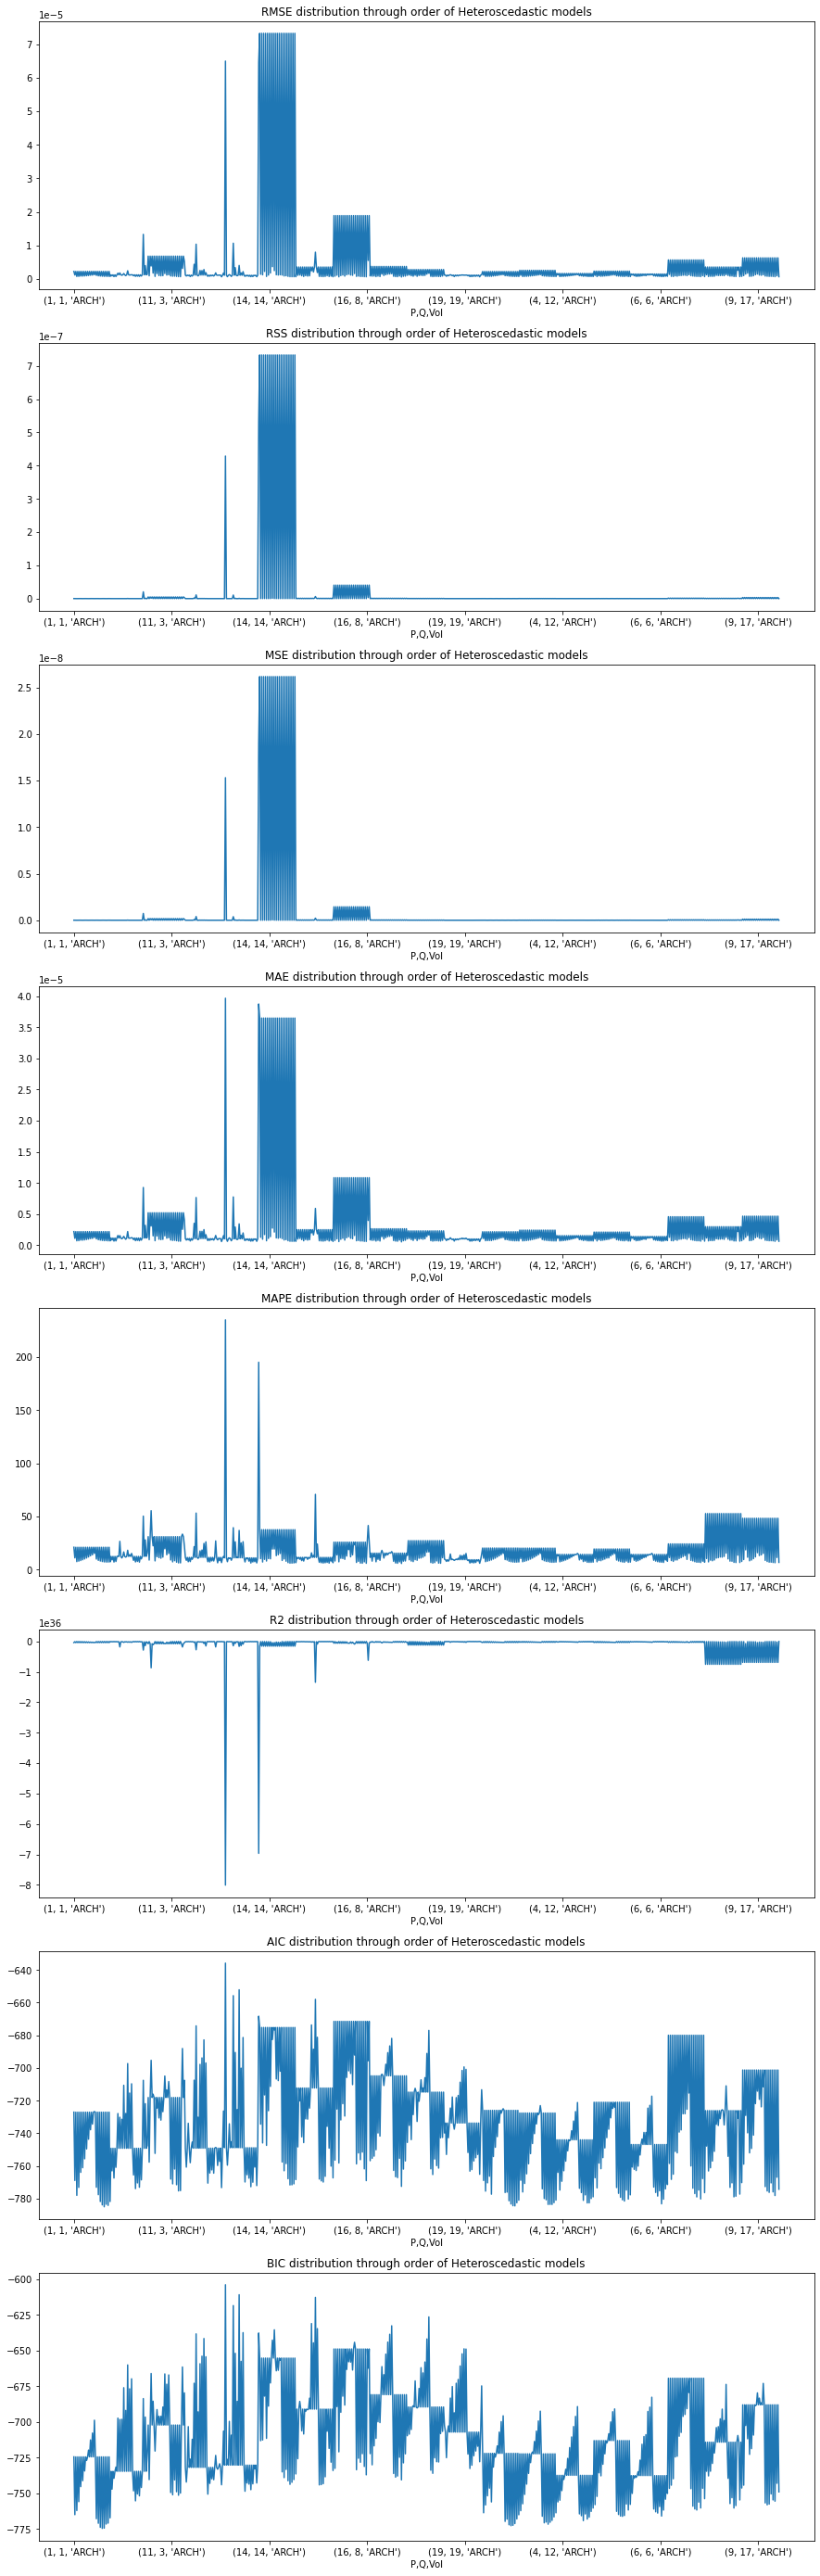

In [33]:
fig, axs = plt.subplots(nrows=all_metrics_df_test_arch_models.shape[1], ncols=1, figsize=(15, 50))

for idx, metric_title in enumerate(all_metrics_df_test_arch_models.columns):
    all_metrics_df_test_arch_models.reset_index().groupby(['P', 'Q', 'Vol'])[metric_title].mean().plot(
        title='{} distribution through order of Heteroscedastic models'.format(metric_title), ax=axs[idx]);

## Метрики у вигляді таблиць

In [34]:
all_metrics_df_test_arch_models.shape

(3610, 8)

In [35]:
all_metrics_df_test_arch_models.head(3)

RMSE           RSS           MSE       MAE       MAPE  \
P Q Vol    Fold                                                              
1 1 'ARCH' 0     0.000003  2.000923e-10  7.146153e-12  0.000003  60.834581   
           1     0.000002  1.150999e-10  4.110712e-12  0.000002   3.860728   
           2     0.000003  2.057653e-10  7.348761e-12  0.000003  12.260109   

                           R2         AIC         BIC  
P Q Vol    Fold                                        
1 1 'ARCH' 0    -1.631893e+35 -714.604514 -711.940105  
           1     0.000000e+00 -730.087893 -727.423484  
           2    -2.622126e+33 -713.821703 -711.157294

#### усереднюємо метрики по фолдам для кожного набору порядків моделі

In [36]:
all_metrics_df_test_arch_models_resampled = all_metrics_df_test_arch_models.reset_index().groupby(
    ['P', 'Q', 'Vol']).mean()

In [37]:
all_metrics_df_test_arch_models_resampled

RMSE           RSS           MSE           MAE  \
P Q  Vol                                                               
1 1  'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
     'GARCH'  1.143724e-06  4.708547e-11  1.681624e-12  1.100766e-06   
  10 'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
     'GARCH'  7.191245e-07  1.715512e-11  6.126830e-13  7.089243e-07   
  11 'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
...                    ...           ...           ...           ...   
9 7  'GARCH'  6.523693e-07  1.430247e-11  5.108026e-13  6.292300e-07   
  8  'ARCH'   6.279955e-06  3.405348e-09  1.216196e-10  4.668846e-06   
     'GARCH'  8.917484e-07  3.393237e-11  1.211870e-12  8.630009e-07   
  9  'ARCH'   6.279955e-06  3.405348e-09  1.216196e-10  4.668846e-06   
     'GARCH'  6.525701e-07  1.441655e-11  5.148766e-13  6.439208e-07   

                   MAPE            R2         AIC         BIC  
P Q  Vol                                                       
1 1  'ARCH'   20.964321 -4.004868e+34 -727.067977 -724.403568  
     'GARCH'  10.934508 -1.039501e+34 -768.894205 -764.897591  
  10 'ARCH'   20.964321 -4.004868e+34 -727.067977 -724.403568  
     'GARCH'   7.440771 -5.803595e+33 -777.994493 -762.008039  
  11 'ARCH'   20.964321 -4.004868e+34 -727.067977 -724.403568  
...                 ...           ...         ...         ...  
9 7  'GARCH'   6.404836 -4.020535e+33 -778.095121 -755.447645  
  8  'ARCH'   48.217447 -6.897196e+35 -701.265844 -687.943799  
     'GARCH'  11.336663 -2.001108e+34 -766.897098 -742.917417  
  9  'ARCH'   48.217447 -6.897196e+35 -701.265844 -687.943799  
     'GARCH'   6.743717 -4.733564e+33 -774.226601 -748.914716  

[722 rows x 8 columns]

In [38]:
all_metrics_df_test_arch_models_resampled.to_csv('all_metrics_df_test_arch_models_resampled.csv', index=False)

In [40]:
all_metrics_df_test_arch_models_resampled.RMSE.idxmin(), all_metrics_df_test_arch_models_resampled.RSS.idxmin()

(('17', '6', "'GARCH'"), ('17', '6', "'GARCH'"))

In [41]:
all_metrics_df_test_arch_models_resampled.MSE.idxmin(), all_metrics_df_test_arch_models_resampled.MAE.idxmin()

(('17', '6', "'GARCH'"), ('17', '6', "'GARCH'"))

In [44]:
all_metrics_df_test_arch_models_resampled.MAPE.idxmin()

('17', '6', "'GARCH'")